In [25]:
# ======================================
# IMPORTS & CONFIGURATION
# ======================================

import numpy as np
import pandas as pd

import lmfit
from lmfit import Model

# Path to the big table you just made
INPUT_CSV = "../paper1/csv/combined_sources_all_spw.csv"

# Minimum number of SPWs required
MIN_SPW_DETECTIONS = 4

# SPWs used in the catalog (must match column names)
SPW_ORDER = [15, 16, 17, 2, 3, 4, 5, 6, 8]

# Corresponding frequencies in MHz
SPW_FREQUENCIES_MHZ = {
    15: 1345.5883,
    16: 1409.5883,
    17: 1473.5883,
    2: 1653.5753,
    3: 1717.5753,
    4: 1781.57534,
    5: 1845.5753,
    6: 1909.5753,
    8: 2037.5753,
}


In [26]:
# ======================================
# LOAD BIG TABLE
# ======================================

df = pd.read_csv(INPUT_CSV)
print("Loaded table shape:", df.shape)


# ======================================
# COUNT SPW DETECTIONS PER SOURCE
# ======================================

def count_valid_spws(row, spw_list):
    """Count how many SPWs have a valid flux."""
    count = 0
    for spw in spw_list:
        if not np.isnan(row[f"Total_S_SPW{spw}"]):
            count += 1
    return count

df["N_SPW"] = df.apply(count_valid_spws, axis=1, spw_list=SPW_ORDER)

print(df["N_SPW"].value_counts().sort_index())


Loaded table shape: (1410, 50)
N_SPW
1    471
2     84
3     66
4     52
5     61
6     42
7     46
8     66
9    522
Name: count, dtype: int64


In [27]:
# ======================================
# FILTER SOURCES WITH ENOUGH SPWs
# ======================================

df_sel = df[df["N_SPW"] >= MIN_SPW_DETECTIONS].reset_index(drop=True)

print("Sources with enough detections:", len(df_sel))
df_sel[["Source_ID", "N_SPW"]].head()


Sources with enough detections: 789


Source_ID  N_SPW
0  VPR J032942.6+320502.7      4
1  VPR J032940.2+312455.1      7
2  VPR J032911.6+323609.2      5
3  VPR J032843.1+313912.5      9
4  VPR J032840.4+304954.5      5

In [28]:
# ======================================
# EXTRACT SPECTRA PER SOURCE
# ======================================

def extract_spectrum(row):
    """
    Extract frequency, flux, and flux error arrays
    from one row of the wide table.
    """
    freqs = []
    fluxes = []
    errors = []

    for spw in SPW_ORDER:
        flux = row[f"Total_S_SPW{spw}"]
        err  = row[f"E_Total_S_SPW{spw}"]

        if np.isfinite(flux) and np.isfinite(err) and flux > 0 and err > 0:
            freqs.append(SPW_FREQUENCIES_MHZ[spw])
            fluxes.append(flux)
            errors.append(err)

    return np.array(freqs), np.array(fluxes), np.array(errors)


In [29]:
# ======================================
# POWER-LAW MODEL
# ======================================

NU0 = 1400.0  # MHz (reference frequency)

def power_law(nu, A, alpha):
    return A * (nu / NU0) ** alpha

pl_model = Model(power_law)


In [30]:
# ======================================
# CELL 6: FIT SPECTRAL INDICES WITH LMFIT ONLY
# ======================================

combined_results = []

for idx, row in df_sel.iterrows():
    # extract usable spectrum for this source
    freqs, fluxes, errors = extract_spectrum(row)

    # require at least MIN_SPW_DETECTIONS valid points
    if len(freqs) < MIN_SPW_DETECTIONS:
        continue

    # initial parameter guesses
    params = pl_model.make_params(
        A=np.median(fluxes),
        alpha=-0.7,   # typical synchrotron-ish slope
    )

    # weighted least-squares fit in linear flux space
    lmfit_result = pl_model.fit(
        fluxes,
        params,
        nu=freqs,
        weights=1.0 / errors
    )

    alpha_lm   = lmfit_result.params["alpha"].value
    e_alpha_lm = lmfit_result.params["alpha"].stderr
    A_lm       = lmfit_result.params["A"].value
    e_A_lm     = lmfit_result.params["A"].stderr
    chi2_red   = lmfit_result.redchi

    combined_results.append({
        "Source_ID": row["Source_ID"],
        "N_SPW_used": len(freqs),

        "alpha_lmfit": alpha_lm,
        "E_alpha_lmfit": e_alpha_lm,
        "A_lmfit": A_lm,
        "E_A_lmfit": e_A_lm,
        "chi2_red_lmfit": chi2_red,
    })

alpha_all_df = pd.DataFrame(combined_results)
print("Total entries in alpha_all_df:", len(alpha_all_df))
alpha_all_df.tail()


Total entries in alpha_all_df: 789


Source_ID  N_SPW_used  alpha_lmfit  E_alpha_lmfit  \
784  VPR J031928.2+302027.6           4     4.141781       1.113474   
785  VPR J033326.2+313807.5           5     0.574279       3.191487   
786  VPR J033957.4+291826.4           4     6.493479       1.071368   
787  VPR J032945.4+311552.0           5     8.621035       3.529765   
788  VPR J033250.1+303328.2           4     1.047059       2.759419   

       A_lmfit  E_A_lmfit  chi2_red_lmfit  
784  26.562858   8.336030        0.200717  
785   1.279674   1.199379        2.406946  
786  42.436400  13.721851        0.652450  
787  16.508091  17.692066       10.924601  
788   1.257388   1.051321        1.286474

In [43]:
# ======================================
# SAVE GOOD LMFIT FITS TO A FILE
# ======================================

import pandas as pd
import numpy as np

# (alpha_all_df already exists from previous cells)

# --------------------------------------
# Filter thresholds
# --------------------------------------
CHI2_MAX_LMFIT = 3      # MAIN filter (always applied)
ERR_MAX        = 0.2     # Optional σ(alpha) filter

USE_E_ALPHA_FILTER = False   # ← toggle this ON/OFF

# --------------------------------------
# Base mask: validity + alpha range + chi²
# --------------------------------------
mask_lm = (
    np.isfinite(alpha_all_df["alpha_lmfit"]) &
    np.isfinite(alpha_all_df["chi2_red_lmfit"]) &
    (alpha_all_df["alpha_lmfit"] >= -3.0) &
    (alpha_all_df["alpha_lmfit"] <= 3.0) &
    (alpha_all_df["chi2_red_lmfit"] <= CHI2_MAX_LMFIT)
)

# --------------------------------------
# Optional E_alpha filter
# --------------------------------------
if USE_E_ALPHA_FILTER:
    mask_lm &= (
        np.isfinite(alpha_all_df["E_alpha_lmfit"]) &
        (alpha_all_df["E_alpha_lmfit"] <= ERR_MAX)
    )

# --------------------------------------
# Apply mask
# --------------------------------------
alpha_good_lmfit = alpha_all_df[mask_lm].reset_index(drop=True)

# --------------------------------------
# Reporting
# --------------------------------------
print(f"[lmfit] total fits: {len(alpha_all_df)}")
print(f"[lmfit] GOOD fits (|α|≤3, χ²≤{CHI2_MAX_LMFIT}"
      + (f", σ≤{ERR_MAX}" if USE_E_ALPHA_FILTER else "")
      + f"): {len(alpha_good_lmfit)}")

# --------------------------------------
# Select only the needed columns
# --------------------------------------
to_save = alpha_good_lmfit[
    ["Source_ID", "alpha_lmfit", "E_alpha_lmfit", "chi2_red_lmfit"]
]

# --------------------------------------
# Save file
# --------------------------------------
OUTPUT_GOOD_ALPHA = "../paper1/csv/good_alpha_lmfit.csv"

to_save.to_csv(OUTPUT_GOOD_ALPHA, index=False)

print(f"✅ Saved GOOD lmfit α values to:\n    {OUTPUT_GOOD_ALPHA}\n")

to_save.head()


[lmfit] total fits: 789
[lmfit] GOOD fits (|α|≤3, χ²≤3): 707
✅ Saved GOOD lmfit α values to:
    ../paper1/csv/good_alpha_lmfit.csv



Source_ID  alpha_lmfit  E_alpha_lmfit  chi2_red_lmfit
0  VPR J032843.1+313912.5    -0.557599       0.038241        1.114586
1  VPR J032831.6+305045.1    -0.979975       0.515549        1.570615
2  VPR J032827.4+302615.7    -1.283936       0.100948        1.478531
3  VPR J032819.3+313144.1    -1.000764       0.113234        1.449468
4  VPR J032802.9+305345.1    -0.380507       0.049182        0.167092

Number of sources plotted: 720


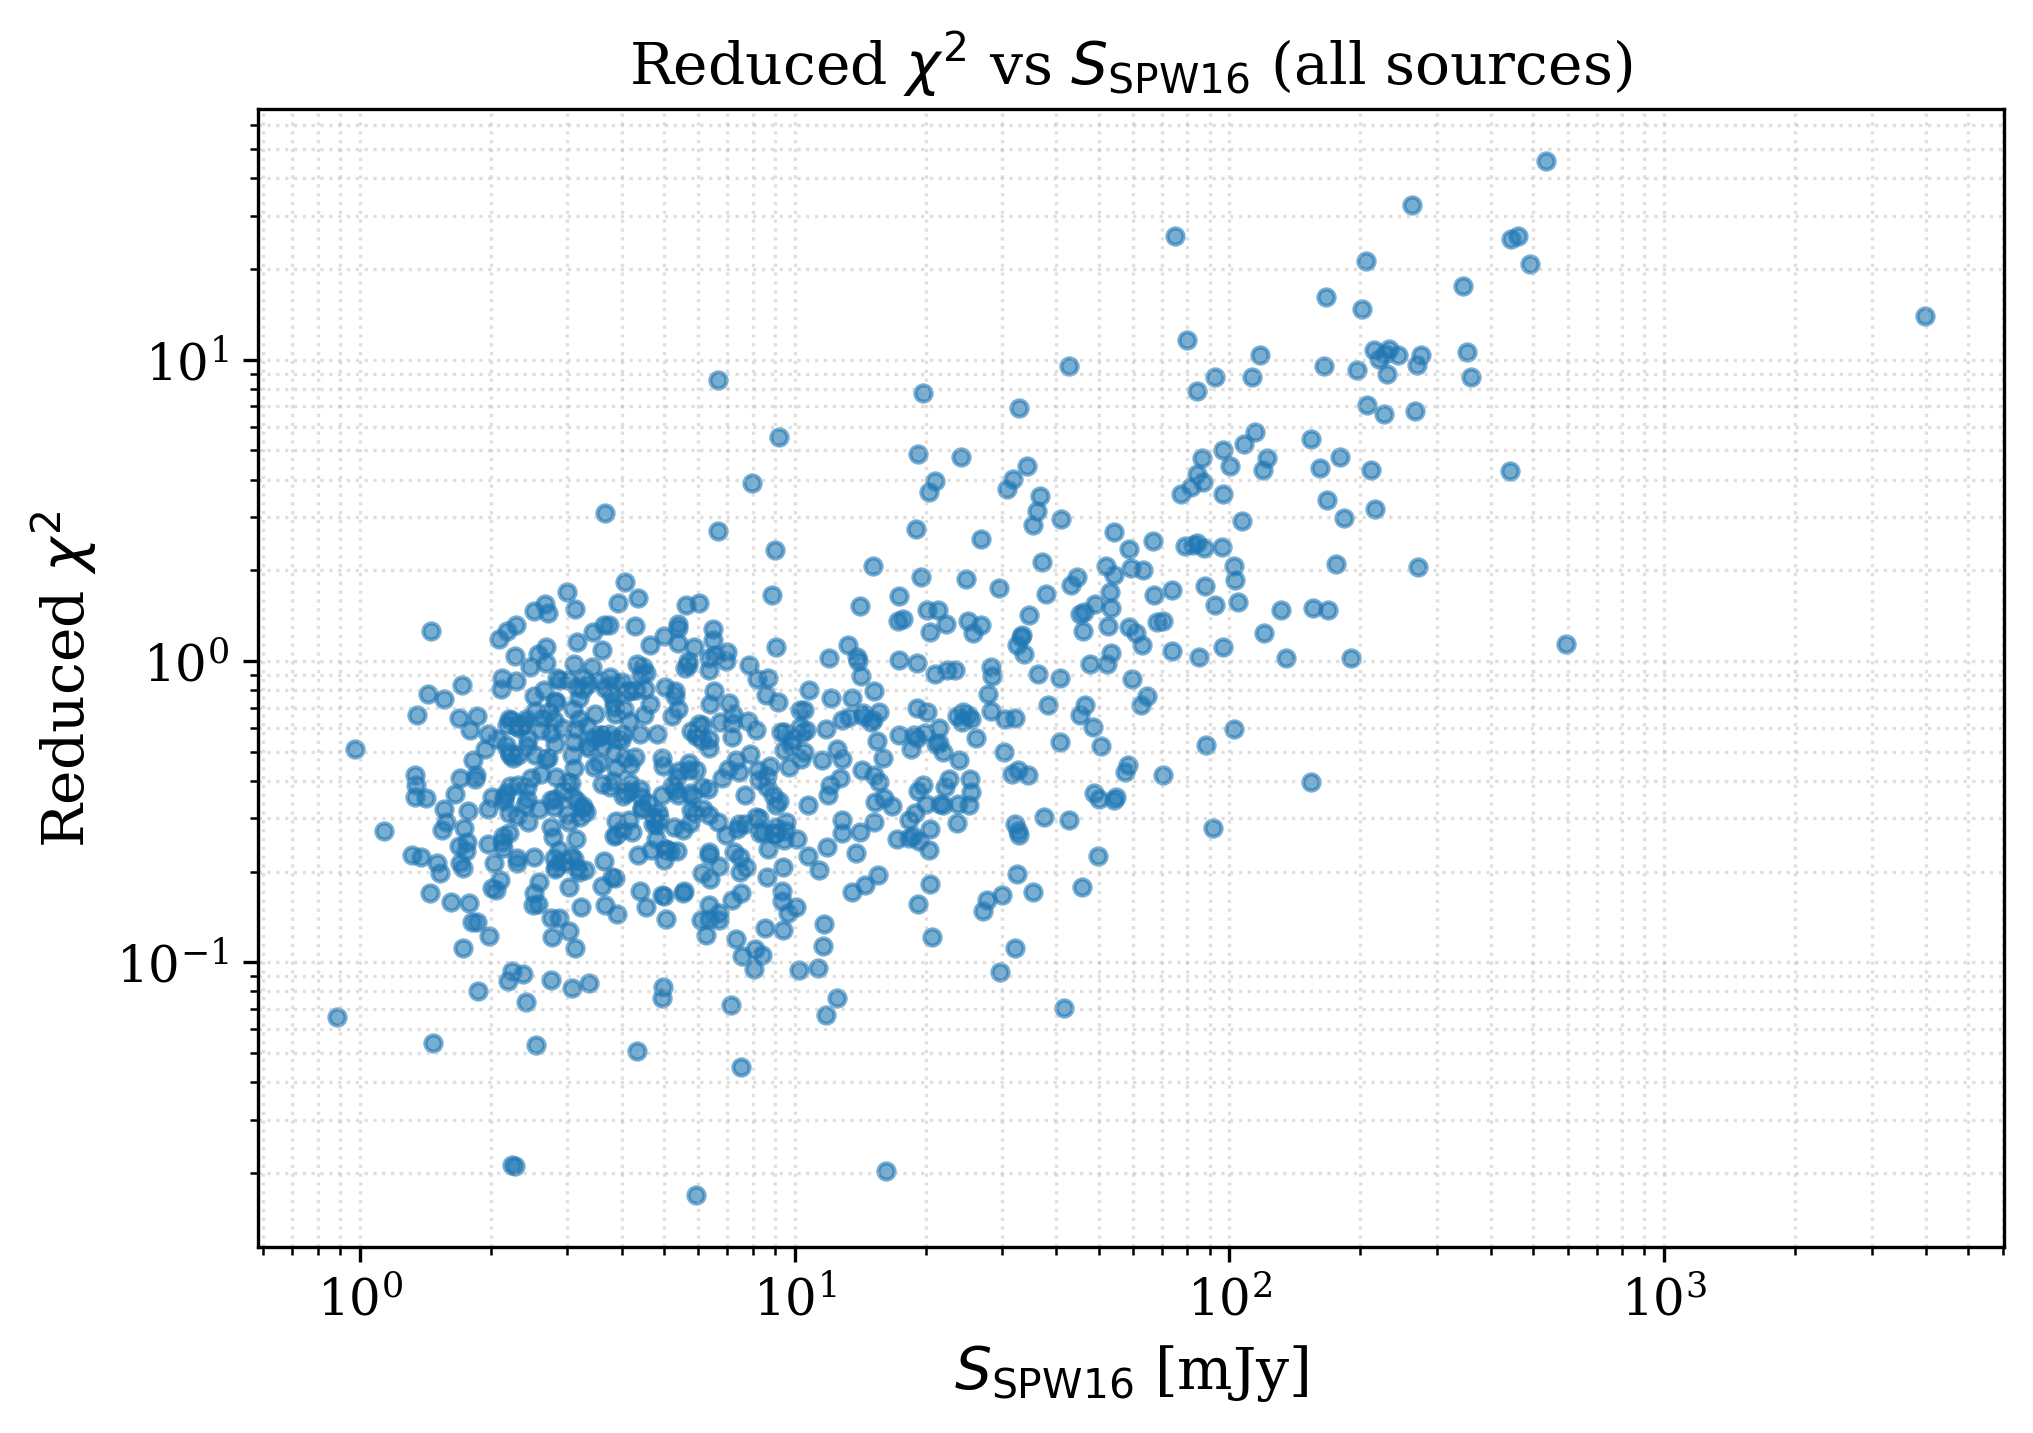

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------
# Merge SPW16 flux into alpha table
# --------------------------------------
spw16_df = df[["Source_ID", "Total_S_SPW16"]].copy()

plot_df = alpha_all_df.merge(
    spw16_df,
    on="Source_ID",
    how="left"
)

plot_df = plot_df.rename(columns={
    "Total_S_SPW16": "S_SPW16_mJy"
})

# --------------------------------------
# Keep only finite values (NOT a science filter)
# --------------------------------------
mask = (
    np.isfinite(plot_df["chi2_red_lmfit"]) &
    np.isfinite(plot_df["S_SPW16_mJy"]) &
    (plot_df["S_SPW16_mJy"] > 0)
)

plot_df = plot_df[mask]

print(f"Number of sources plotted: {len(plot_df)}")

# --------------------------------------
# Plot (log–log as discussed with Jeroen/Rene)
# --------------------------------------
plt.figure(figsize=(7, 5))

plt.scatter(
    plot_df["S_SPW16_mJy"],
    plot_df["chi2_red_lmfit"],
    s=15,
    alpha=0.6
)

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"$S_{\mathrm{SPW16}}$ [mJy]")
plt.ylabel(r"Reduced $\chi^2$")

plt.title(r"Reduced $\chi^2$ vs $S_{\mathrm{SPW16}}$ (all sources)")

plt.grid(True, which="both", ls=":", alpha=0.4)

plt.tight_layout()
plt.show()


Good fits in alpha_good_lmfit: 707
Good fits with finite SPW16 flux for plotting: 649


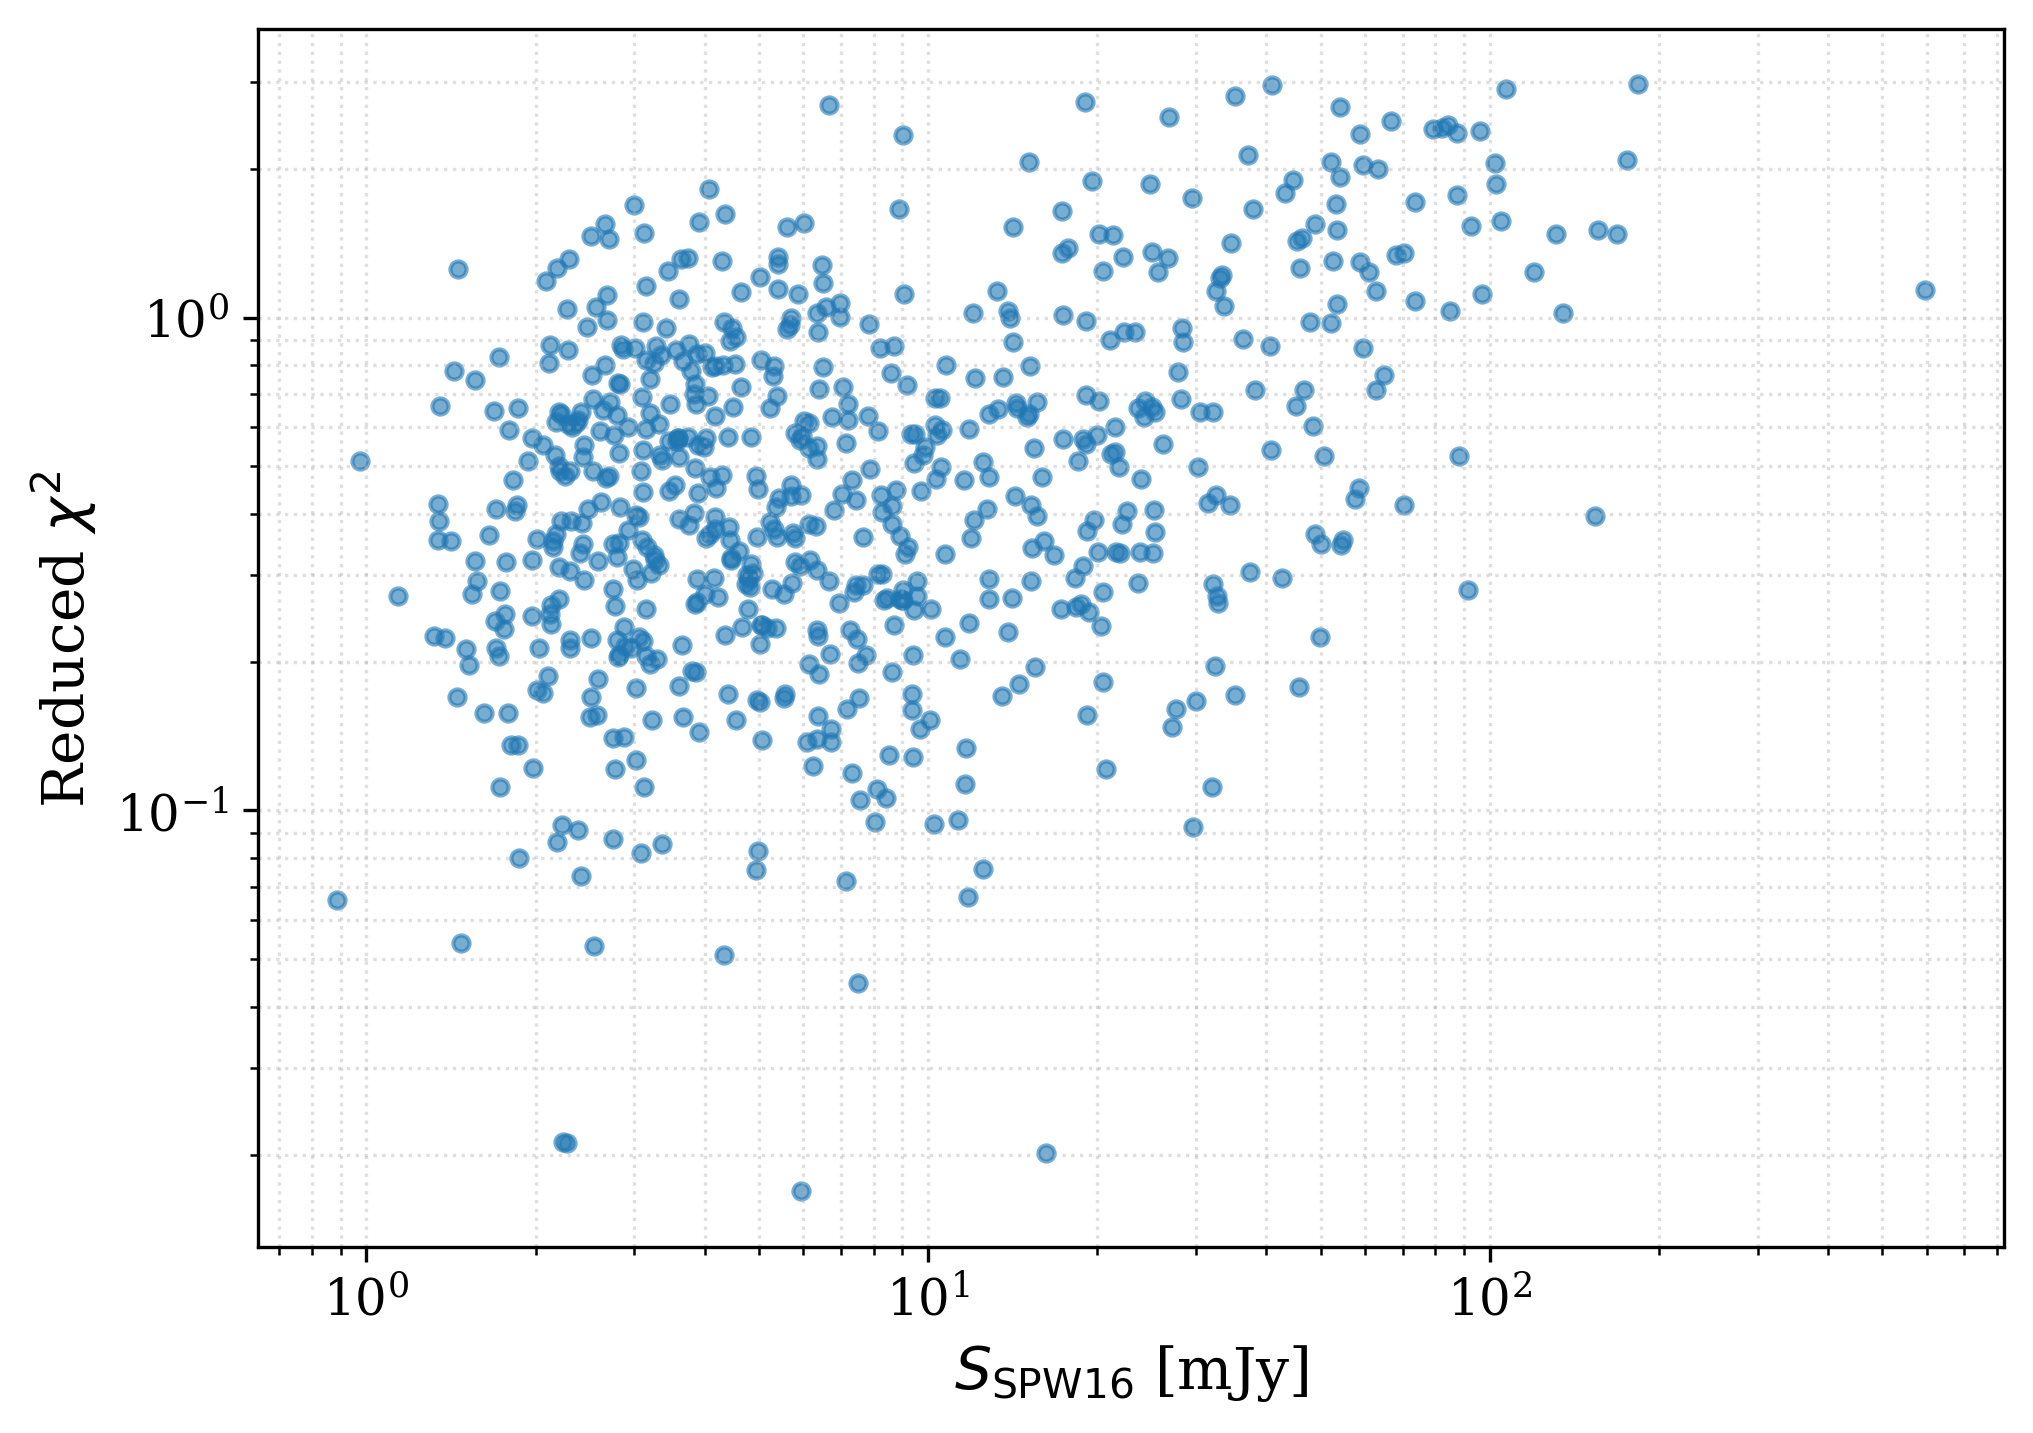

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# ======================================
# PLOT chi2_red vs SPW16 flux
# (for GOOD fits = alpha_good_lmfit)
# ======================================

# --- attach SPW16 flux from your master table (df) ---
spw16_df = df[["Source_ID", "Total_S_SPW16"]].copy()

plot_good = alpha_good_lmfit.merge(
    spw16_df,
    on="Source_ID",
    how="left"
).rename(columns={"Total_S_SPW16": "S_SPW16_mJy"})

# --- keep finite + positive flux (technical only) ---
mask = (
    np.isfinite(plot_good["chi2_red_lmfit"]) &
    np.isfinite(plot_good["S_SPW16_mJy"]) &
    (plot_good["S_SPW16_mJy"] > 0)
)
plot_good = plot_good[mask].copy()

print(f"Good fits in alpha_good_lmfit: {len(alpha_good_lmfit)}")
print(f"Good fits with finite SPW16 flux for plotting: {len(plot_good)}")

# --- plot (log–log) ---
plt.figure(figsize=(7, 5))
plt.scatter(plot_good["S_SPW16_mJy"], plot_good["chi2_red_lmfit"], s=15, alpha=0.6)

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"$S_{\mathrm{SPW16}}$ [mJy]")
plt.ylabel(r"Reduced $\chi^2$")


plt.grid(True, which="both", ls=":", alpha=0.4)
plt.tight_layout()
plt.show()


In [46]:
alpha_vals = alpha_good_lmfit["alpha_lmfit"].values

mean_alpha   = np.mean(alpha_vals)
median_alpha = np.median(alpha_vals)
std_alpha    = np.std(alpha_vals, ddof=1)   # sample standard deviation
N_alpha      = len(alpha_vals)

print(f"Mean α      = {mean_alpha:.3f}")
print(f"Median α    = {median_alpha:.3f}")
print(f"Std(α)      = {std_alpha:.3f}")
print(f"N sources   = {N_alpha}")


Mean α      = -0.711
Median α    = -0.808
Std(α)      = 0.710
N sources   = 707


✅ Spectral index histogram saved to: ../paper1/figs/spectral_index_histogram.pdf
   Mean α = -0.71,  σ = 0.71


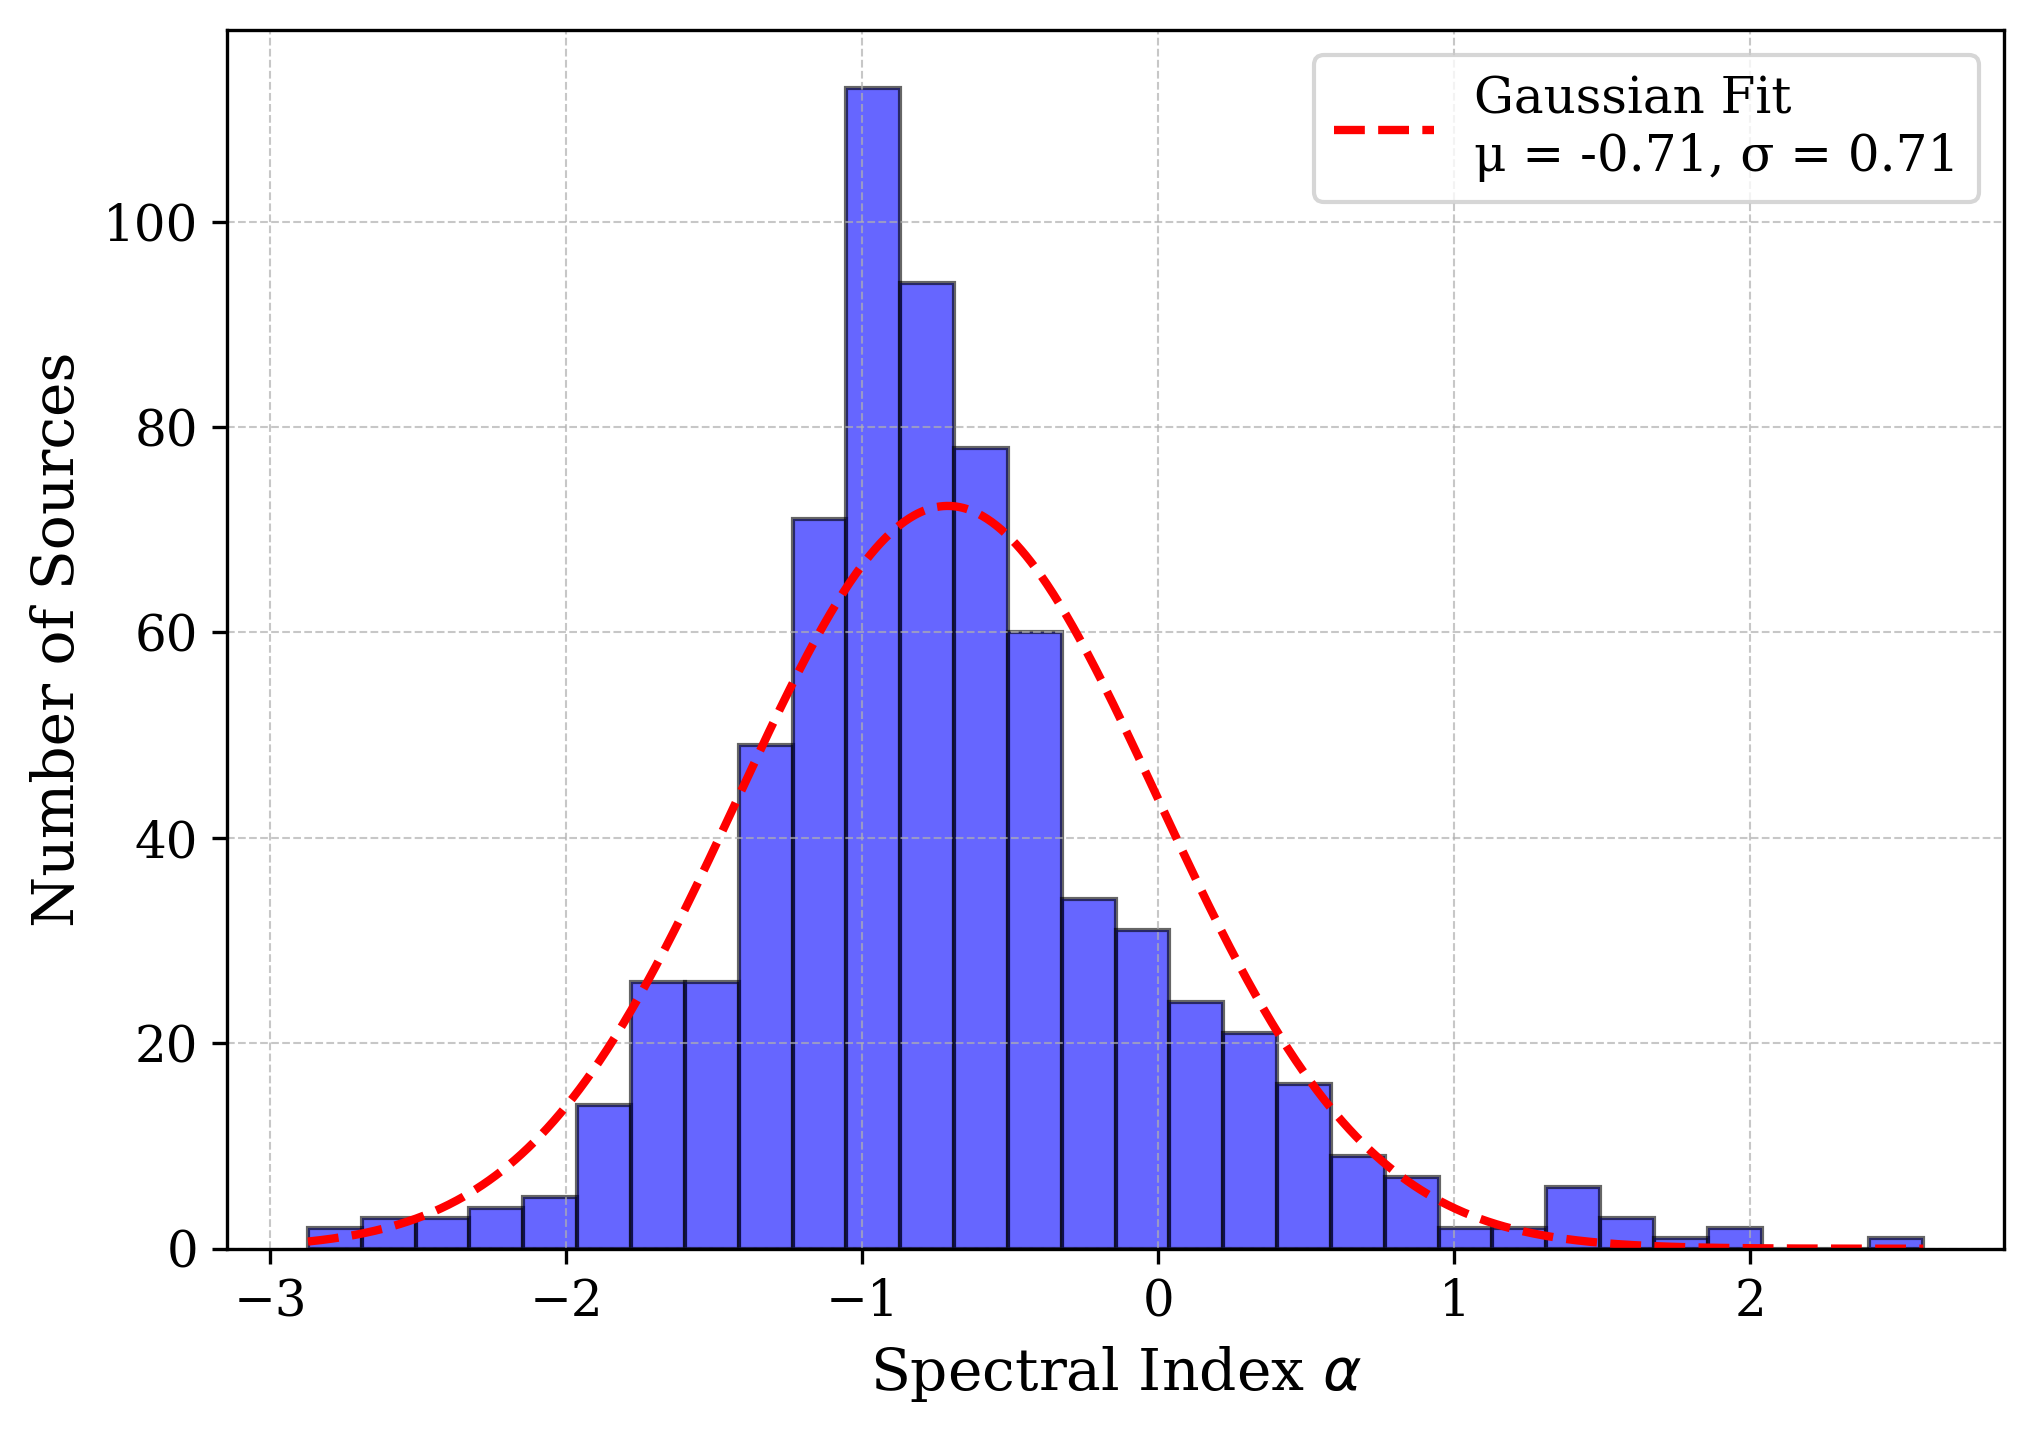

In [47]:
import matplotlib.pyplot as plt
# ======================================
# Global plot style (MATCHING RM HISTOGRAM)
# ======================================
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.usetex': False
})

# ======================================
# Spectral index histogram (lmfit good fits)
# ======================================

from scipy.stats import norm
import numpy as np
import os

alpha_lm_good = alpha_good_lmfit["alpha_lmfit"].dropna().values

if len(alpha_lm_good) > 0:

    # Gaussian fit
    mu_lm, std_lm = norm.fit(alpha_lm_good)

    fig, ax = plt.subplots(figsize=(7, 5))

    # Histogram — COUNTS
    counts, bins, _ = ax.hist(
        alpha_lm_good,
        bins=30,
        color='blue',
        edgecolor='black',
        alpha=0.6
    )

    # Scale Gaussian to histogram counts
    bin_width = bins[1] - bins[0]
    x = np.linspace(bins[0], bins[-1], 1000)
    y = norm.pdf(x, mu_lm, std_lm) * len(alpha_lm_good) * bin_width

    ax.plot(
        x,
        y,
        'r--',
        linewidth=2,
        label=f'Gaussian Fit\nμ = {mu_lm:.2f}, σ = {std_lm:.2f}'
    )

    # LABELS — styled by rcParams
    ax.set_xlabel(r'Spectral Index $\alpha$')
    ax.set_ylabel('Number of Sources')

    # MATCH GRID STYLE
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend()

    plt.tight_layout()

    # Save figure
    output_path = '../paper1/figs/spectral_index_histogram.pdf'
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, bbox_inches='tight')

    print(f"✅ Spectral index histogram saved to: {output_path}")
    print(f"   Mean α = {mu_lm:.2f},  σ = {std_lm:.2f}")

    plt.show()

else:
    print("⚠️ No lmfit α values available.")


## Fit two Gaussians

✅ Saved to: ../paper1/figs/spectral_index_histogram_two_gauss.pdf
Steep: mu = -0.851, sigma = 0.381, A = 74.0
Flat : mu = 0.213, sigma = 0.338, A = 16.2
Total sources: 579


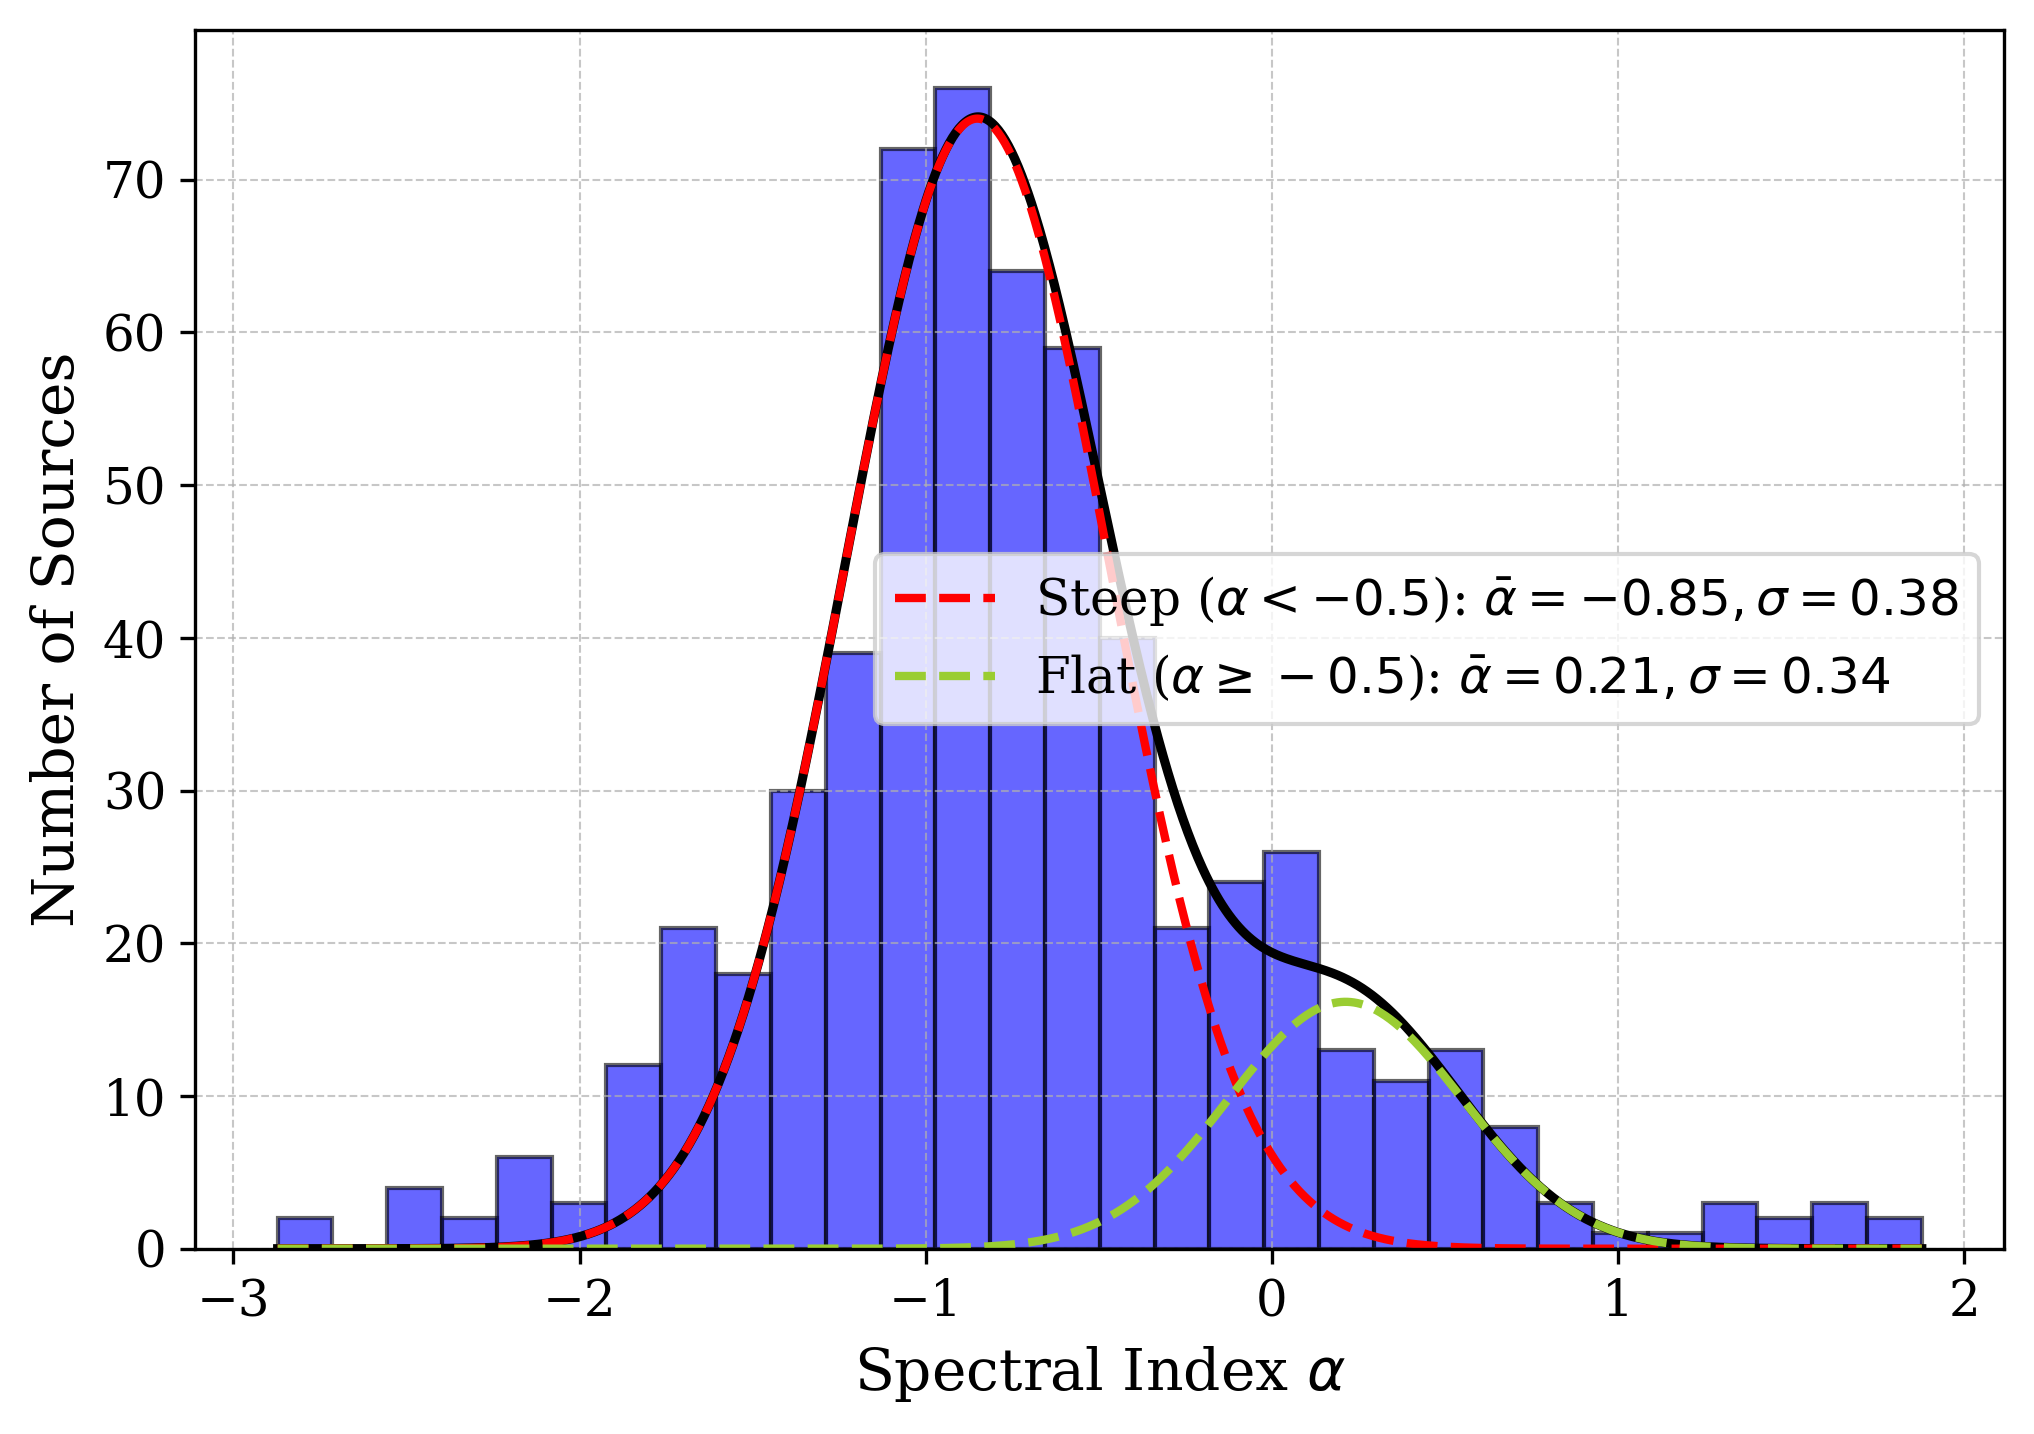

In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ======================================
# Global plot style (MATCHING RM HISTOGRAM)
# ======================================
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.usetex': False
})

# ======================================
# Color-blind friendly LINE colors only
# (Histogram color remains unchanged)
# ======================================
COL_TOTAL = 'black'    # total fit
COL_STEEP = 'red'  # blue (Okabe–Ito)
COL_FLAT  = 'yellowgreen'  # orange (Okabe–Ito)
COL_SPLIT = '0.3'      # dark gray

# ======================================
# Helper: single Gaussian in counts
# ======================================
def gauss(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# ======================================
# Spectral index histogram (lmfit good fits)
# ======================================
alpha_lm_good = alpha_good_lmfit["alpha_lmfit"].dropna().values

if len(alpha_lm_good) > 0:

    fig, ax = plt.subplots(figsize=(7, 5))

    # Histogram in COUNTS (UNCHANGED color)
    counts, bins, _ = ax.hist(
        alpha_lm_good,
        bins=30,
        color='blue',
        edgecolor='black',
        alpha=0.6
    )
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # ======================================
    # 1) Fit STEEP component (central peak)
    # ======================================
    steep_region = (bin_centers > -1.6) & (bin_centers < -0.4)
    x_steep = bin_centers[steep_region]
    y_steep = counts[steep_region]

    if y_steep.sum() > 0:
        mu0_steep = np.sum(x_steep * y_steep) / np.sum(y_steep)
        sigma0_steep = np.sqrt(
            np.sum(y_steep * (x_steep - mu0_steep) ** 2) / np.sum(y_steep)
        )
    else:
        mu0_steep = np.median(alpha_lm_good)
        sigma0_steep = 0.2

    A0_steep = y_steep.max()

    p0_steep = [A0_steep, mu0_steep, max(sigma0_steep, 0.1)]
    bounds_steep = (
        [0.0, -1.5, 0.05],   # A>0, mu in left region, narrow-ish
        [np.inf, -0.5, 0.4]
    )

    A1_arr, mu1_arr, sigma1_arr = curve_fit(
        gauss,
        x_steep,
        y_steep,
        p0=p0_steep,
        bounds=bounds_steep
    )[0]

    A1     = float(A1_arr)
    mu1    = float(mu1_arr)
    sigma1 = float(sigma1_arr)

    steep_model_bins = gauss(bin_centers, A1, mu1, sigma1)

    # ======================================
    # 2) Fit FLAT component (residual tail)
    # ======================================
    residual = np.clip(counts - steep_model_bins, 0.0, None)

    flat_region = (bin_centers > -0.8) & (bin_centers < 1.0)
    x_flat = bin_centers[flat_region]
    y_flat = residual[flat_region]

    if y_flat.sum() > 0:
        mu0_flat = np.sum(x_flat * y_flat) / np.sum(y_flat)
        sigma0_flat = np.sqrt(
            np.sum(y_flat * (x_flat - mu0_flat) ** 2) / np.sum(y_flat)
        )
        A0_flat = y_flat.max()

        p0_flat = [A0_flat, mu0_flat, max(sigma0_flat, 0.3)]

        bounds_flat = (
            [0.0, -0.7, 0.3],   # A>0, mu ≥ -0.7, sigma ≥ 0.3 (broad)
            [np.inf,  0.6, 1.2] # mu ≤ 0.6, sigma ≤ 1.2
        )

        A2_arr, mu2_arr, sigma2_arr = curve_fit(
            gauss,
            x_flat,
            y_flat,
            p0=p0_flat,
            bounds=bounds_flat
        )[0]

        A2     = float(A2_arr)
        mu2    = float(mu2_arr)
        sigma2 = float(sigma2_arr)

        flat_model_bins = gauss(bin_centers, A2, mu2, sigma2)
    else:
        A2, mu2, sigma2 = 0.0, 0.0, 1.0
        flat_model_bins = np.zeros_like(bin_centers)

    # ======================================
    # 3) Smooth curves for plotting
    # ======================================
    x = np.linspace(bins[0], bins[-1], 1000)
    g1 = gauss(x, A1, mu1, sigma1)            # steep
    g2 = gauss(x, A2, mu2, sigma2)            # flat
    gtot = g1 + g2

    # ======================================
    # Plot components + total (LINES ONLY changed)
    # ======================================
    ax.plot(x, gtot, color=COL_TOTAL, linewidth=2.2)
    ax.plot(
        x, g1,
        linestyle='--', linewidth=2,
        color=COL_STEEP,
        label=fr'Steep ($\alpha < -0.5$): $\bar\alpha = {mu1:.2f}, \sigma = {sigma1:.2f}$'
    )
    ax.plot(
        x, g2,
        linestyle='--', linewidth=2,
        color=COL_FLAT,
        label=fr'Flat ($\alpha \geq -0.5$): $\bar\alpha = {mu2:.2f}, \sigma = {sigma2:.2f}$'
    )

    # # Canonical split between flat and steep spectrum sources
    # ax.axvline(
    #     -0.5,
    #     color=COL_SPLIT,
    #     linestyle=':',
    #     linewidth=2,
    #     # label=r'Canonical split $\alpha = -0.5$'
    # )

    ax.set_xlabel(r'Spectral Index $\alpha$')
    ax.set_ylabel('Number of Sources')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend()

    plt.tight_layout()

    out_path = '../paper1/figs/spectral_index_histogram_two_gauss.pdf'
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, bbox_inches='tight')

    print(f"✅ Saved to: {out_path}")
    print(f"Steep: mu = {mu1:.3f}, sigma = {sigma1:.3f}, A = {A1:.1f}")
    print(f"Flat : mu = {mu2:.3f}, sigma = {sigma2:.3f}, A = {A2:.1f}")
    print(f"Total sources: {len(alpha_lm_good)}")

    plt.show()

else:
    print("⚠️ No lmfit α values available.")


# Plot some spectral indices

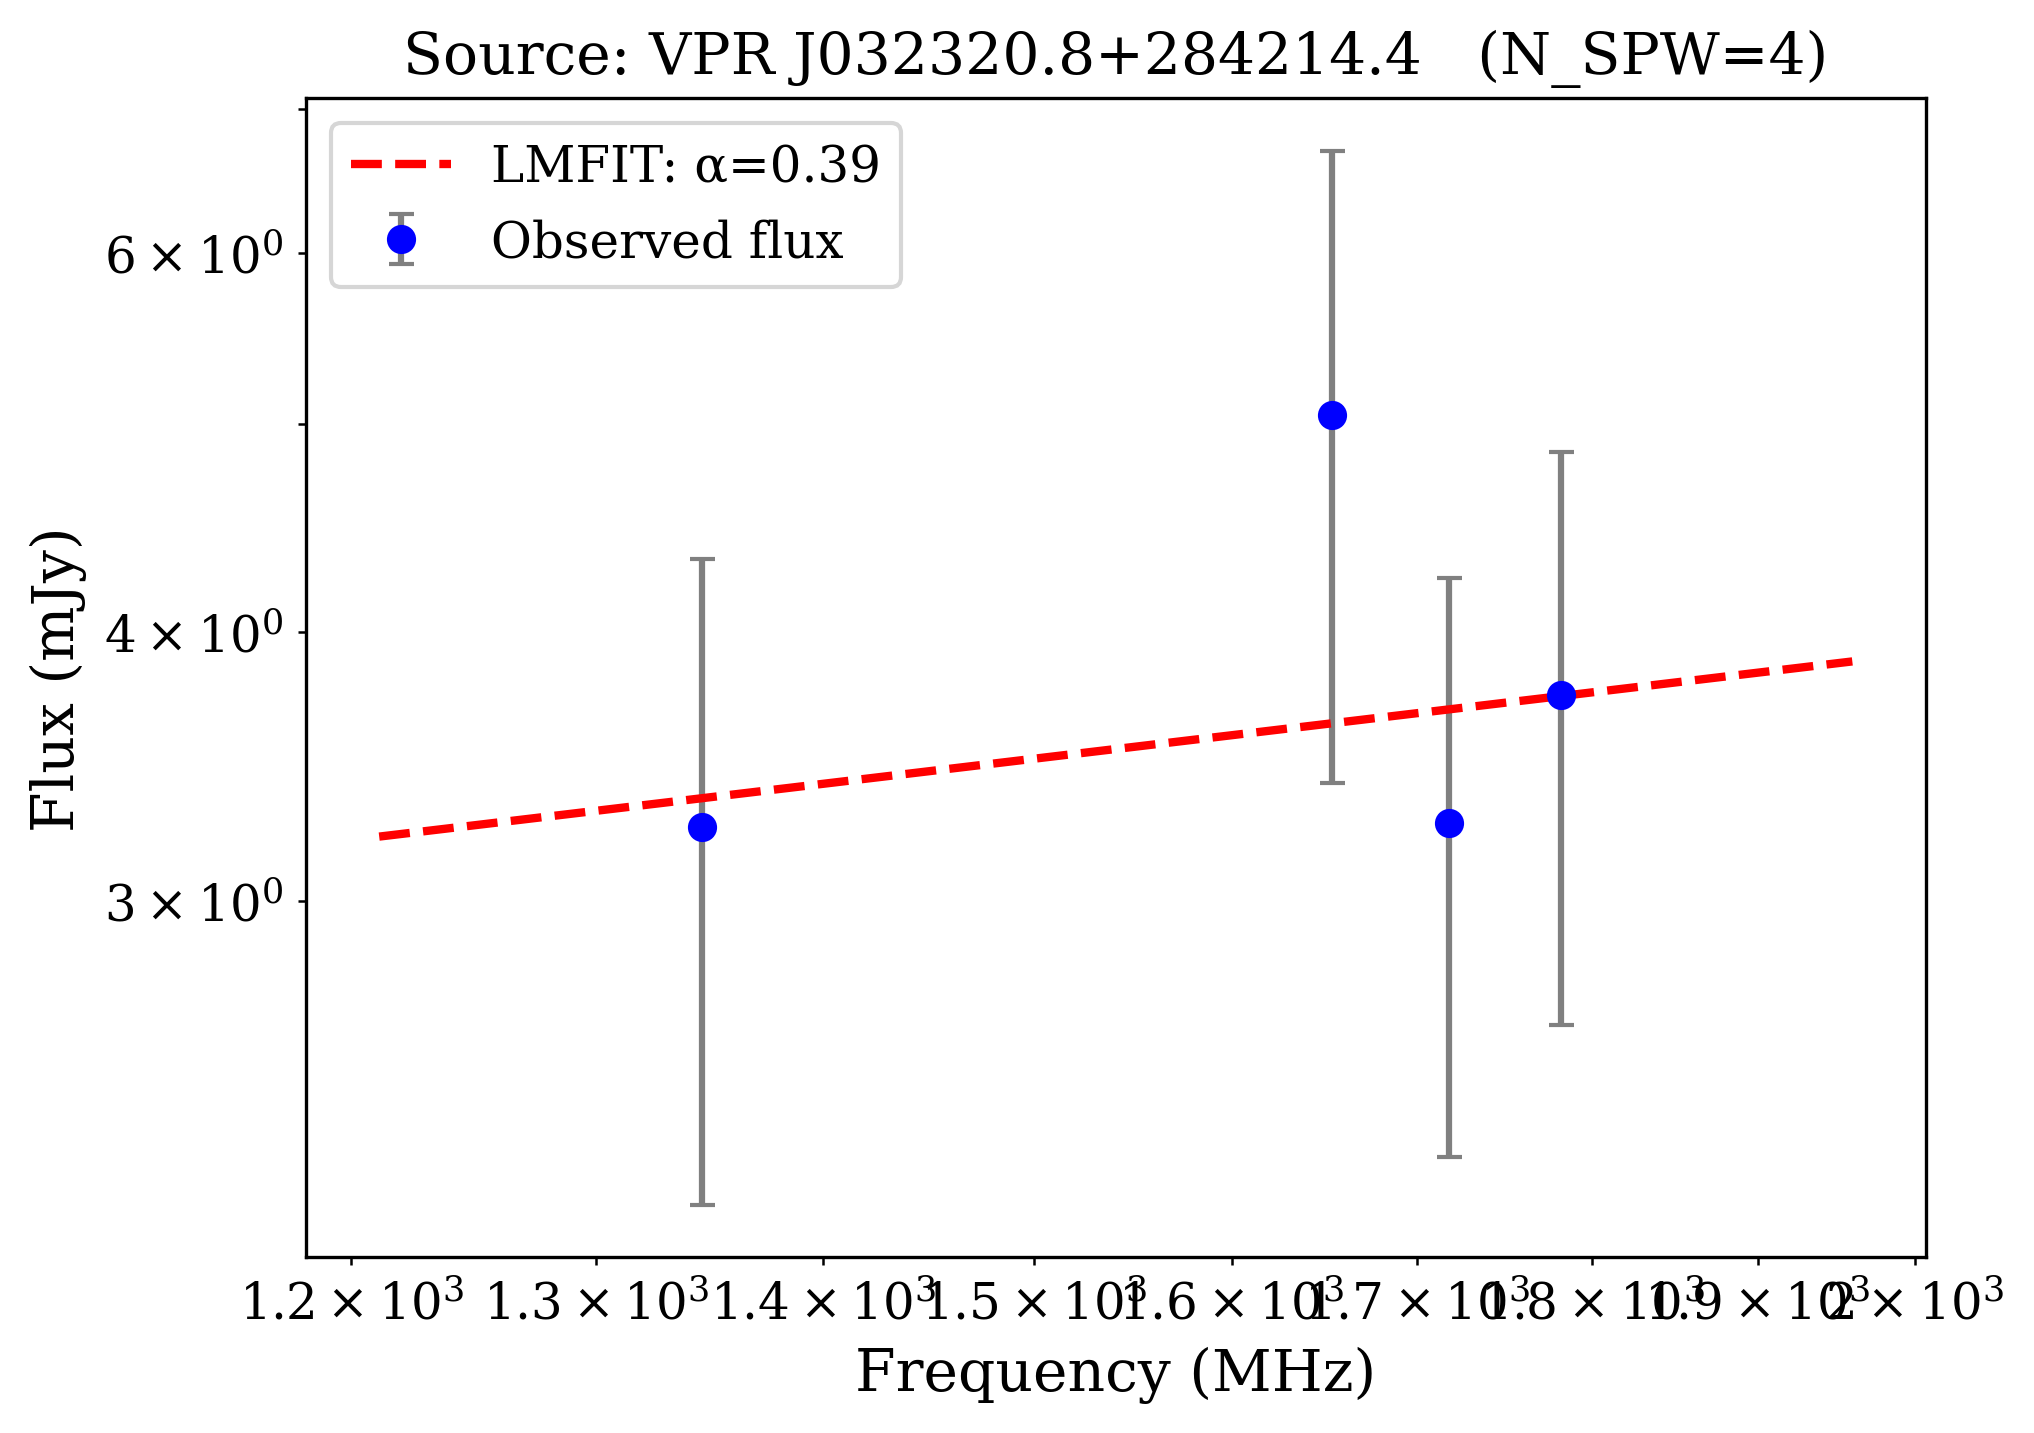

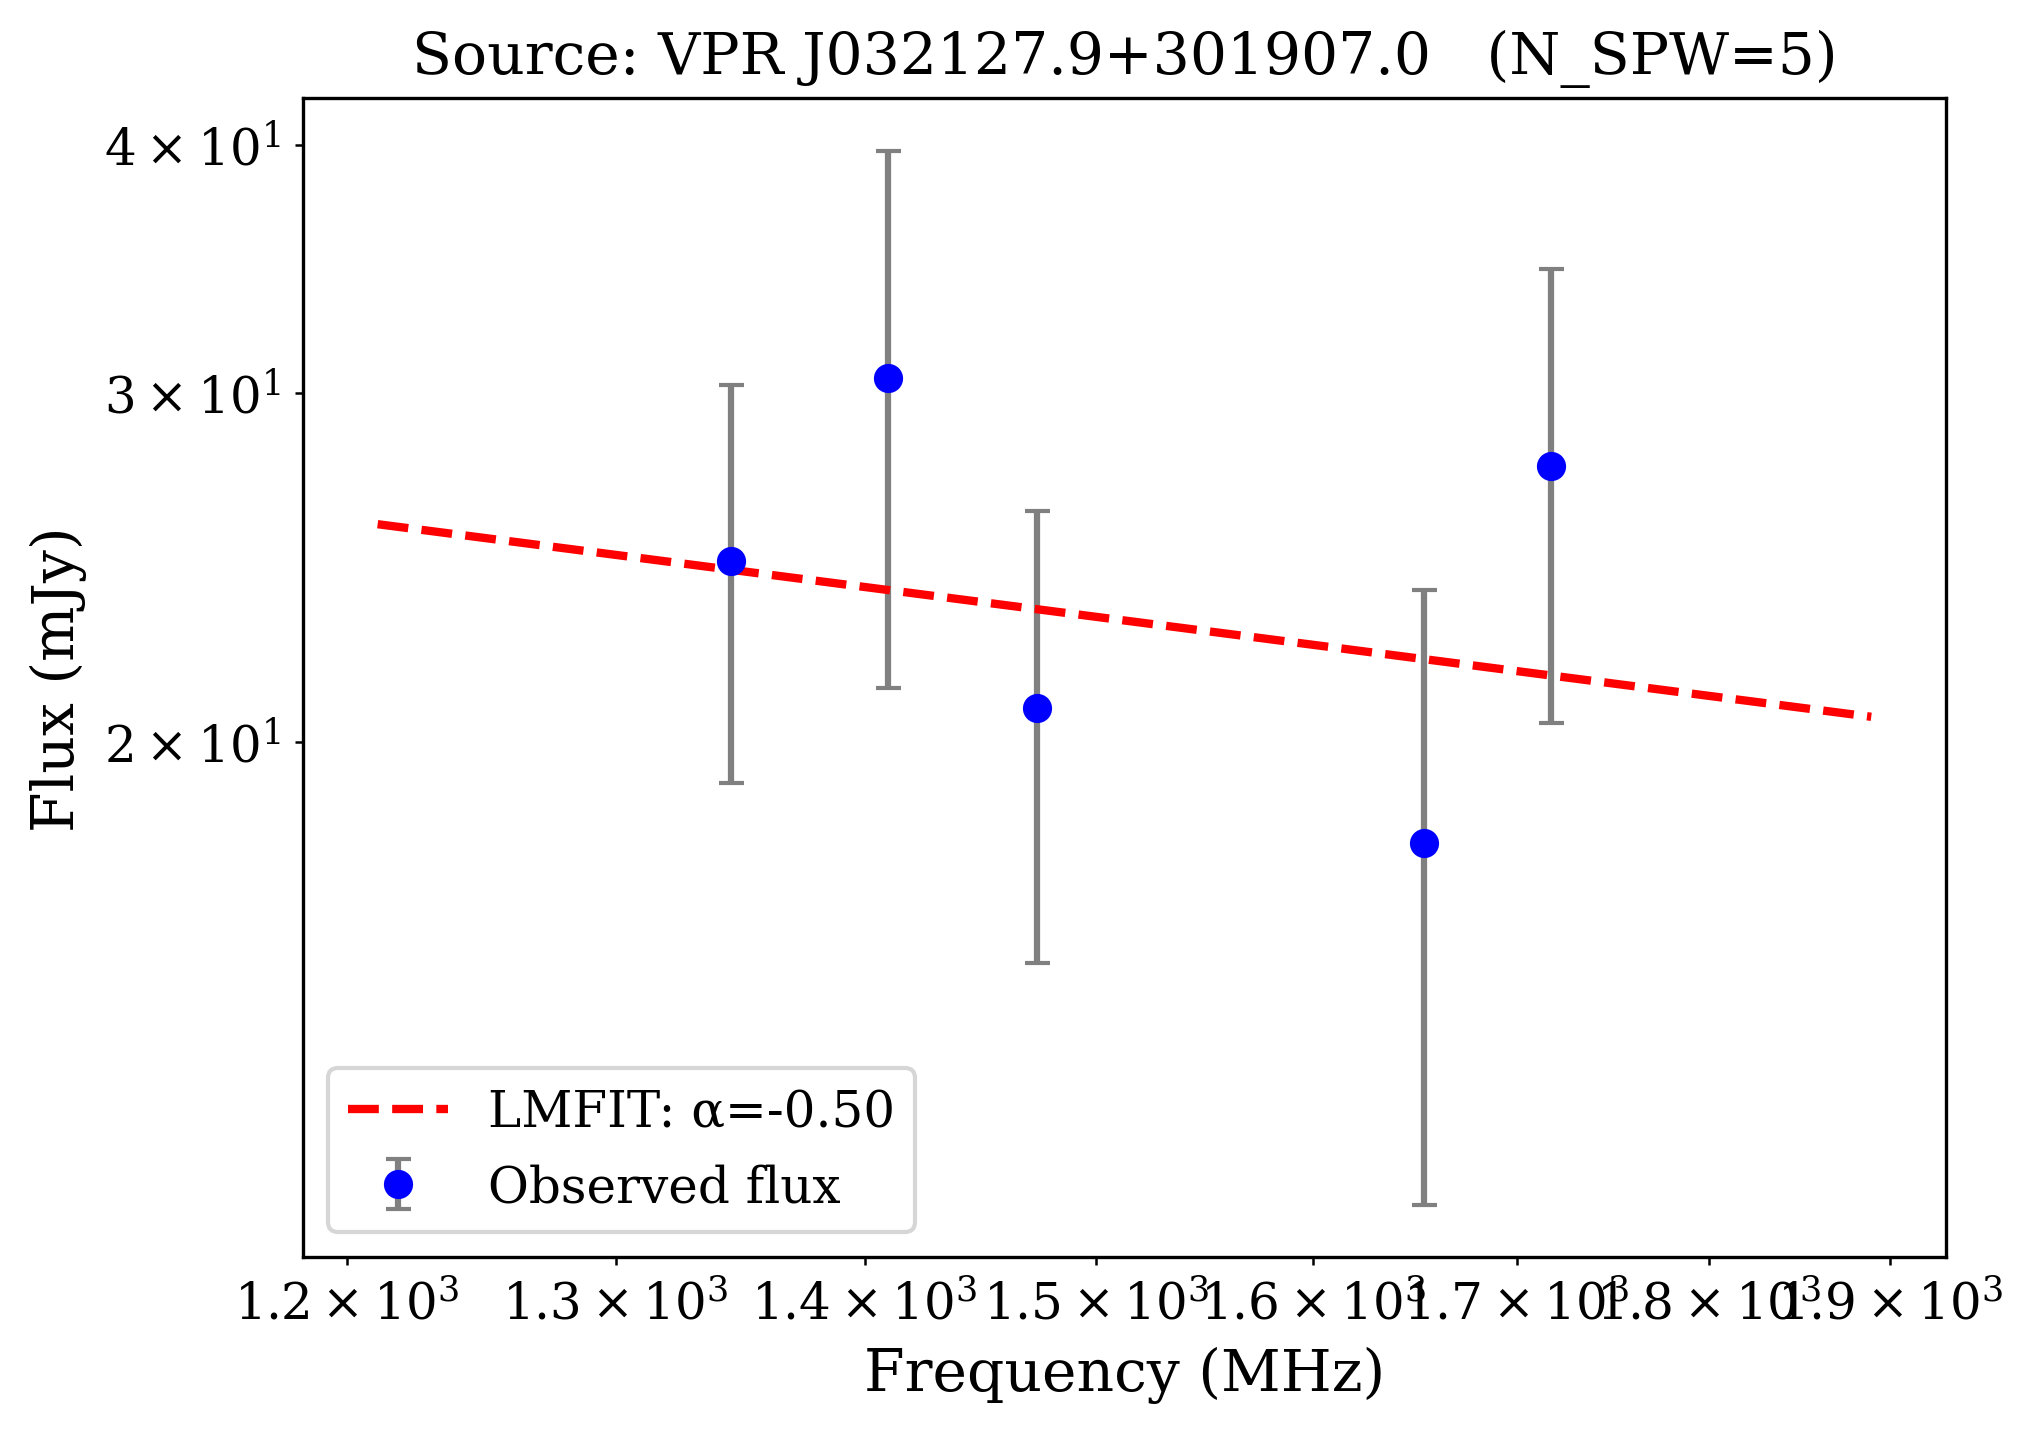

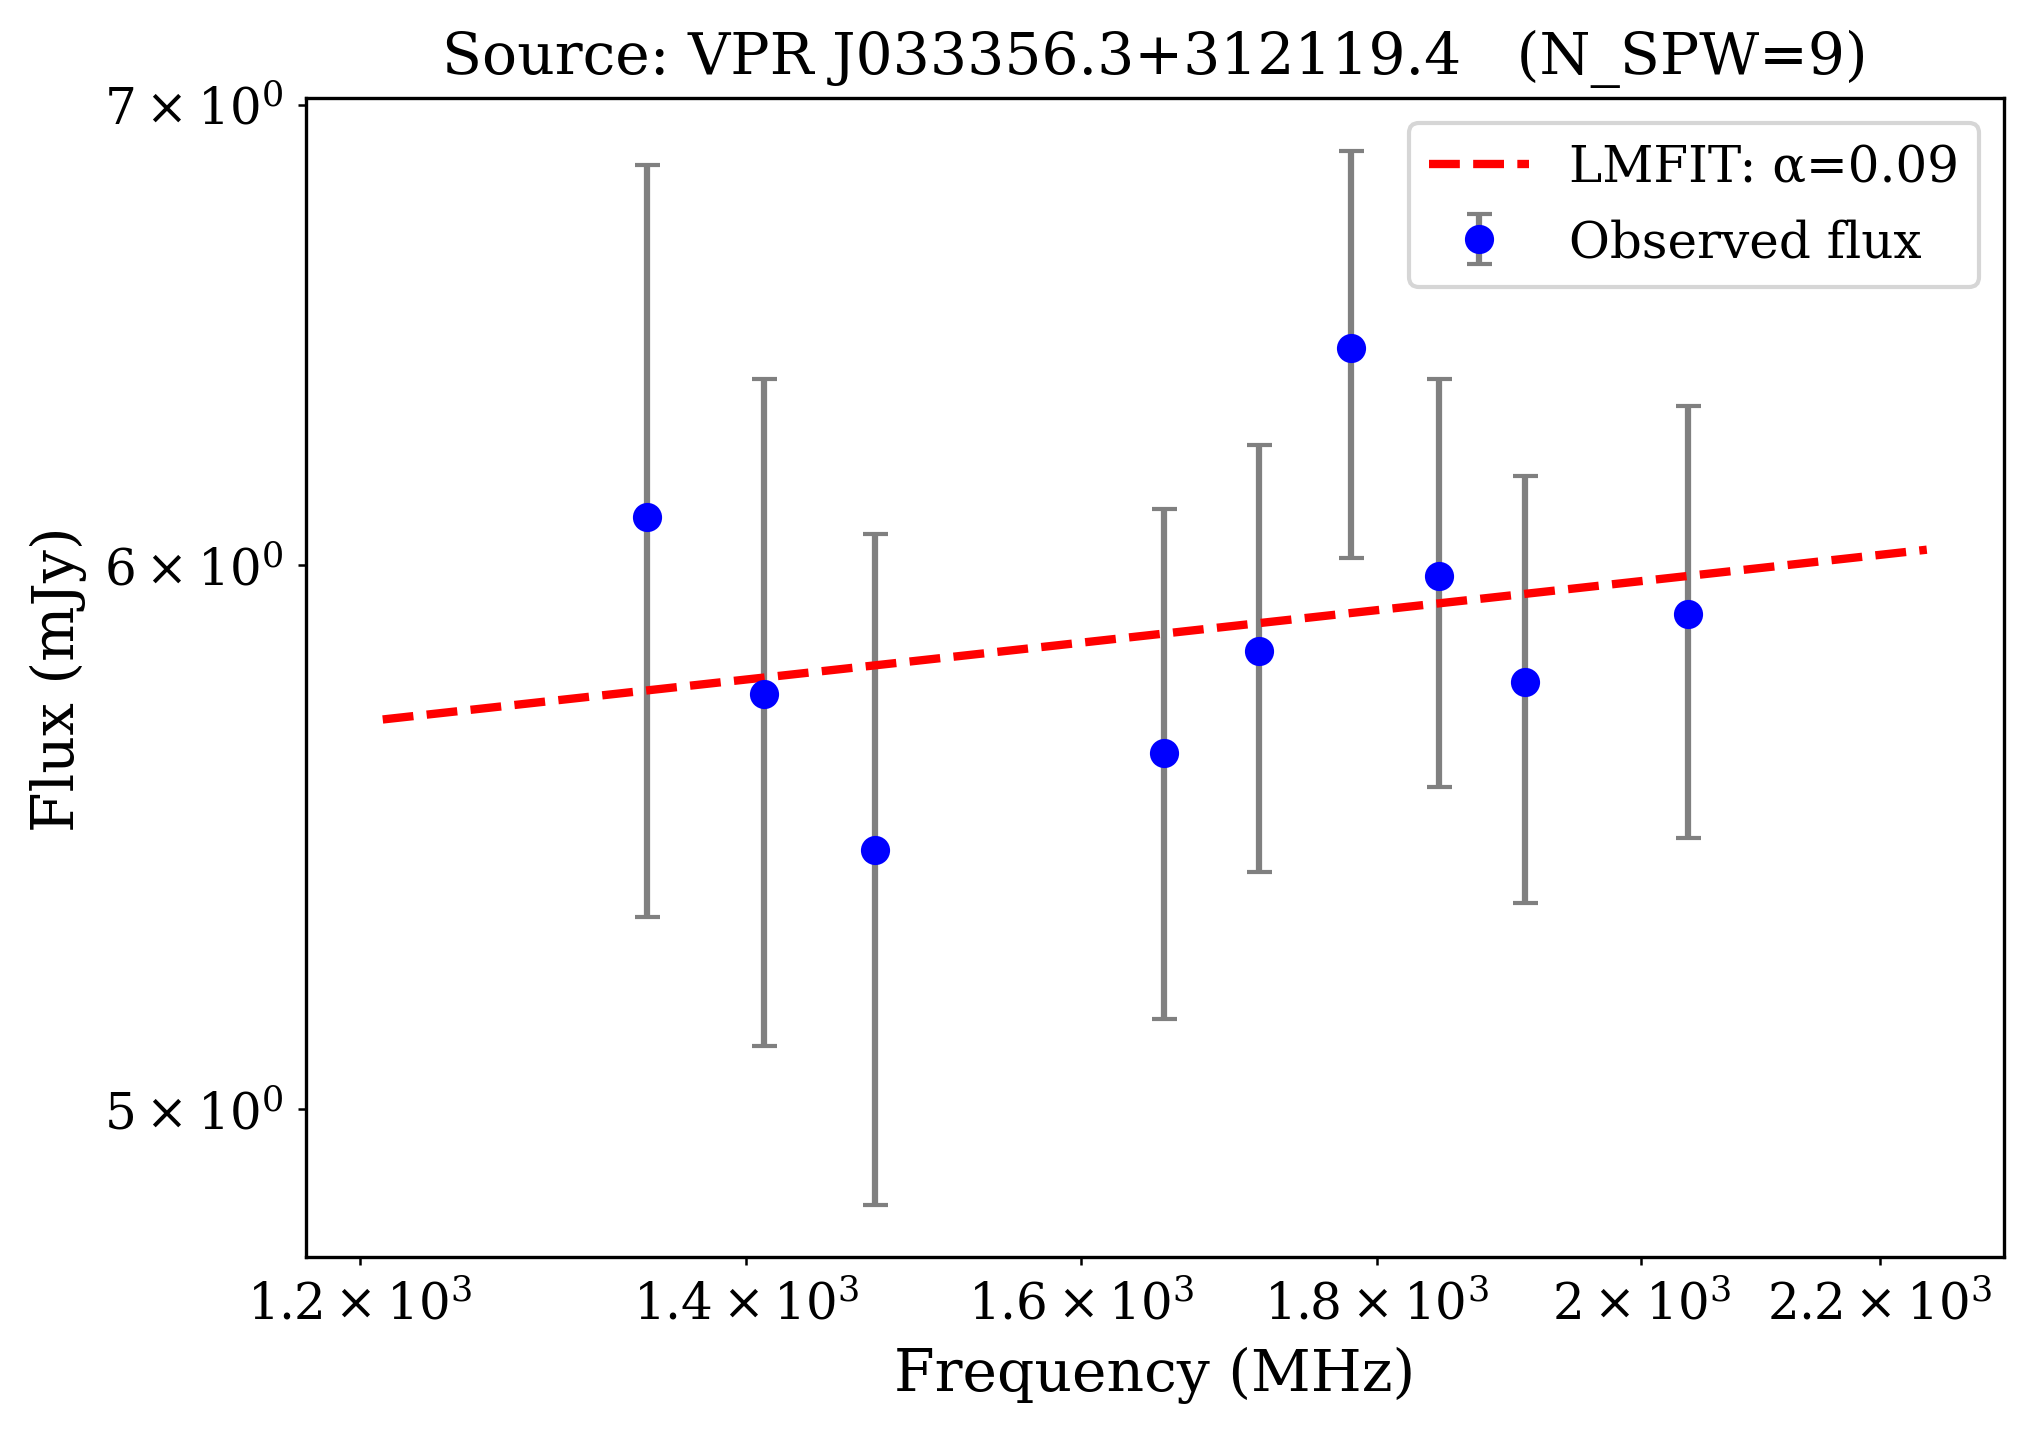

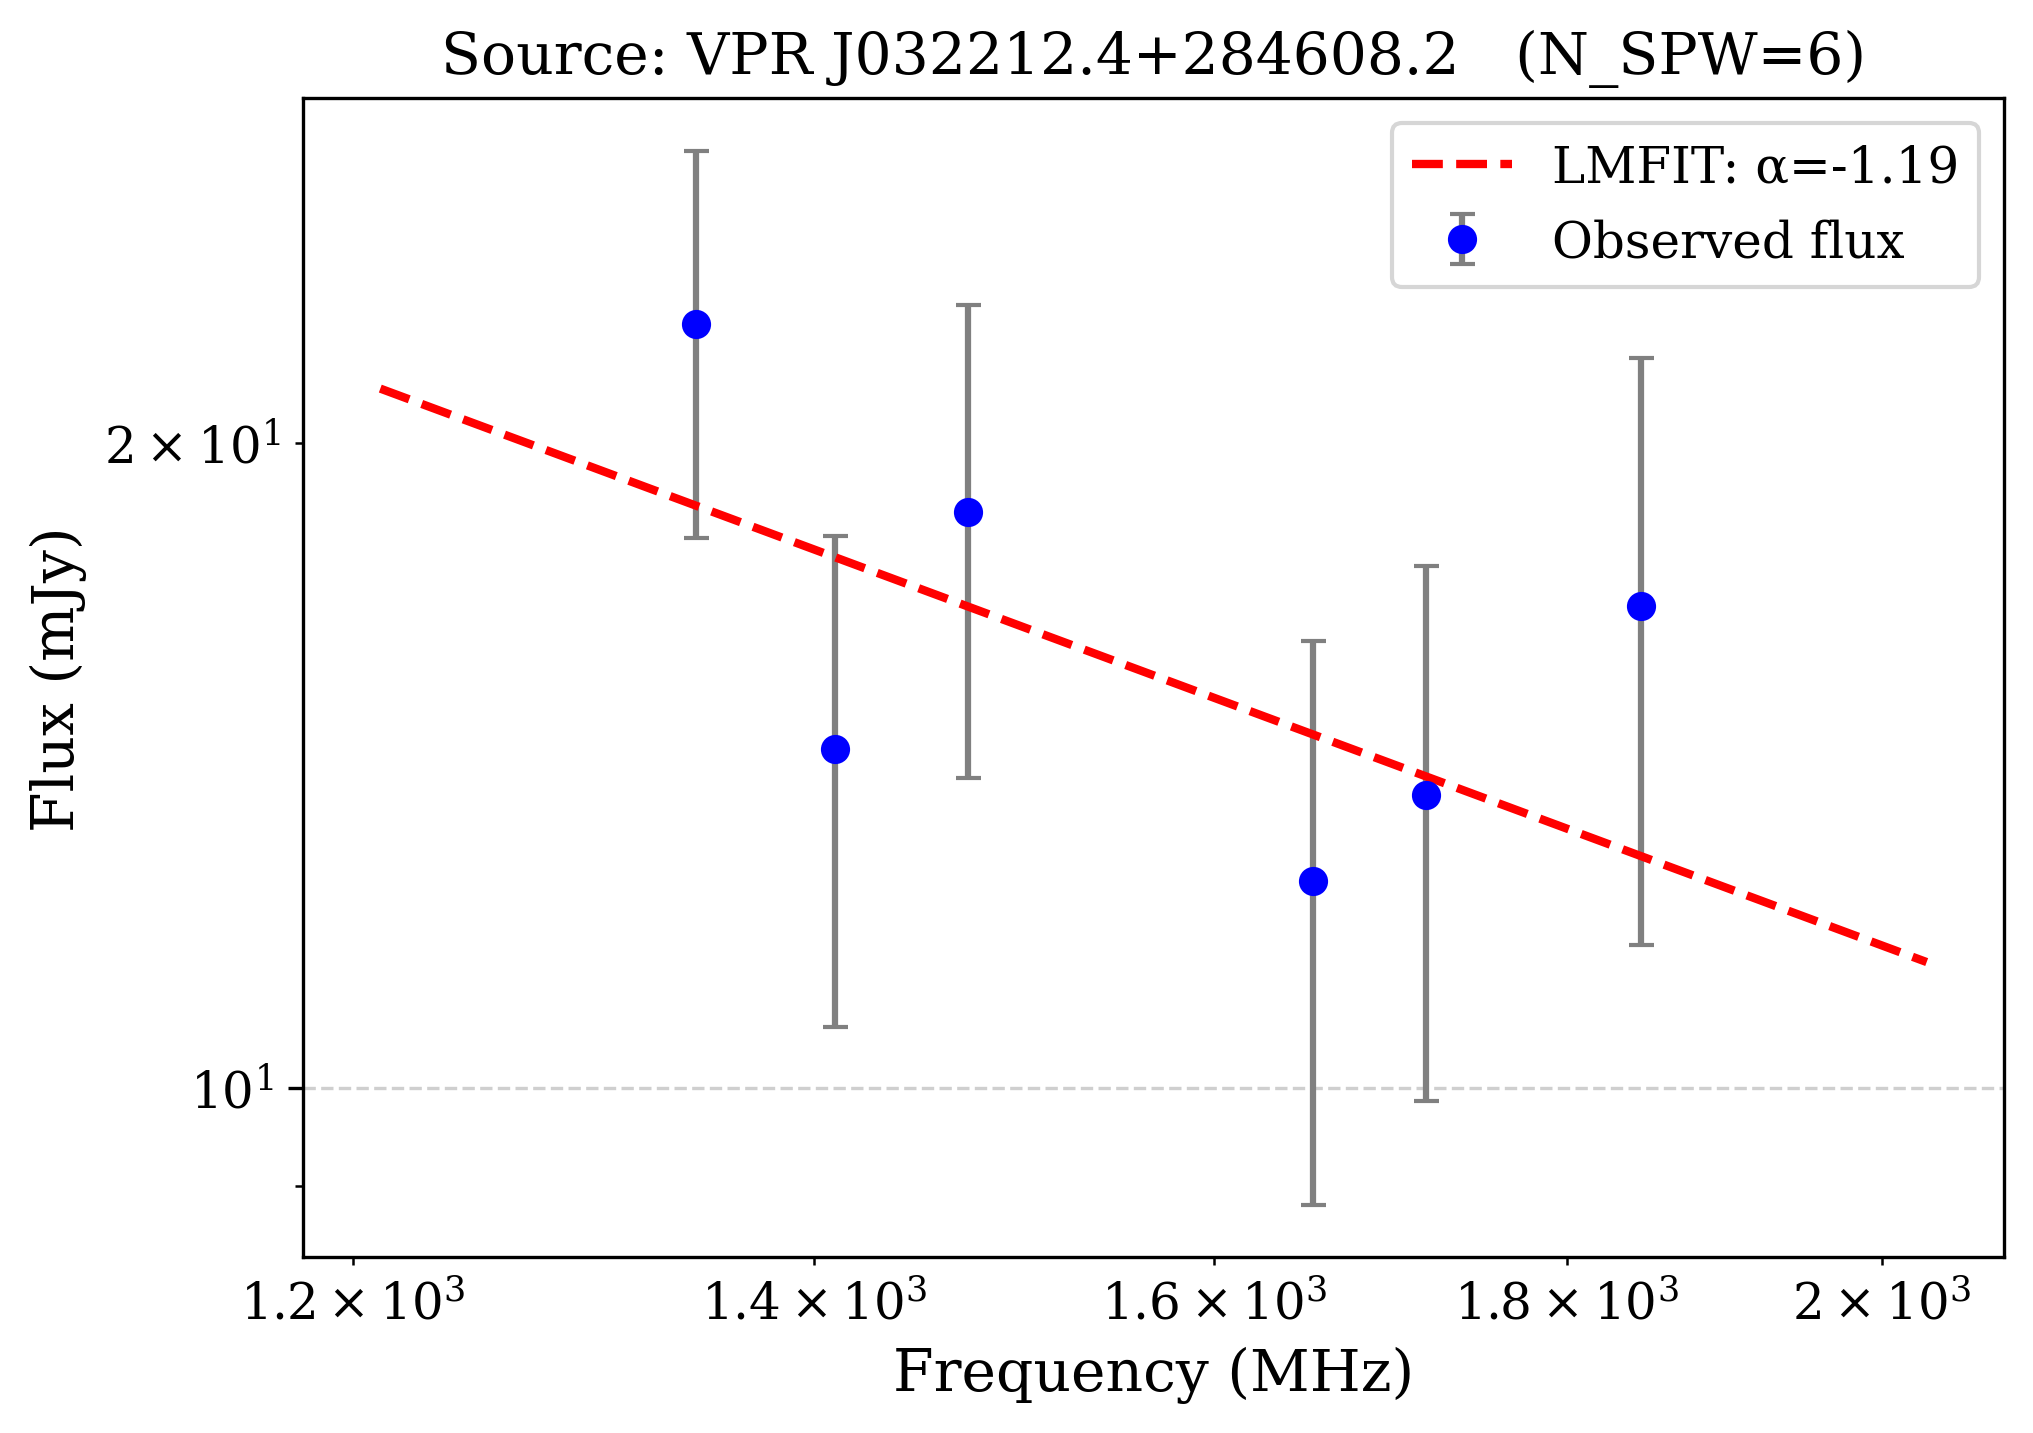

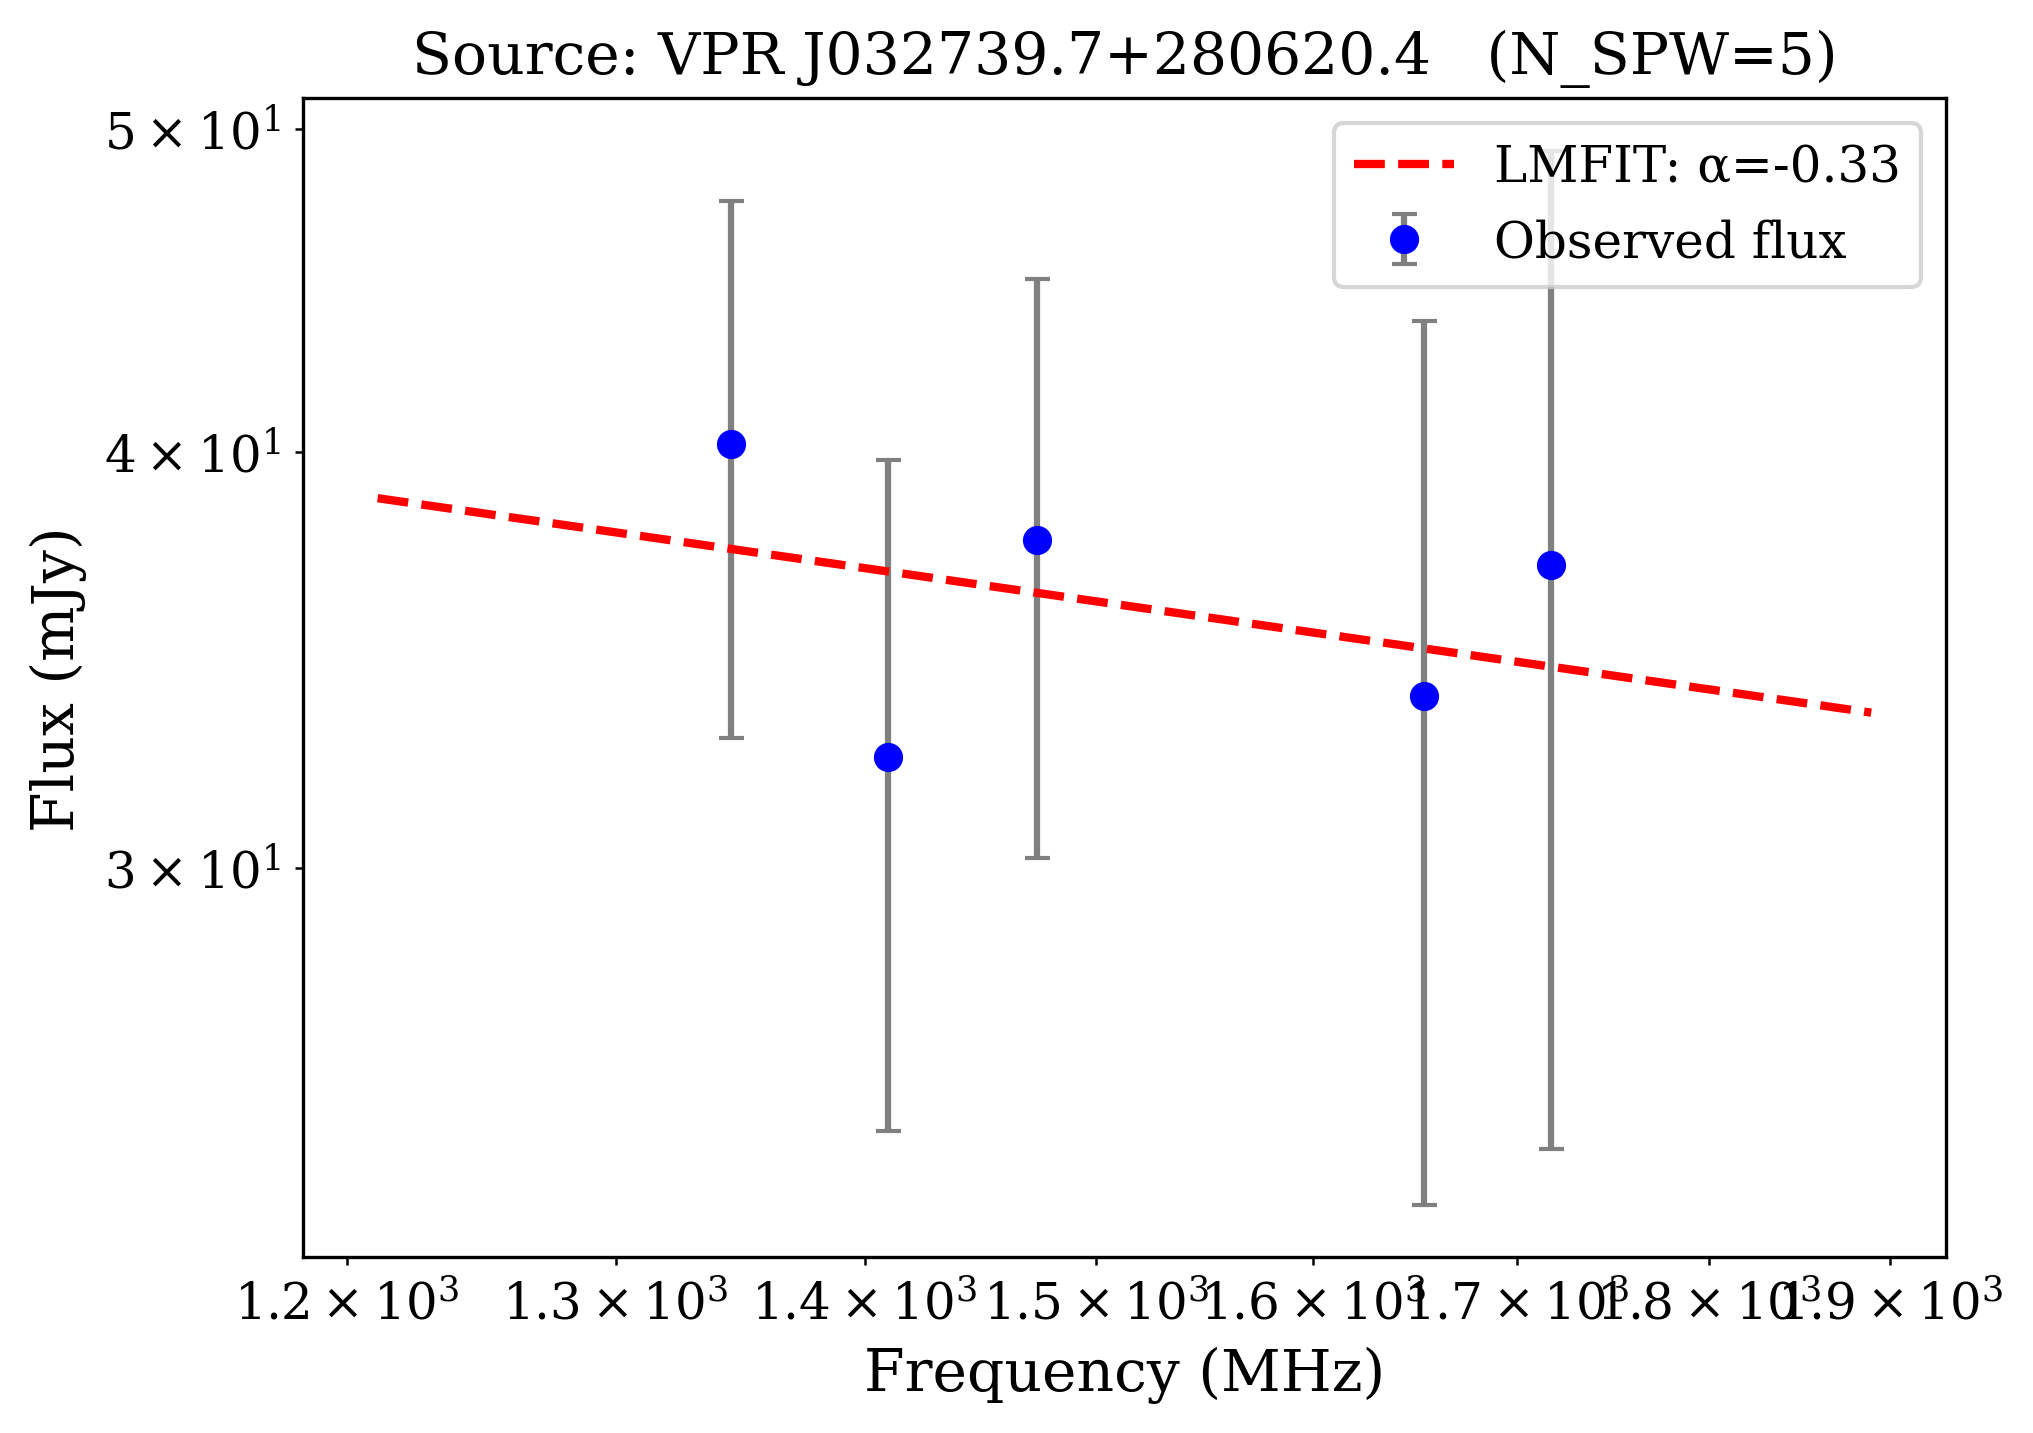

In [12]:
# ======================================
# CELL: PLOT RANDOM GOOD-FIT SOURCES
# Log(flux) vs Log(freq) + LMFIT model
# ======================================

import numpy as np
import matplotlib.pyplot as plt

N_PLOTS = 5  # how many random sources to plot

# Pick random good sources
rnd_sources = alpha_good_lmfit.sample(N_PLOTS, random_state=150)

for _, src in rnd_sources.iterrows():
    sid = src["Source_ID"]

    # get the wide table row for this source
    row = df_sel[df_sel["Source_ID"] == sid].iloc[0]

    # extract observed spectrum
    freqs, fluxes, errors = extract_spectrum(row)

    # skip if something is wrong
    if len(freqs) < 2:
        continue

    # === lmfit results ===
    A_fit     = src["A_lmfit"]
    alpha_fit = src["alpha_lmfit"]

    # model curve (smooth)
    nu_model = np.linspace(min(freqs)*0.9, max(freqs)*1.1, 200)
    S_model  = power_law(nu_model, A_fit, alpha_fit)

    # === Plot in log-log space ===
    plt.figure(figsize=(7, 5))
    
    plt.errorbar(
        freqs,
        fluxes,
        yerr=errors,
        fmt='o',
        color='blue',
        ecolor='gray',
        label='Observed flux',
        capsize=3
    )

    plt.plot(
        nu_model,
        S_model,
        'r--',
        linewidth=2,
        label=f"LMFIT: α={alpha_fit:.2f}"
    )

    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Flux (mJy)")
    plt.title(f"Source: {sid}   (N_SPW={src['N_SPW_used']})")

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


Number of sources with -3 ≤ alpha ≤ -2: 16


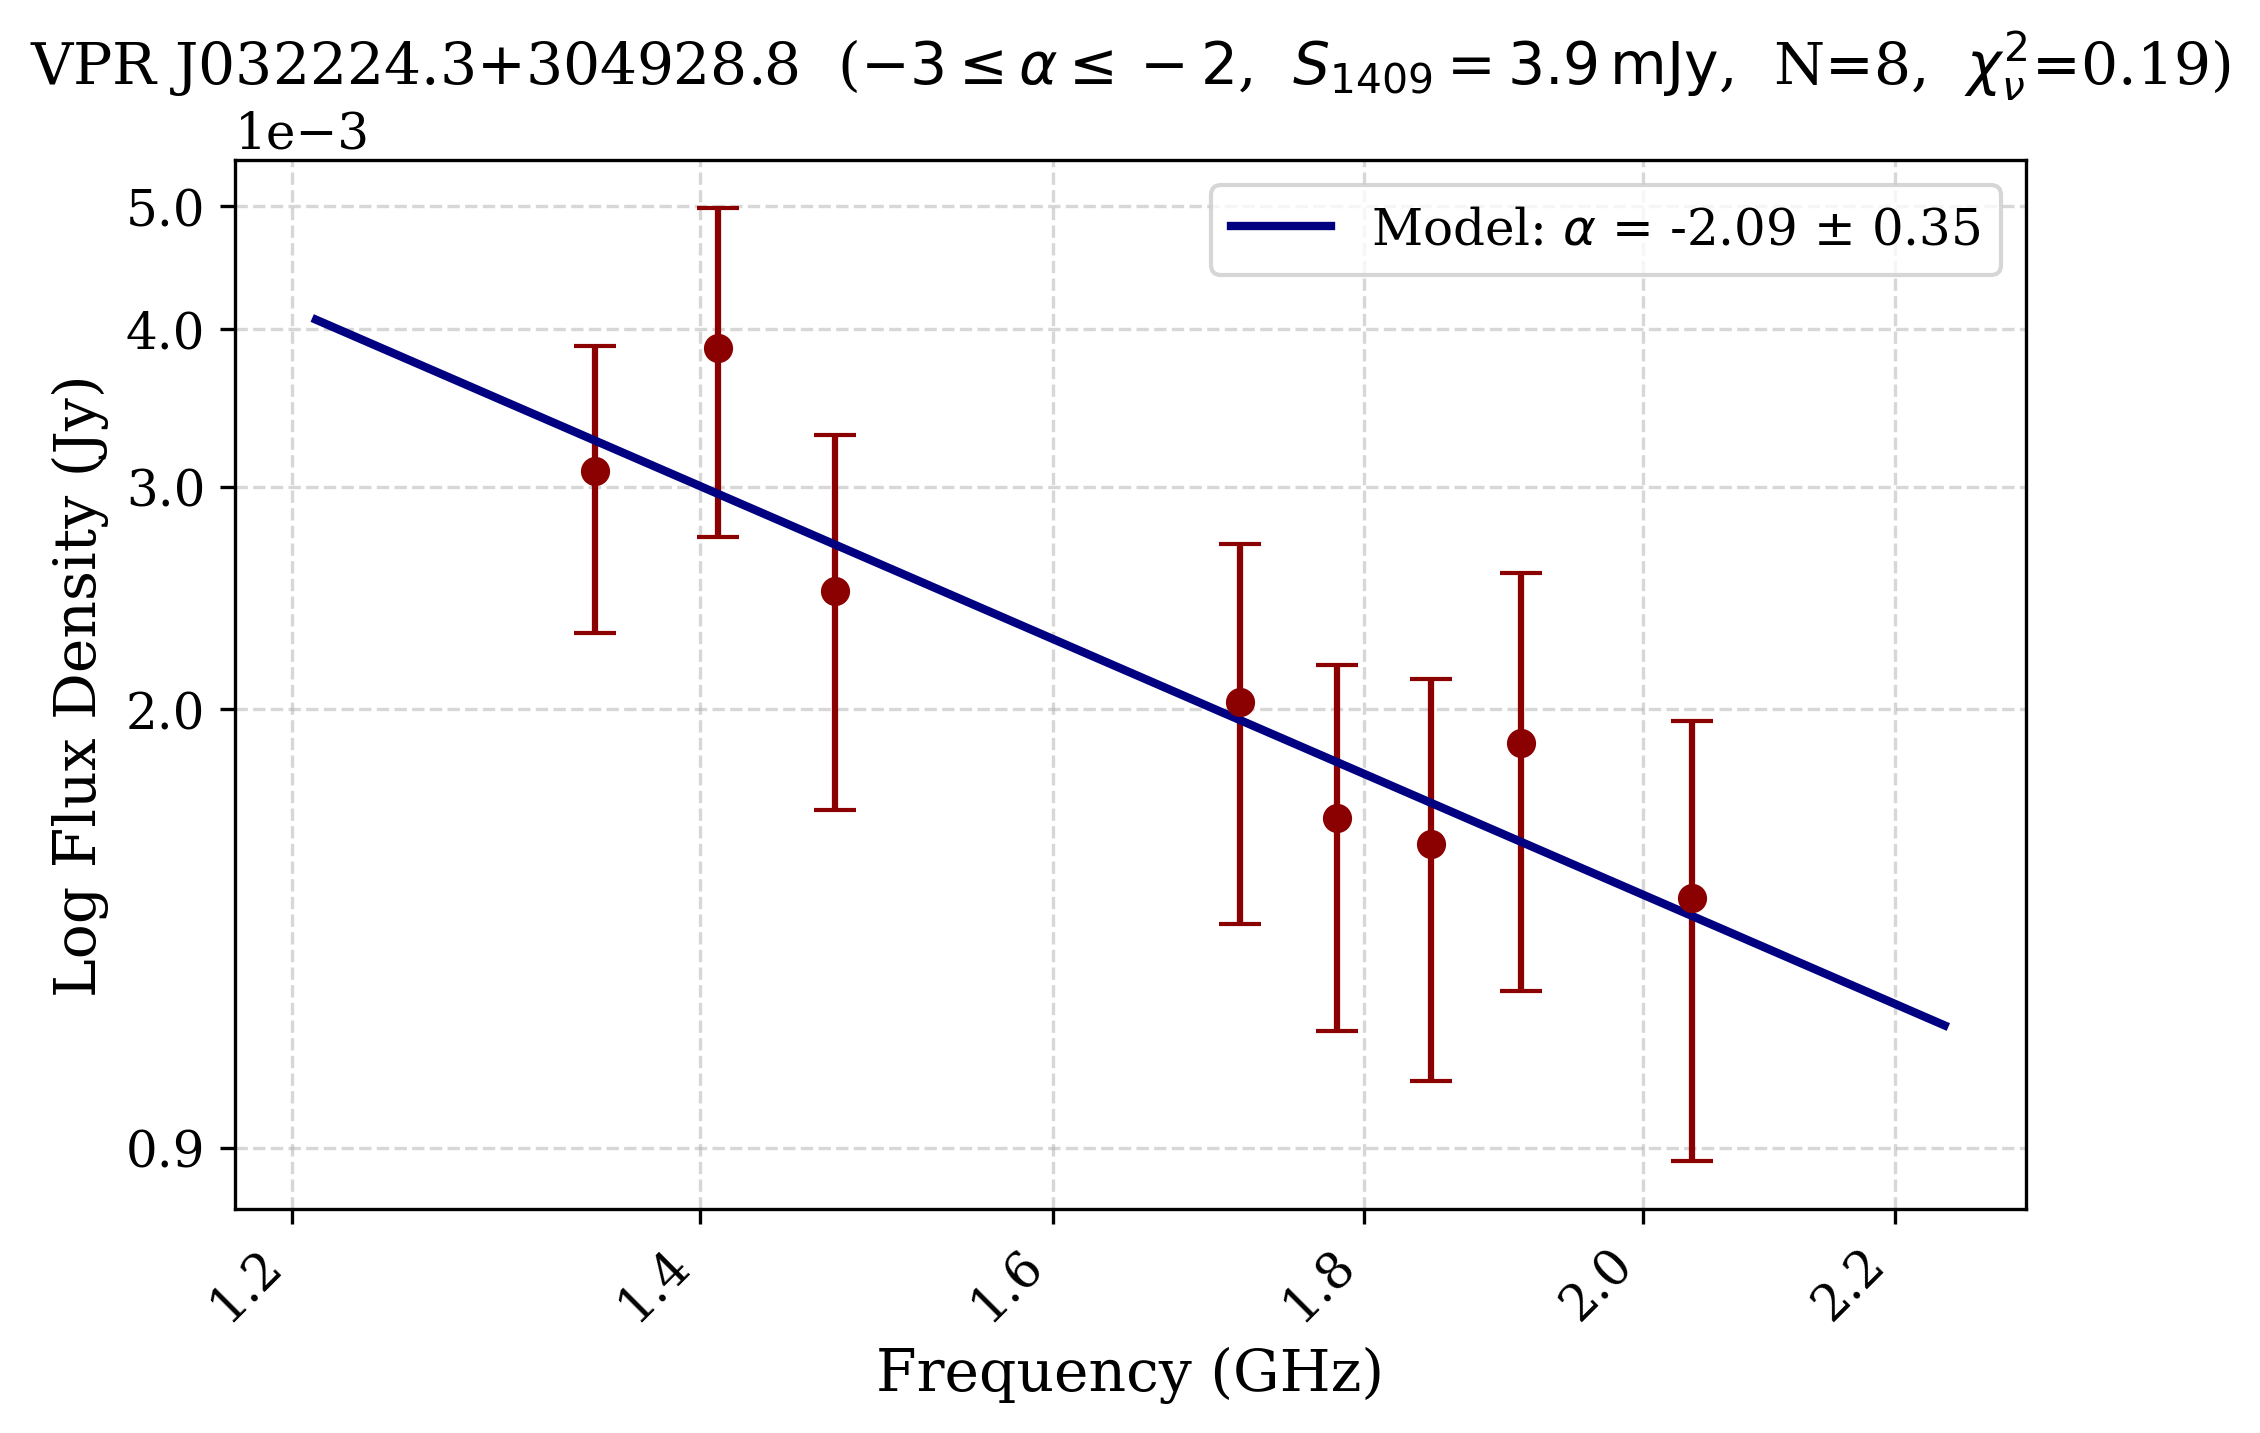

✅ Saved: ../paper1/figs/steep_spectra_alpha_-3_-2/VPR_J032224.3+304928.8_spectrum.pdf


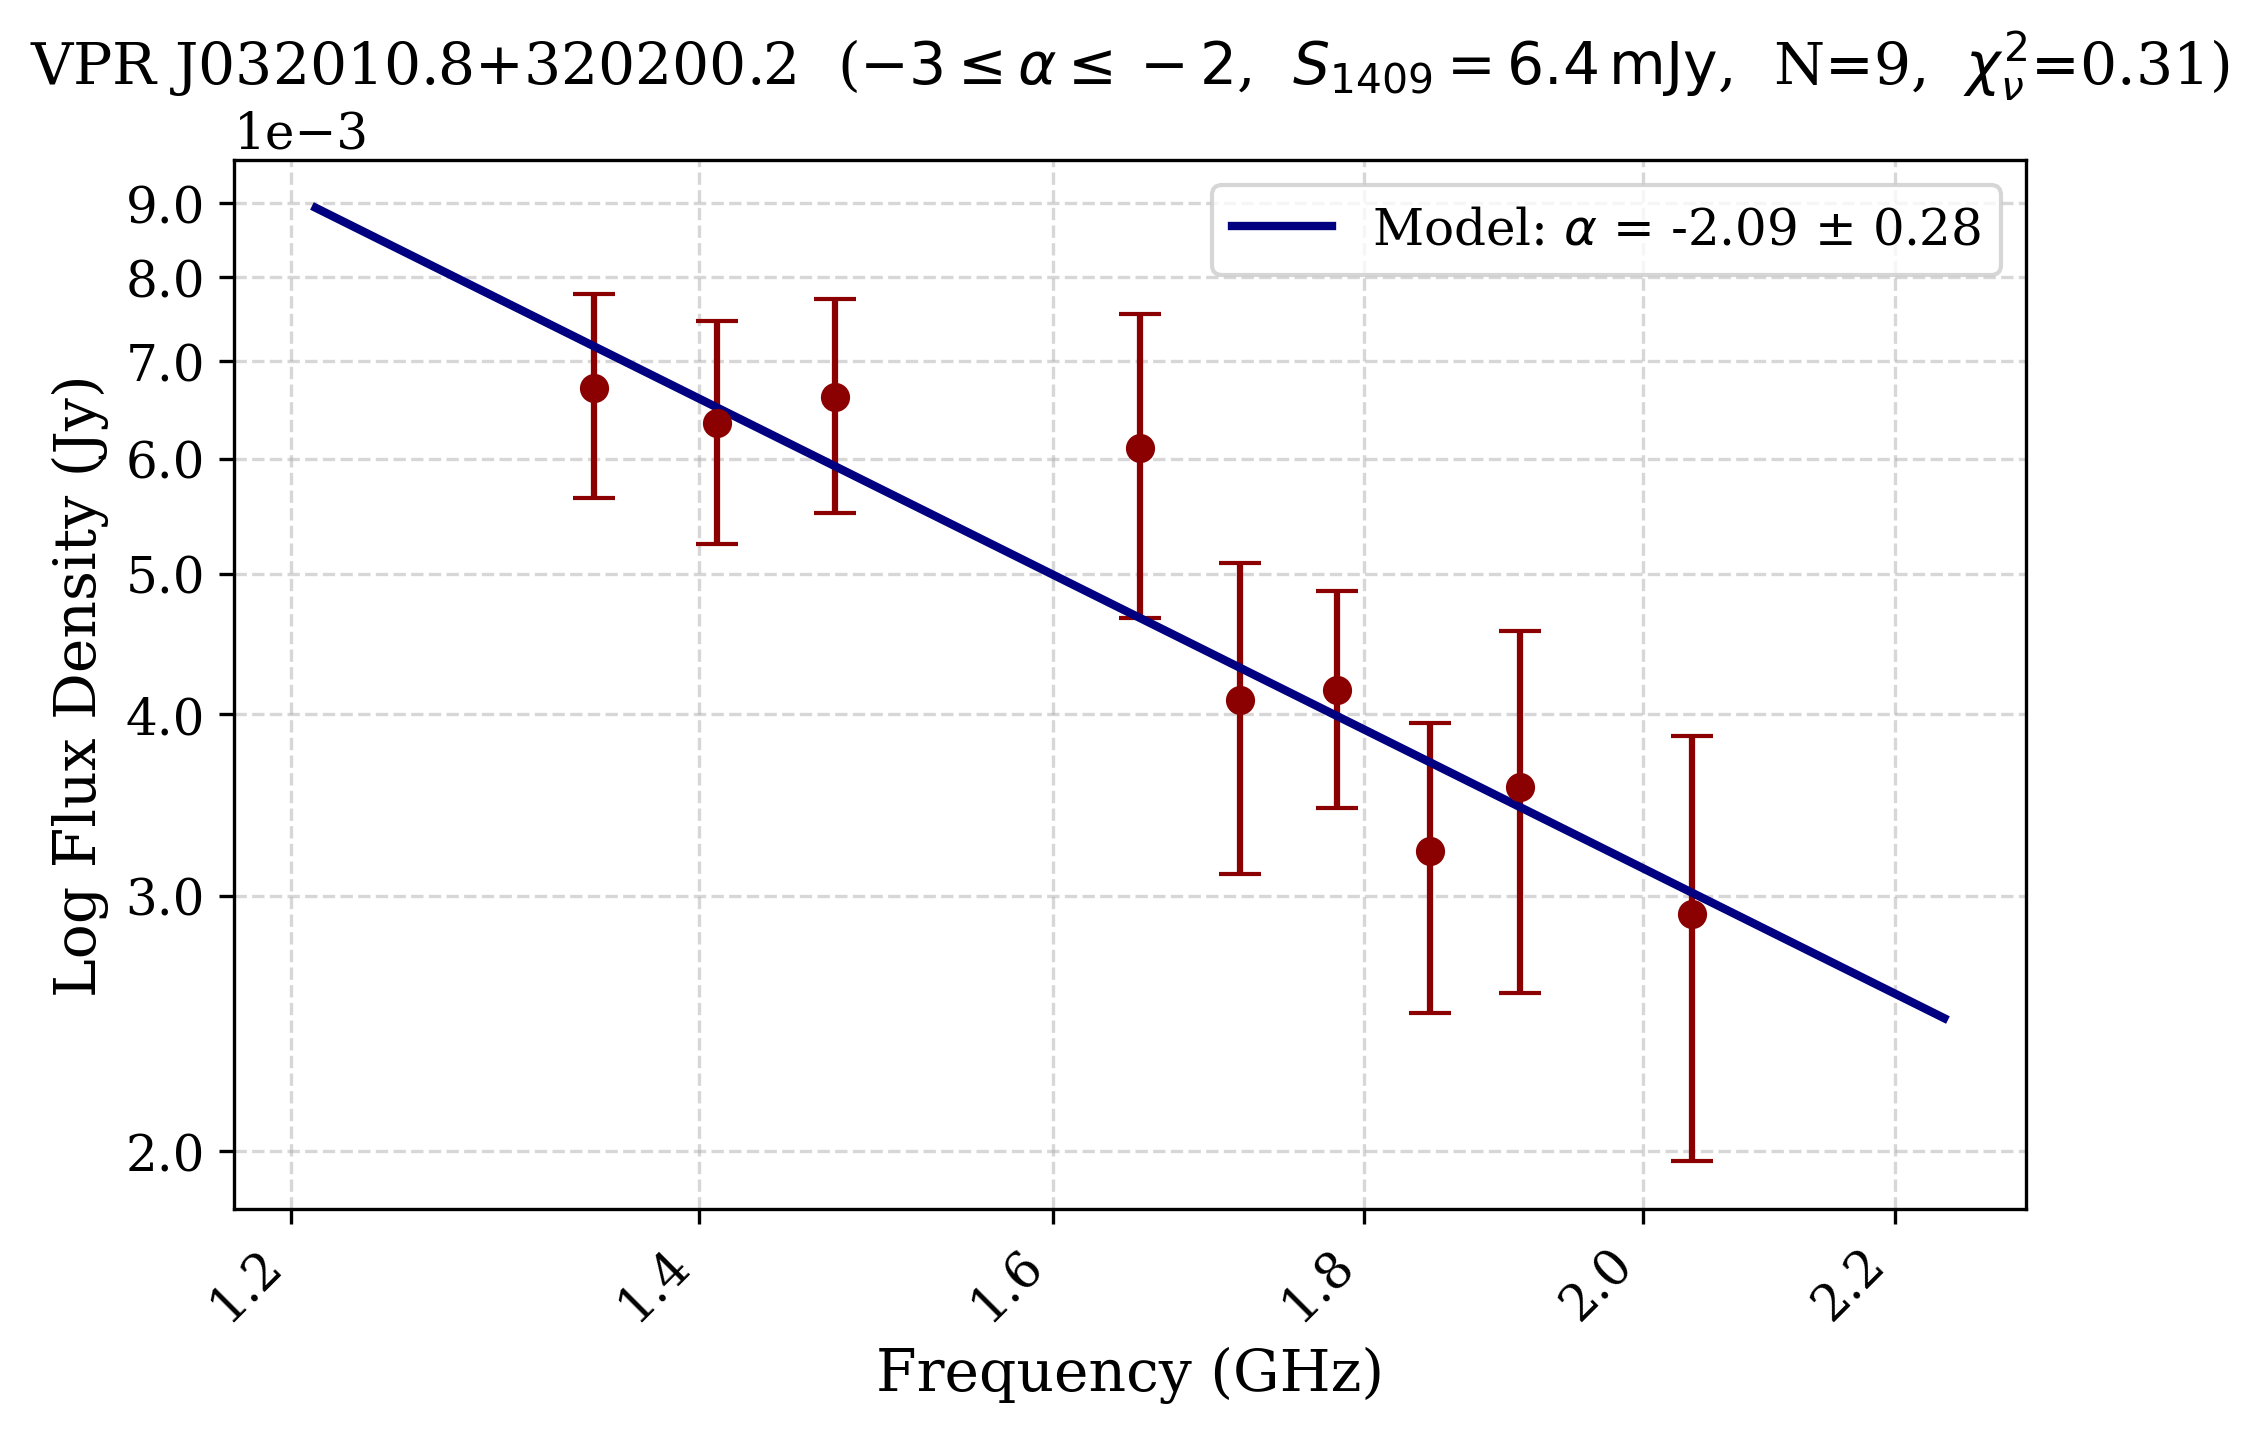

✅ Saved: ../paper1/figs/steep_spectra_alpha_-3_-2/VPR_J032010.8+320200.2_spectrum.pdf


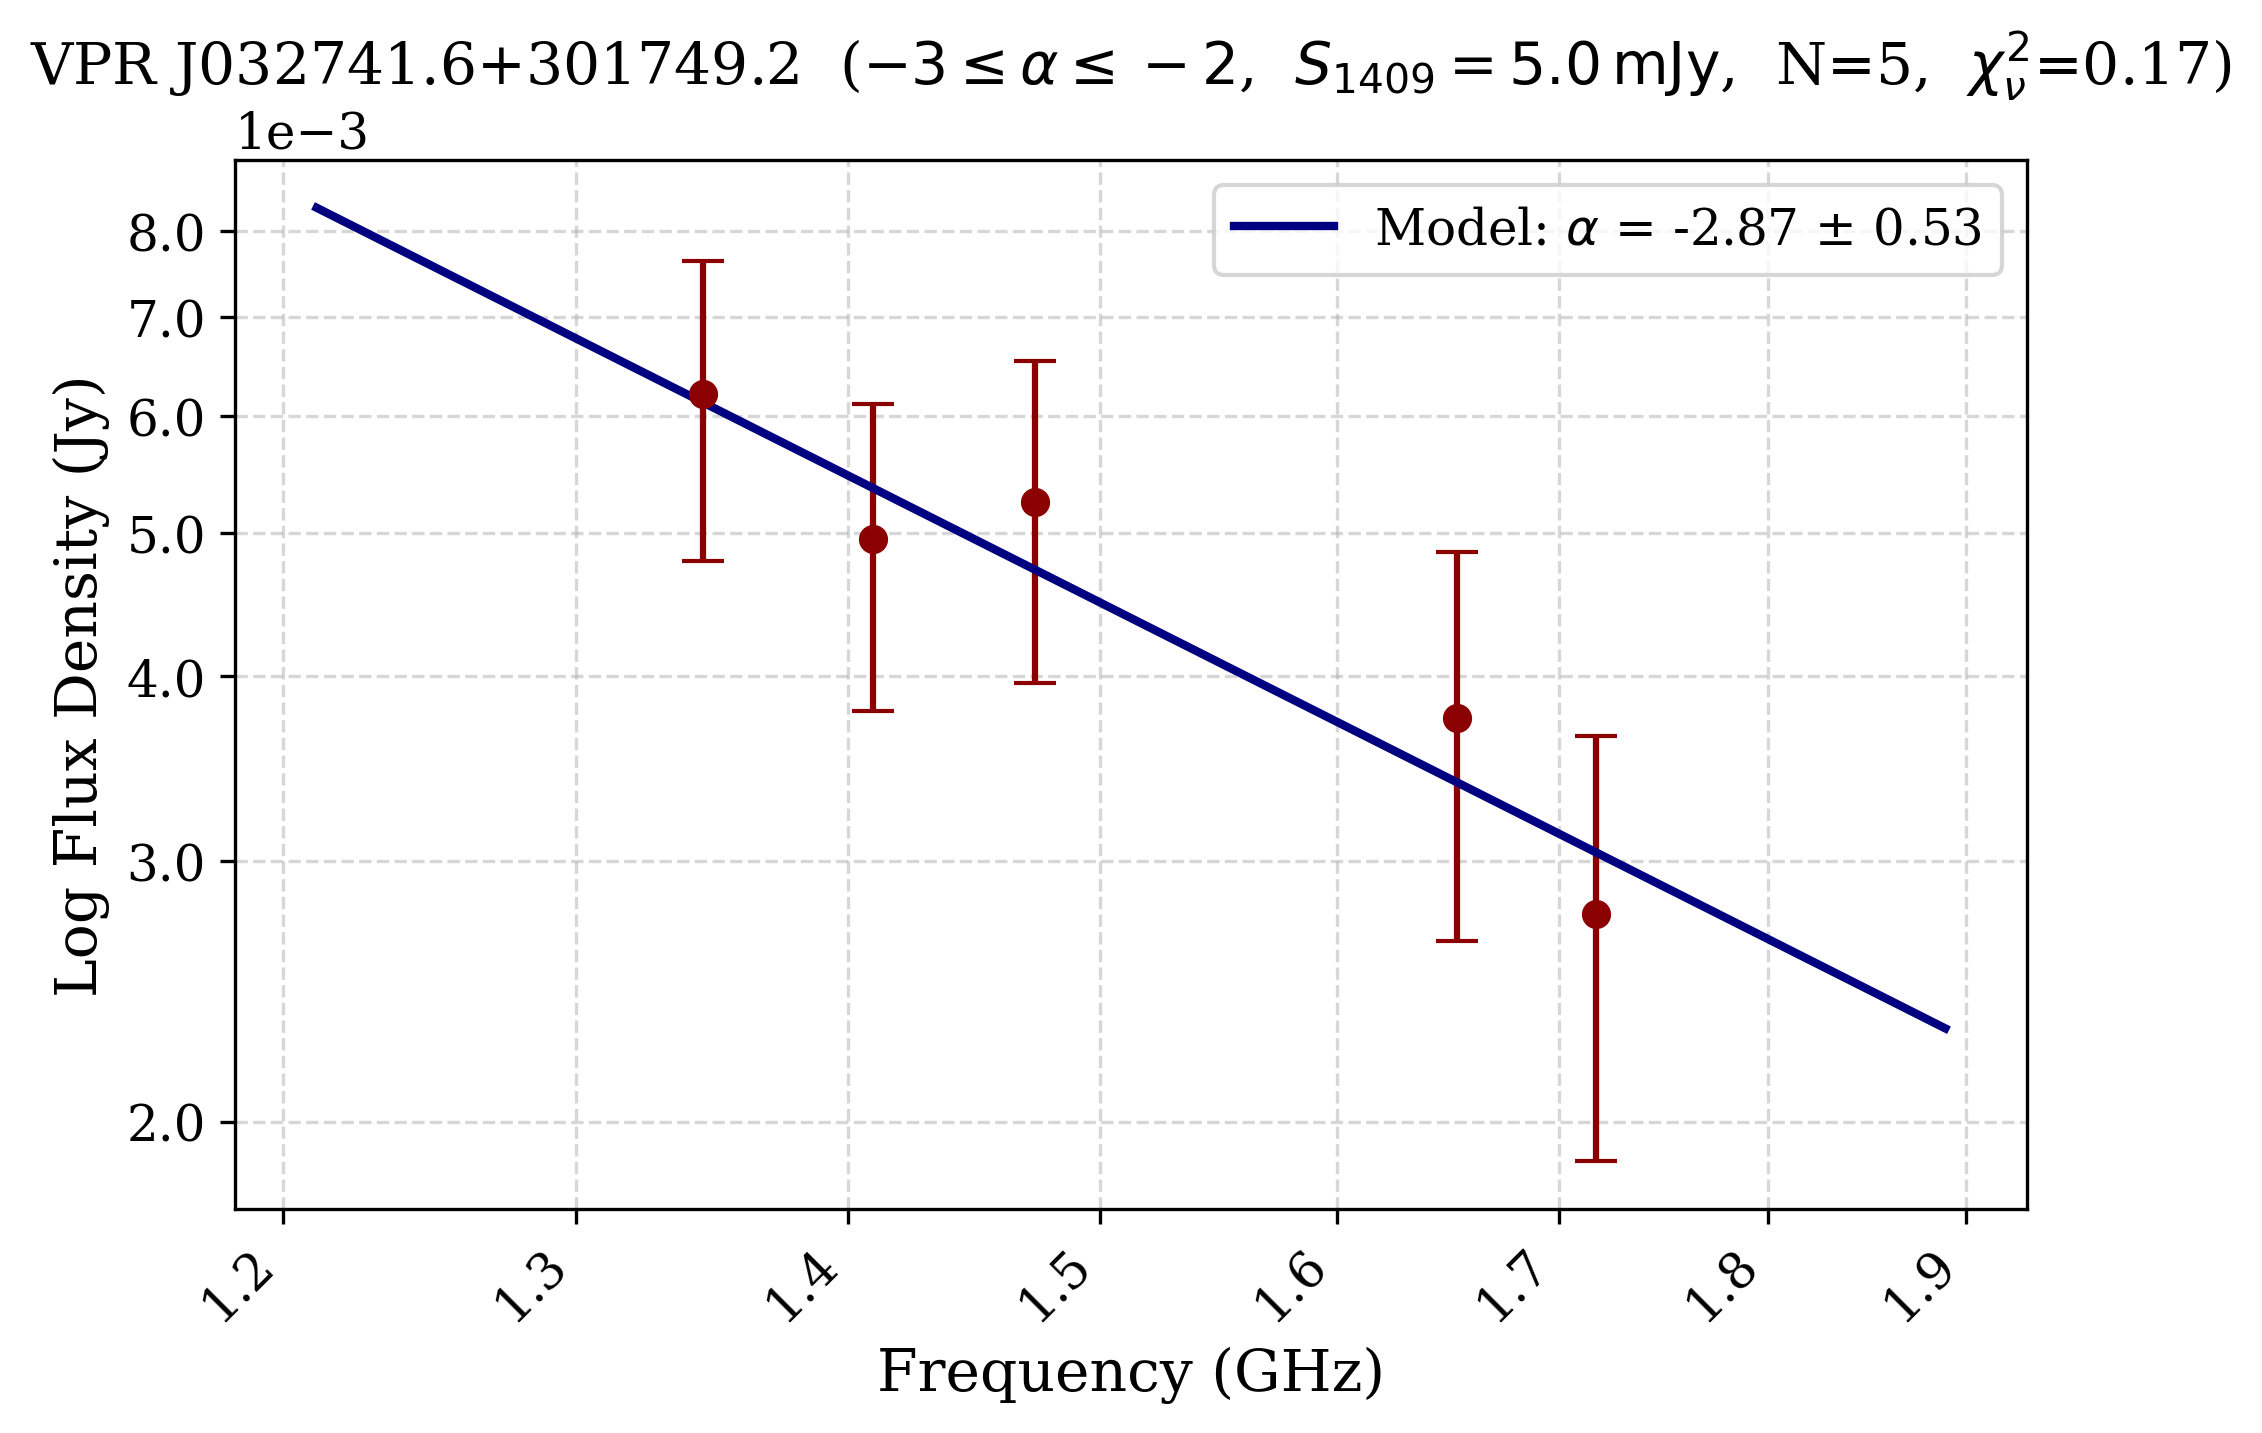

✅ Saved: ../paper1/figs/steep_spectra_alpha_-3_-2/VPR_J032741.6+301749.2_spectrum.pdf


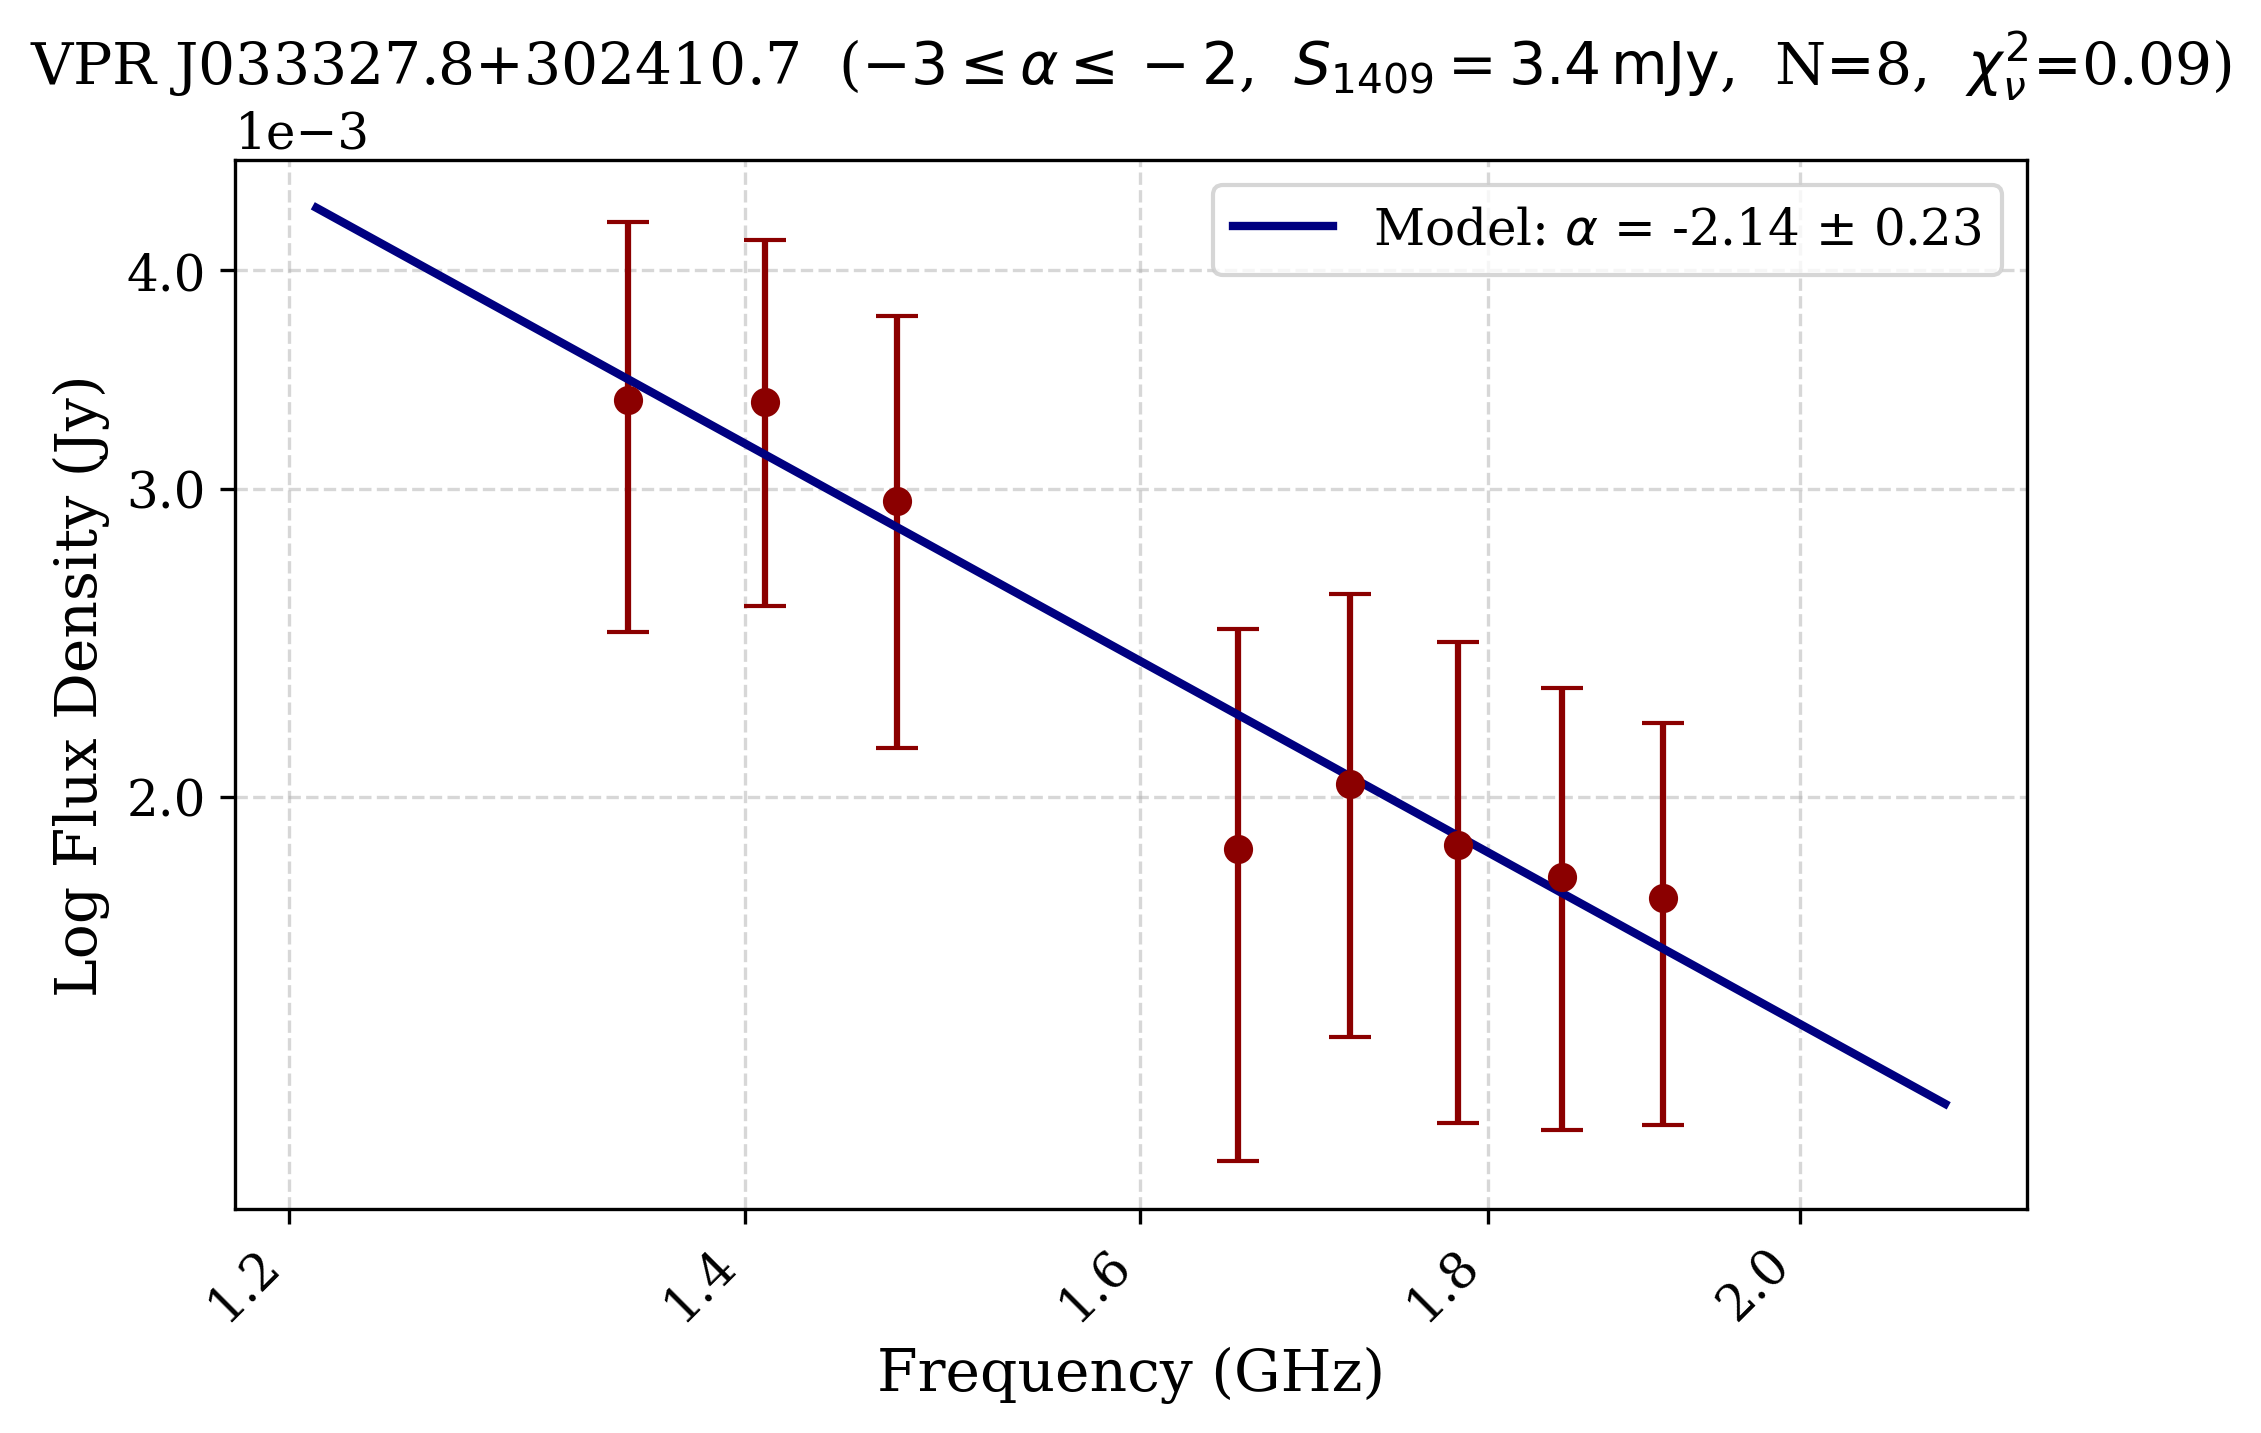

✅ Saved: ../paper1/figs/steep_spectra_alpha_-3_-2/VPR_J033327.8+302410.7_spectrum.pdf


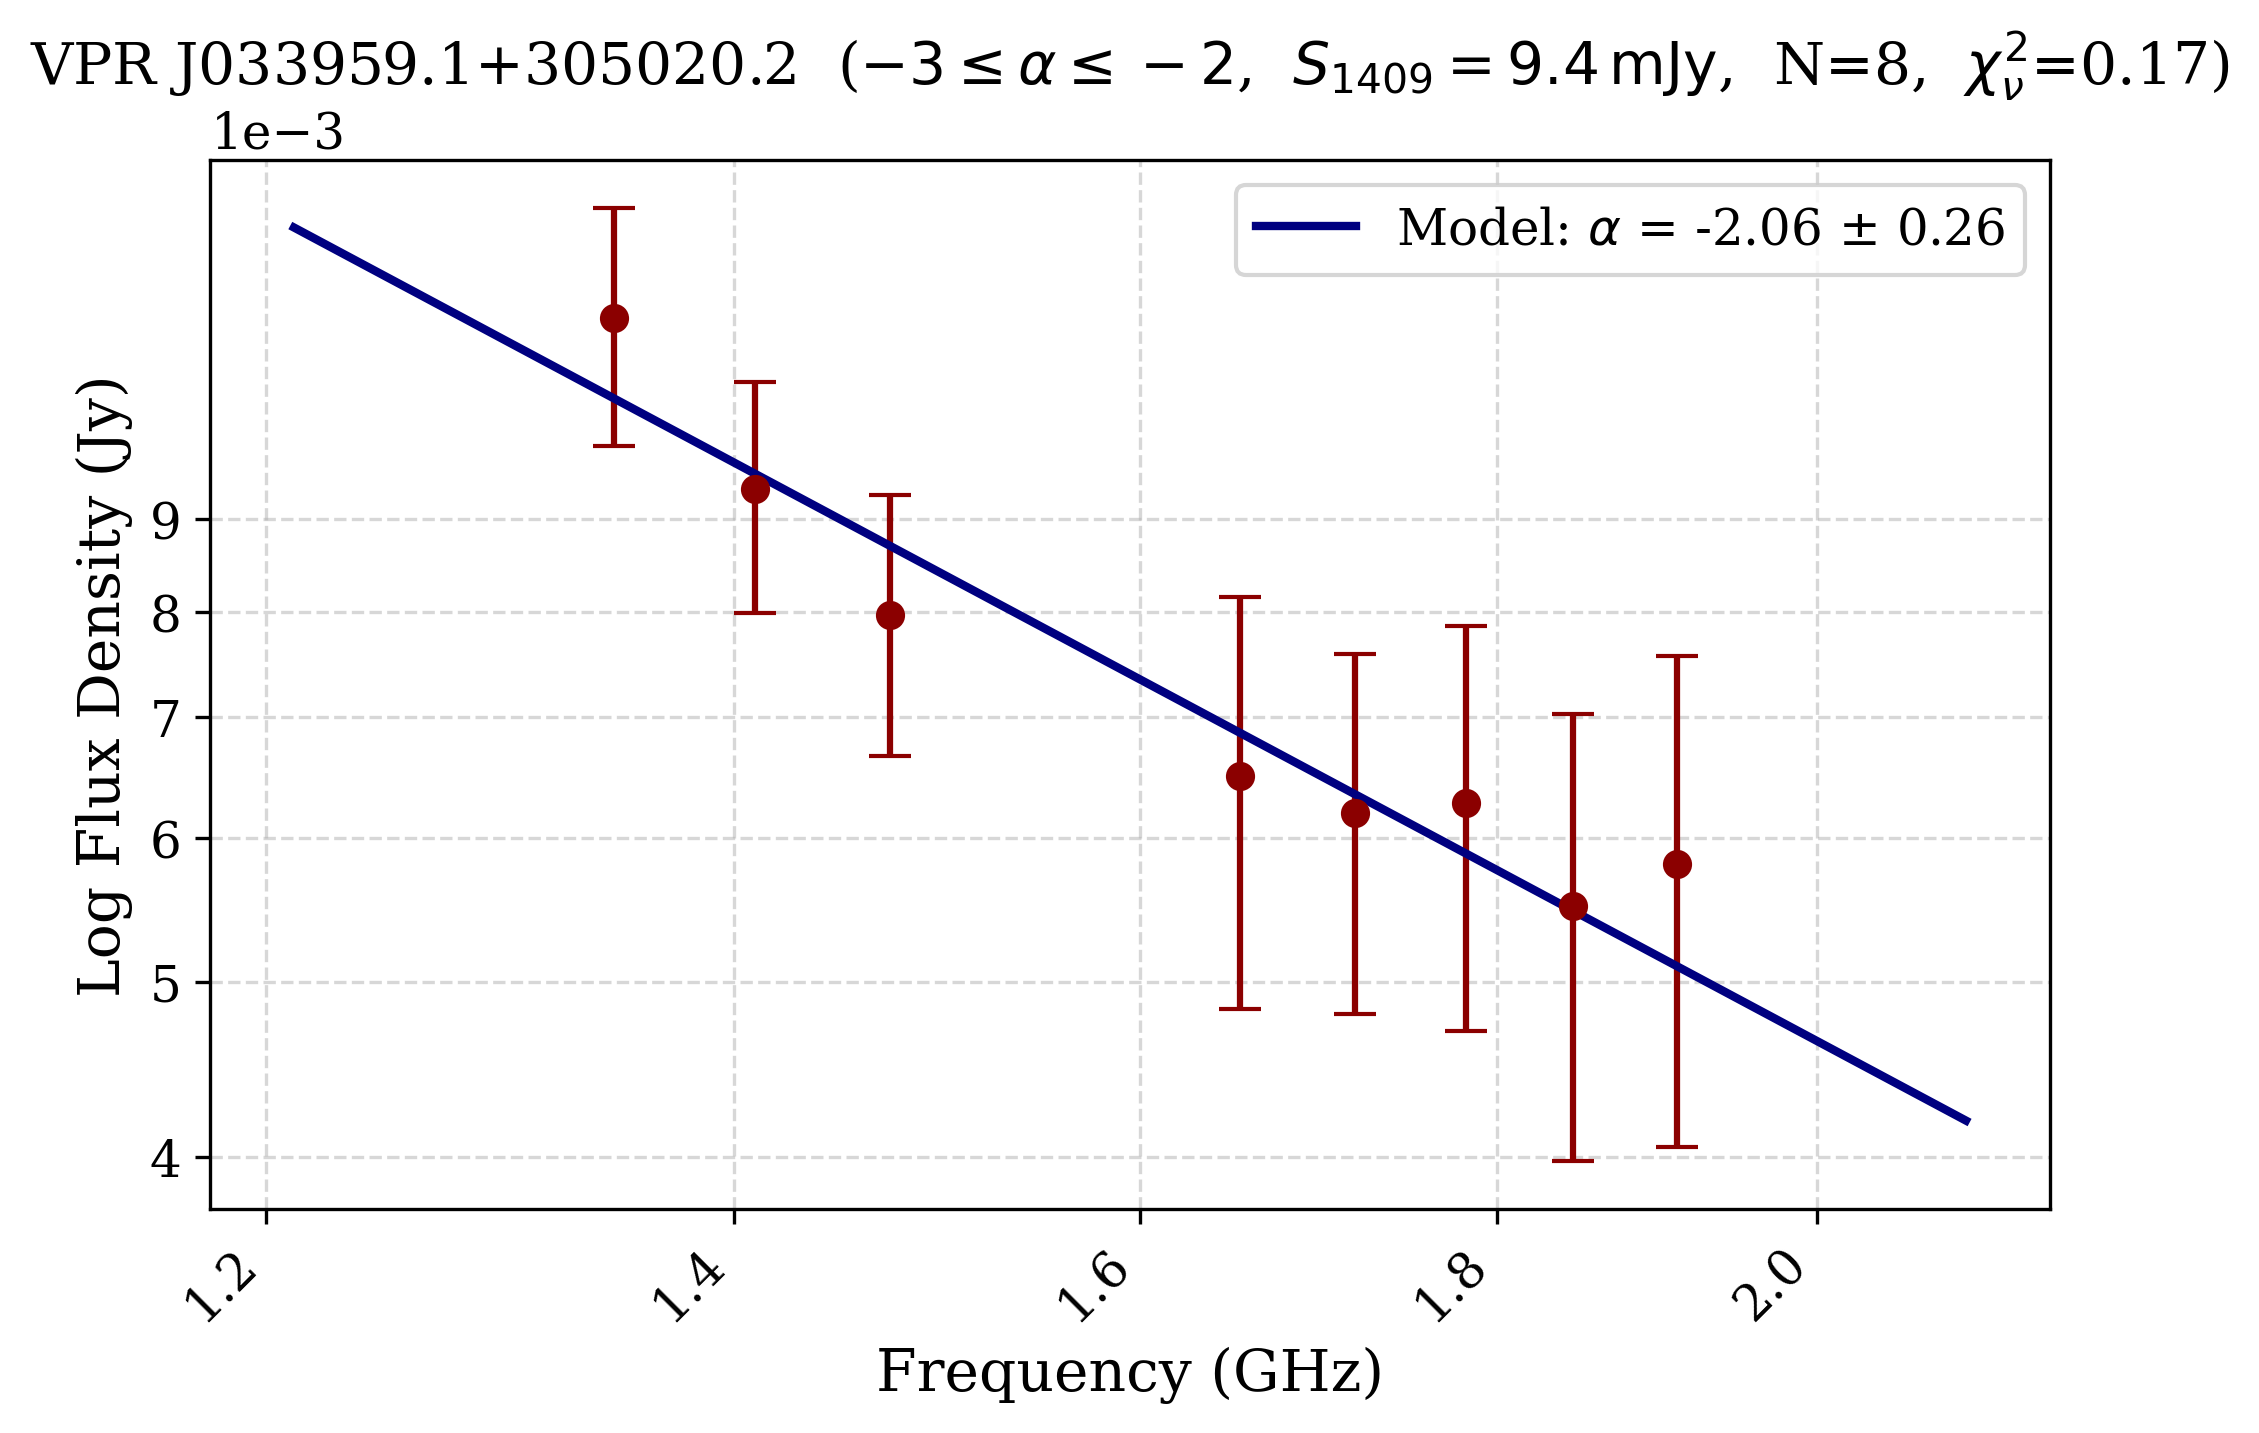

✅ Saved: ../paper1/figs/steep_spectra_alpha_-3_-2/VPR_J033959.1+305020.2_spectrum.pdf


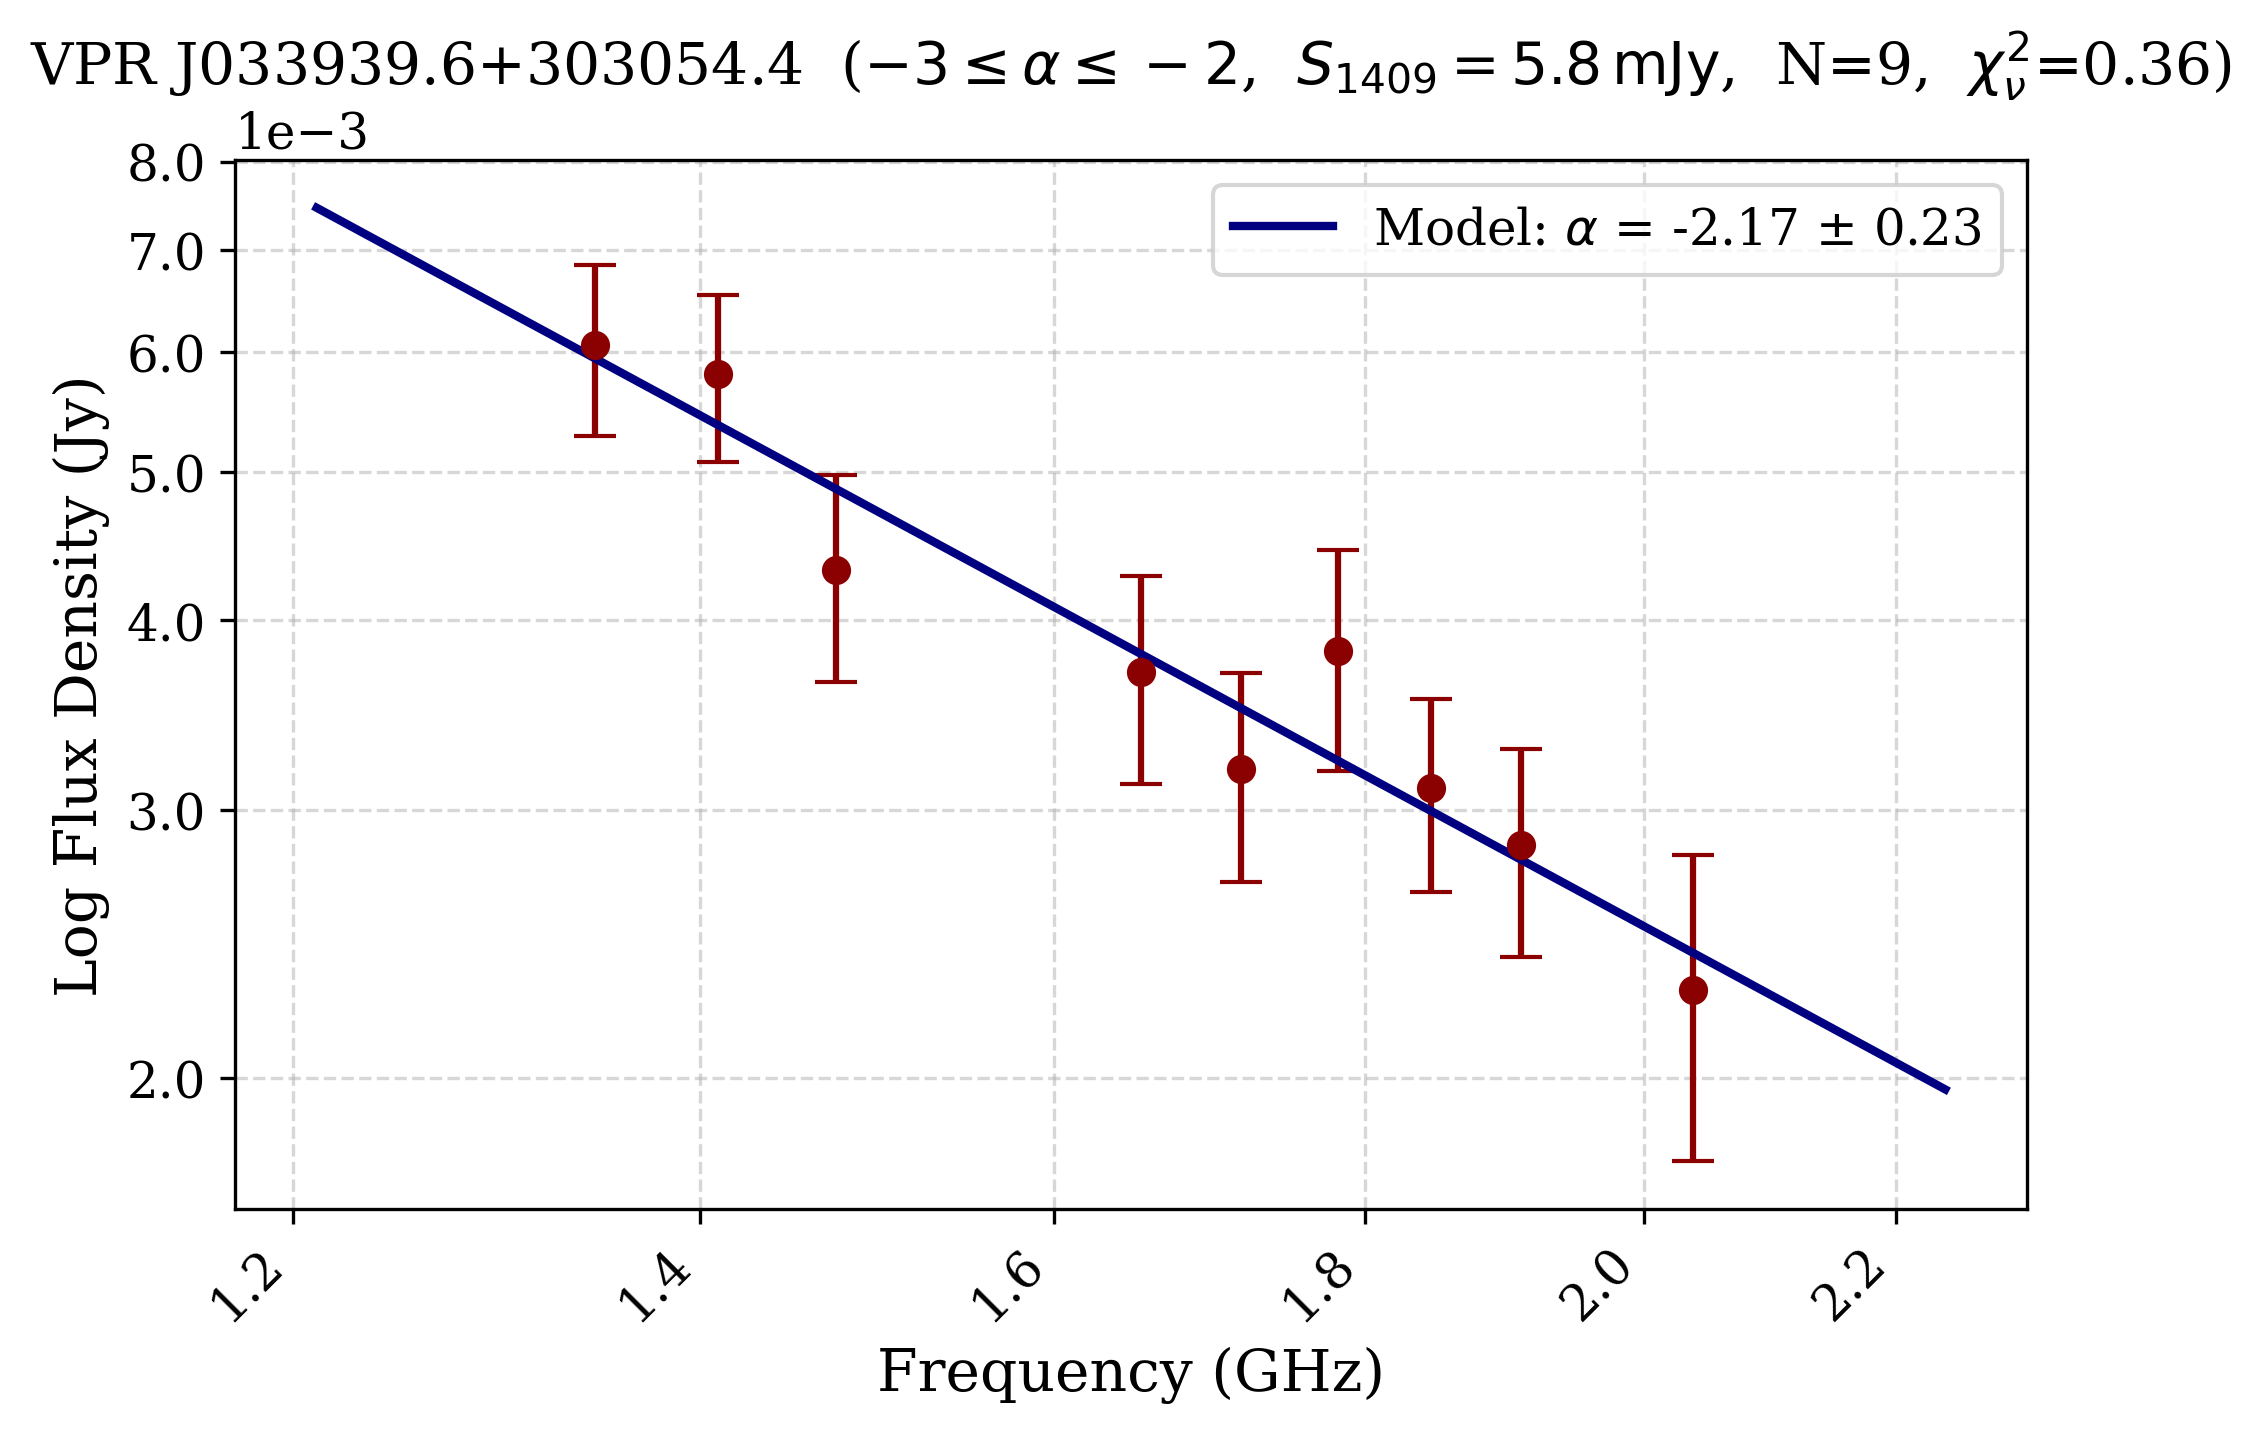

✅ Saved: ../paper1/figs/steep_spectra_alpha_-3_-2/VPR_J033939.6+303054.4_spectrum.pdf


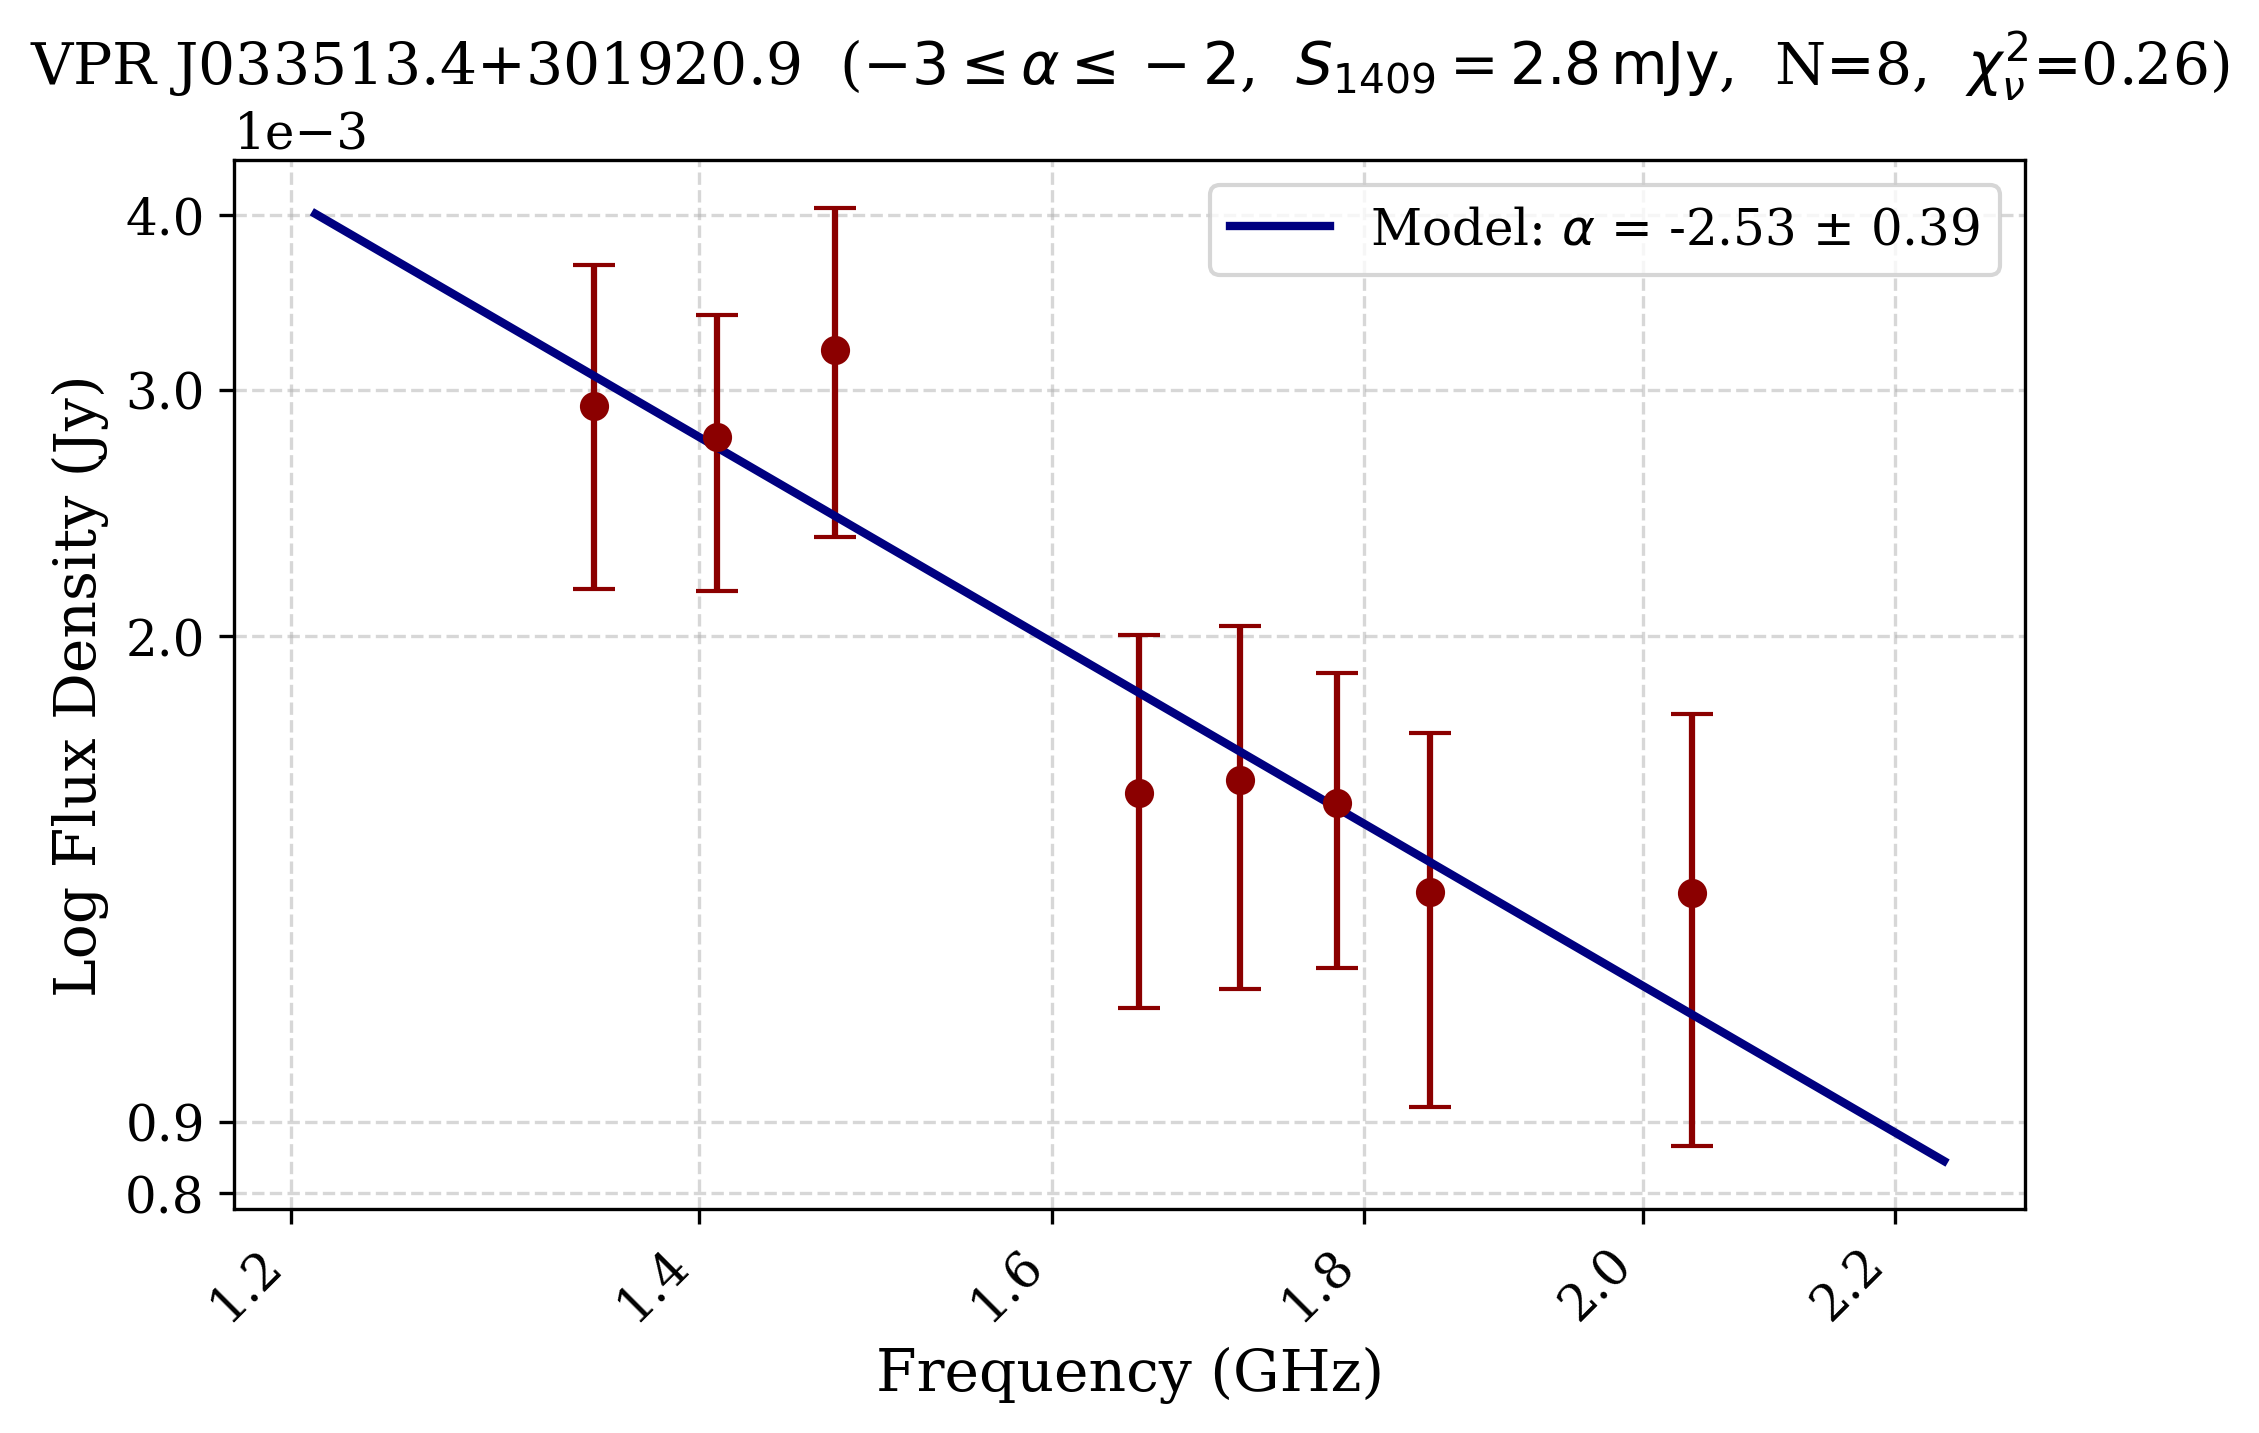

✅ Saved: ../paper1/figs/steep_spectra_alpha_-3_-2/VPR_J033513.4+301920.9_spectrum.pdf


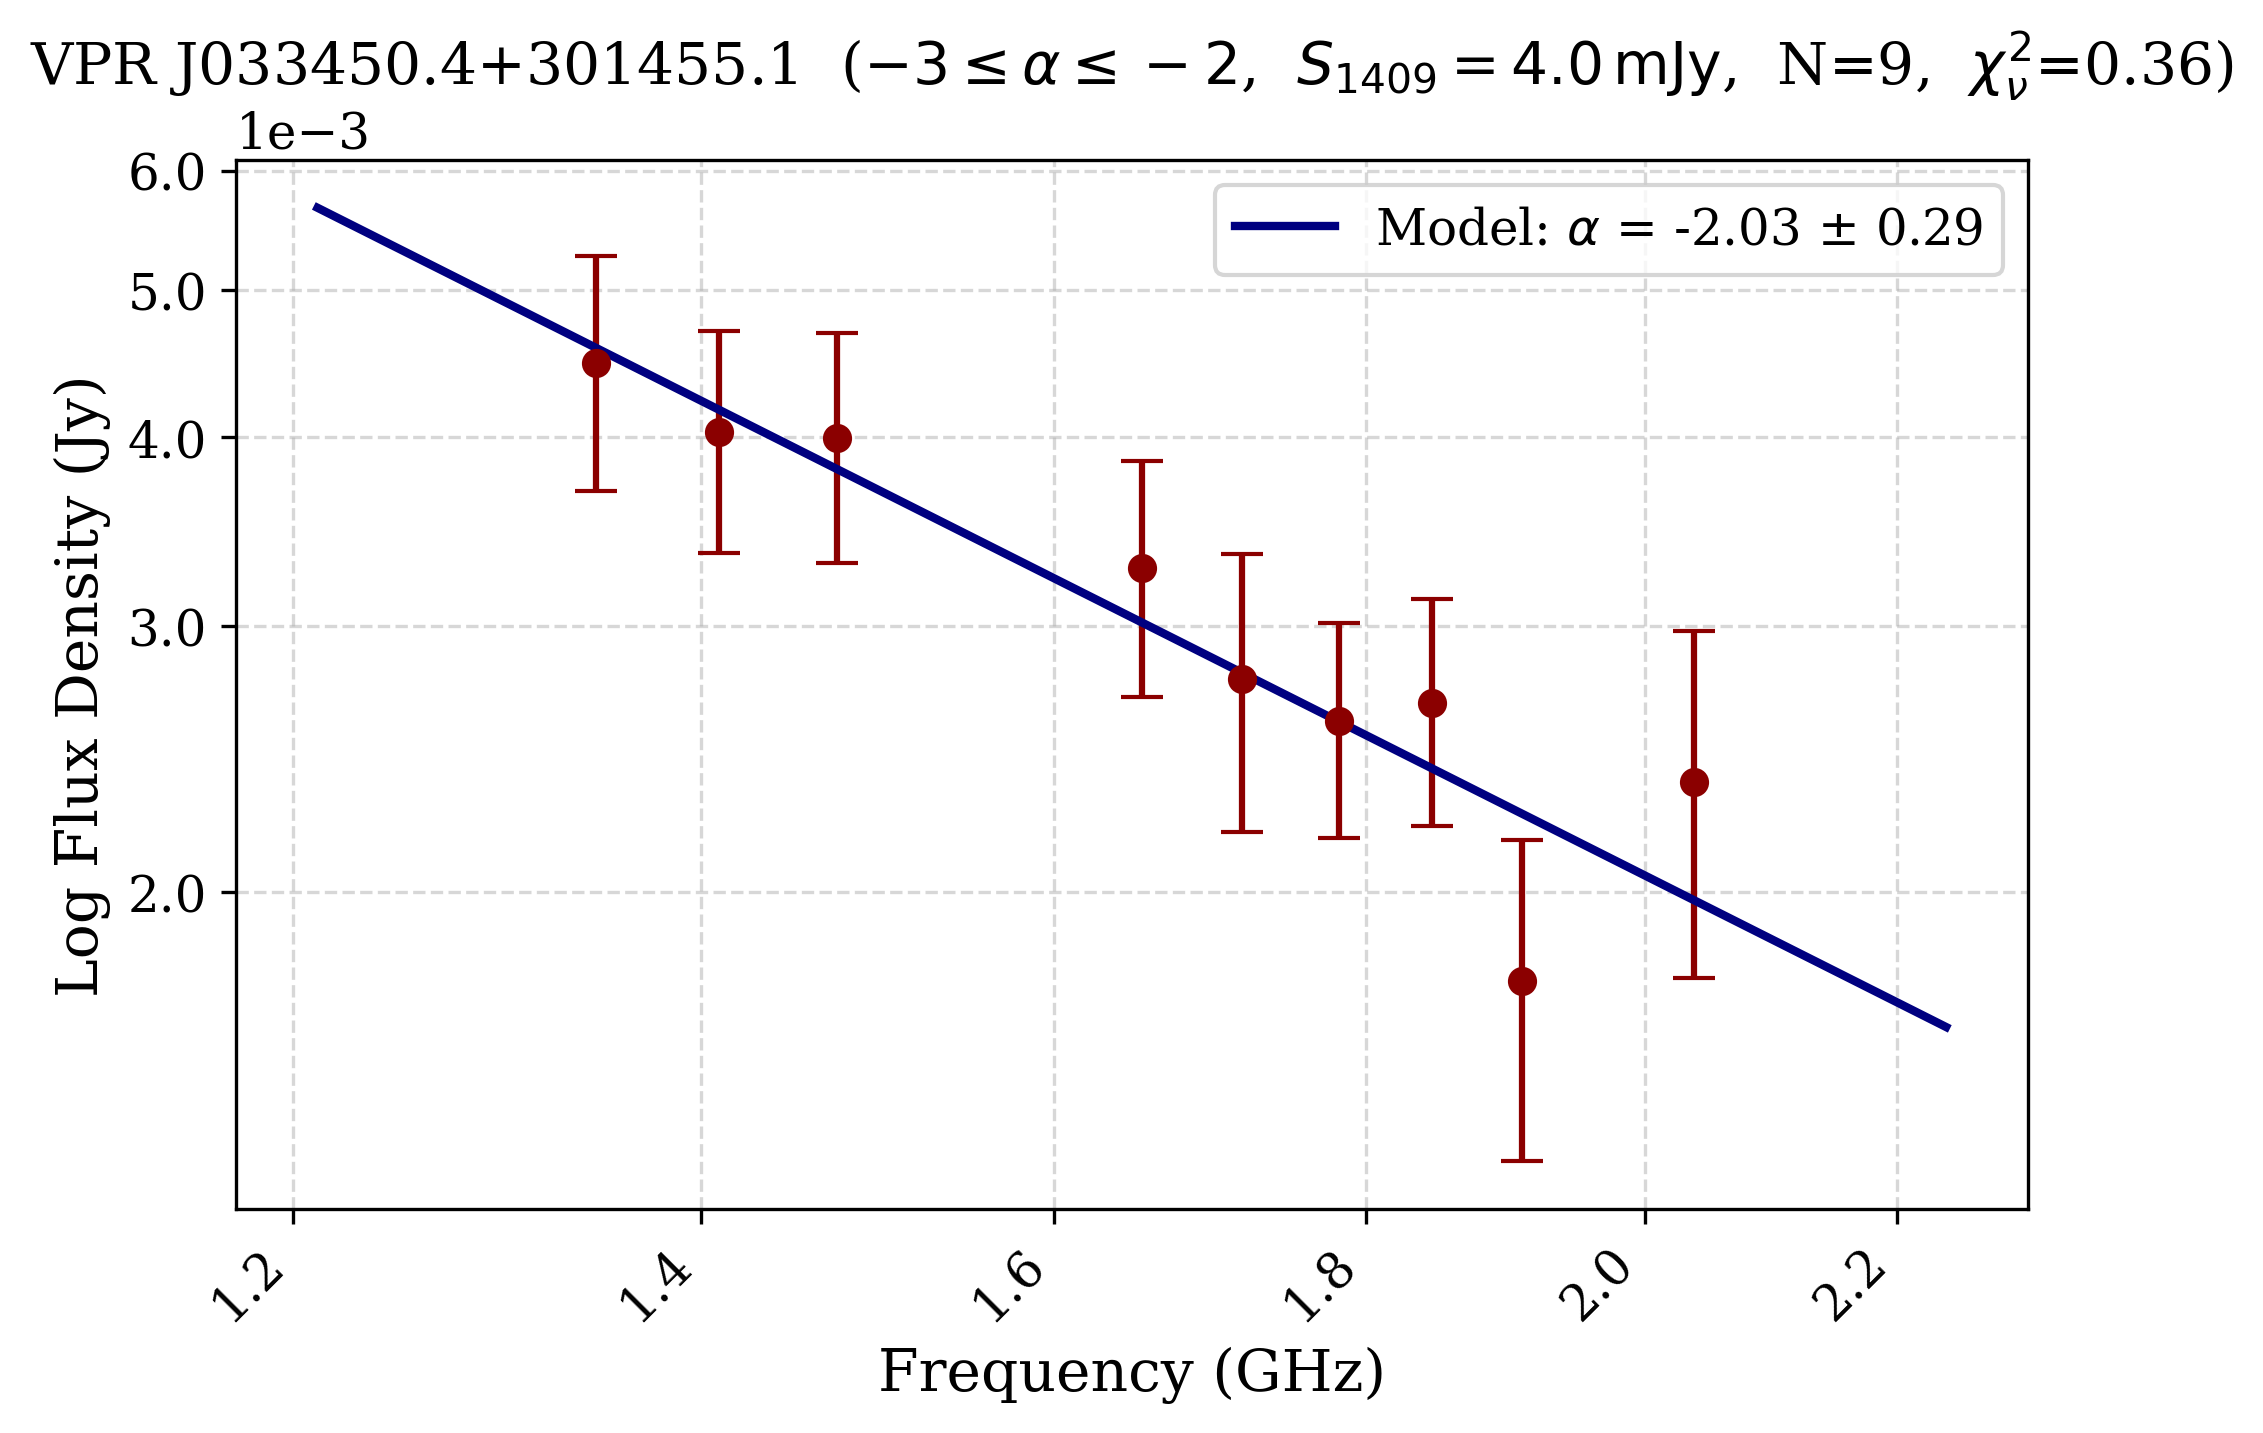

✅ Saved: ../paper1/figs/steep_spectra_alpha_-3_-2/VPR_J033450.4+301455.1_spectrum.pdf


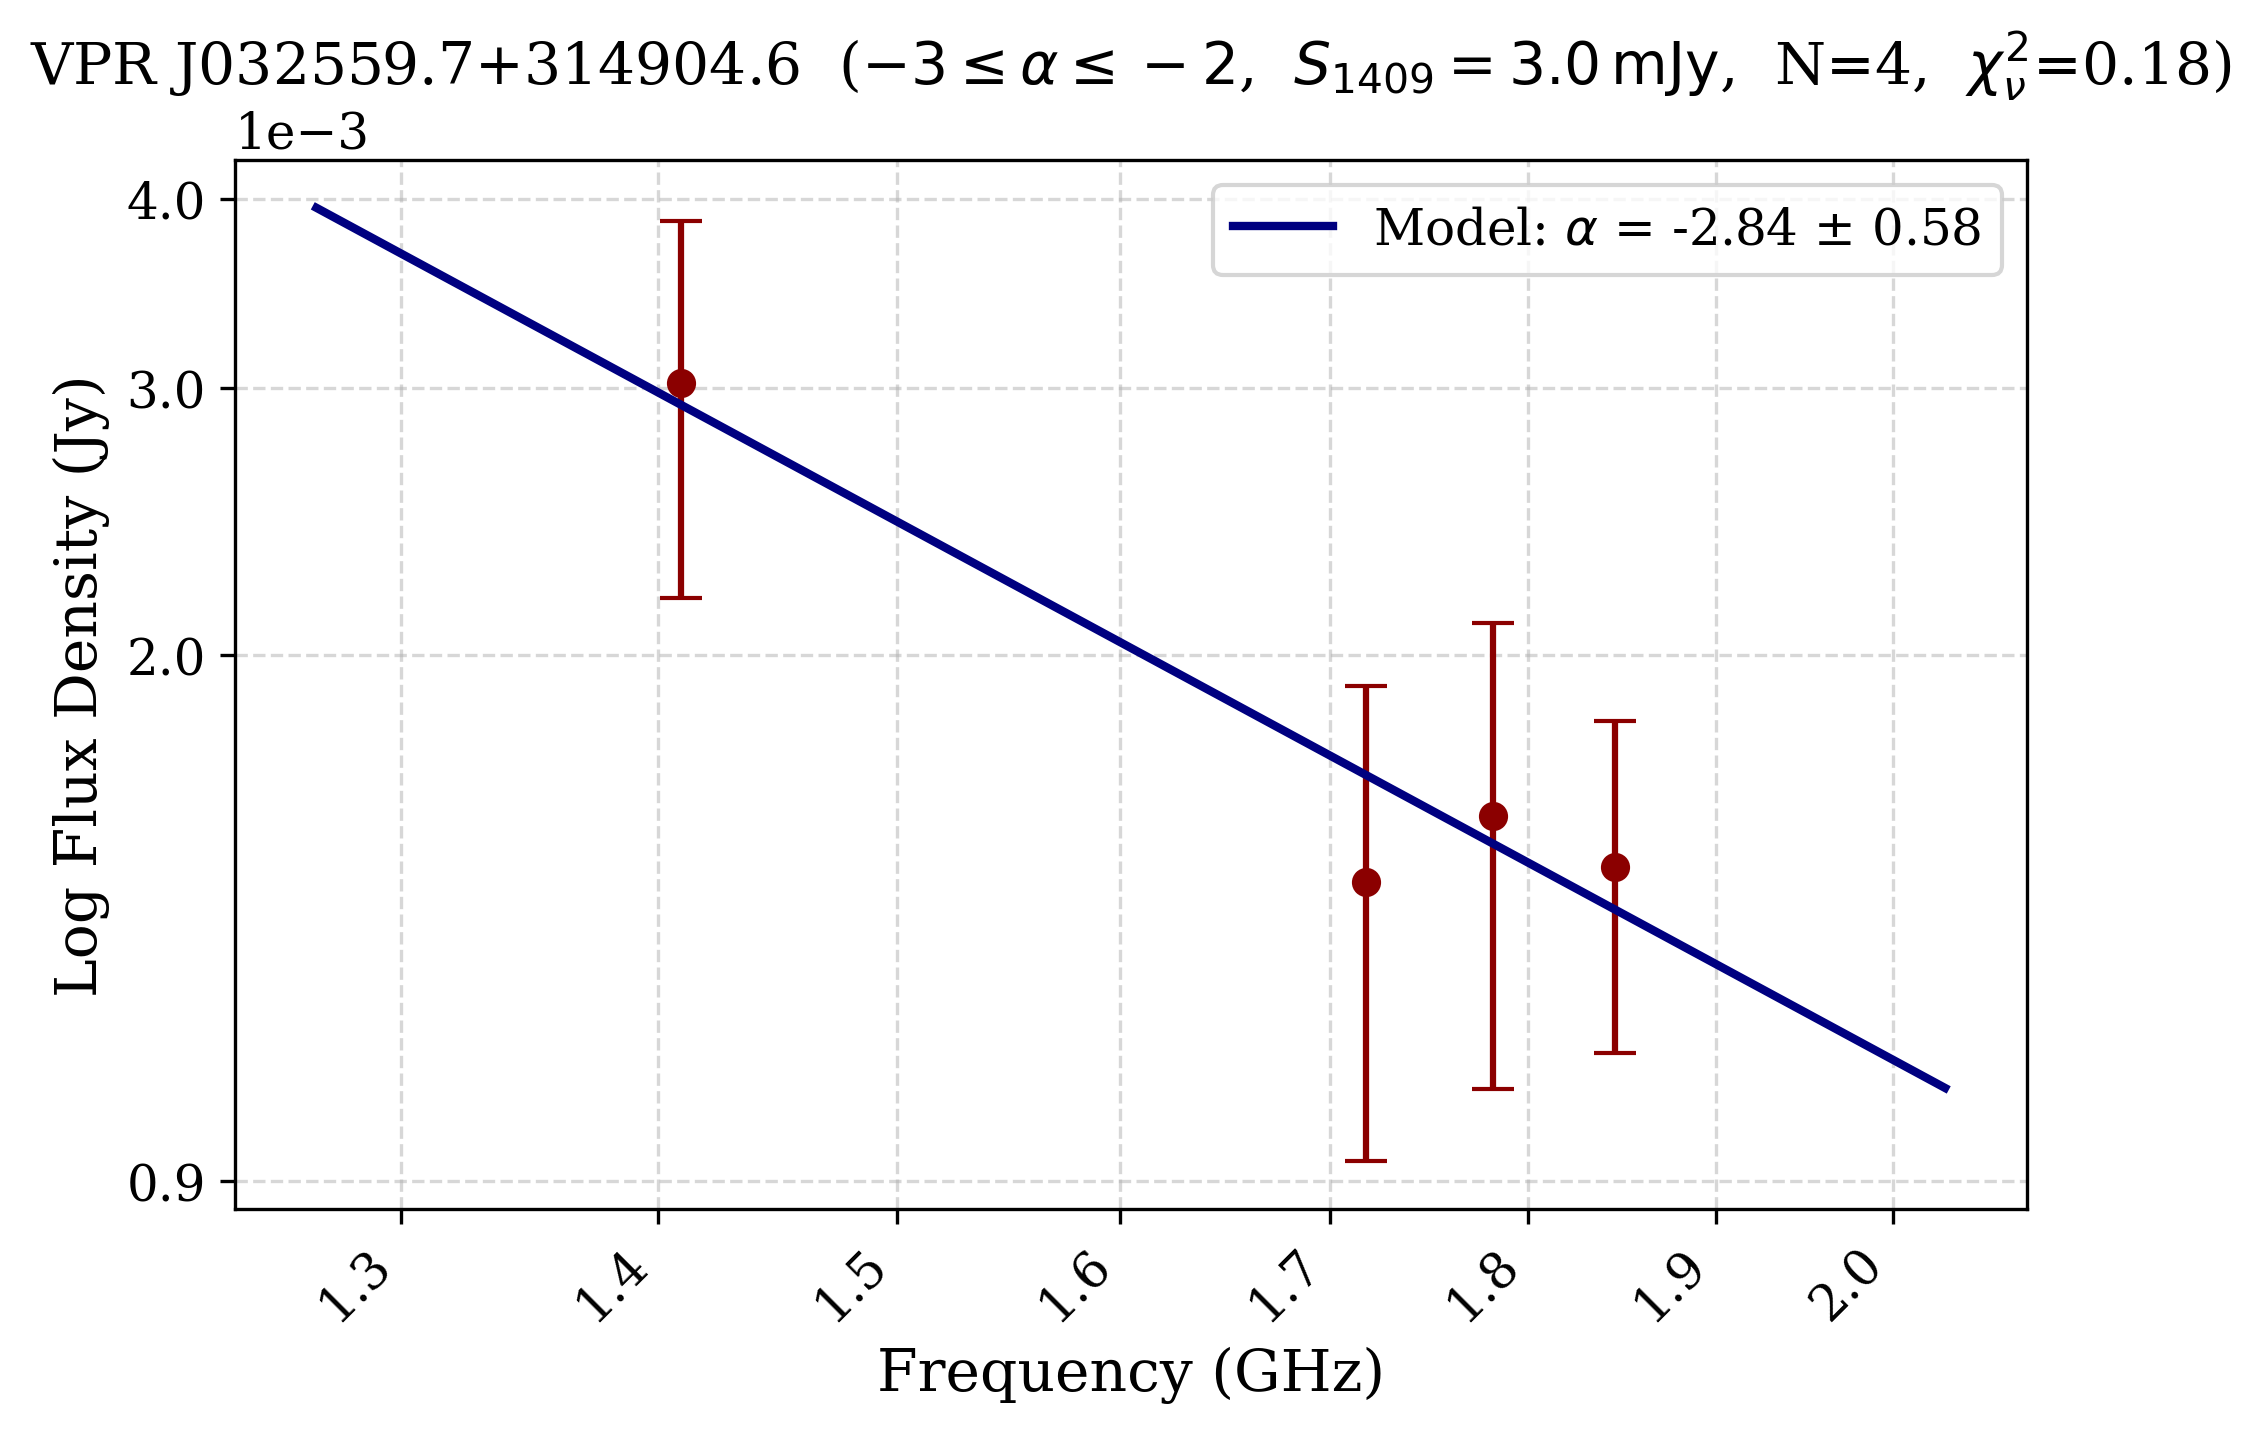

✅ Saved: ../paper1/figs/steep_spectra_alpha_-3_-2/VPR_J032559.7+314904.6_spectrum.pdf


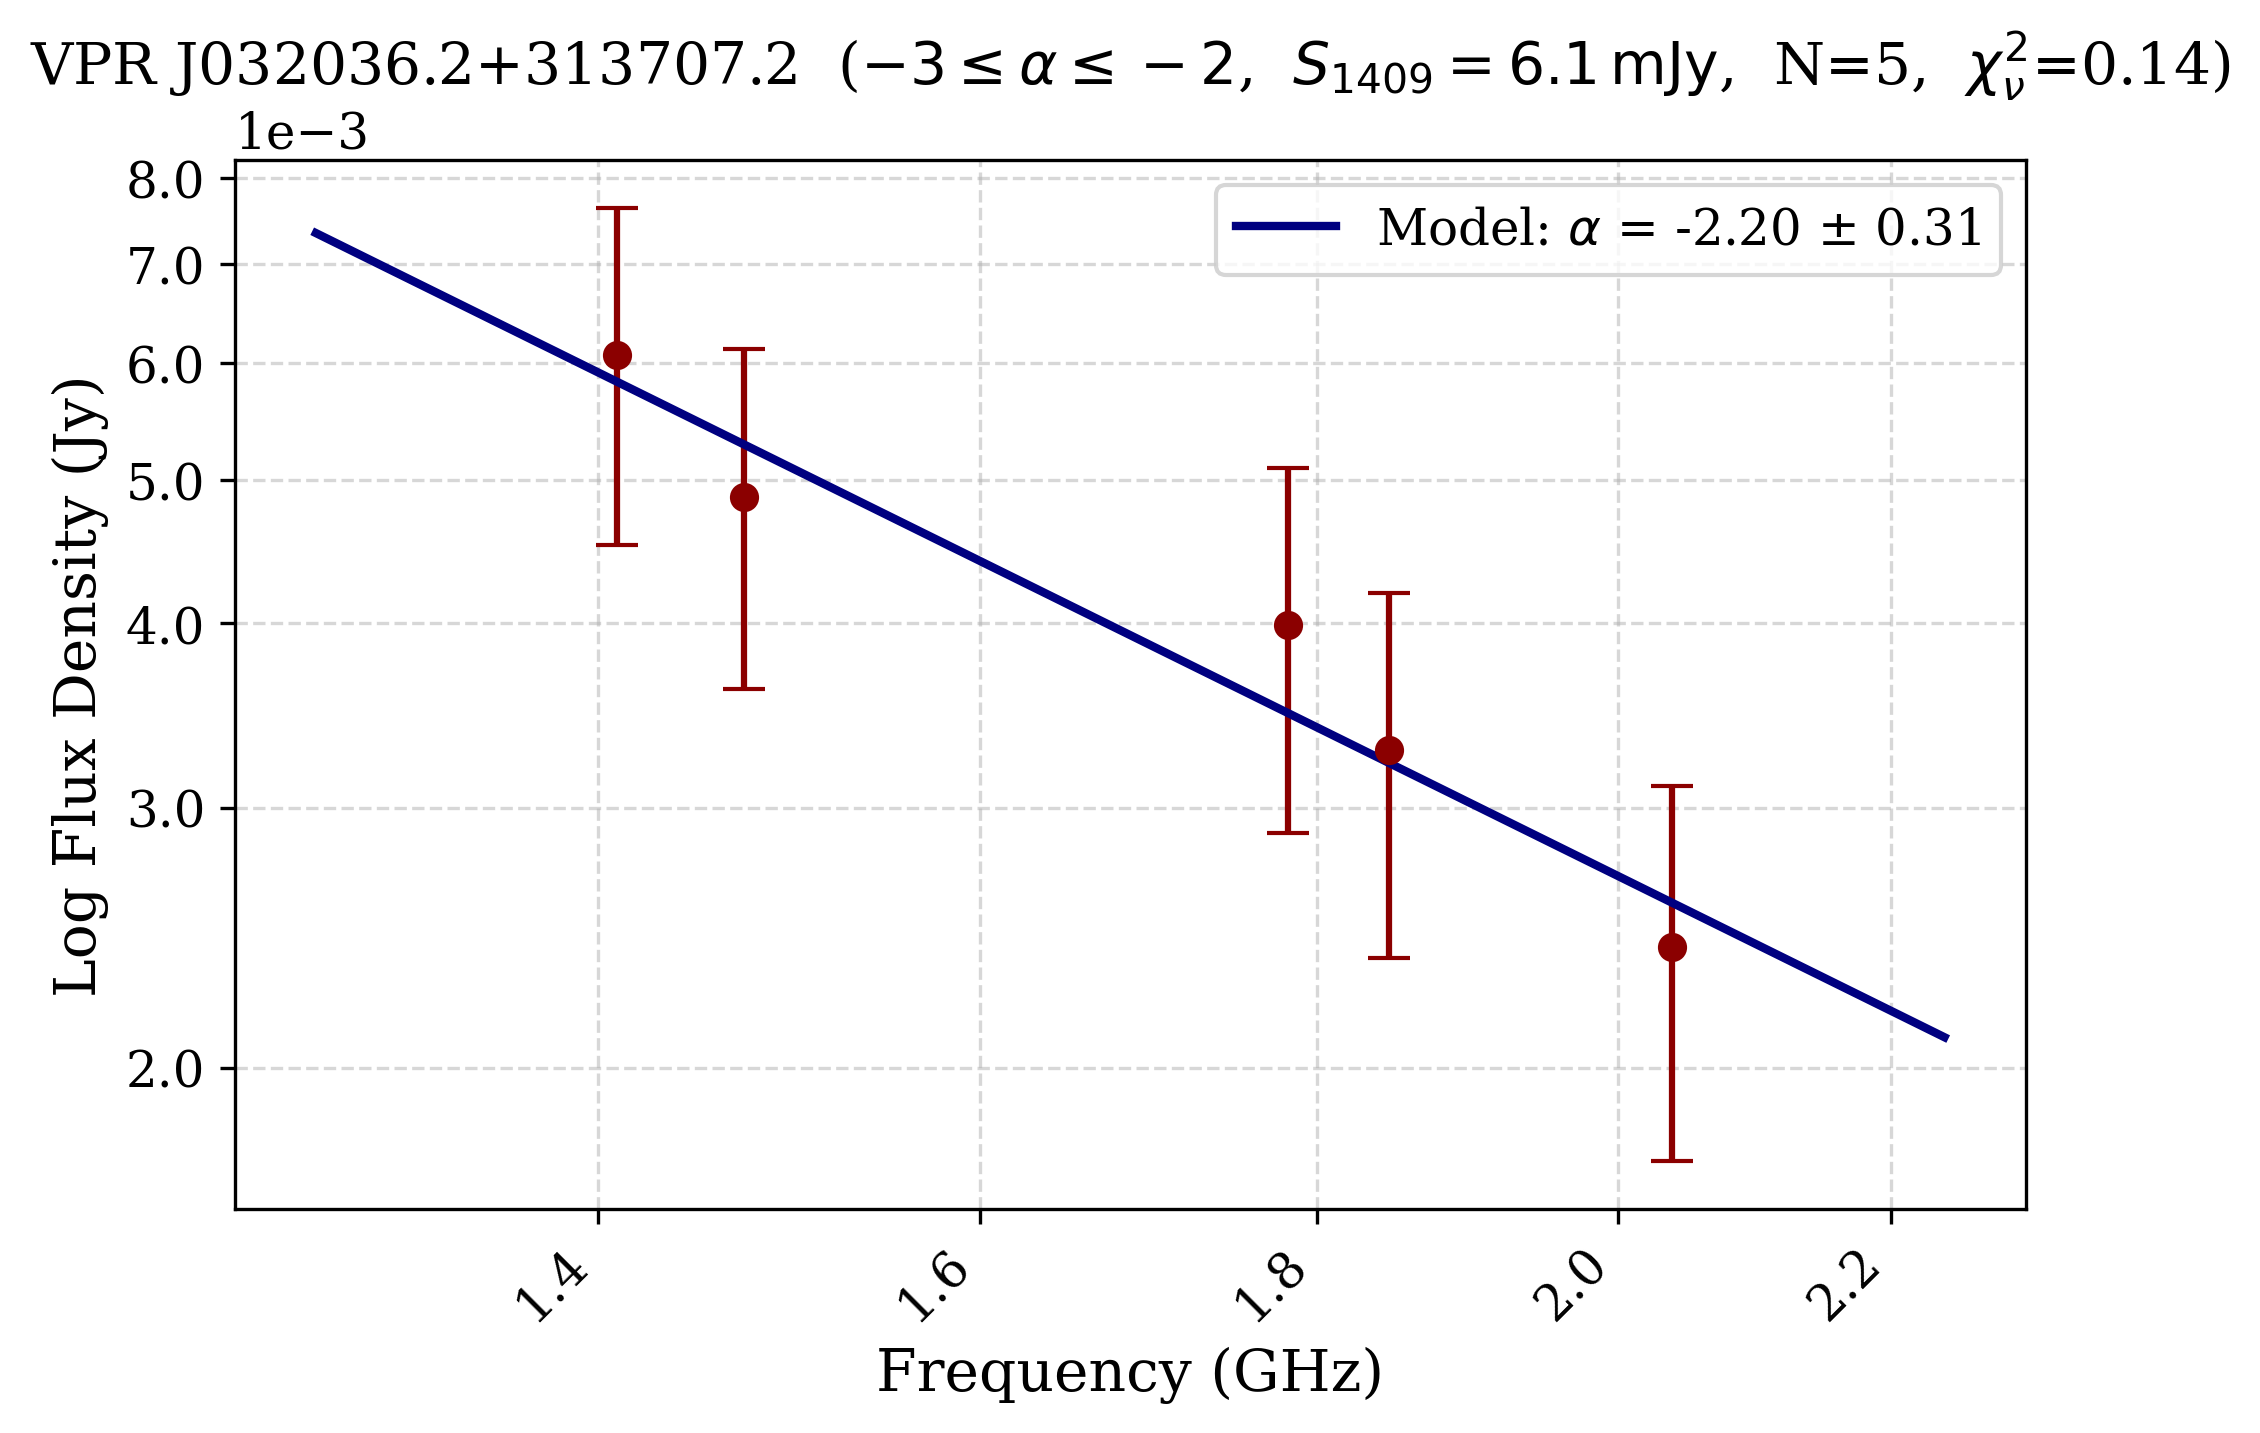

✅ Saved: ../paper1/figs/steep_spectra_alpha_-3_-2/VPR_J032036.2+313707.2_spectrum.pdf


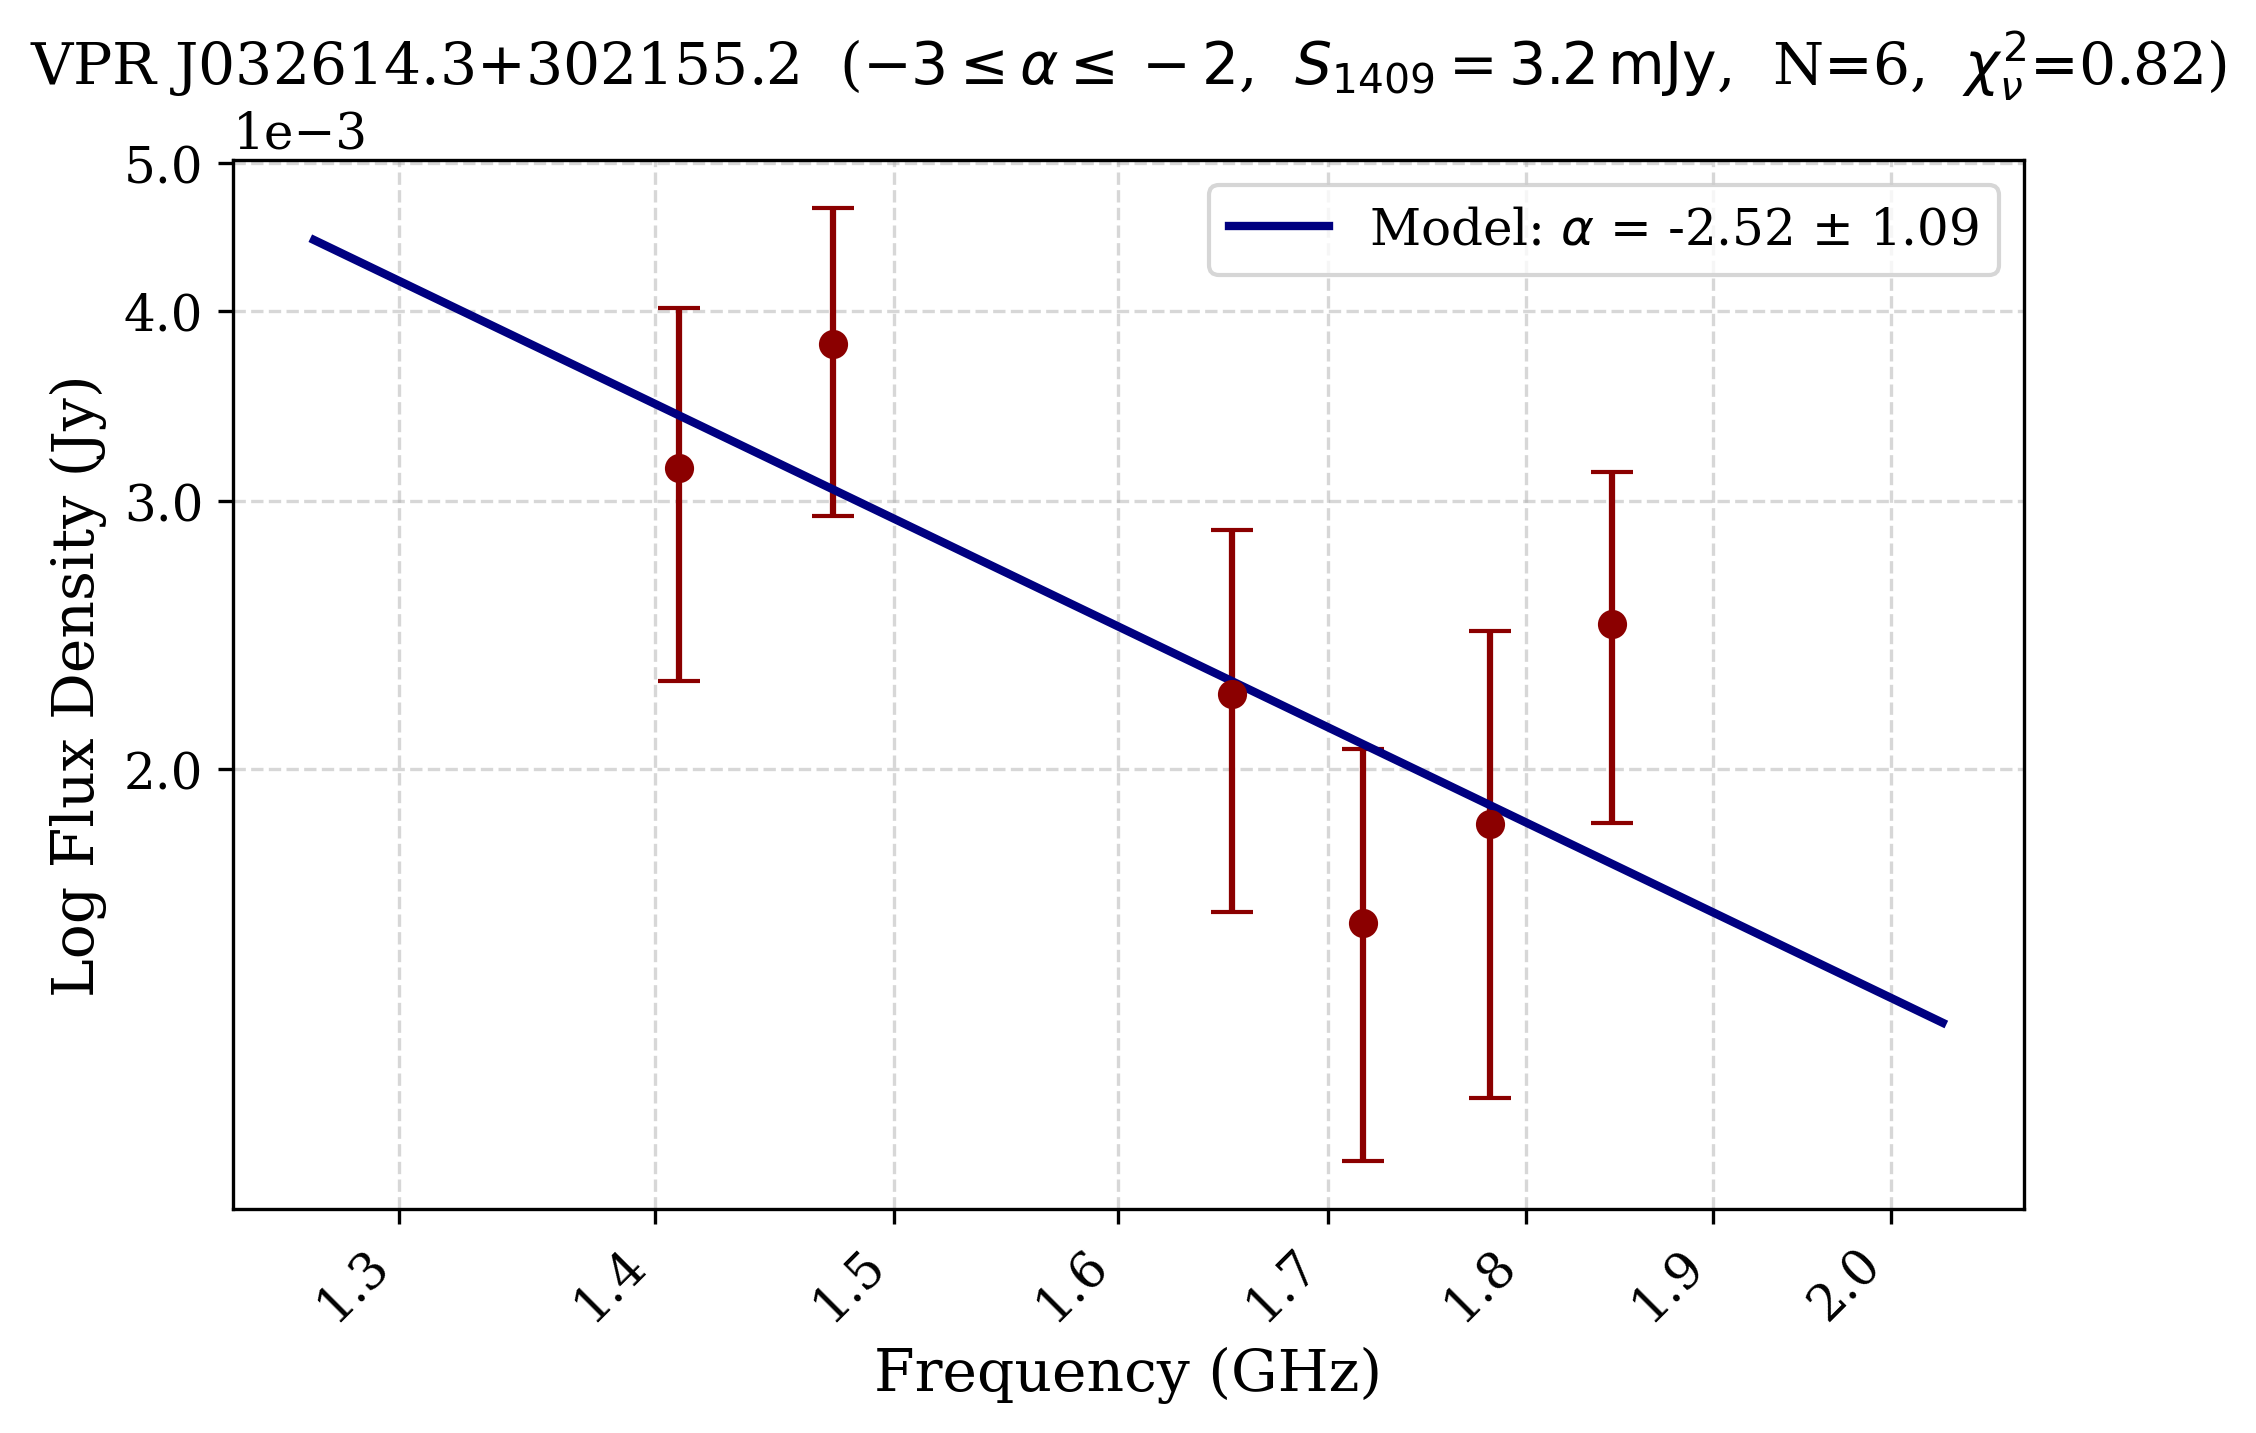

✅ Saved: ../paper1/figs/steep_spectra_alpha_-3_-2/VPR_J032614.3+302155.2_spectrum.pdf


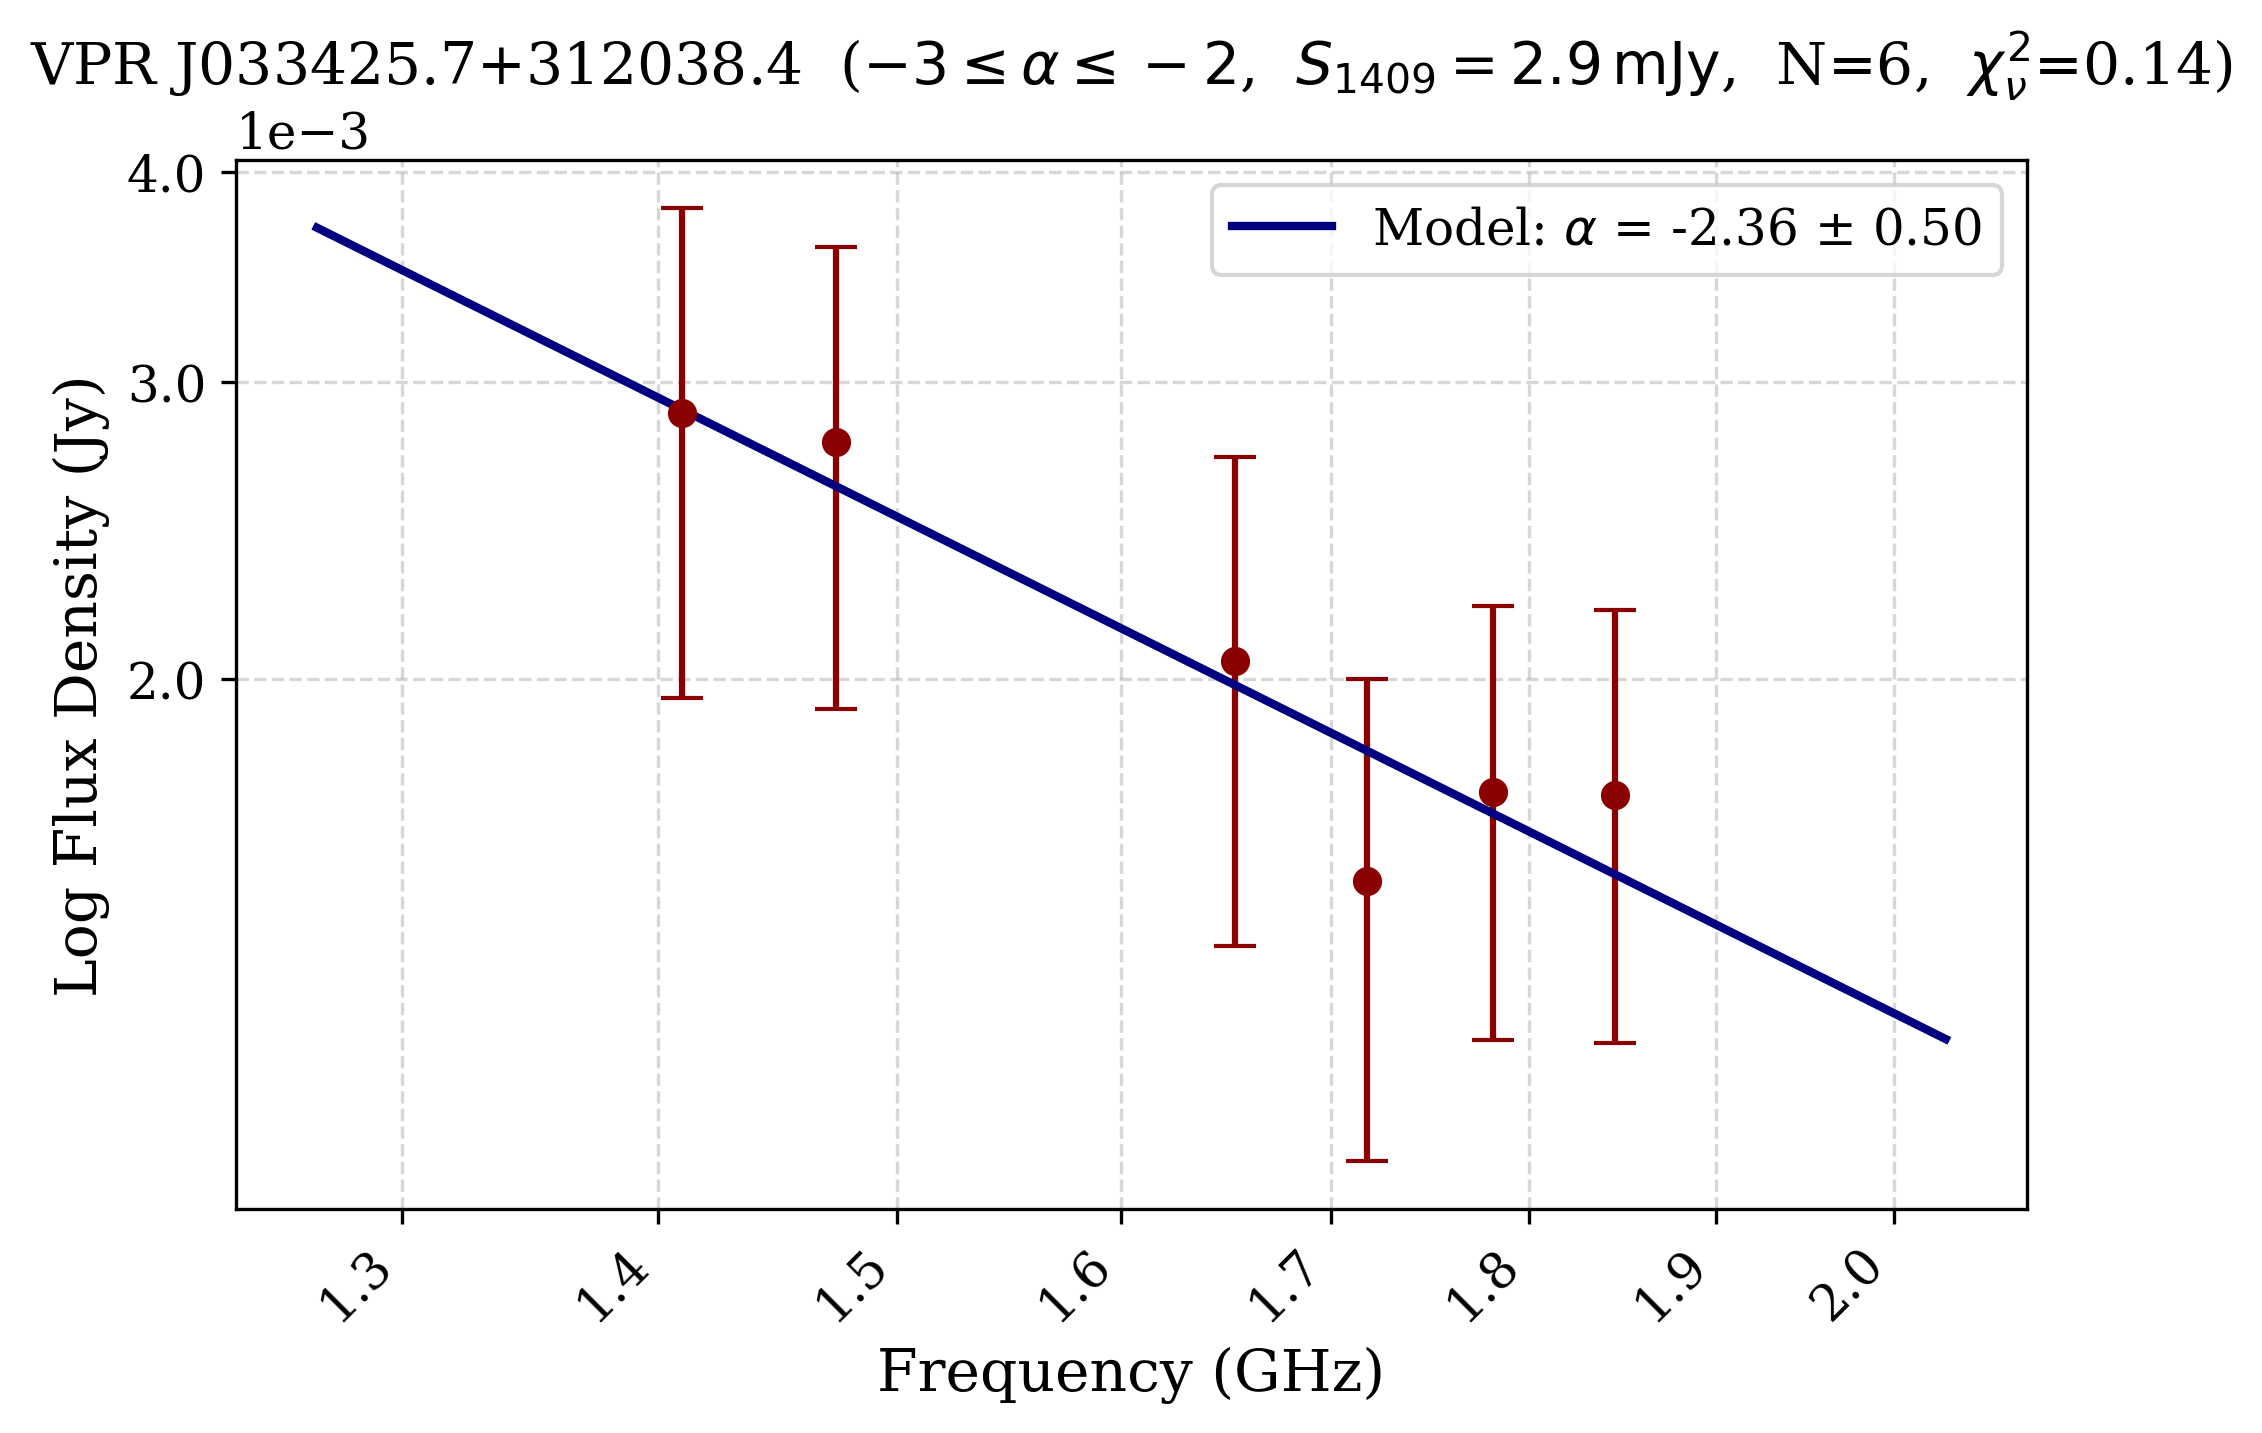

✅ Saved: ../paper1/figs/steep_spectra_alpha_-3_-2/VPR_J033425.7+312038.4_spectrum.pdf


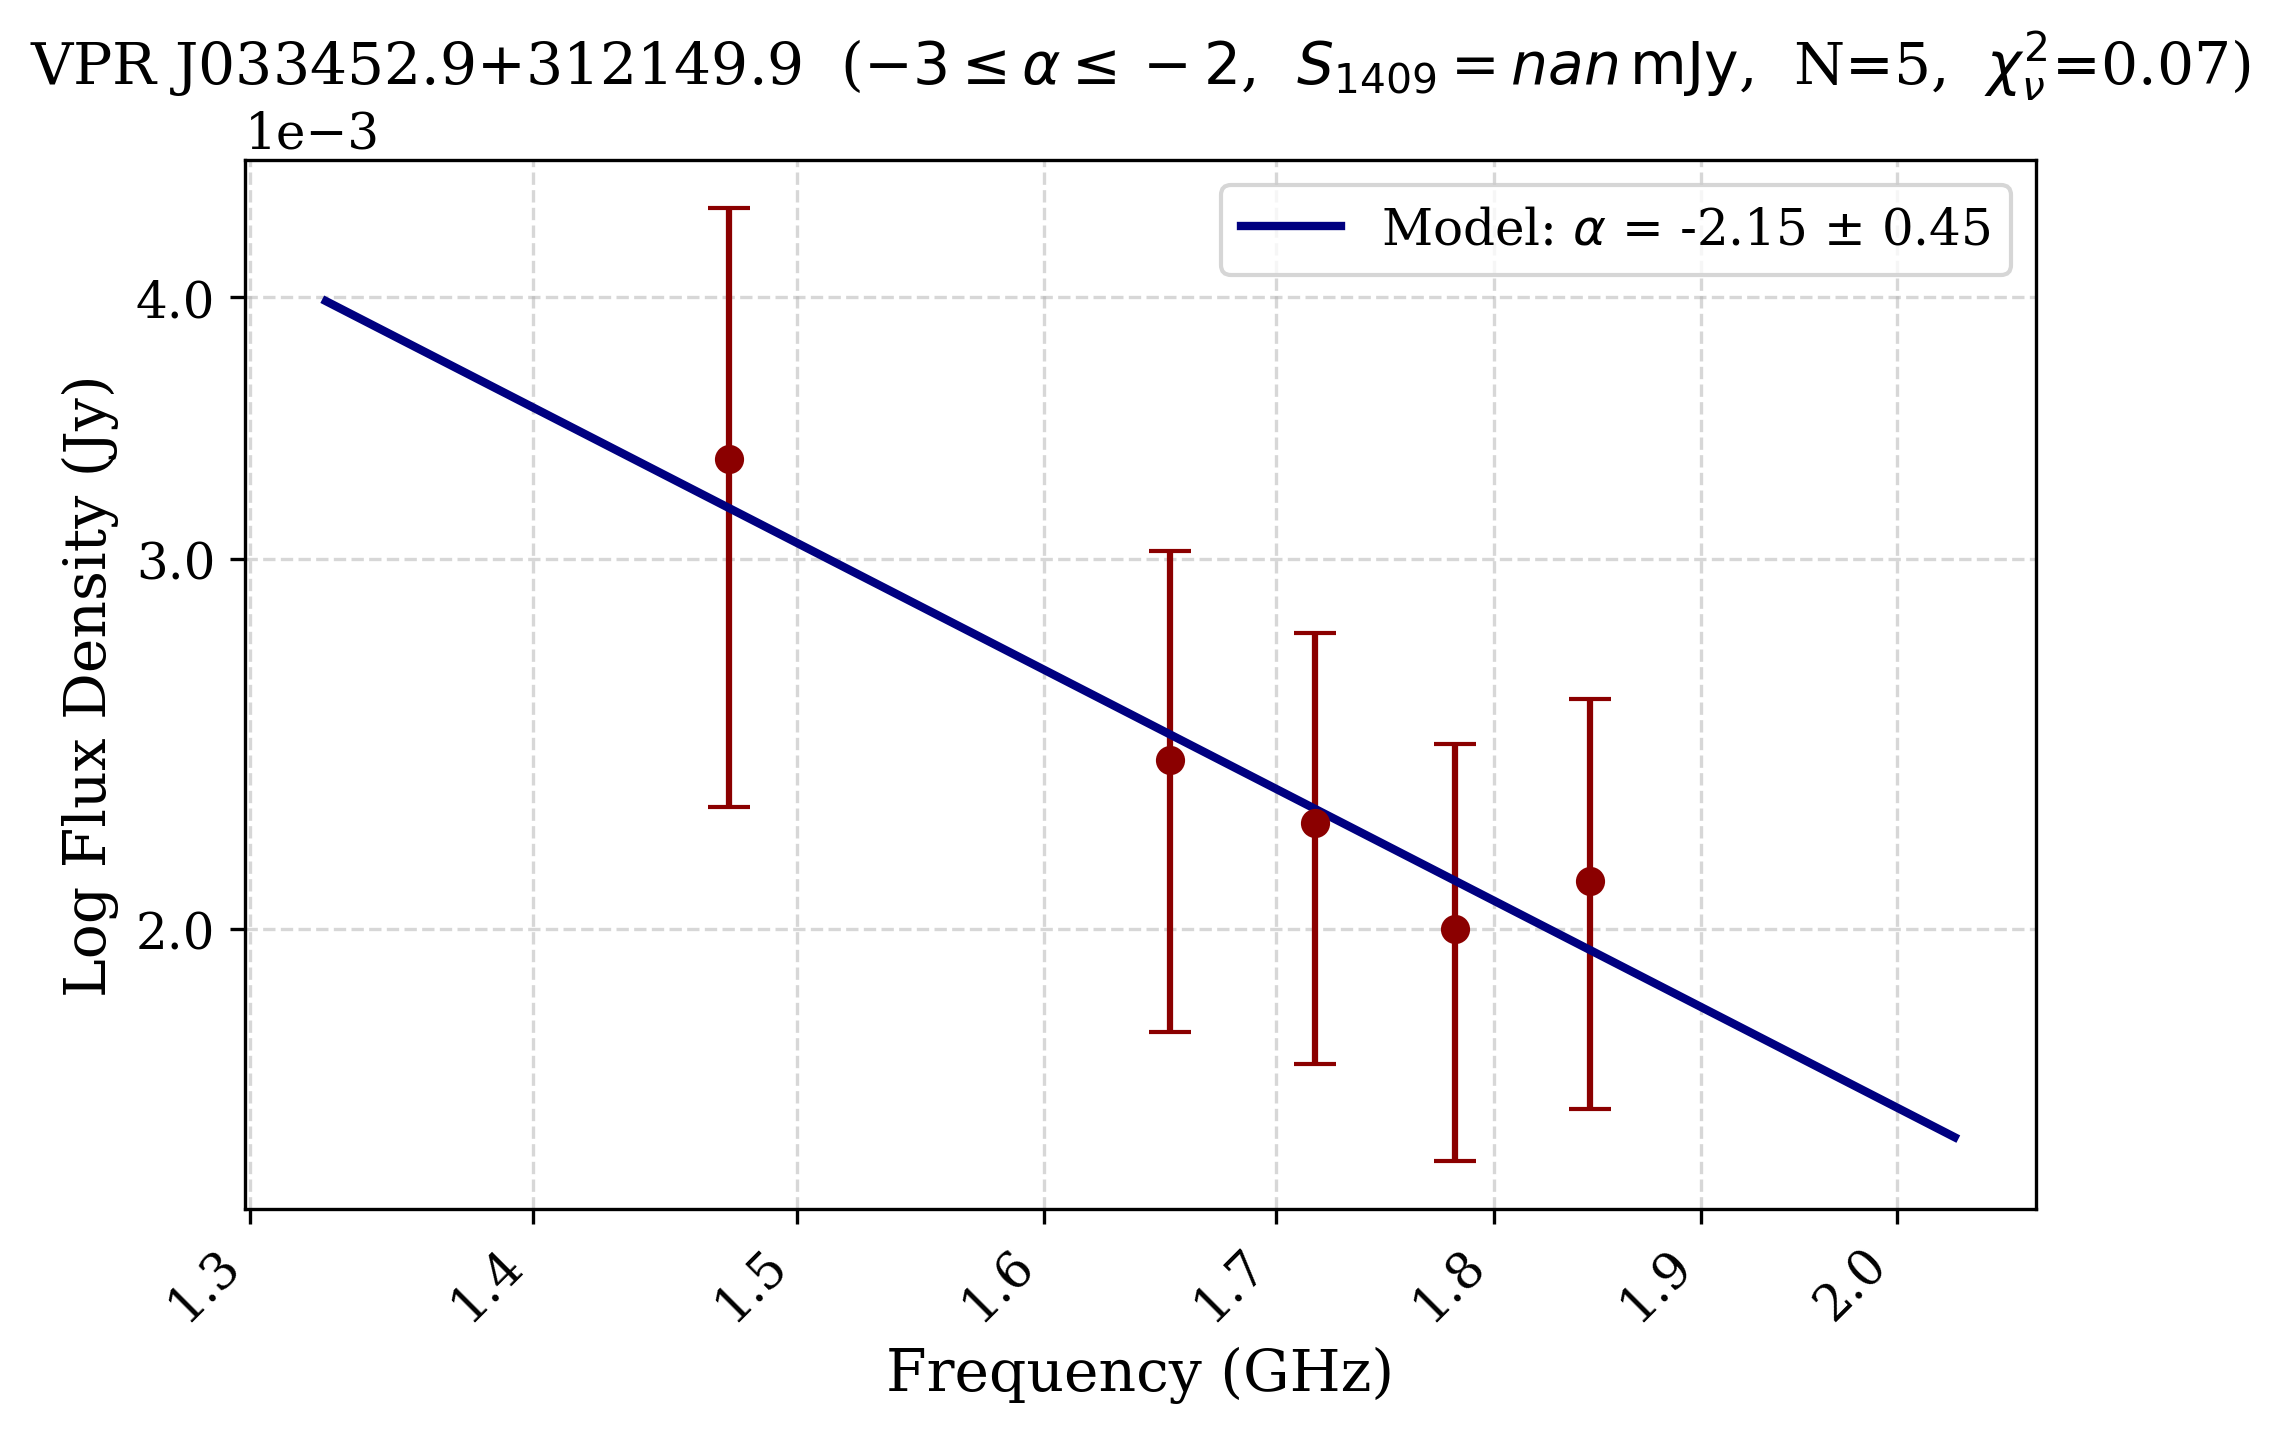

✅ Saved: ../paper1/figs/steep_spectra_alpha_-3_-2/VPR_J033452.9+312149.9_spectrum.pdf


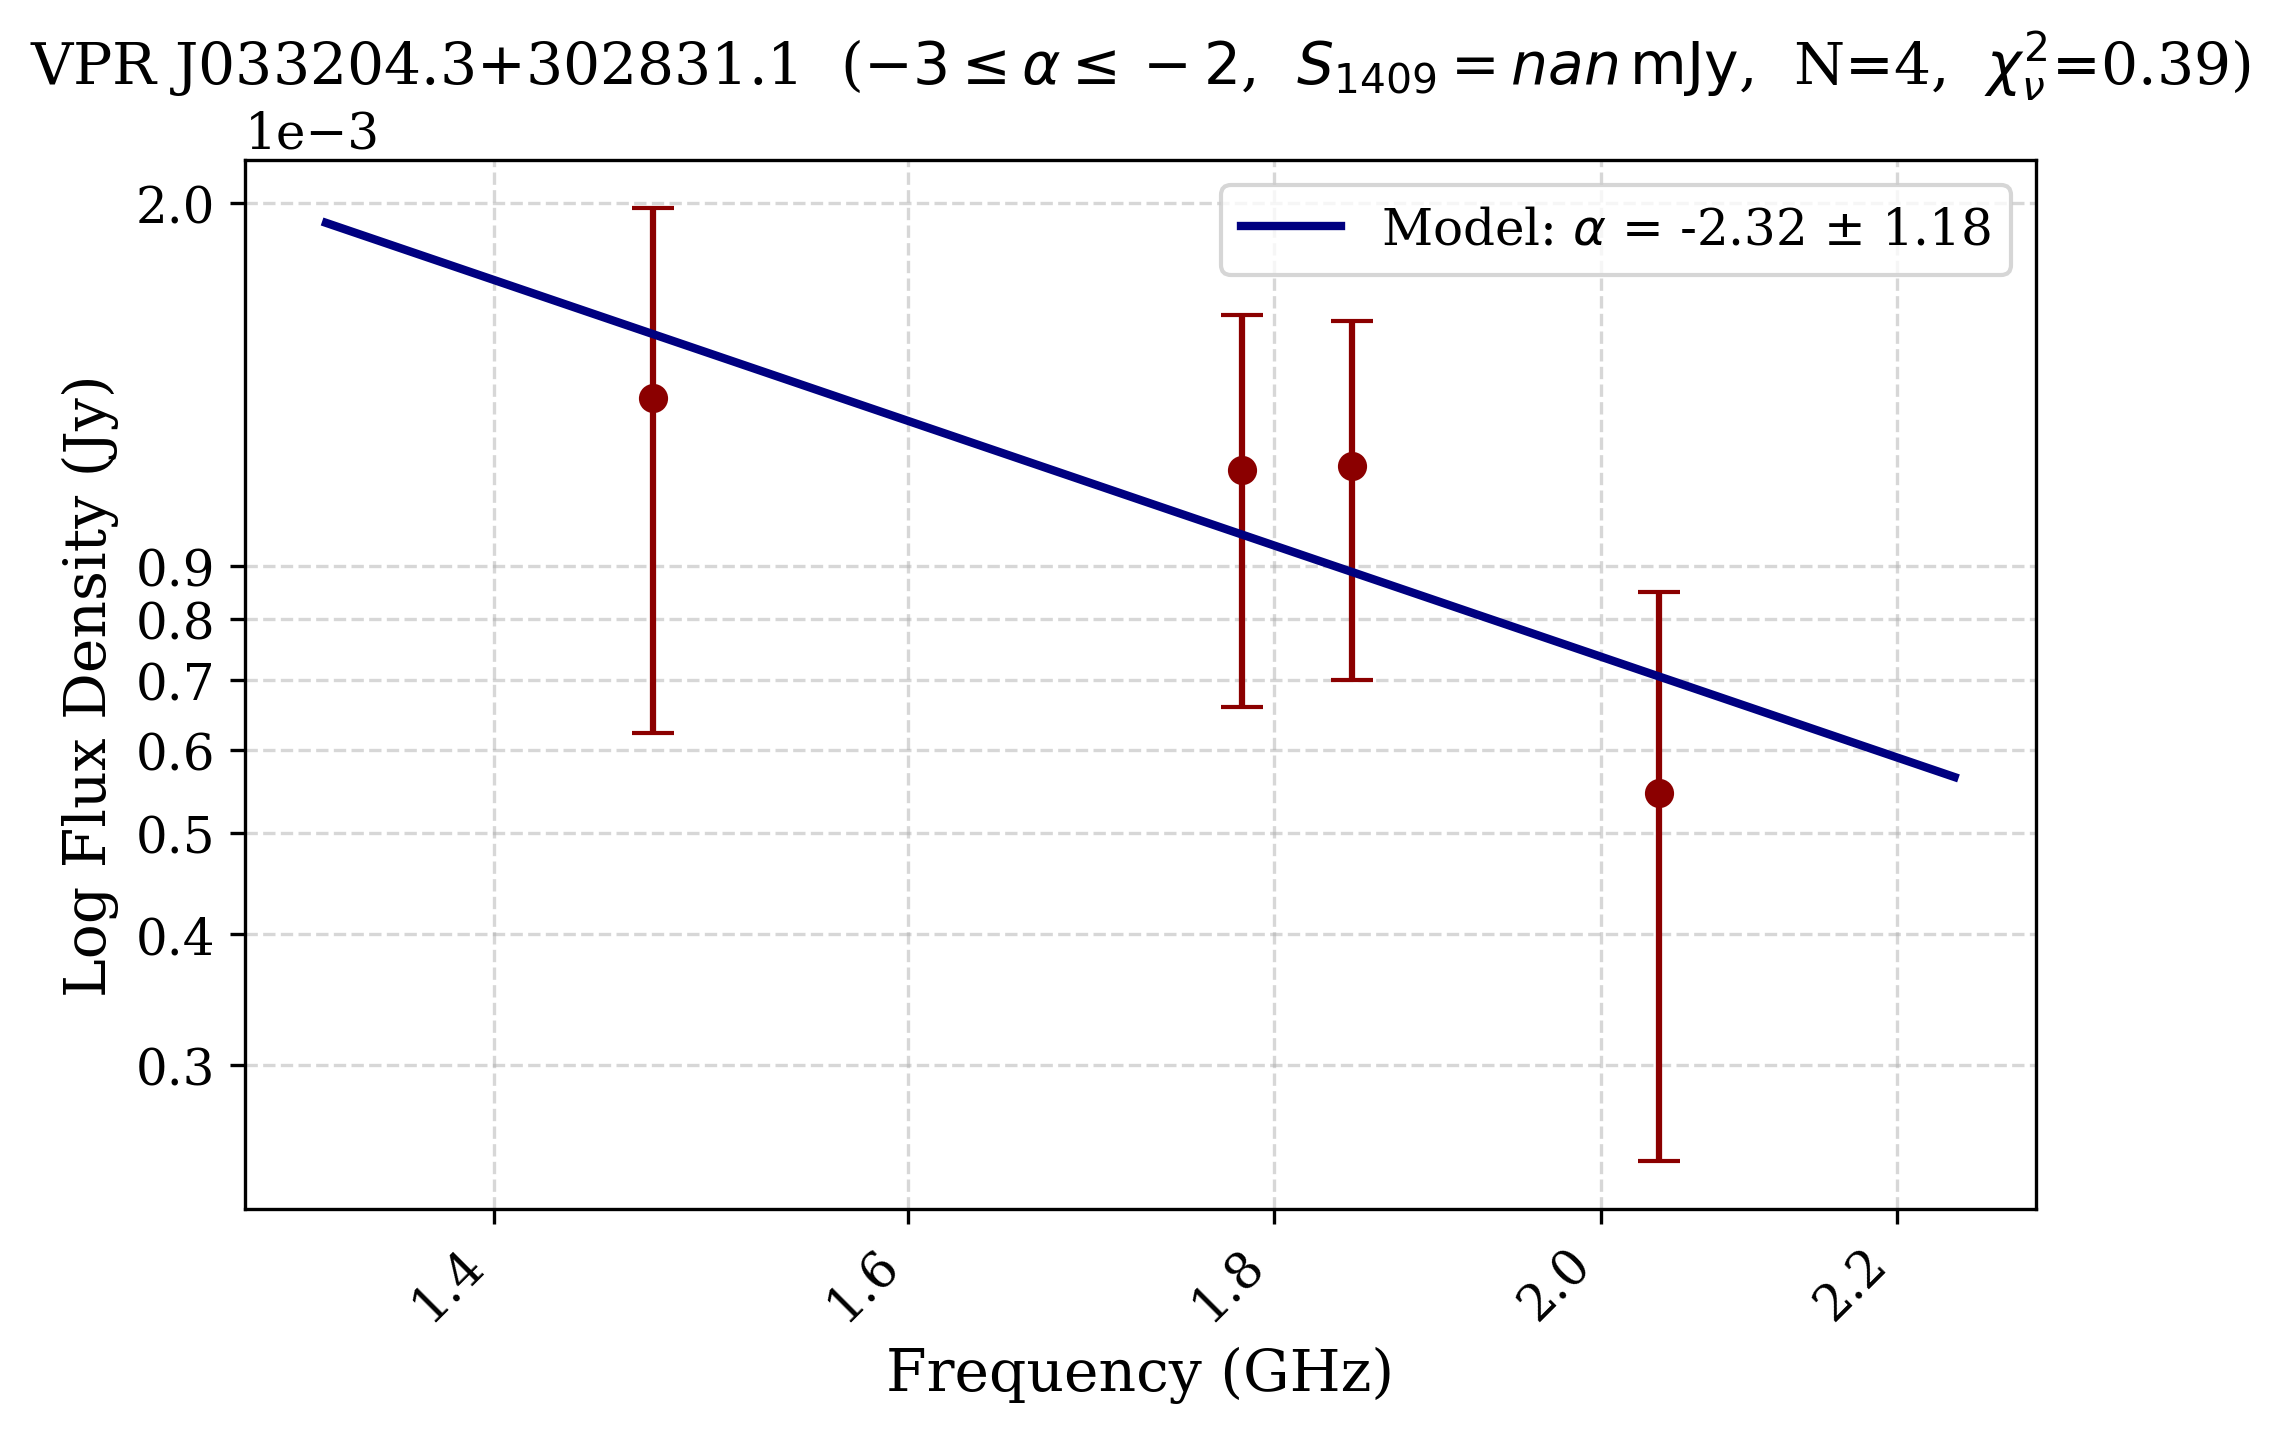

✅ Saved: ../paper1/figs/steep_spectra_alpha_-3_-2/VPR_J033204.3+302831.1_spectrum.pdf


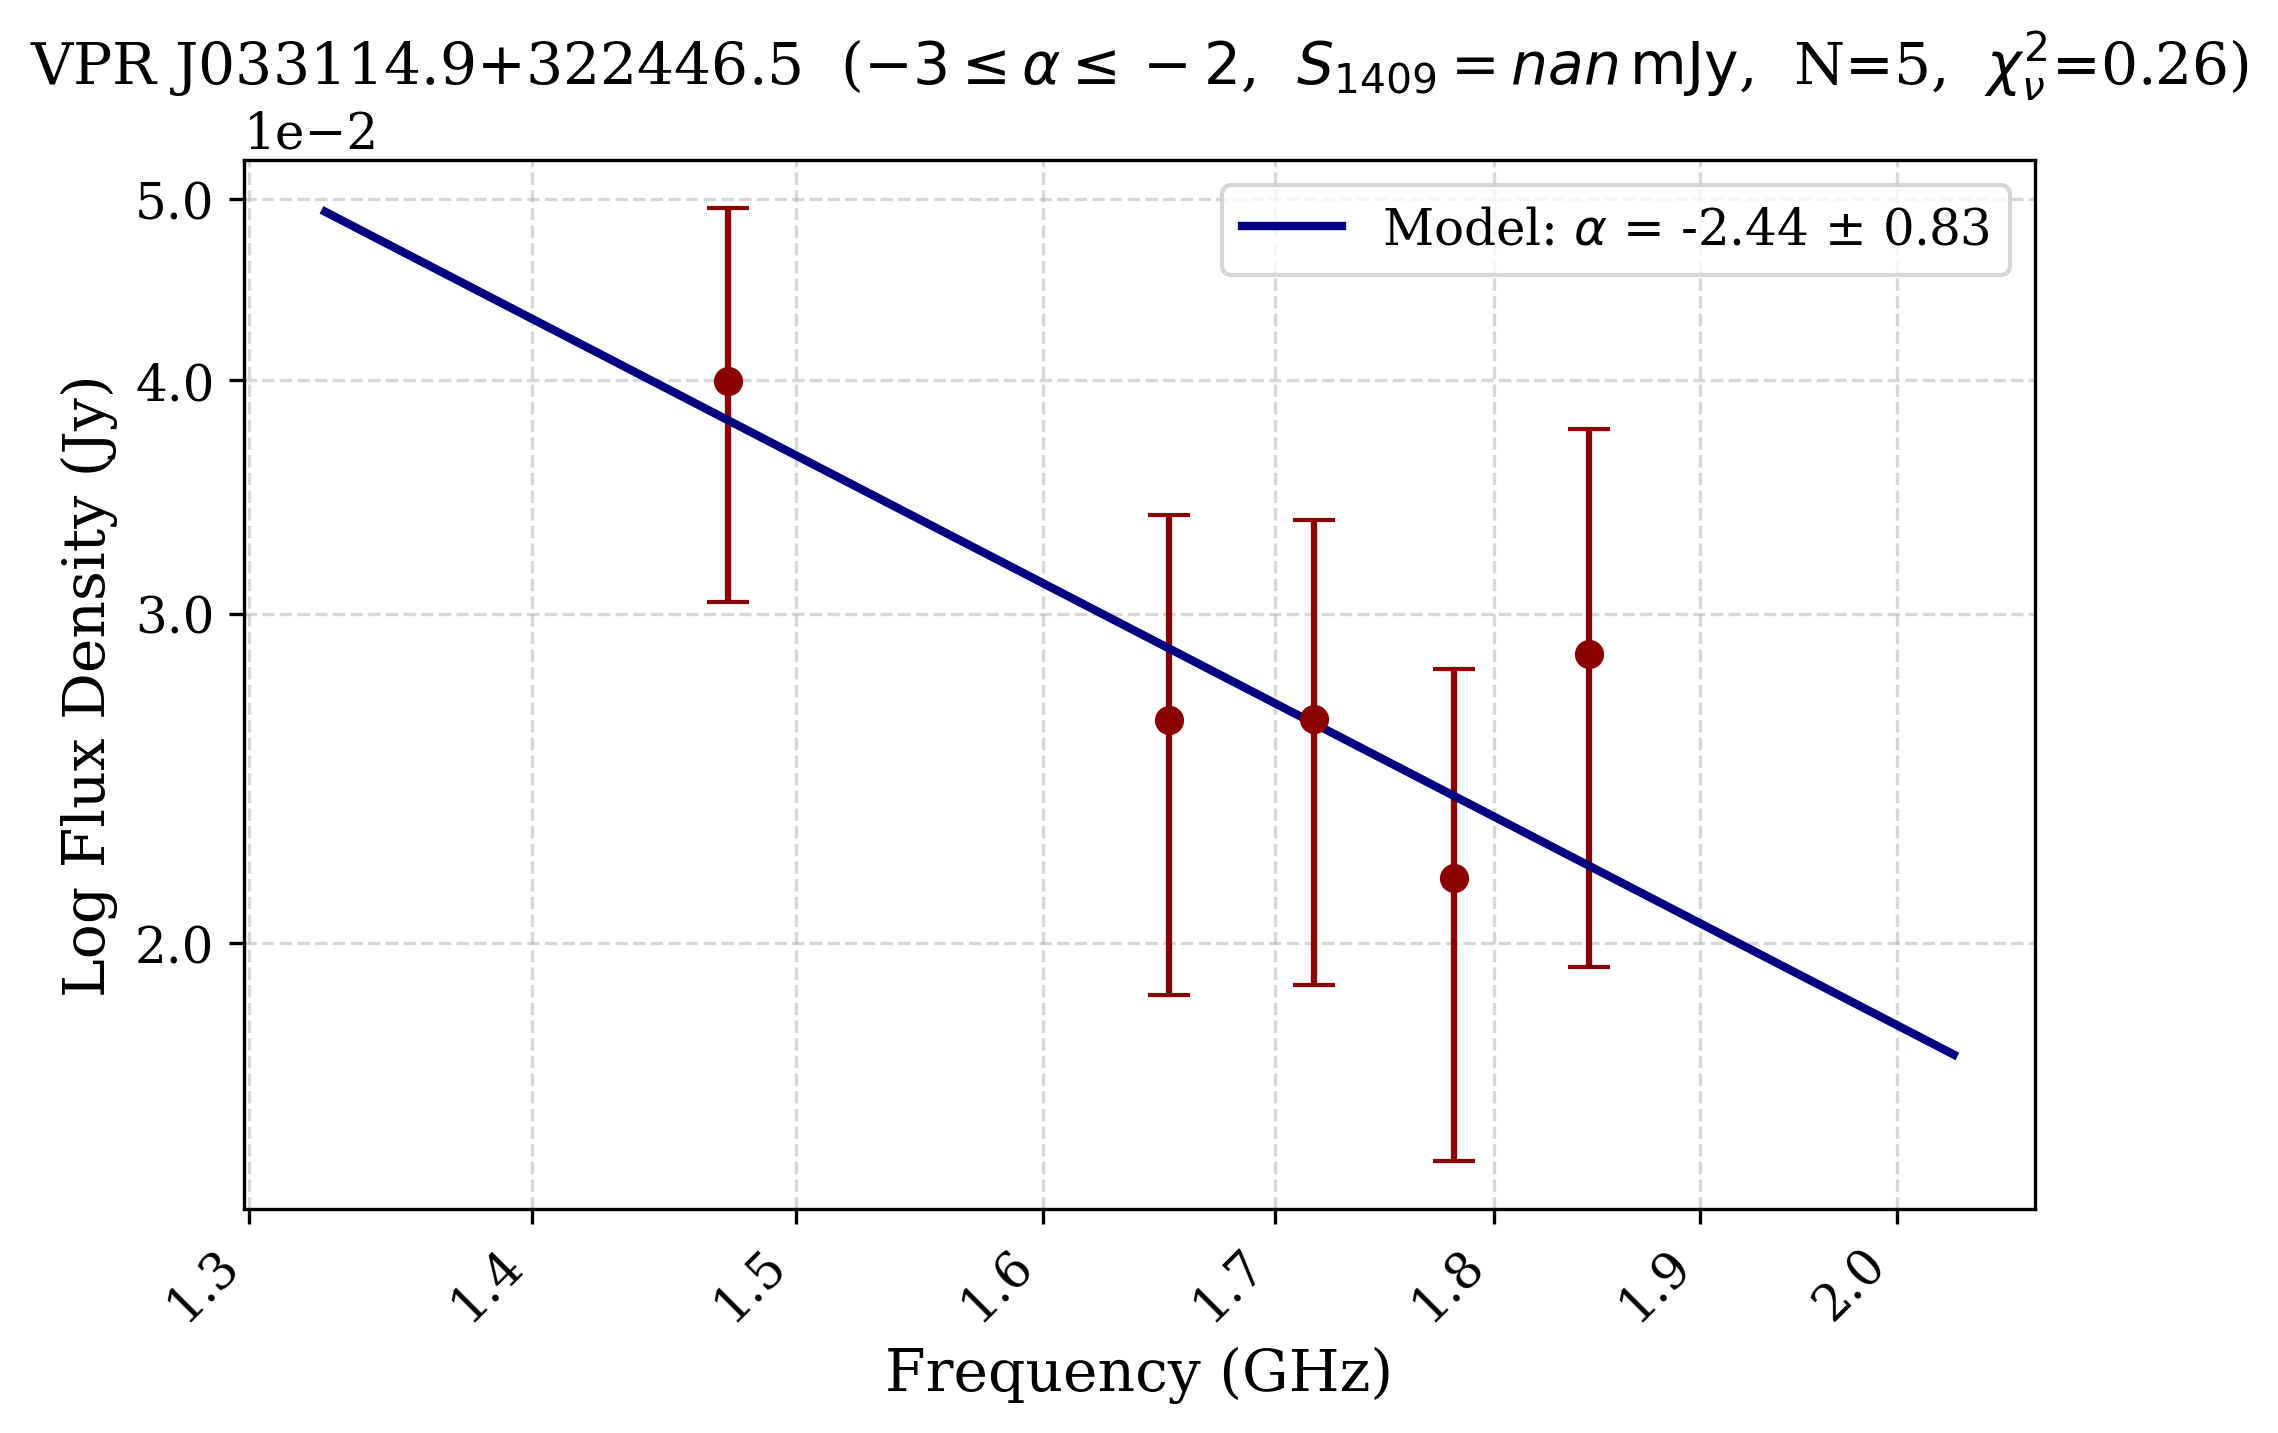

✅ Saved: ../paper1/figs/steep_spectra_alpha_-3_-2/VPR_J033114.9+322446.5_spectrum.pdf


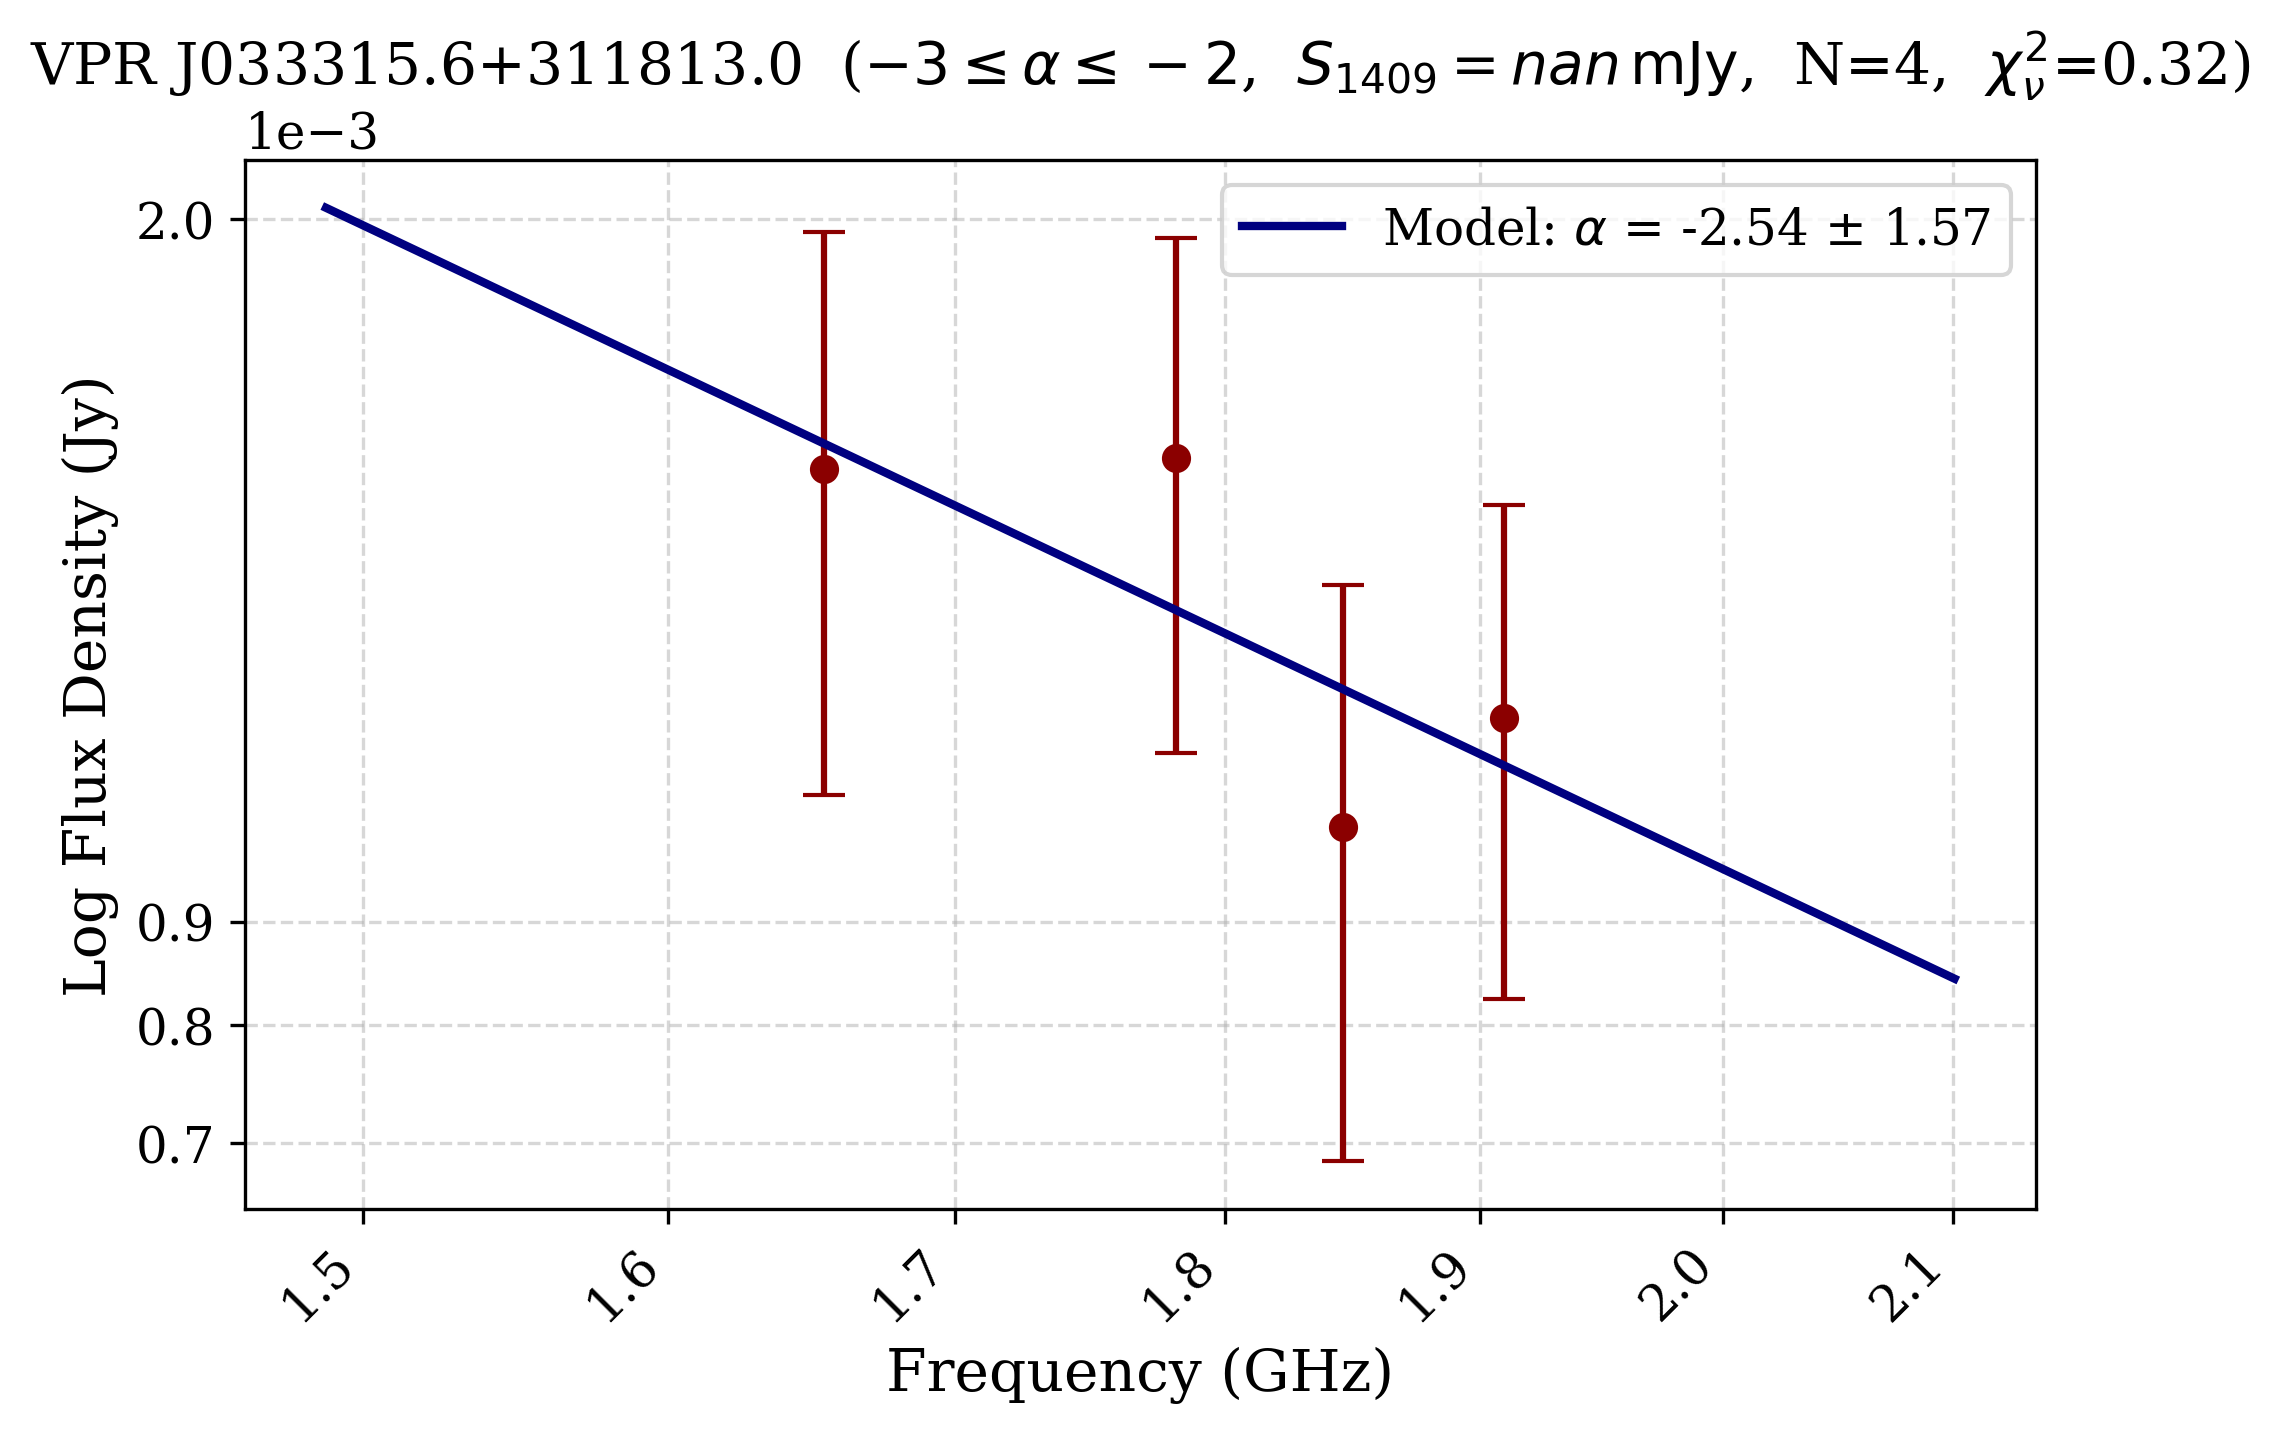

✅ Saved: ../paper1/figs/steep_spectra_alpha_-3_-2/VPR_J033315.6+311813.0_spectrum.pdf


In [13]:
# ======================================
# ONE-PLOT-PER-SOURCE: log S vs log ν for -3 ≤ α ≤ -2
# (styled like your example) + title includes SPW16 flux (mJy)
# ======================================

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, LogLocator

# Where to save per-source PDFs
OUTDIR = "../paper1/figs/steep_spectra_alpha_-3_-2"
os.makedirs(OUTDIR, exist_ok=True)

# Choose which table to draw sources from:
# - alpha_good_lmfit: already filtered (e.g., SPW16>10 mJy and alpha in [-3,3])
# - alpha_all_df: all fitted sources
SRC_TABLE = alpha_good_lmfit

# Select steep sources
steep = SRC_TABLE[
    (SRC_TABLE["alpha_lmfit"] >= -3.0) &
    (SRC_TABLE["alpha_lmfit"] <= -2.0)
].copy()

print("Number of sources with -3 ≤ alpha ≤ -2:", len(steep))

if len(steep) == 0:
    raise ValueError("No sources in the requested alpha range.")

# Optional: limit how many you plot (avoid making hundreds)
# steep = steep.head(30)

for _, srow in steep.iterrows():

    source_id = srow["Source_ID"]

    row = df[df["Source_ID"] == source_id]
    if row.empty:
        print(f"⚠️ Source {source_id} not found in df. Skipping.")
        continue
    row = row.iloc[0]

    # --- SPW16 flux (mJy) for title ---
    if "Total_S_SPW16" in row.index and np.isfinite(row["Total_S_SPW16"]):
        S16_mJy = float(row["Total_S_SPW16"])
        S16_txt = f"{S16_mJy:.1f}"
    else:
        S16_mJy = np.nan
        S16_txt = "nan"

    # extract spectrum (MHz, mJy)
    freqs_MHz, fluxes_mJy, errors_mJy = extract_spectrum(row)

    if len(freqs_MHz) < 2:
        print(f"⚠️ Source {source_id}: not enough valid SPWs to plot. Skipping.")
        continue

    # --- fit lmfit power-law: S(nu) = A * (nu/NU0)^alpha (nu in MHz) ---
    params = pl_model.make_params(
        A=float(np.median(fluxes_mJy)),
        alpha=-2.3  # better initial guess for these steep ones
    )

    try:
        fit_result = pl_model.fit(
            fluxes_mJy,
            params,
            nu=freqs_MHz,
            weights=1.0 / errors_mJy,
            nan_policy="raise"
        )
    except Exception as e:
        print(f"⚠️ Fit failed for {source_id}: {e}")
        continue

    A_fit     = fit_result.params["A"].value
    alpha_fit = fit_result.params["alpha"].value
    e_alpha   = fit_result.params["alpha"].stderr
    chi2_red  = fit_result.redchi
    n_spw     = len(freqs_MHz)

    # ---------- convert units for plotting ----------
    # x: MHz -> GHz
    freqs_GHz = freqs_MHz / 1000.0

    # y: mJy -> Jy
    fluxes_Jy = fluxes_mJy / 1000.0
    errors_Jy = errors_mJy / 1000.0

    # model curve in same units
    nu_model_MHz = np.linspace(freqs_MHz.min() * 0.9, freqs_MHz.max() * 1.1, 200)

    # Use lmfit model evaluation (no need for a separate powerlaw function)
    flux_model_mJy = pl_model.eval(params=fit_result.params, nu=nu_model_MHz)

    nu_model_GHz   = nu_model_MHz / 1000.0
    flux_model_Jy  = flux_model_mJy / 1000.0

    # -------- PLOT (log–log) in your requested style --------
    fig, ax = plt.subplots(figsize=(7, 5))

    ax.errorbar(
        freqs_GHz,
        fluxes_Jy,
        yerr=errors_Jy,
        fmt='o',
        color='darkred',
        ecolor='darkred',
        capsize=5,
        markersize=6
    )

    alpha_txt = "nan" if e_alpha is None else f"{e_alpha:.2f}"

    ax.plot(
        nu_model_GHz,
        flux_model_Jy,
        color='navy',
        linewidth=2,
        label=rf'Model: $\alpha$ = {alpha_fit:.2f} $\pm$ {alpha_txt}'
    )

    # Log–log scale
    ax.set_xscale('log')
    ax.set_yscale('log')

    # X-axis formatting (GHz)
    ax.set_xlabel('Frequency (GHz)')
    ax.xaxis.set_major_locator(LogLocator(base=10.0, subs='auto'))
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(axis='x', style='plain')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Y-axis formatting (Jy)
    ax.set_ylabel('Log Flux Density (Jy)')
    ax.yaxis.set_major_locator(LogLocator(base=10.0, subs='auto'))
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.get_major_formatter().set_scientific(True)
    ax.yaxis.get_major_formatter().set_powerlimits((0, 0))

    ax.legend()
    ax.grid(True, which='both', ls='--', alpha=0.5)

    # Title includes SPW16 flux (mJy) + fit stats
    ax.set_title(
        rf"{source_id}  "
        rf"($-3 \leq \alpha \leq -2$,  "
        rf"$S_{{1409}}={S16_txt}\,\mathrm{{mJy}}$,  "
        rf"N={n_spw},  "
        rf"$\chi^2_\nu$={chi2_red:.2f})"
    )

    outpath = os.path.join(OUTDIR, f"{source_id.replace(' ', '_')}_spectrum.pdf")
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

    print(f"✅ Saved: {outpath}")


Candidates with n_spw >= 4: 720
Plotting top 20 by Total_S_SPW16 (NO FIT)


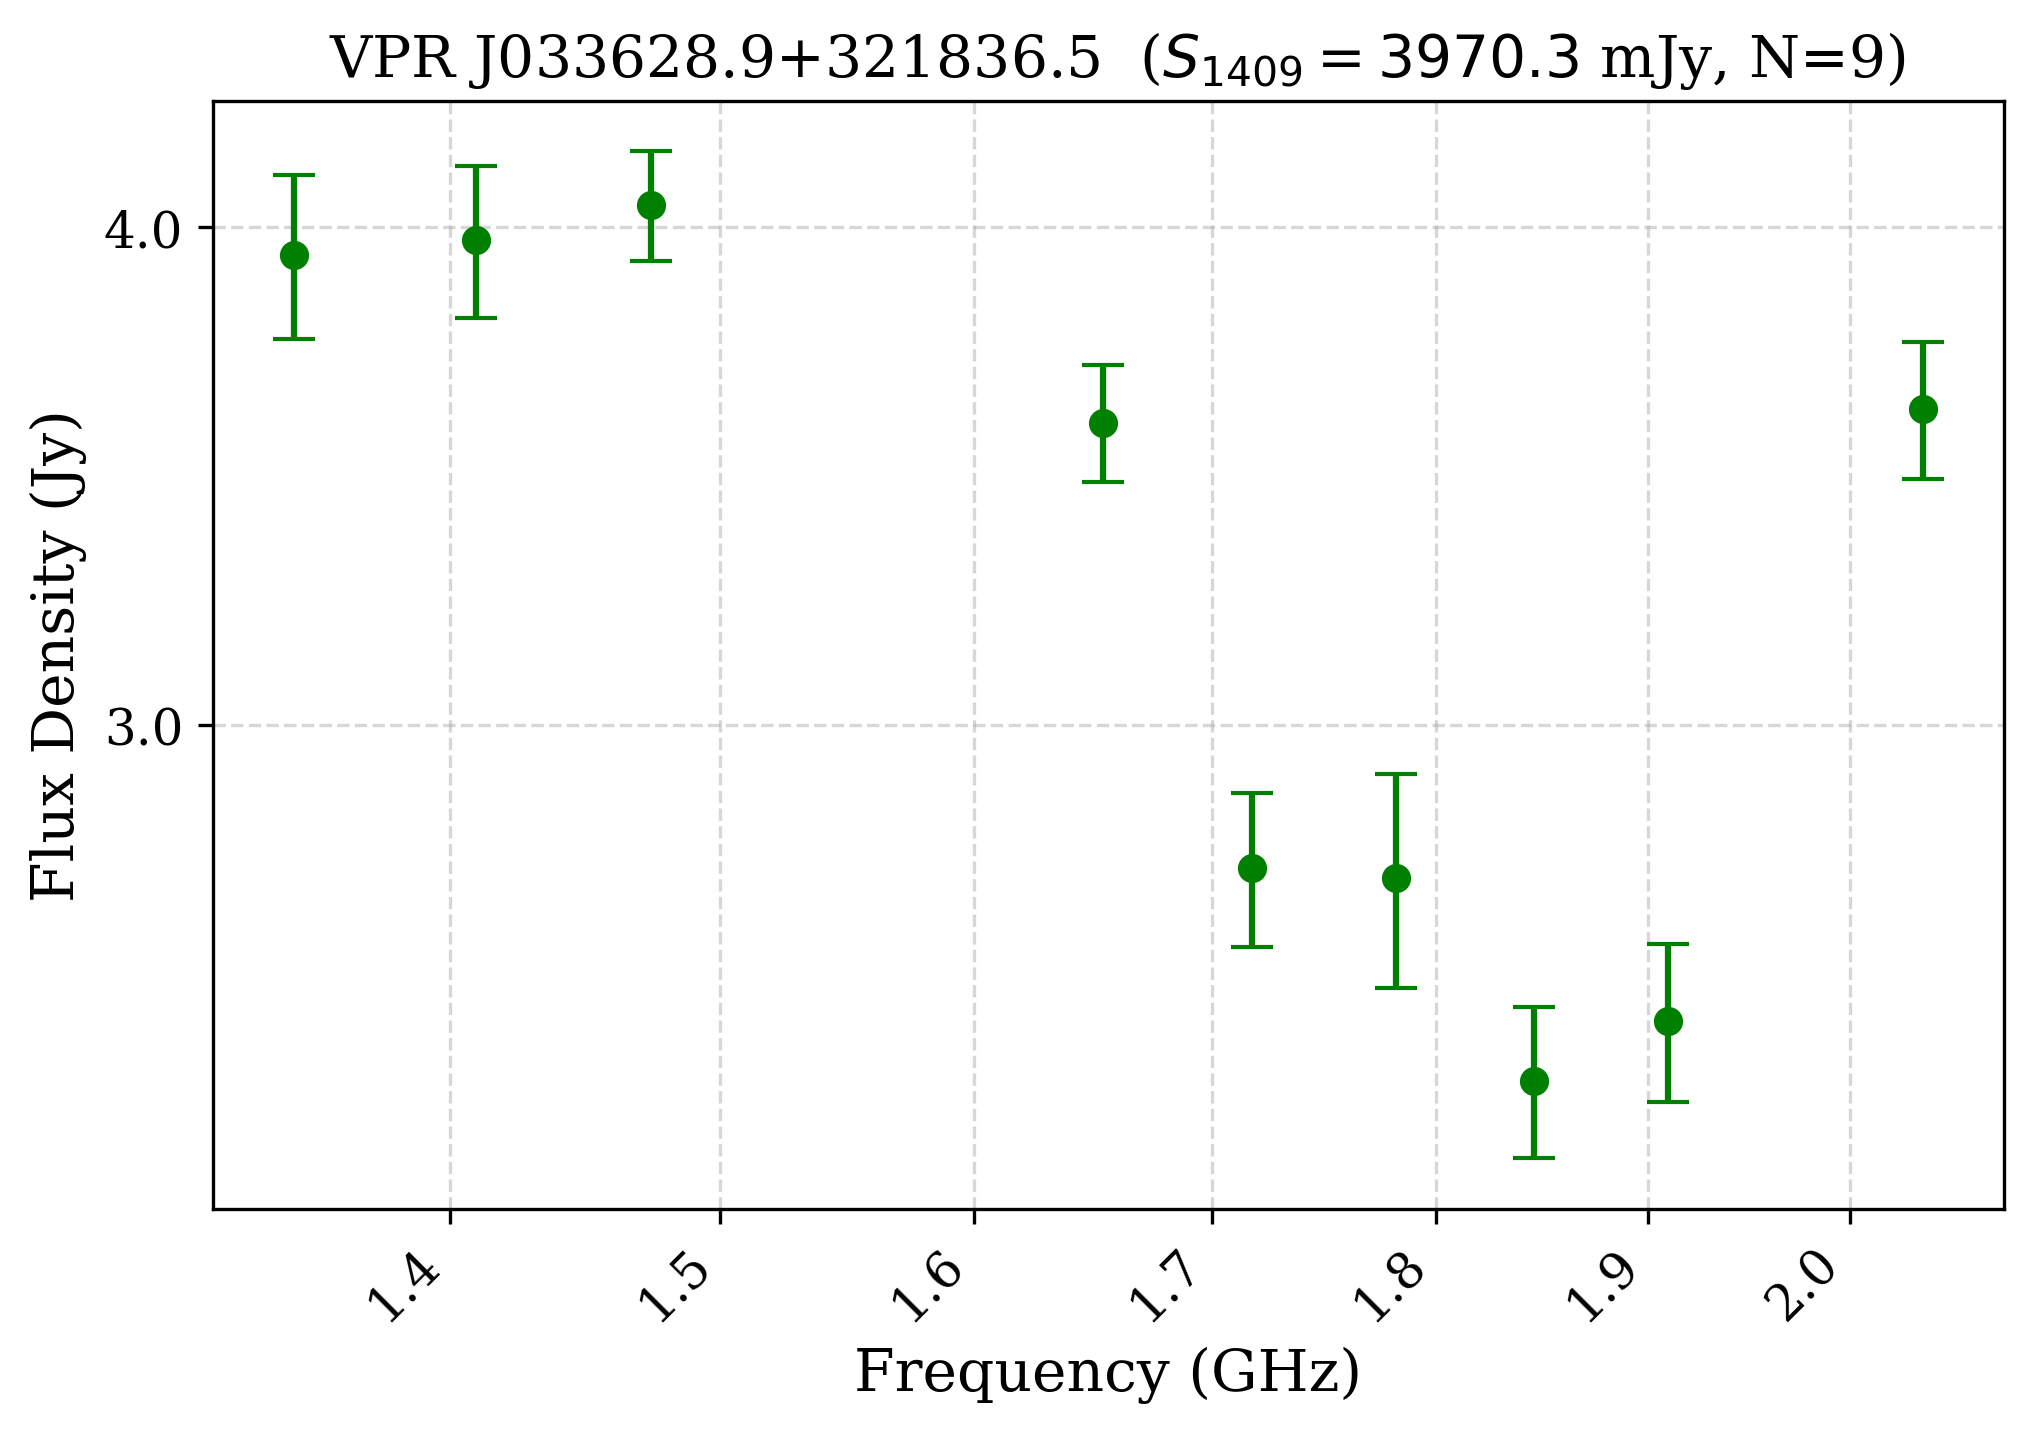

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J033628.9+321836.5_bright_nspw4_nofit.pdf


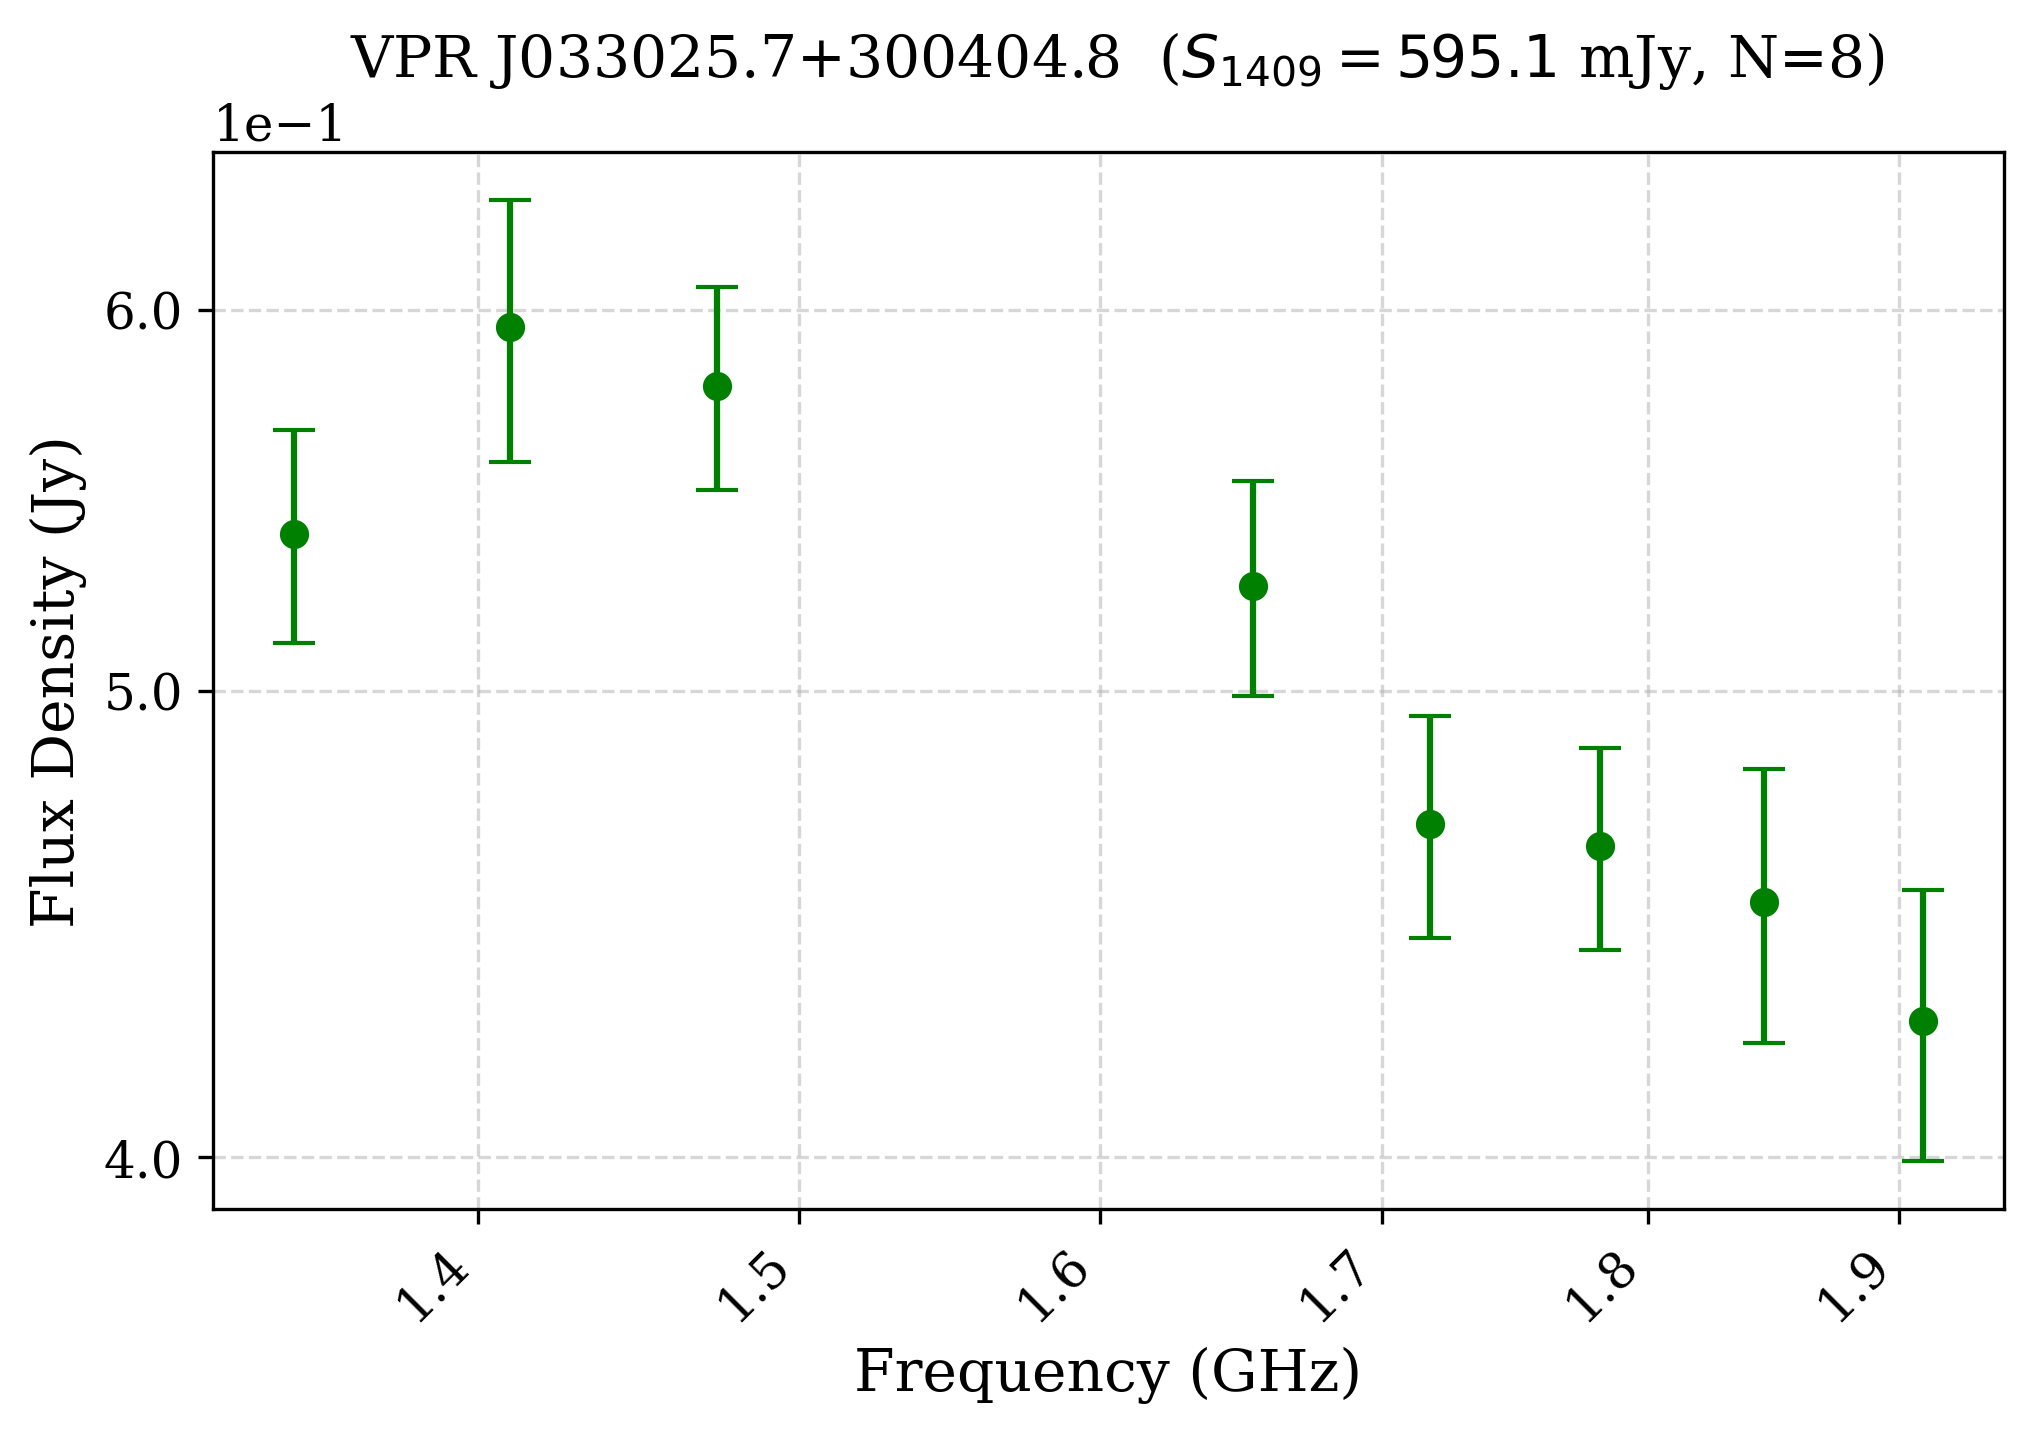

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J033025.7+300404.8_bright_nspw4_nofit.pdf


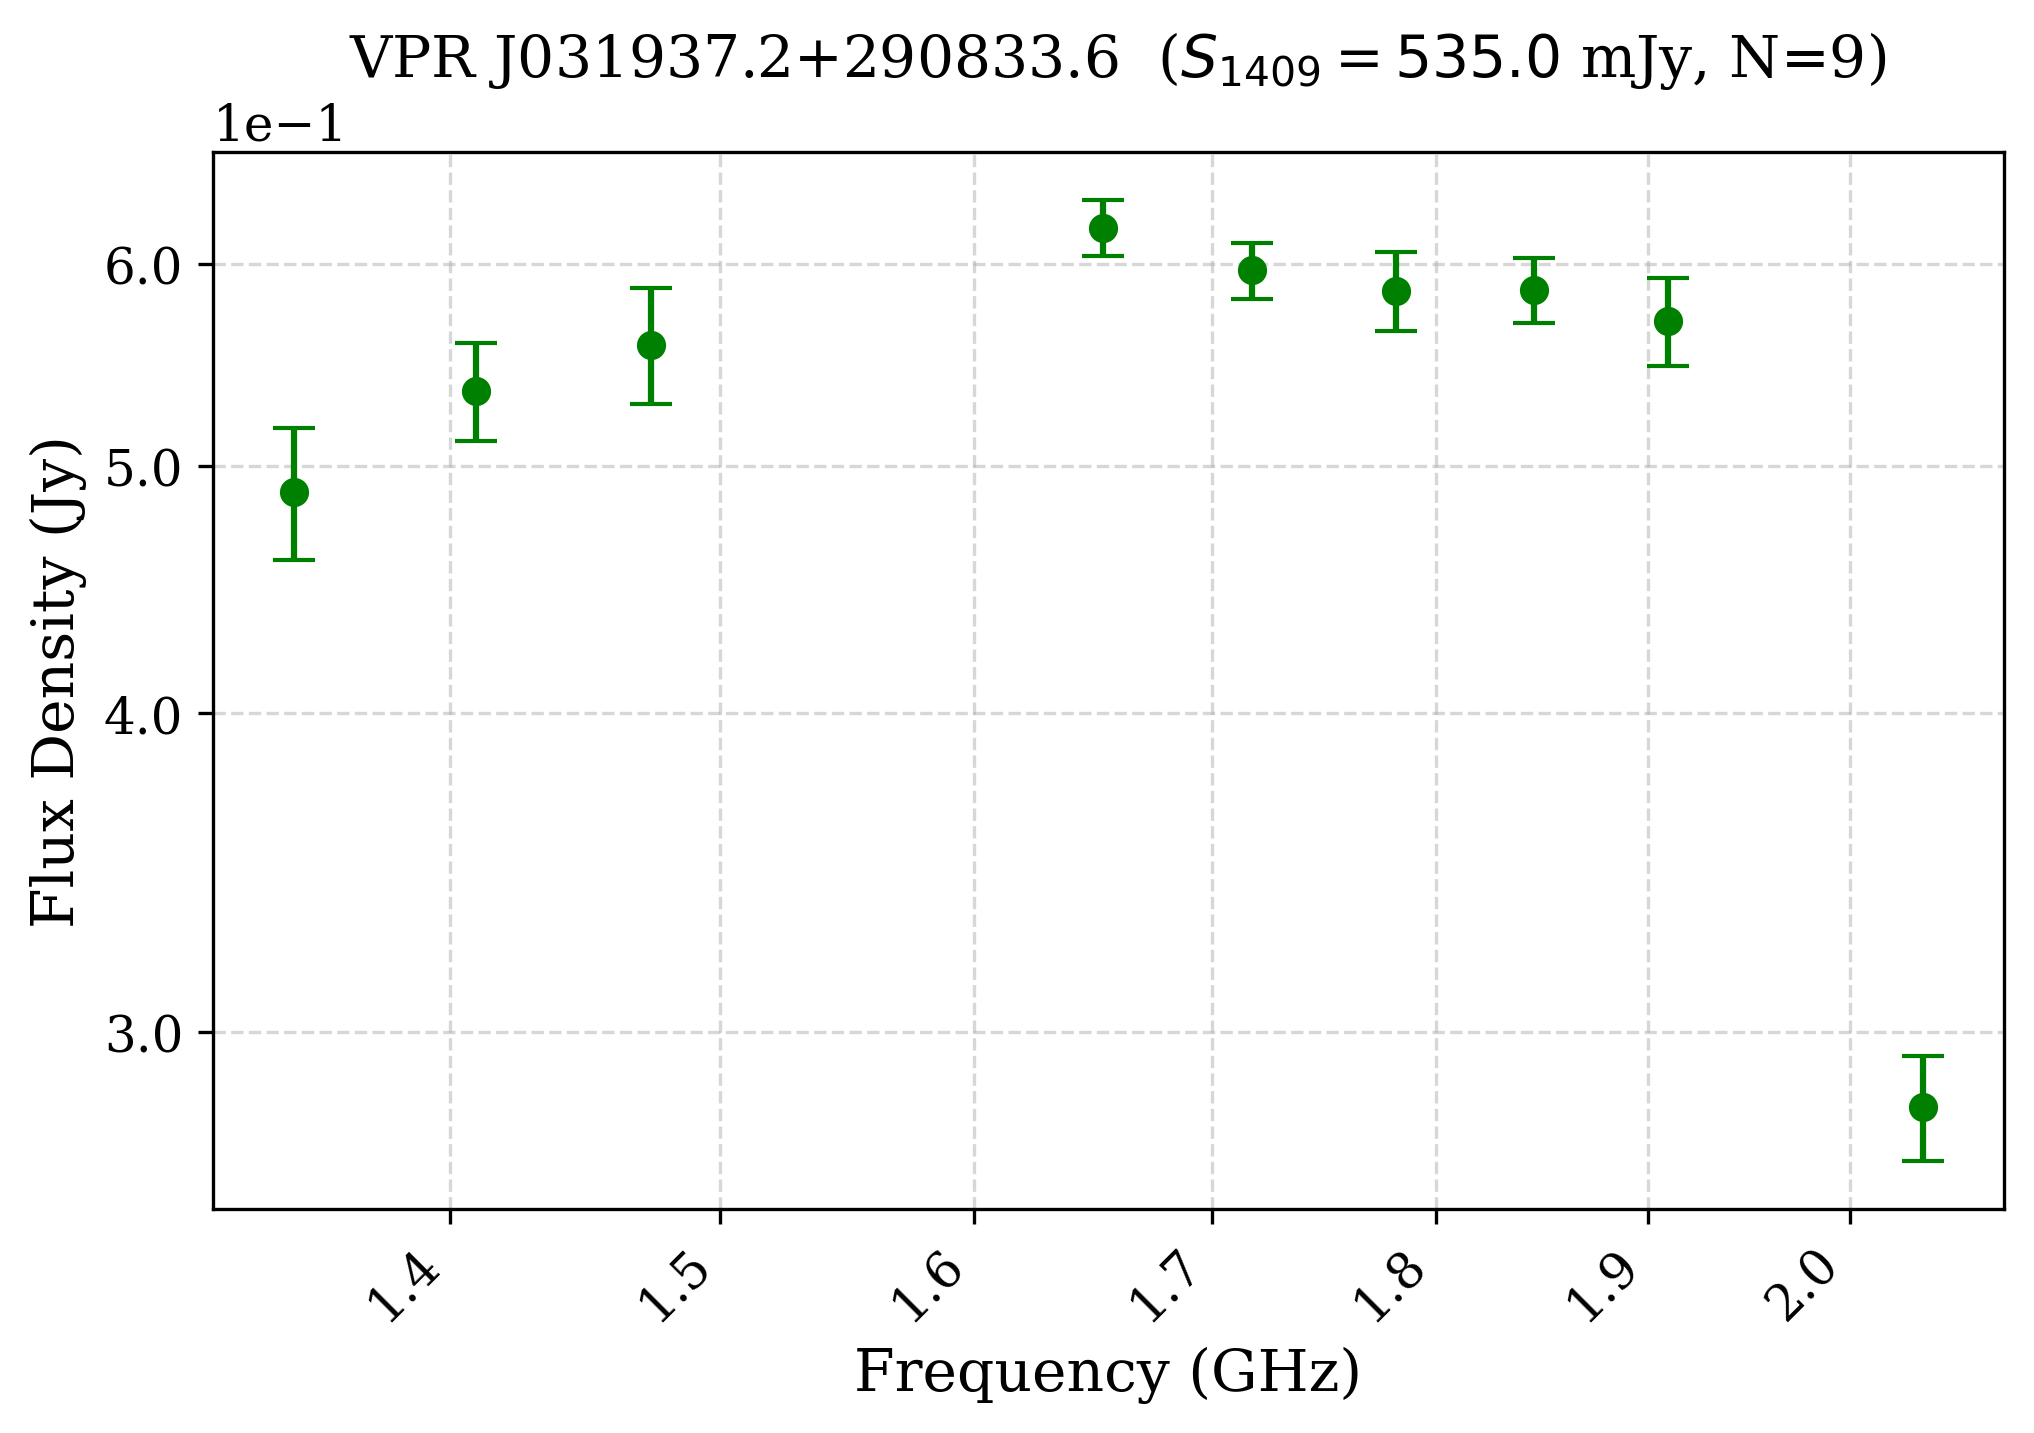

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J031937.2+290833.6_bright_nspw4_nofit.pdf


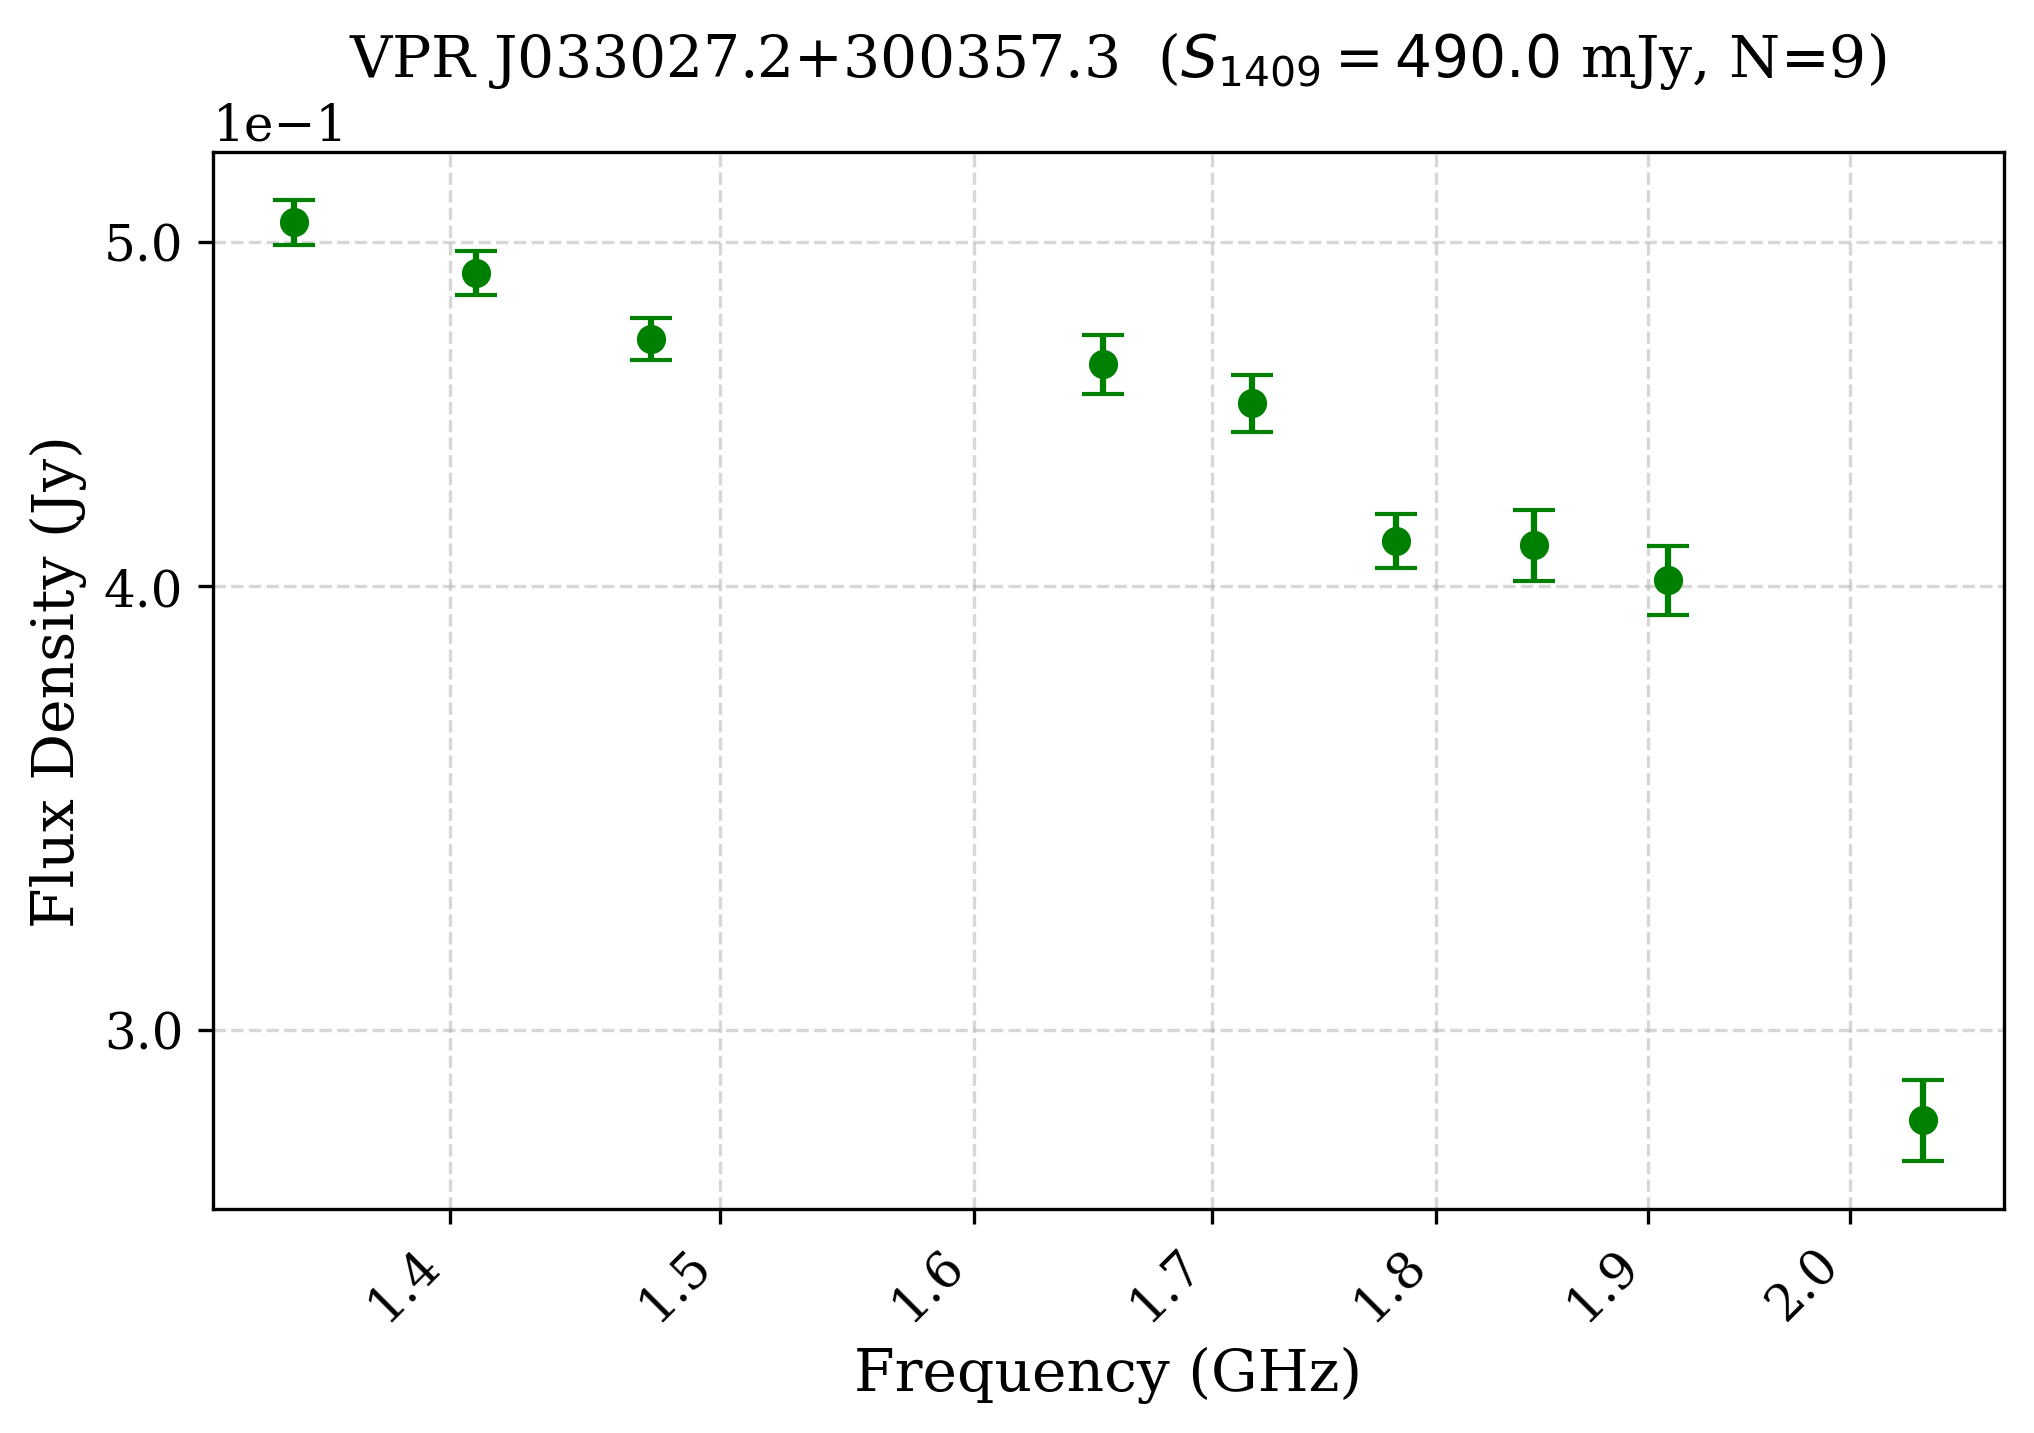

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J033027.2+300357.3_bright_nspw4_nofit.pdf


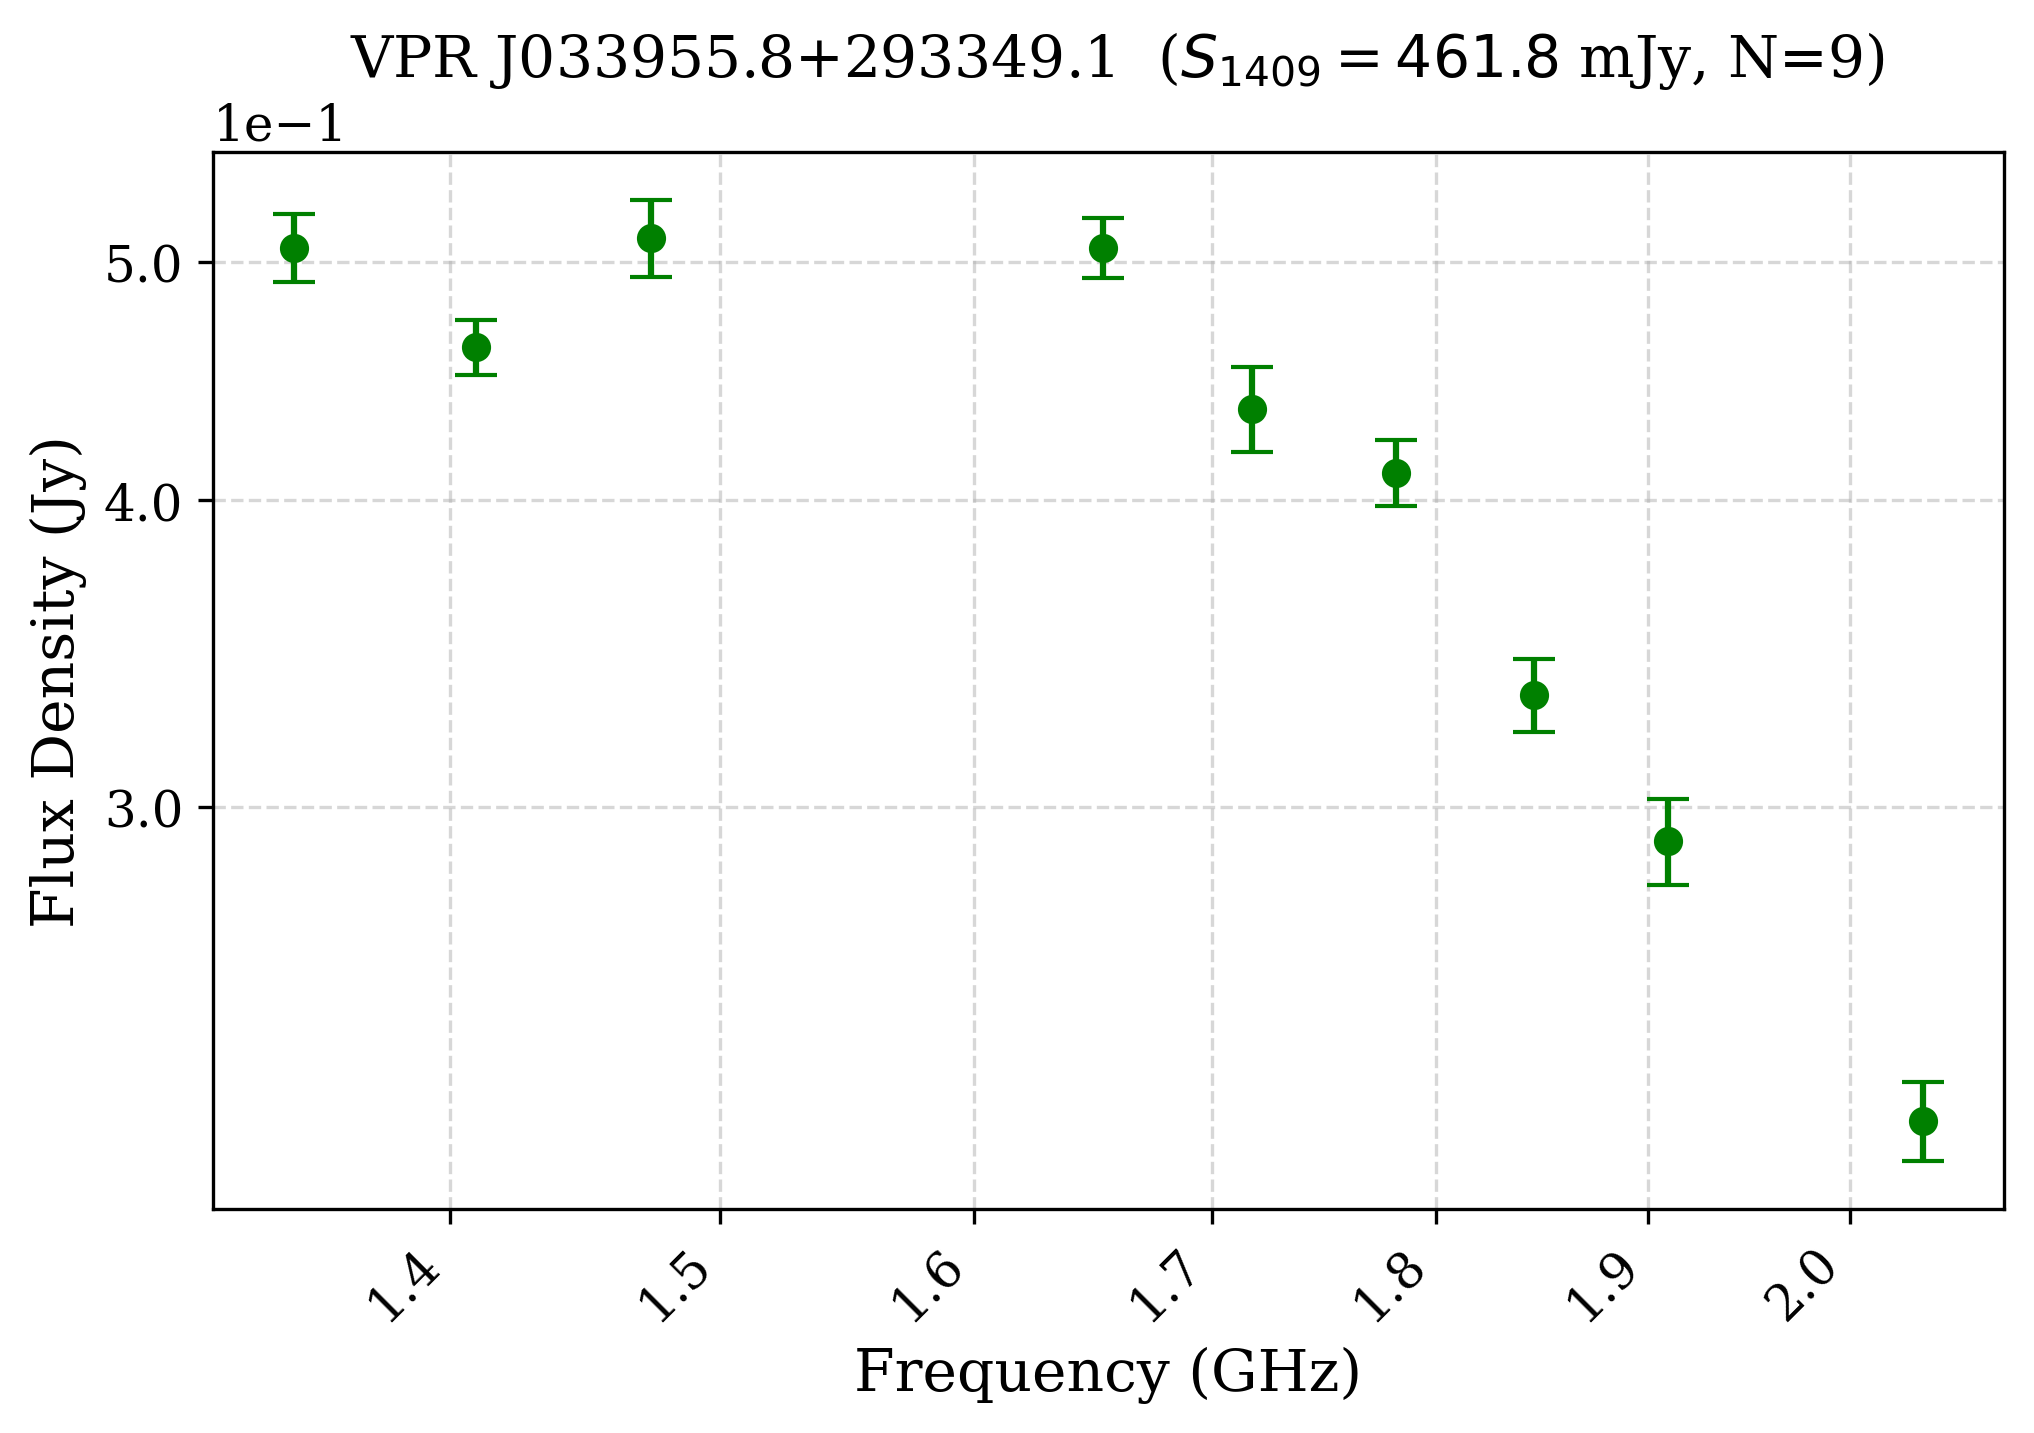

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J033955.8+293349.1_bright_nspw4_nofit.pdf


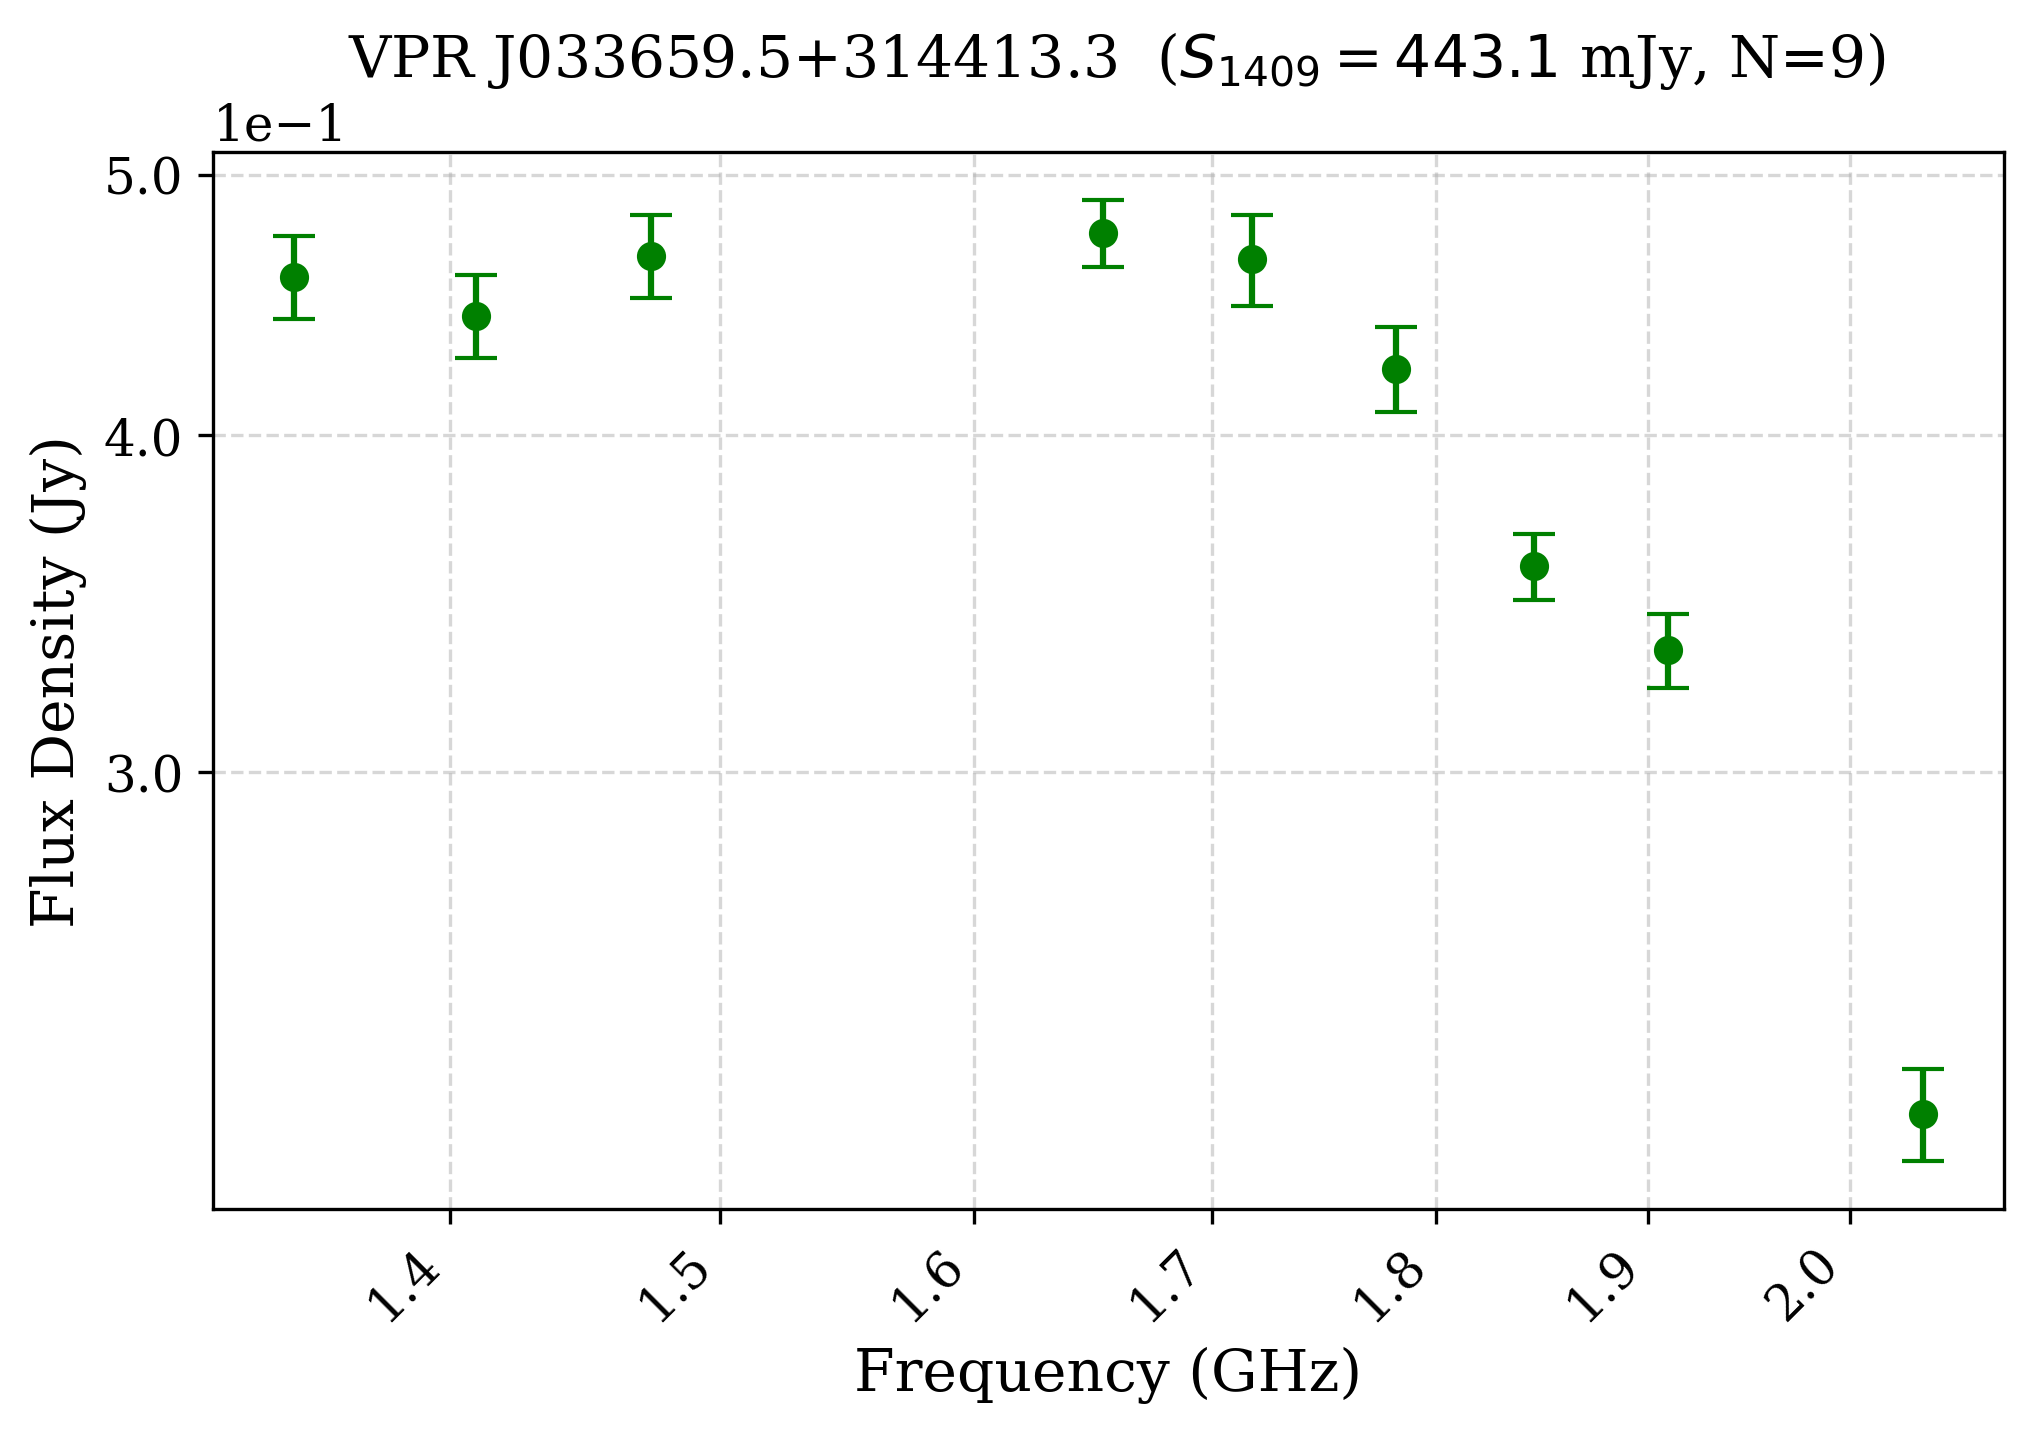

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J033659.5+314413.3_bright_nspw4_nofit.pdf


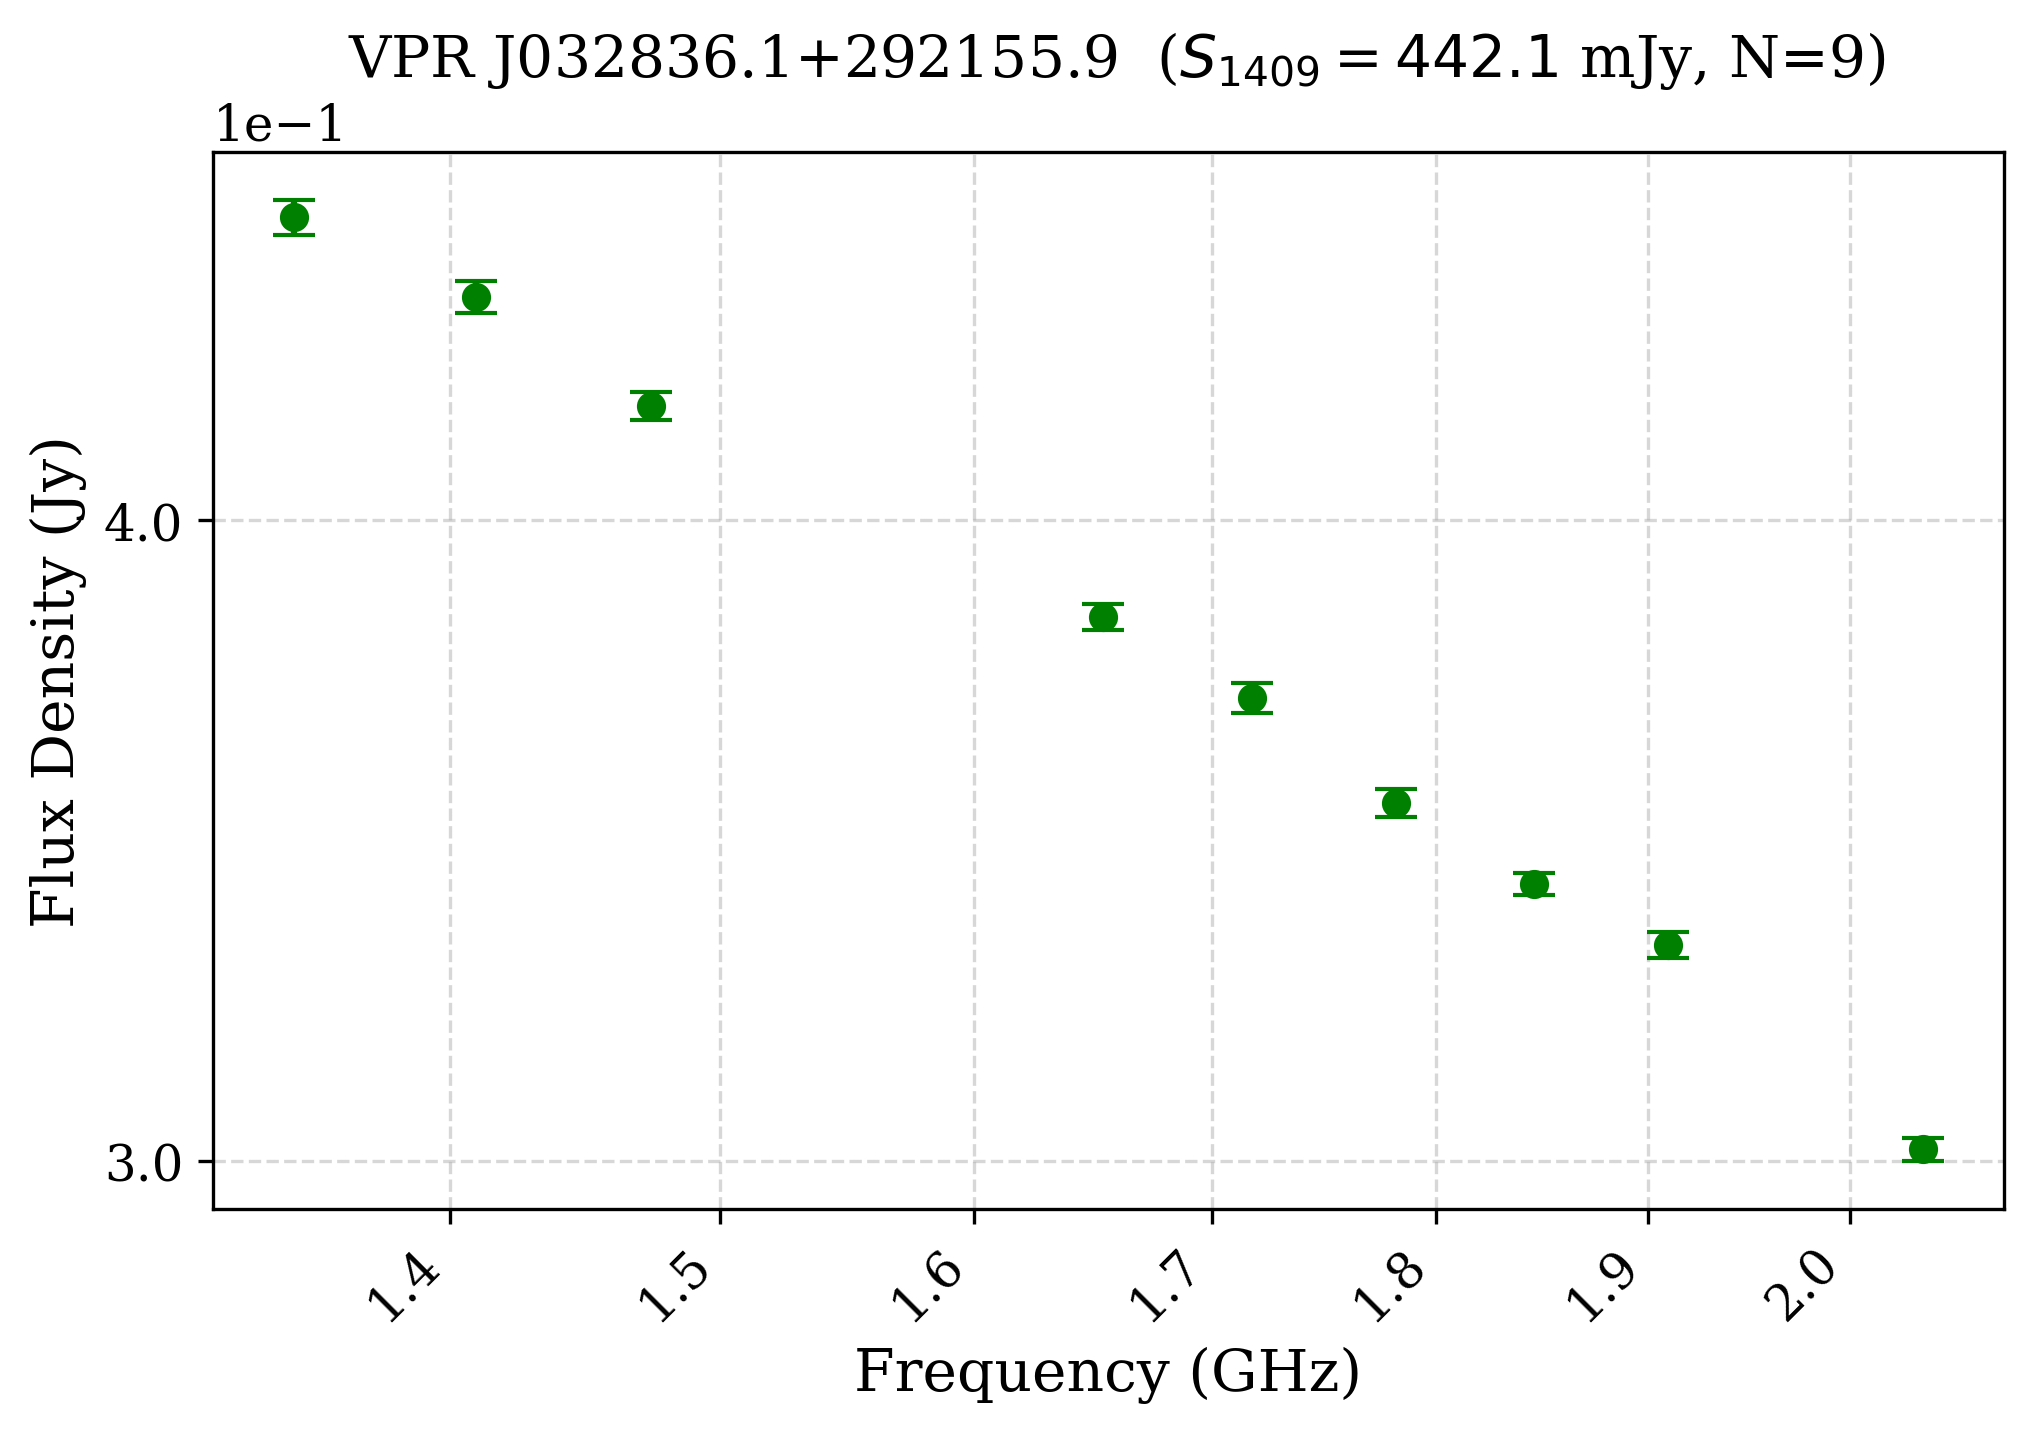

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J032836.1+292155.9_bright_nspw4_nofit.pdf


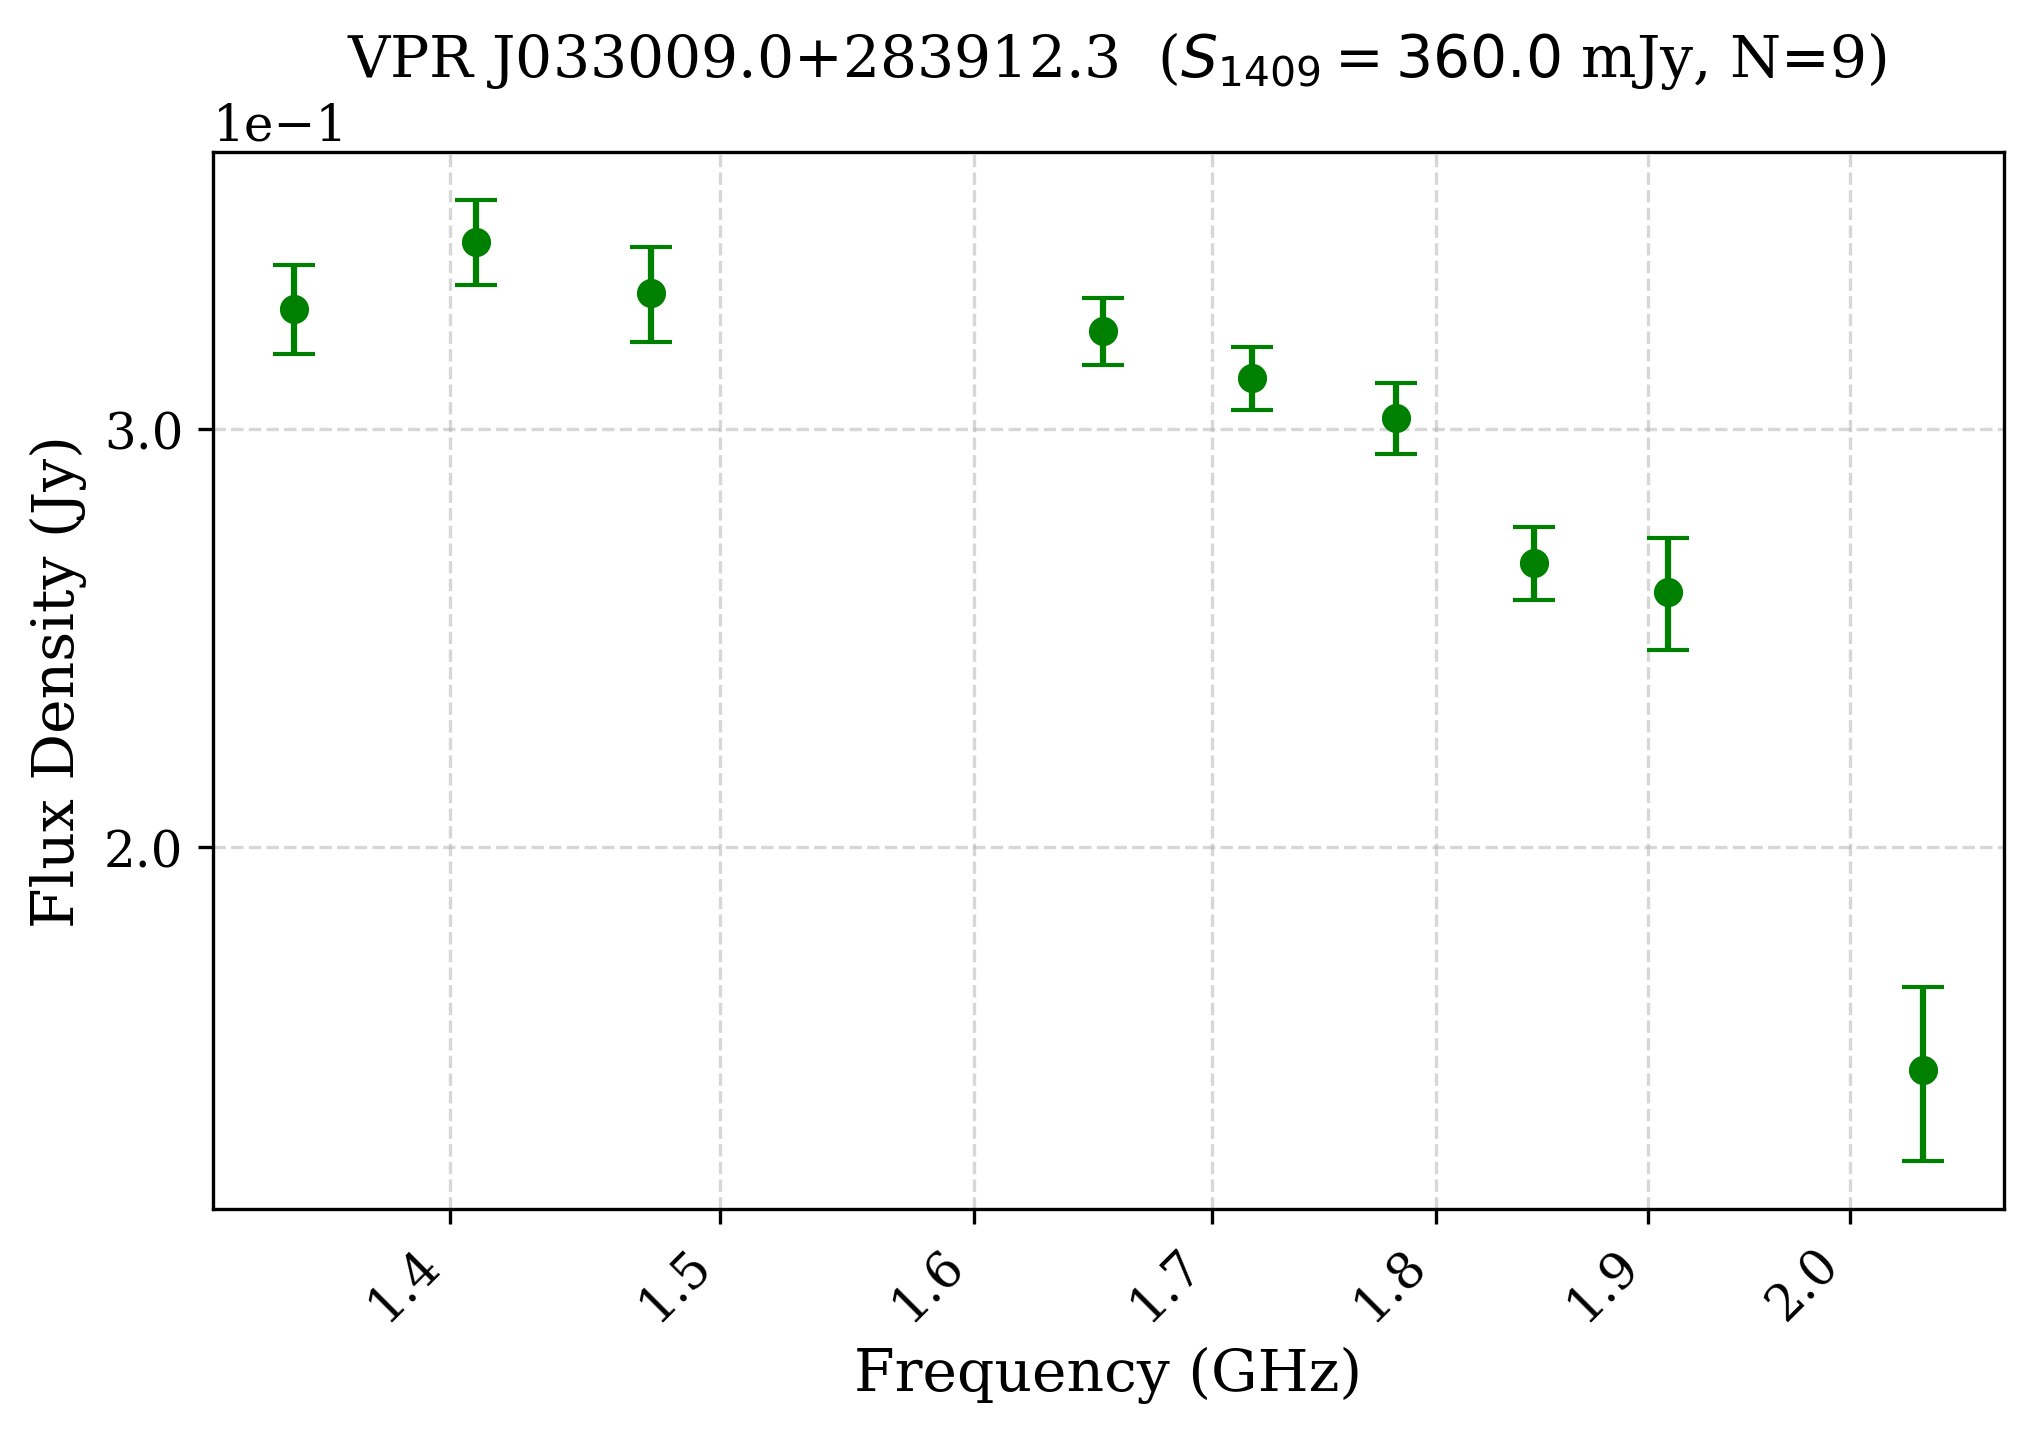

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J033009.0+283912.3_bright_nspw4_nofit.pdf


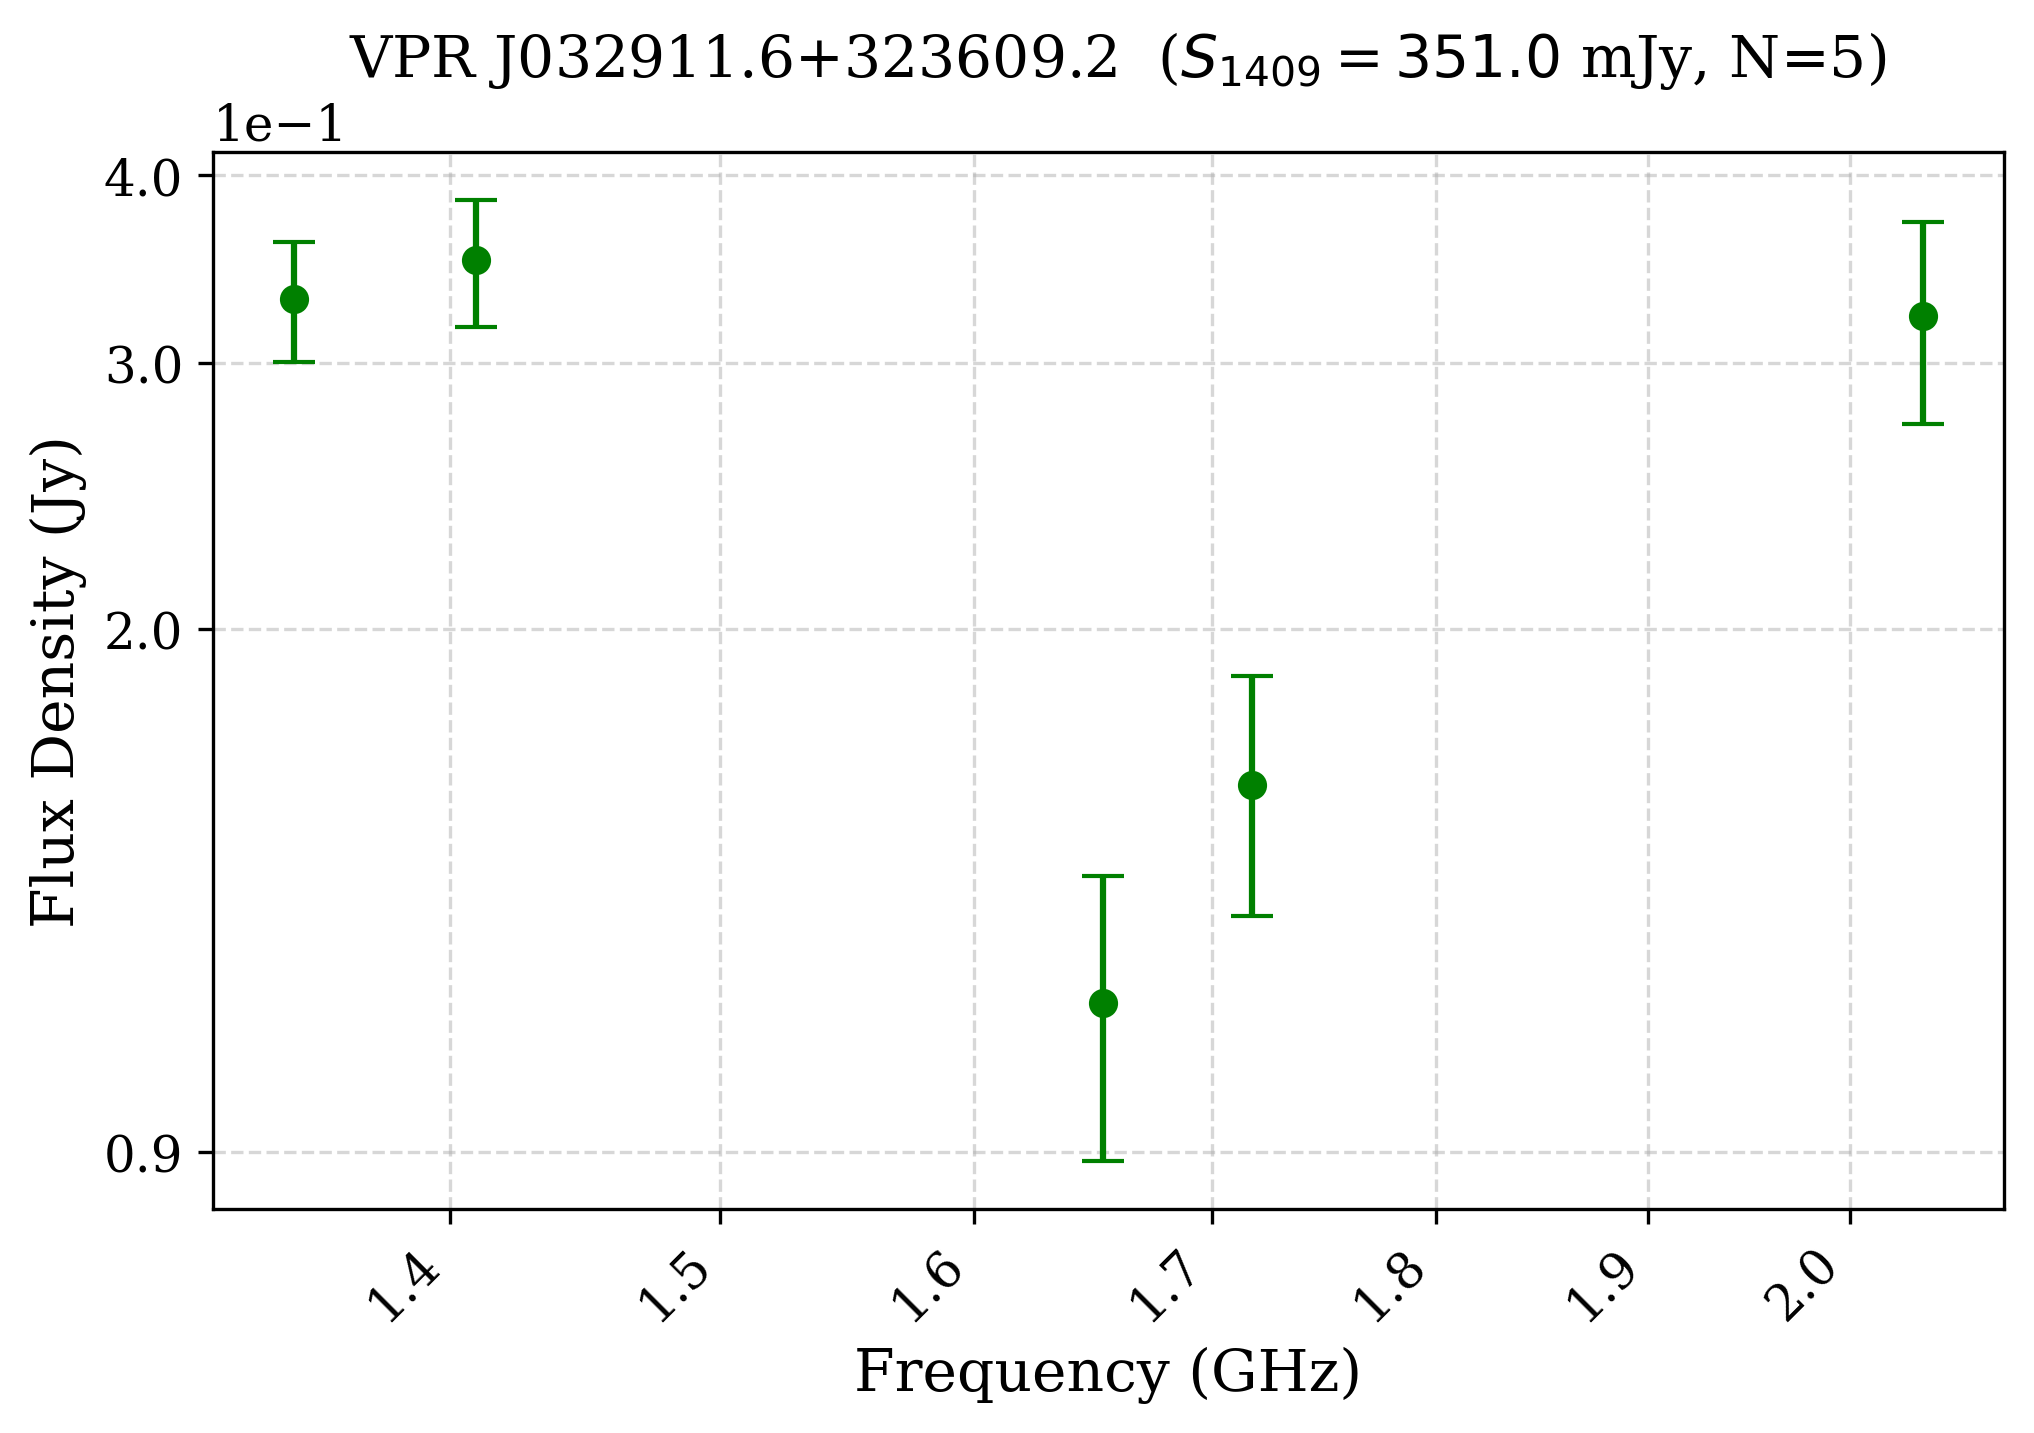

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J032911.6+323609.2_bright_nspw4_nofit.pdf


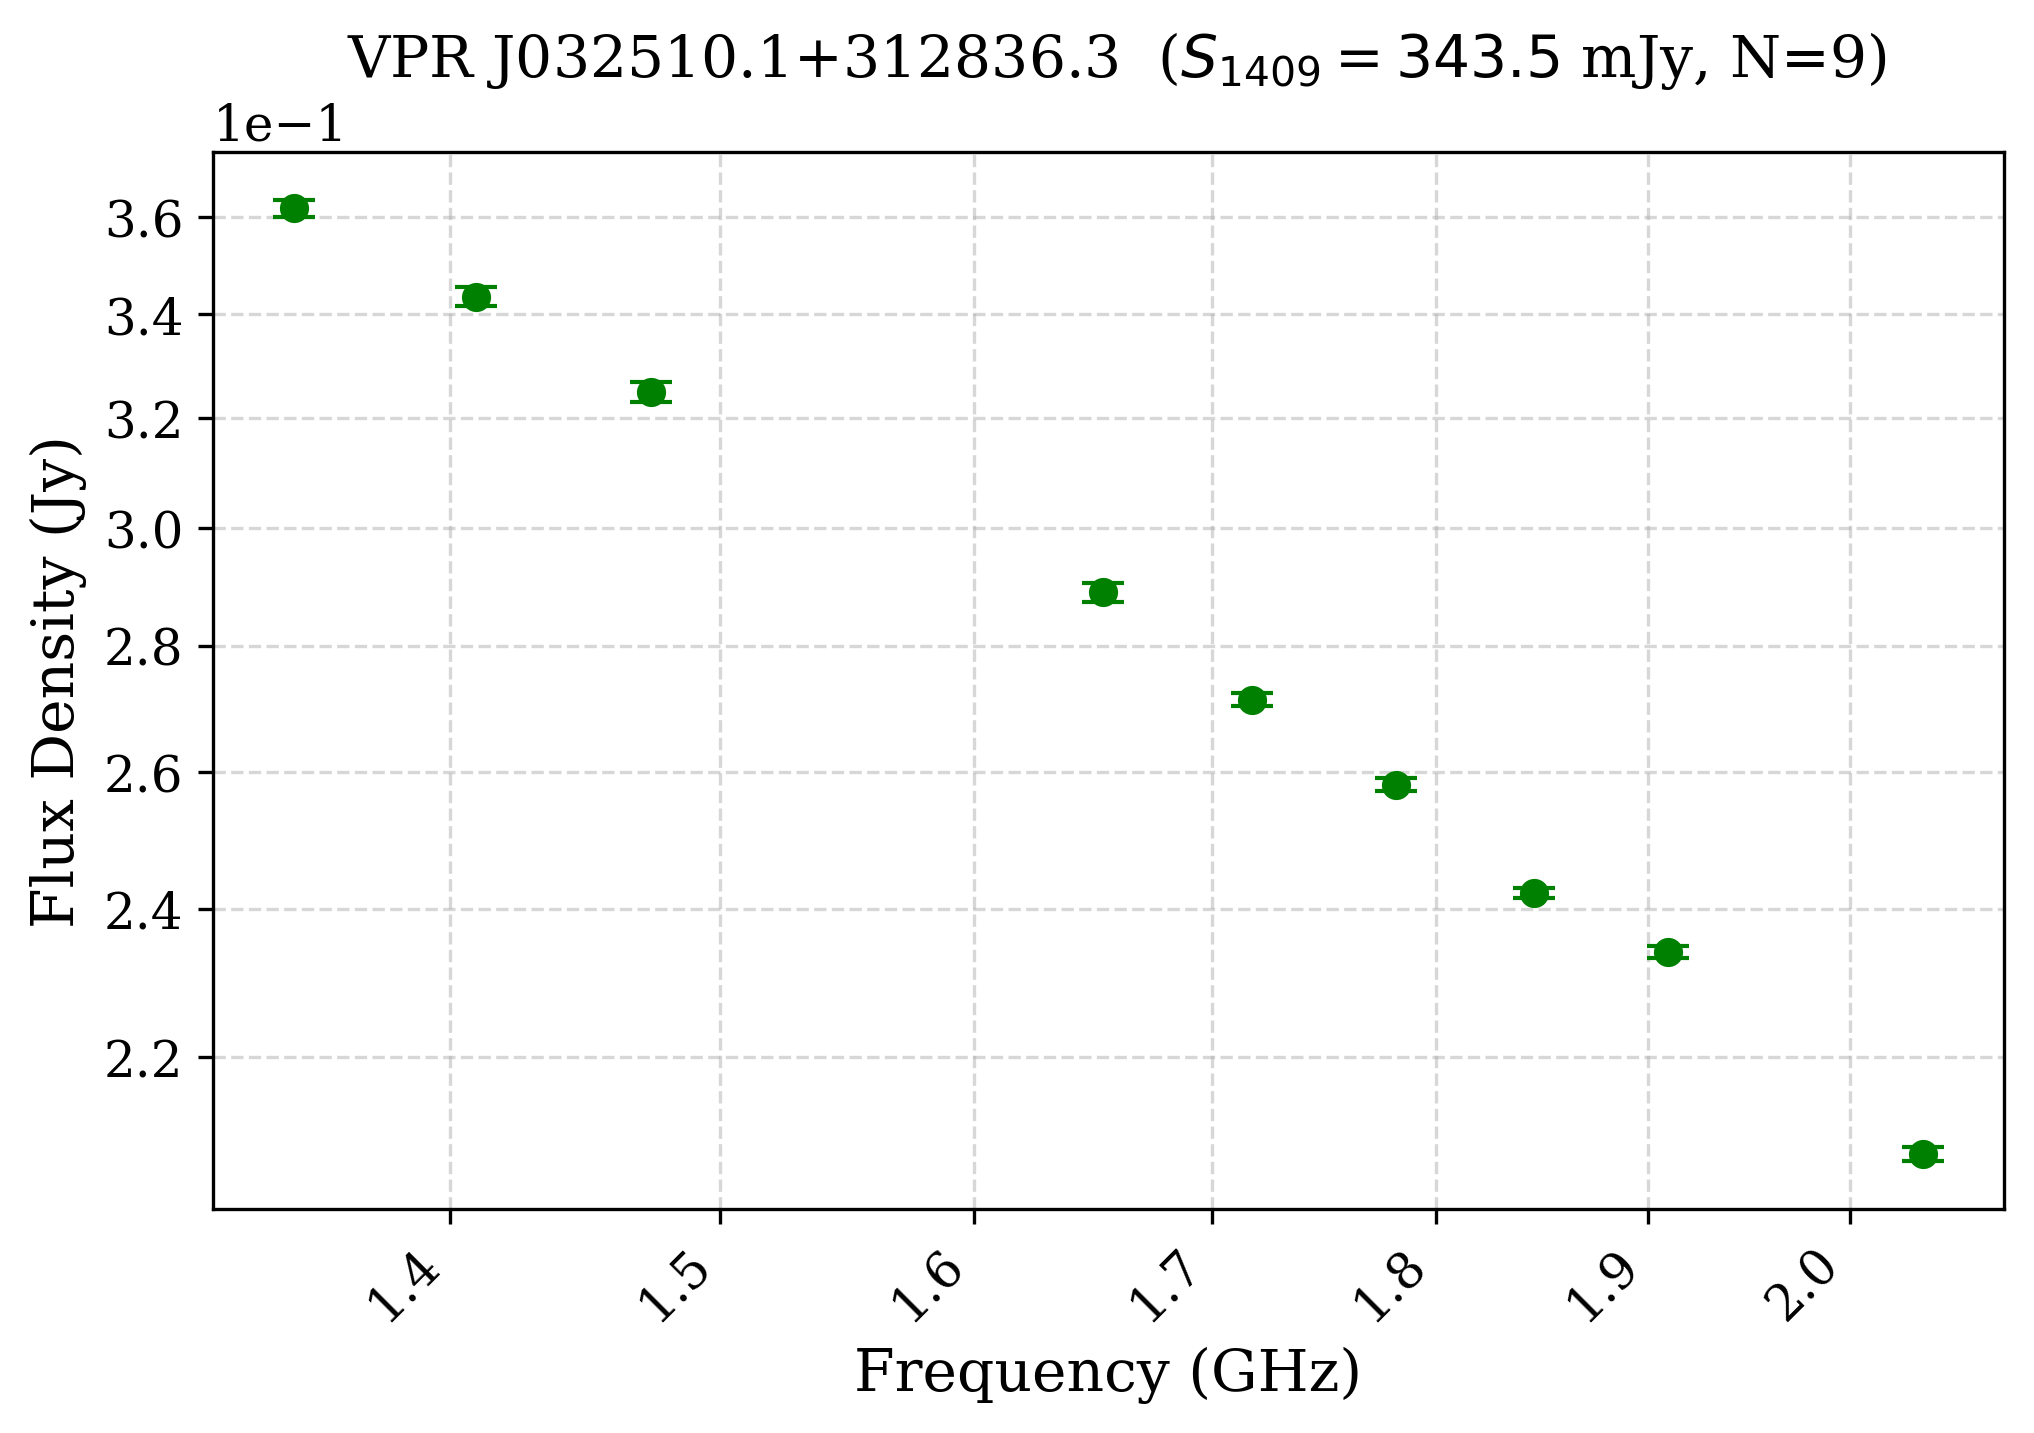

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J032510.1+312836.3_bright_nspw4_nofit.pdf


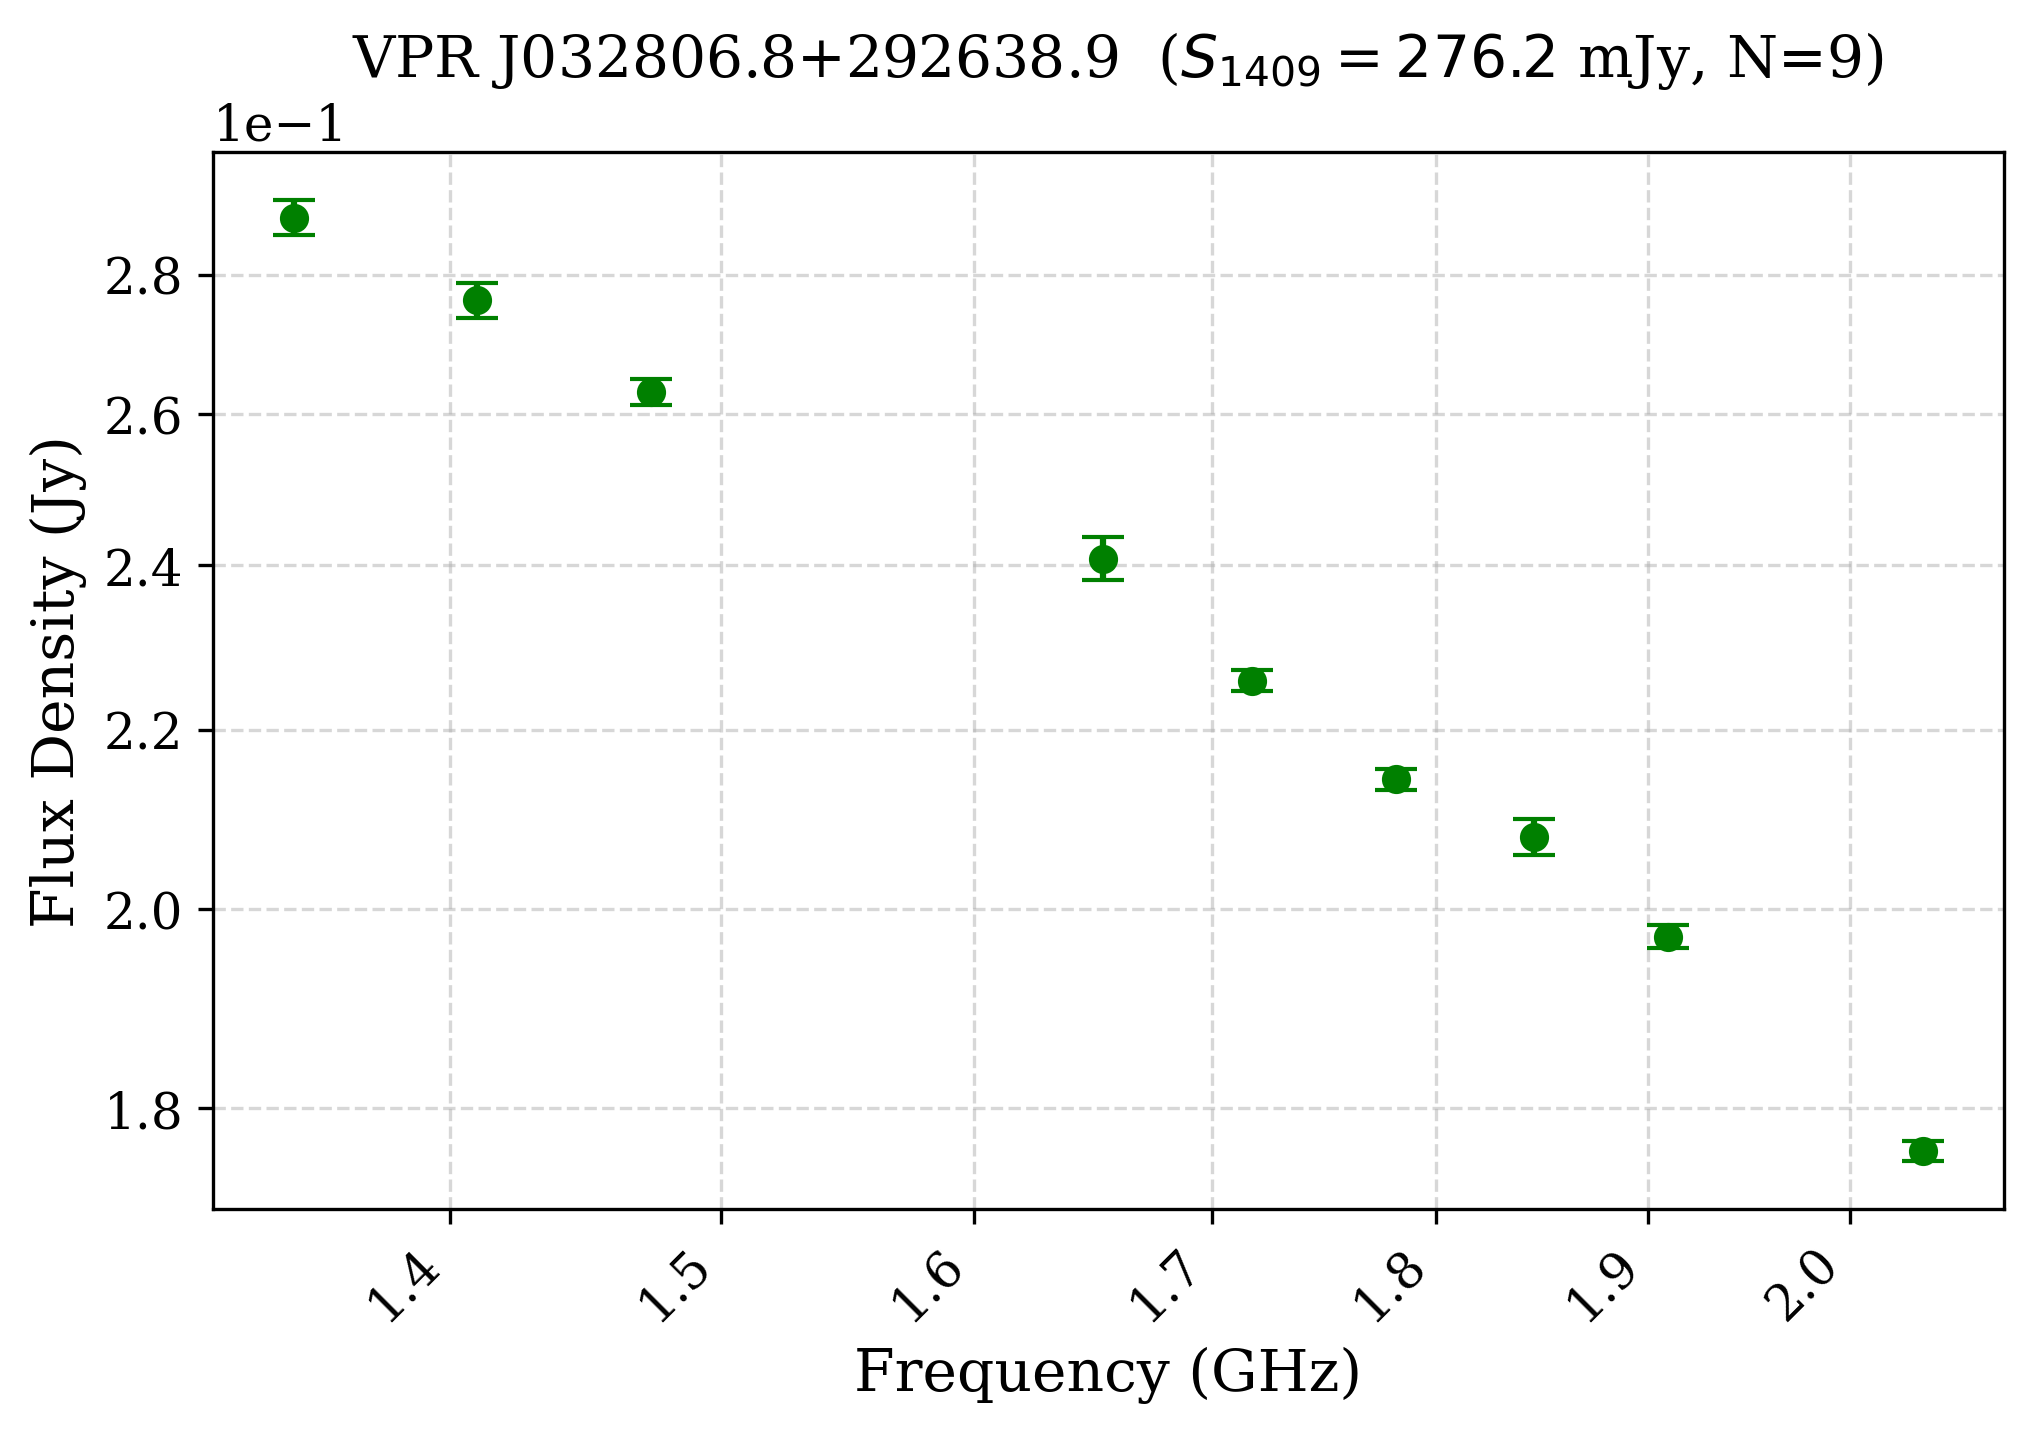

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J032806.8+292638.9_bright_nspw4_nofit.pdf


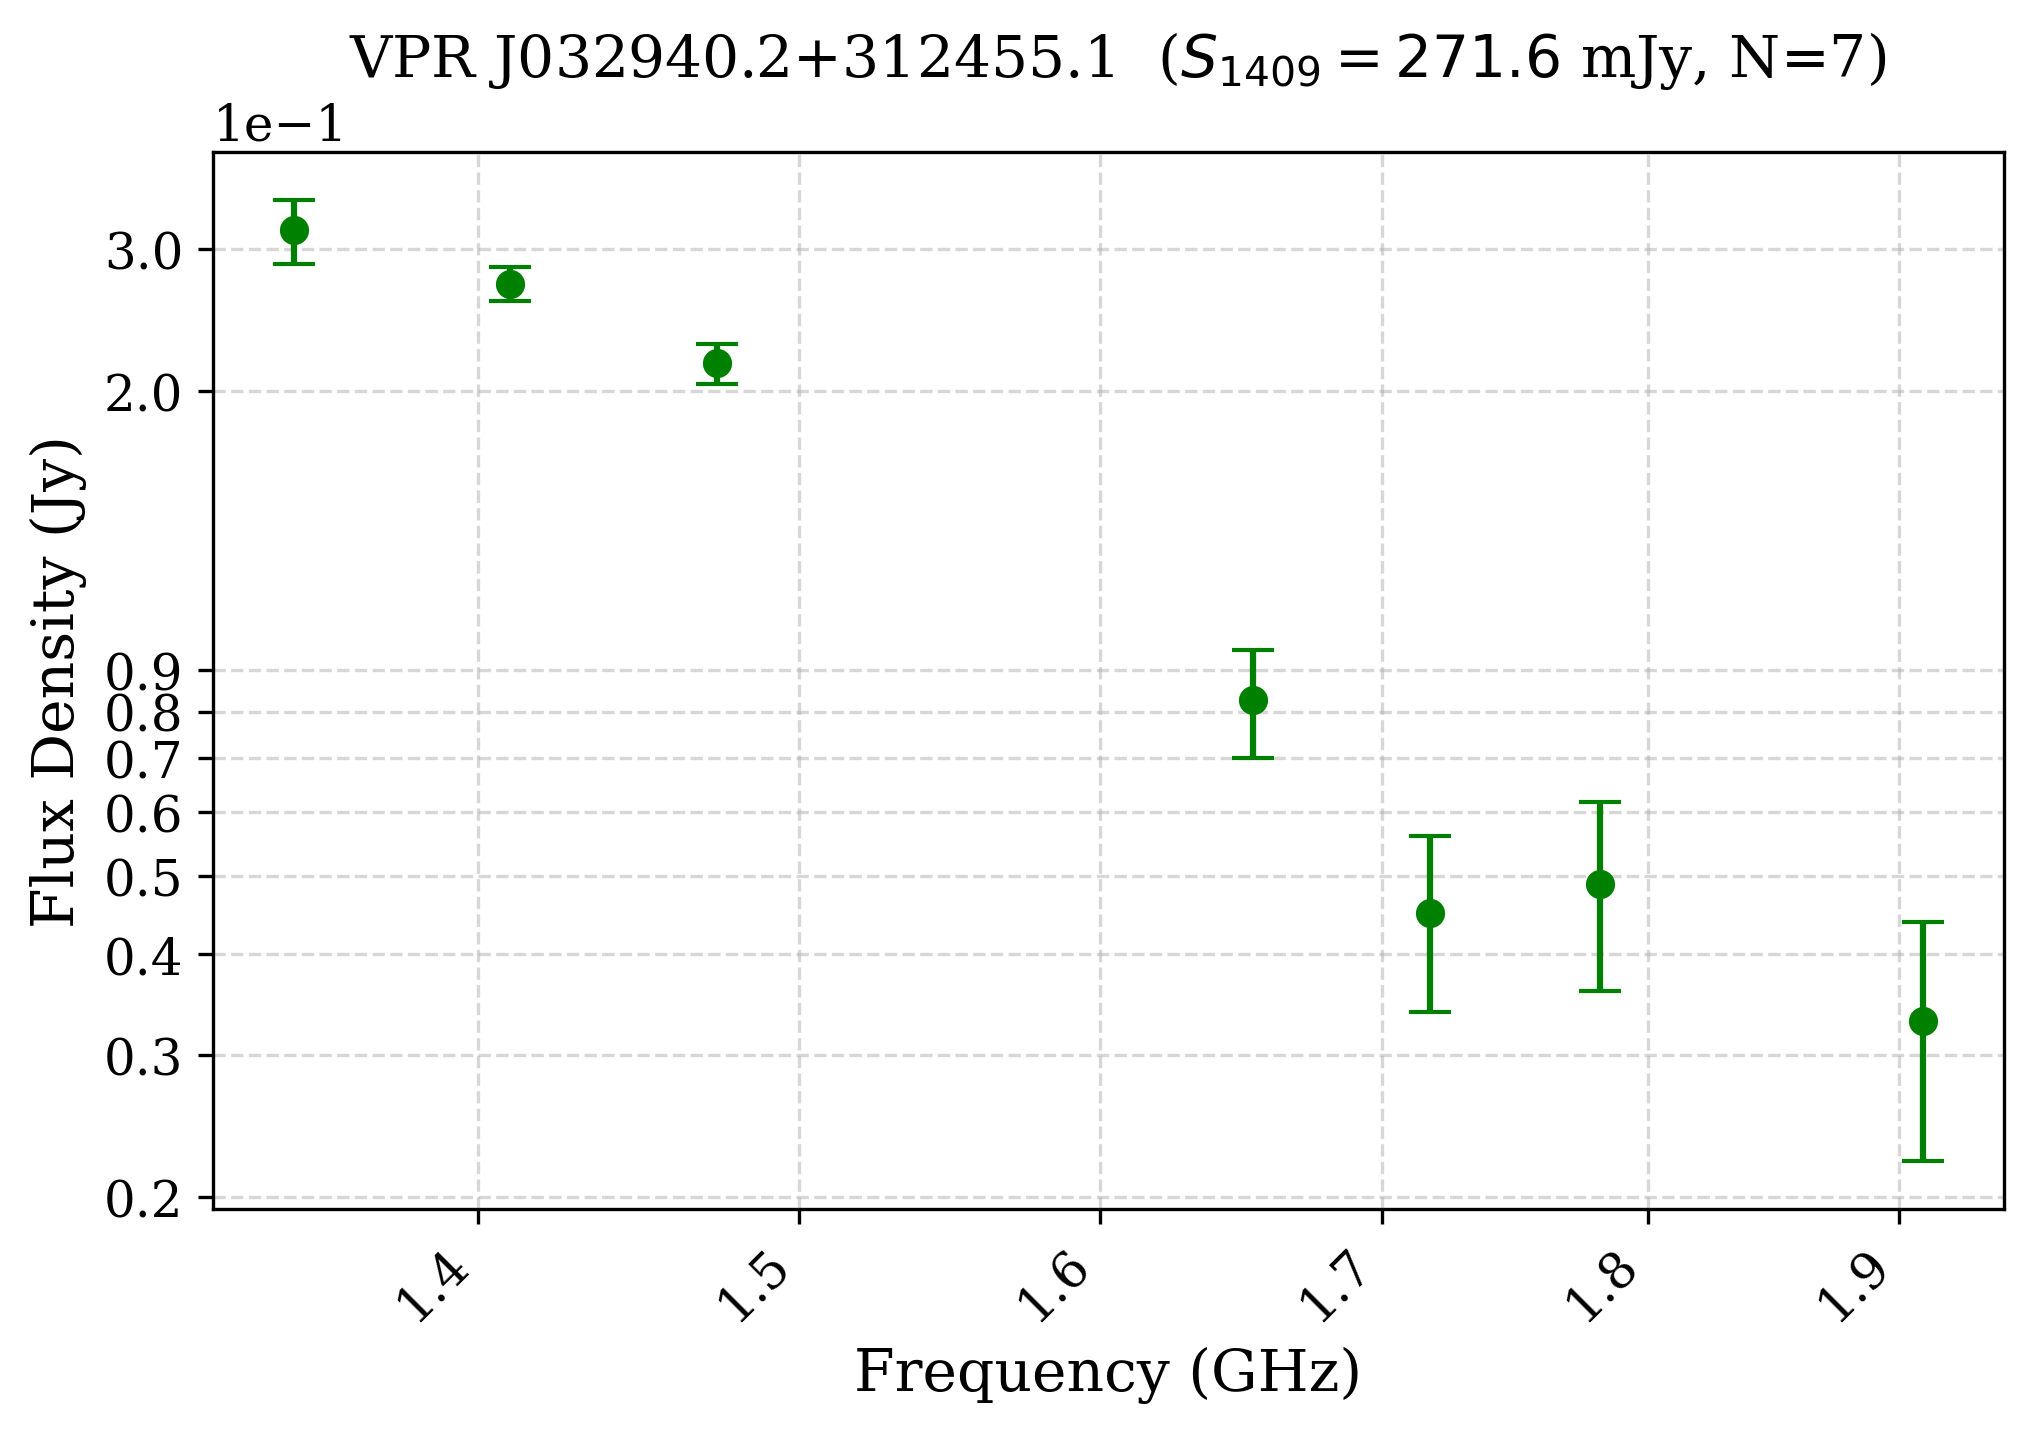

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J032940.2+312455.1_bright_nspw4_nofit.pdf


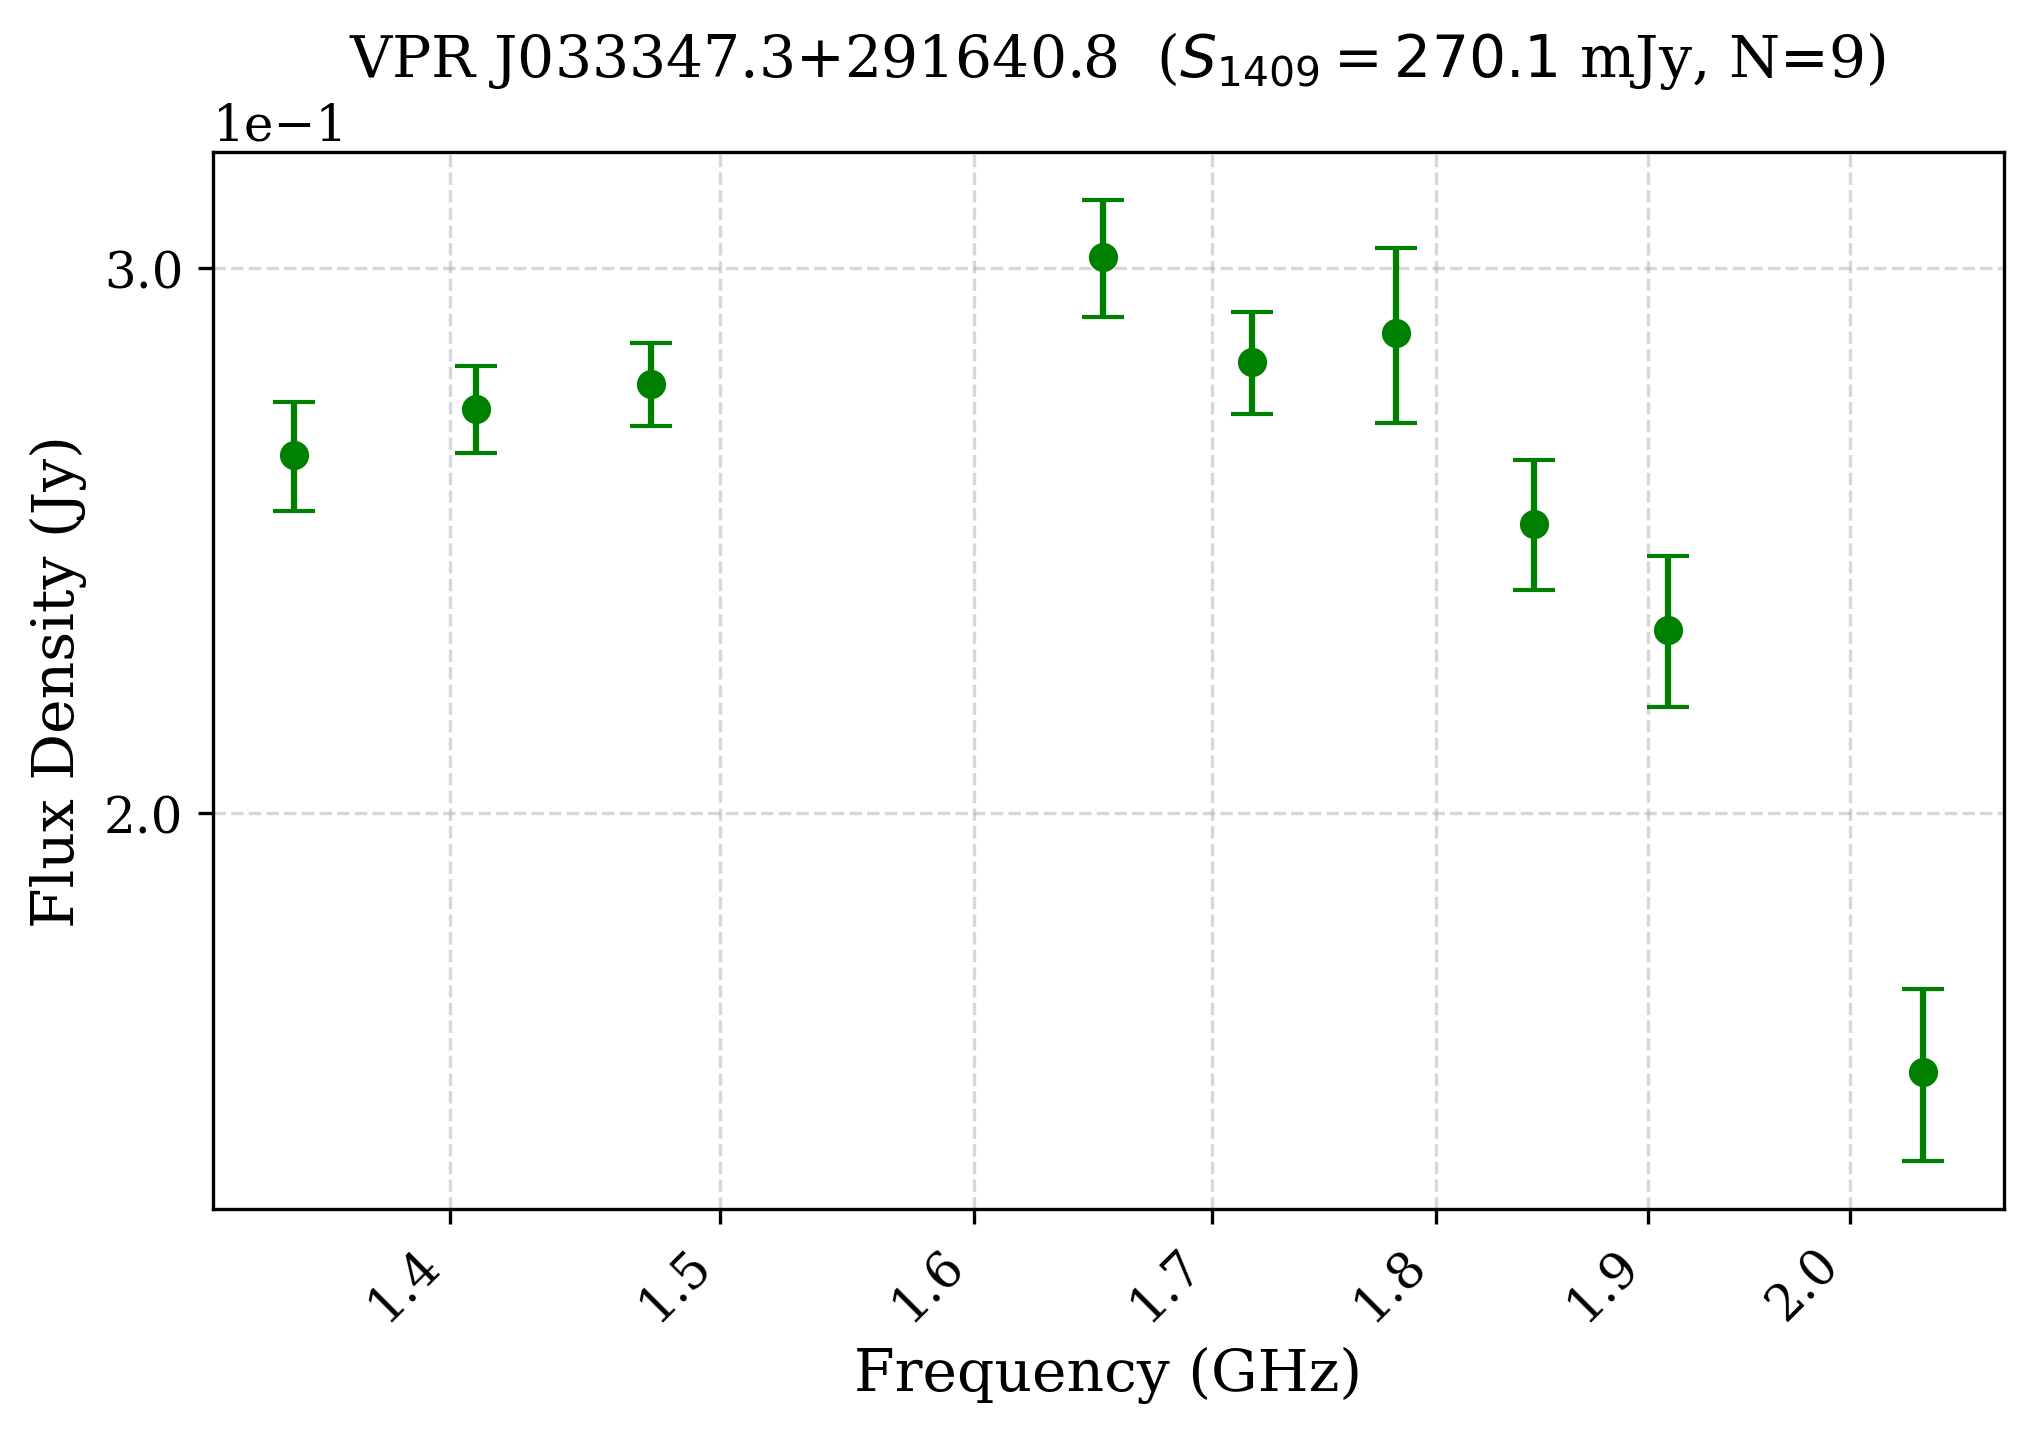

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J033347.3+291640.8_bright_nspw4_nofit.pdf


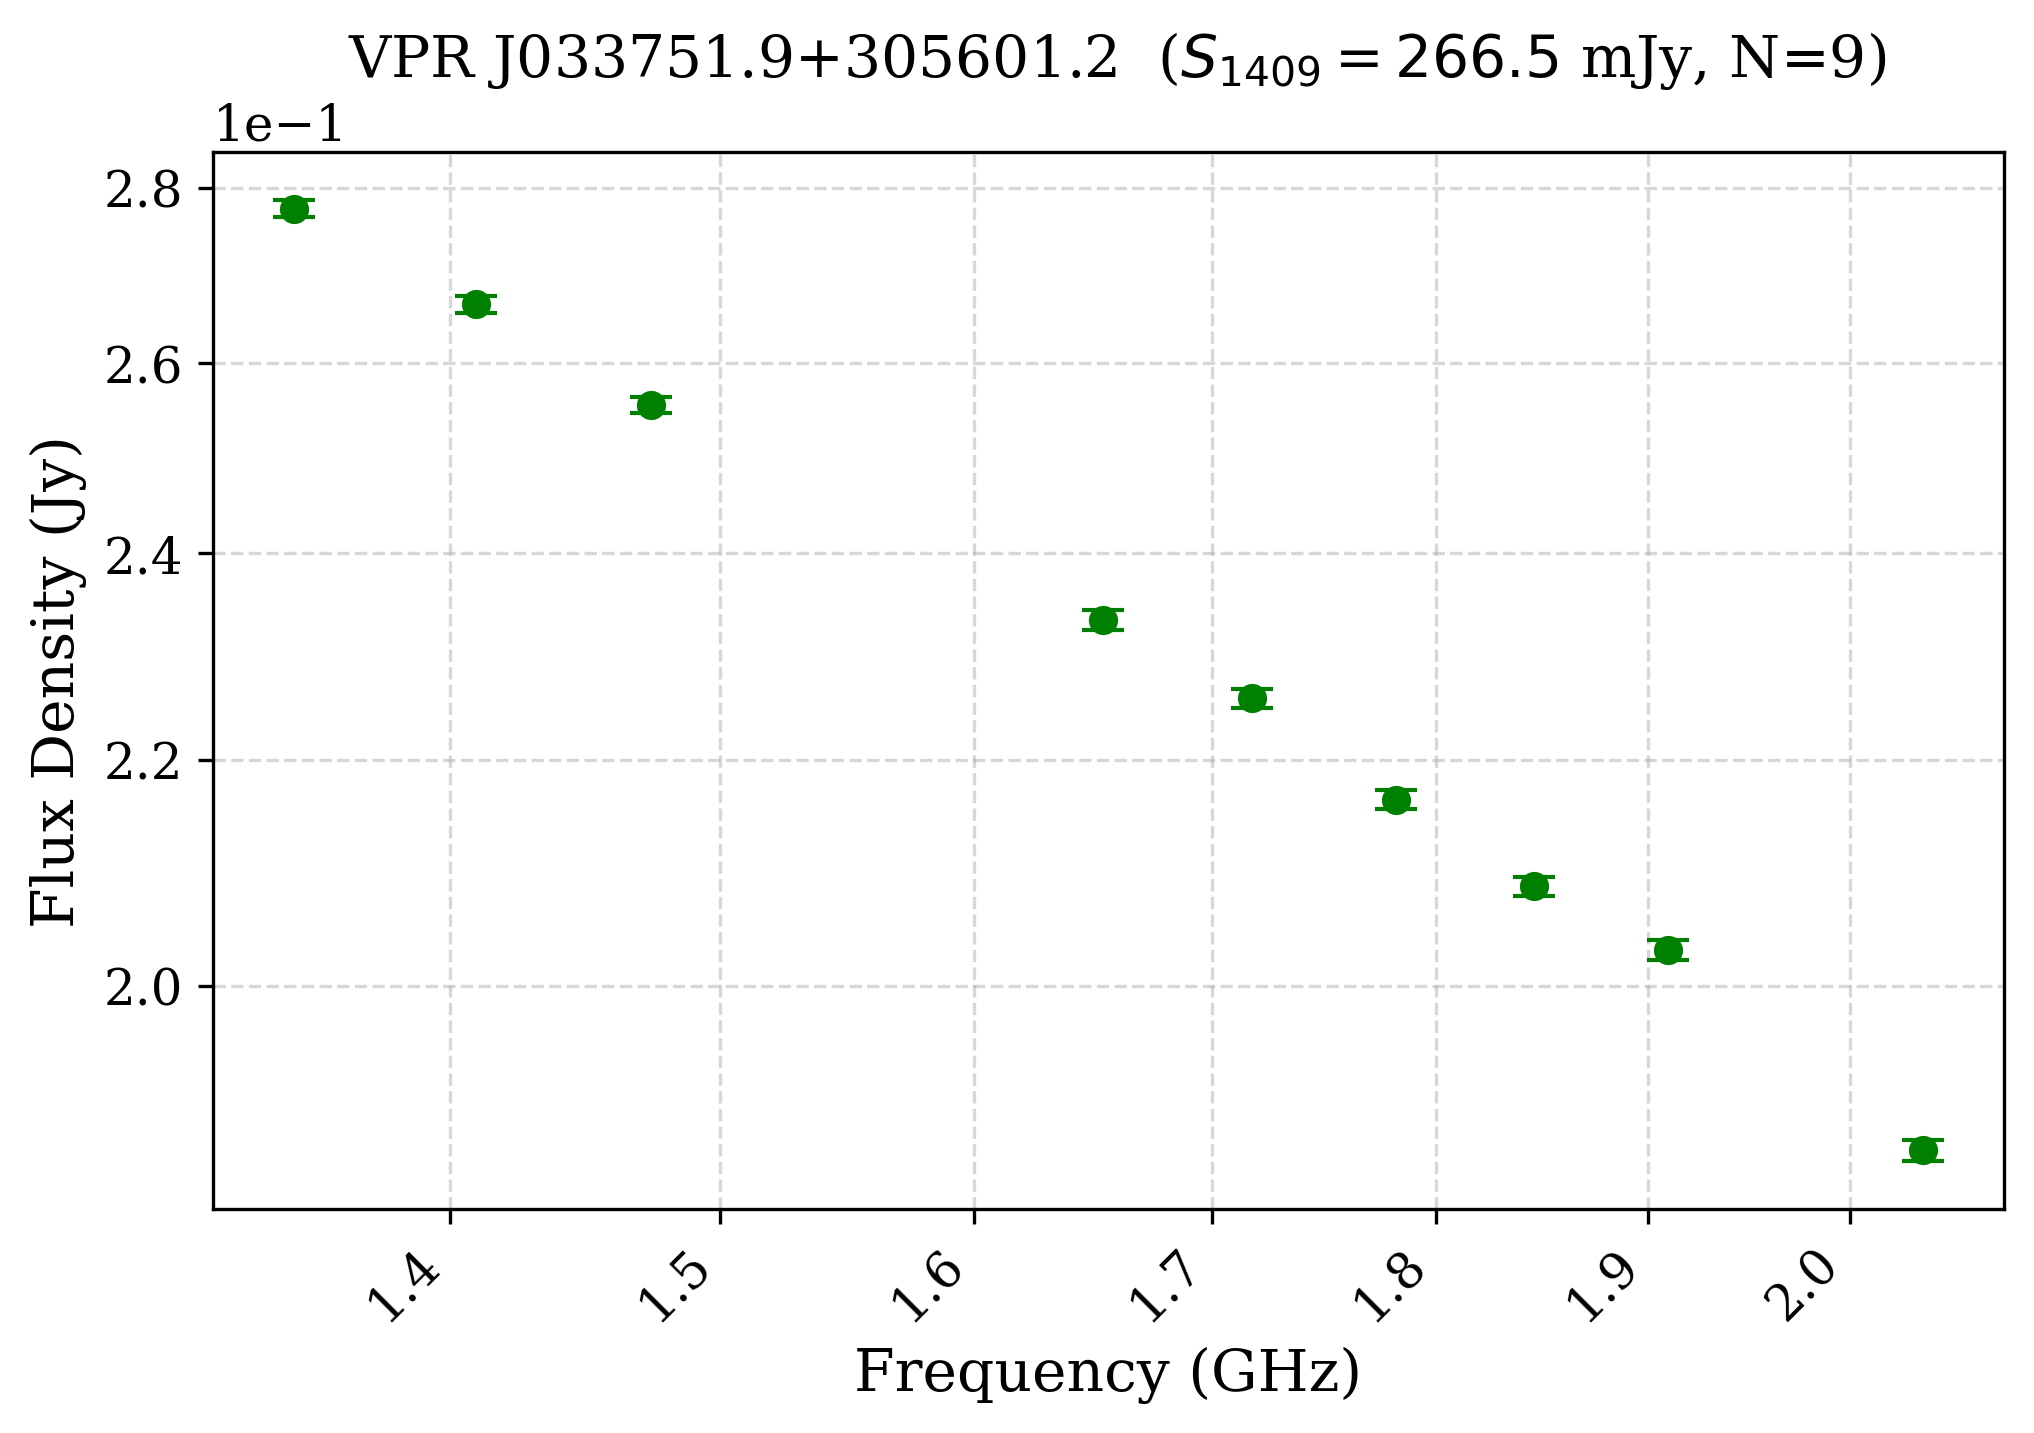

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J033751.9+305601.2_bright_nspw4_nofit.pdf


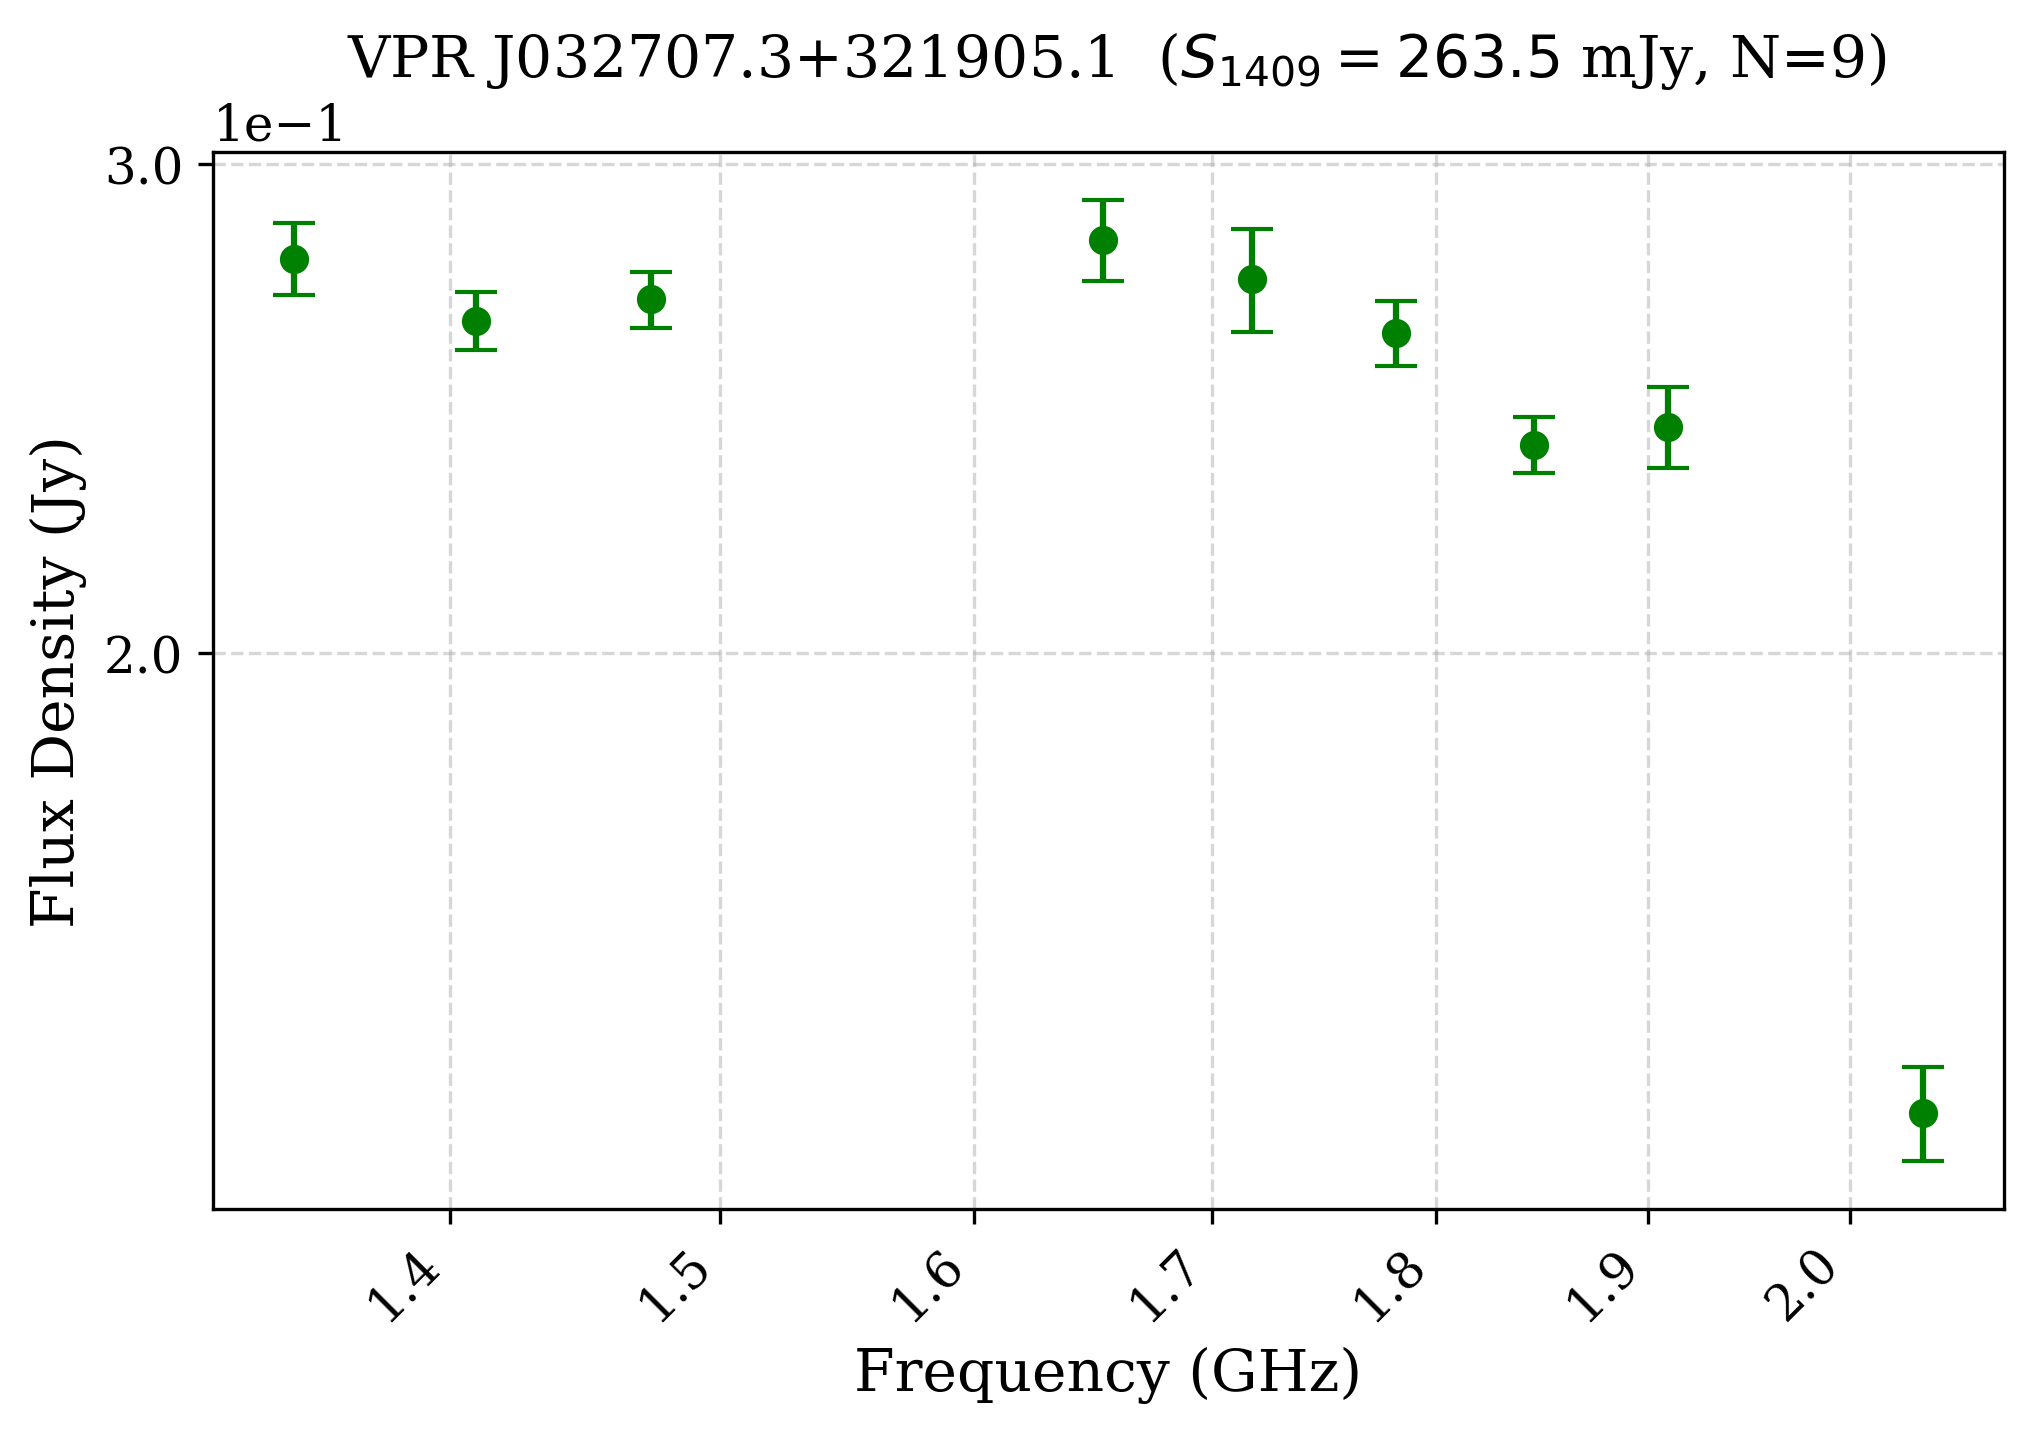

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J032707.3+321905.1_bright_nspw4_nofit.pdf


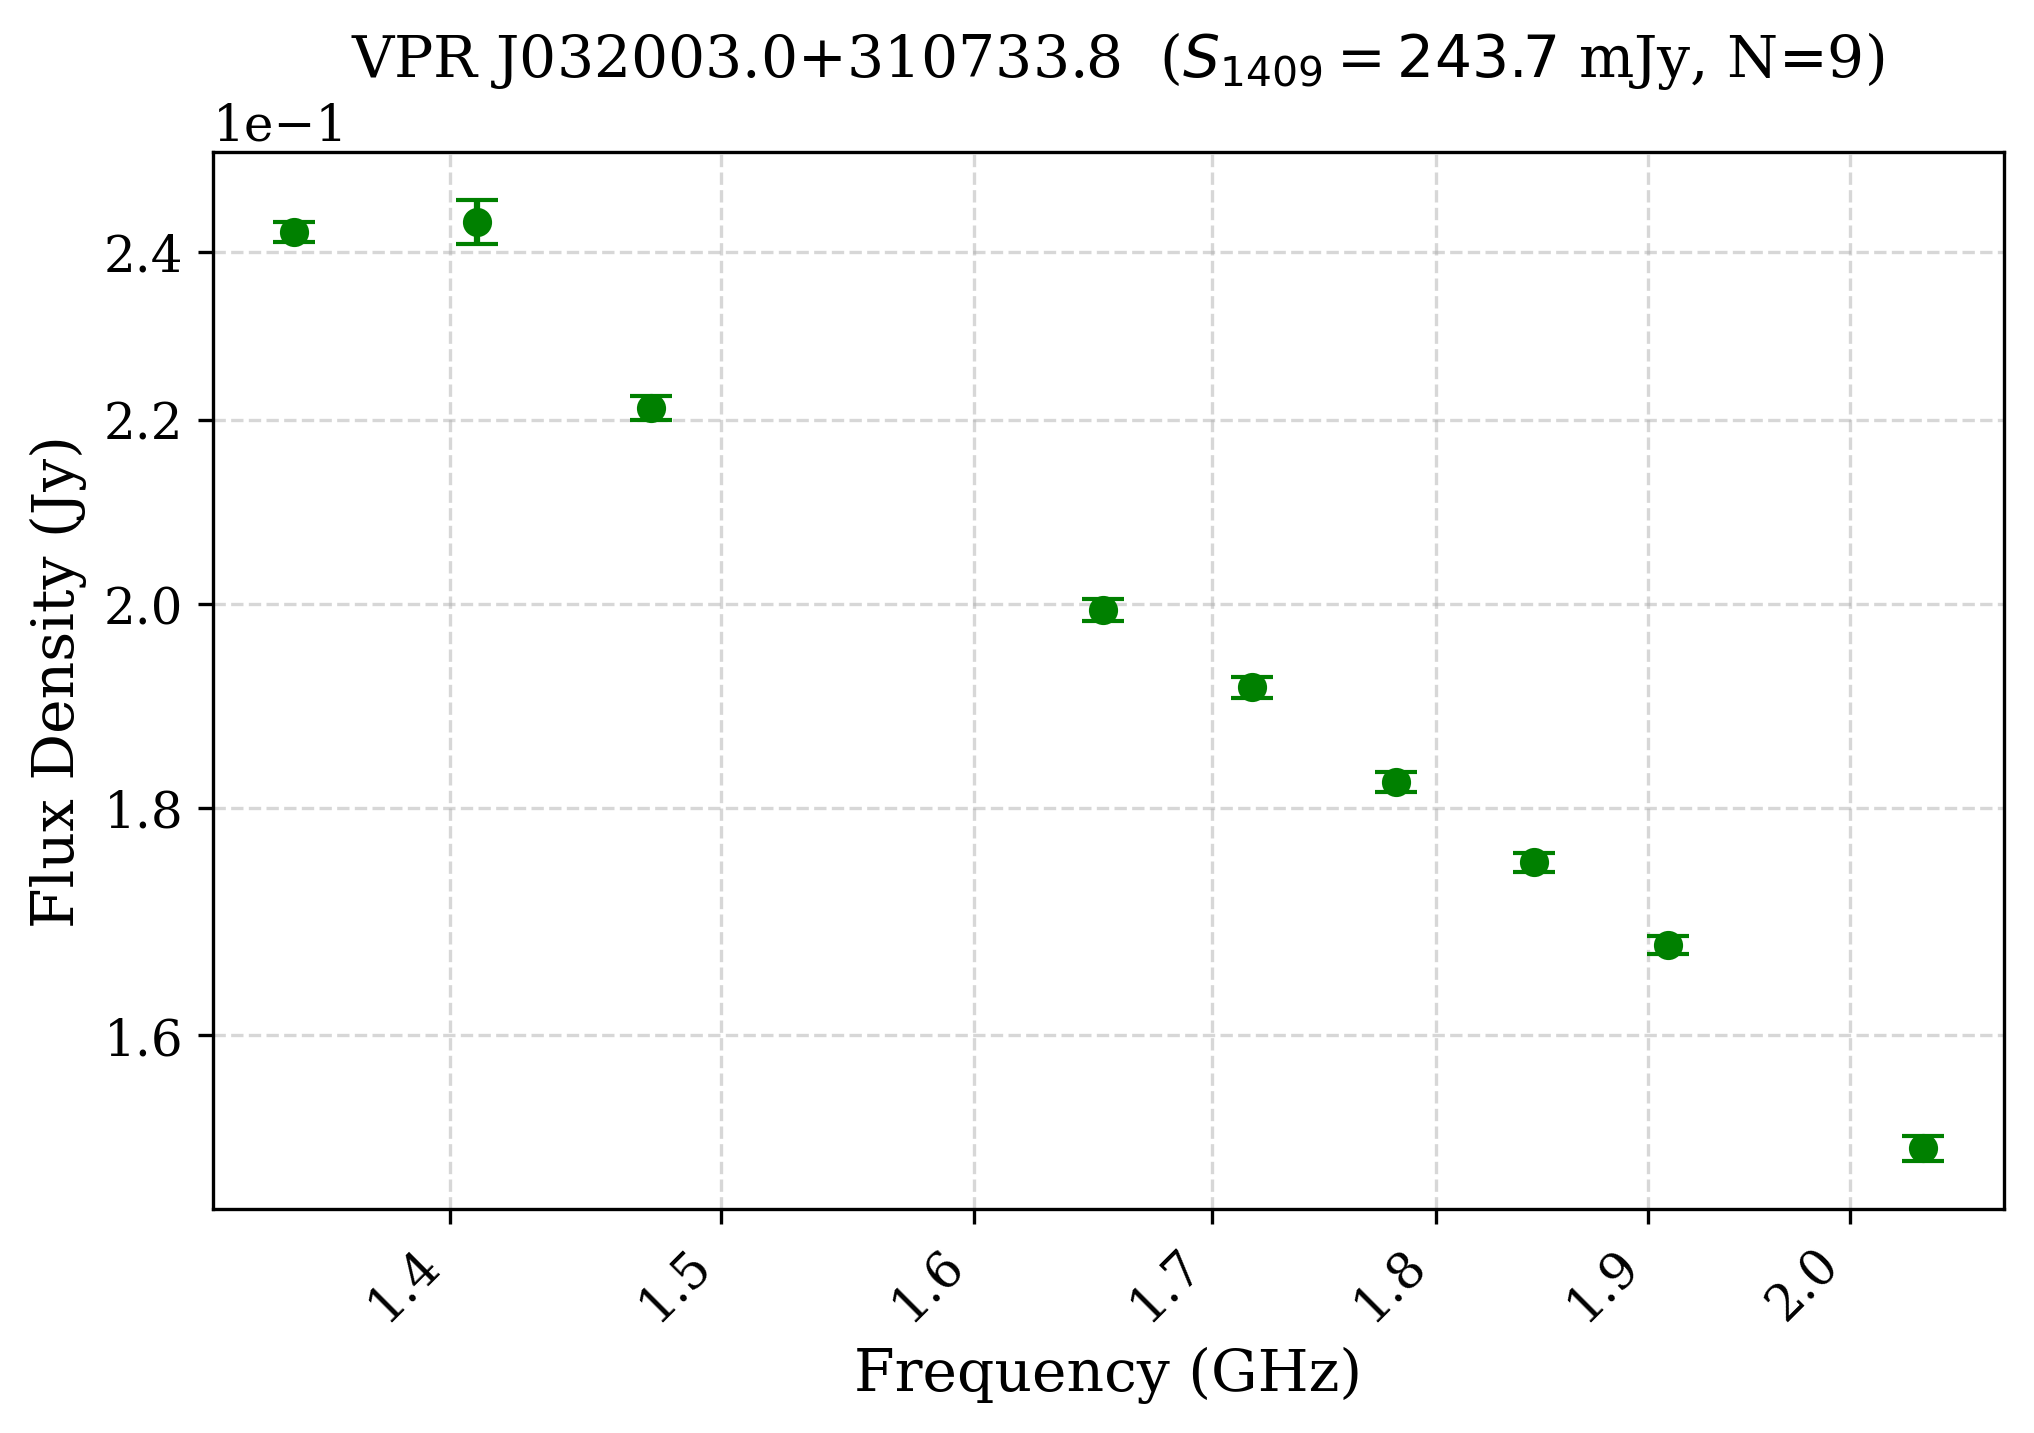

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J032003.0+310733.8_bright_nspw4_nofit.pdf


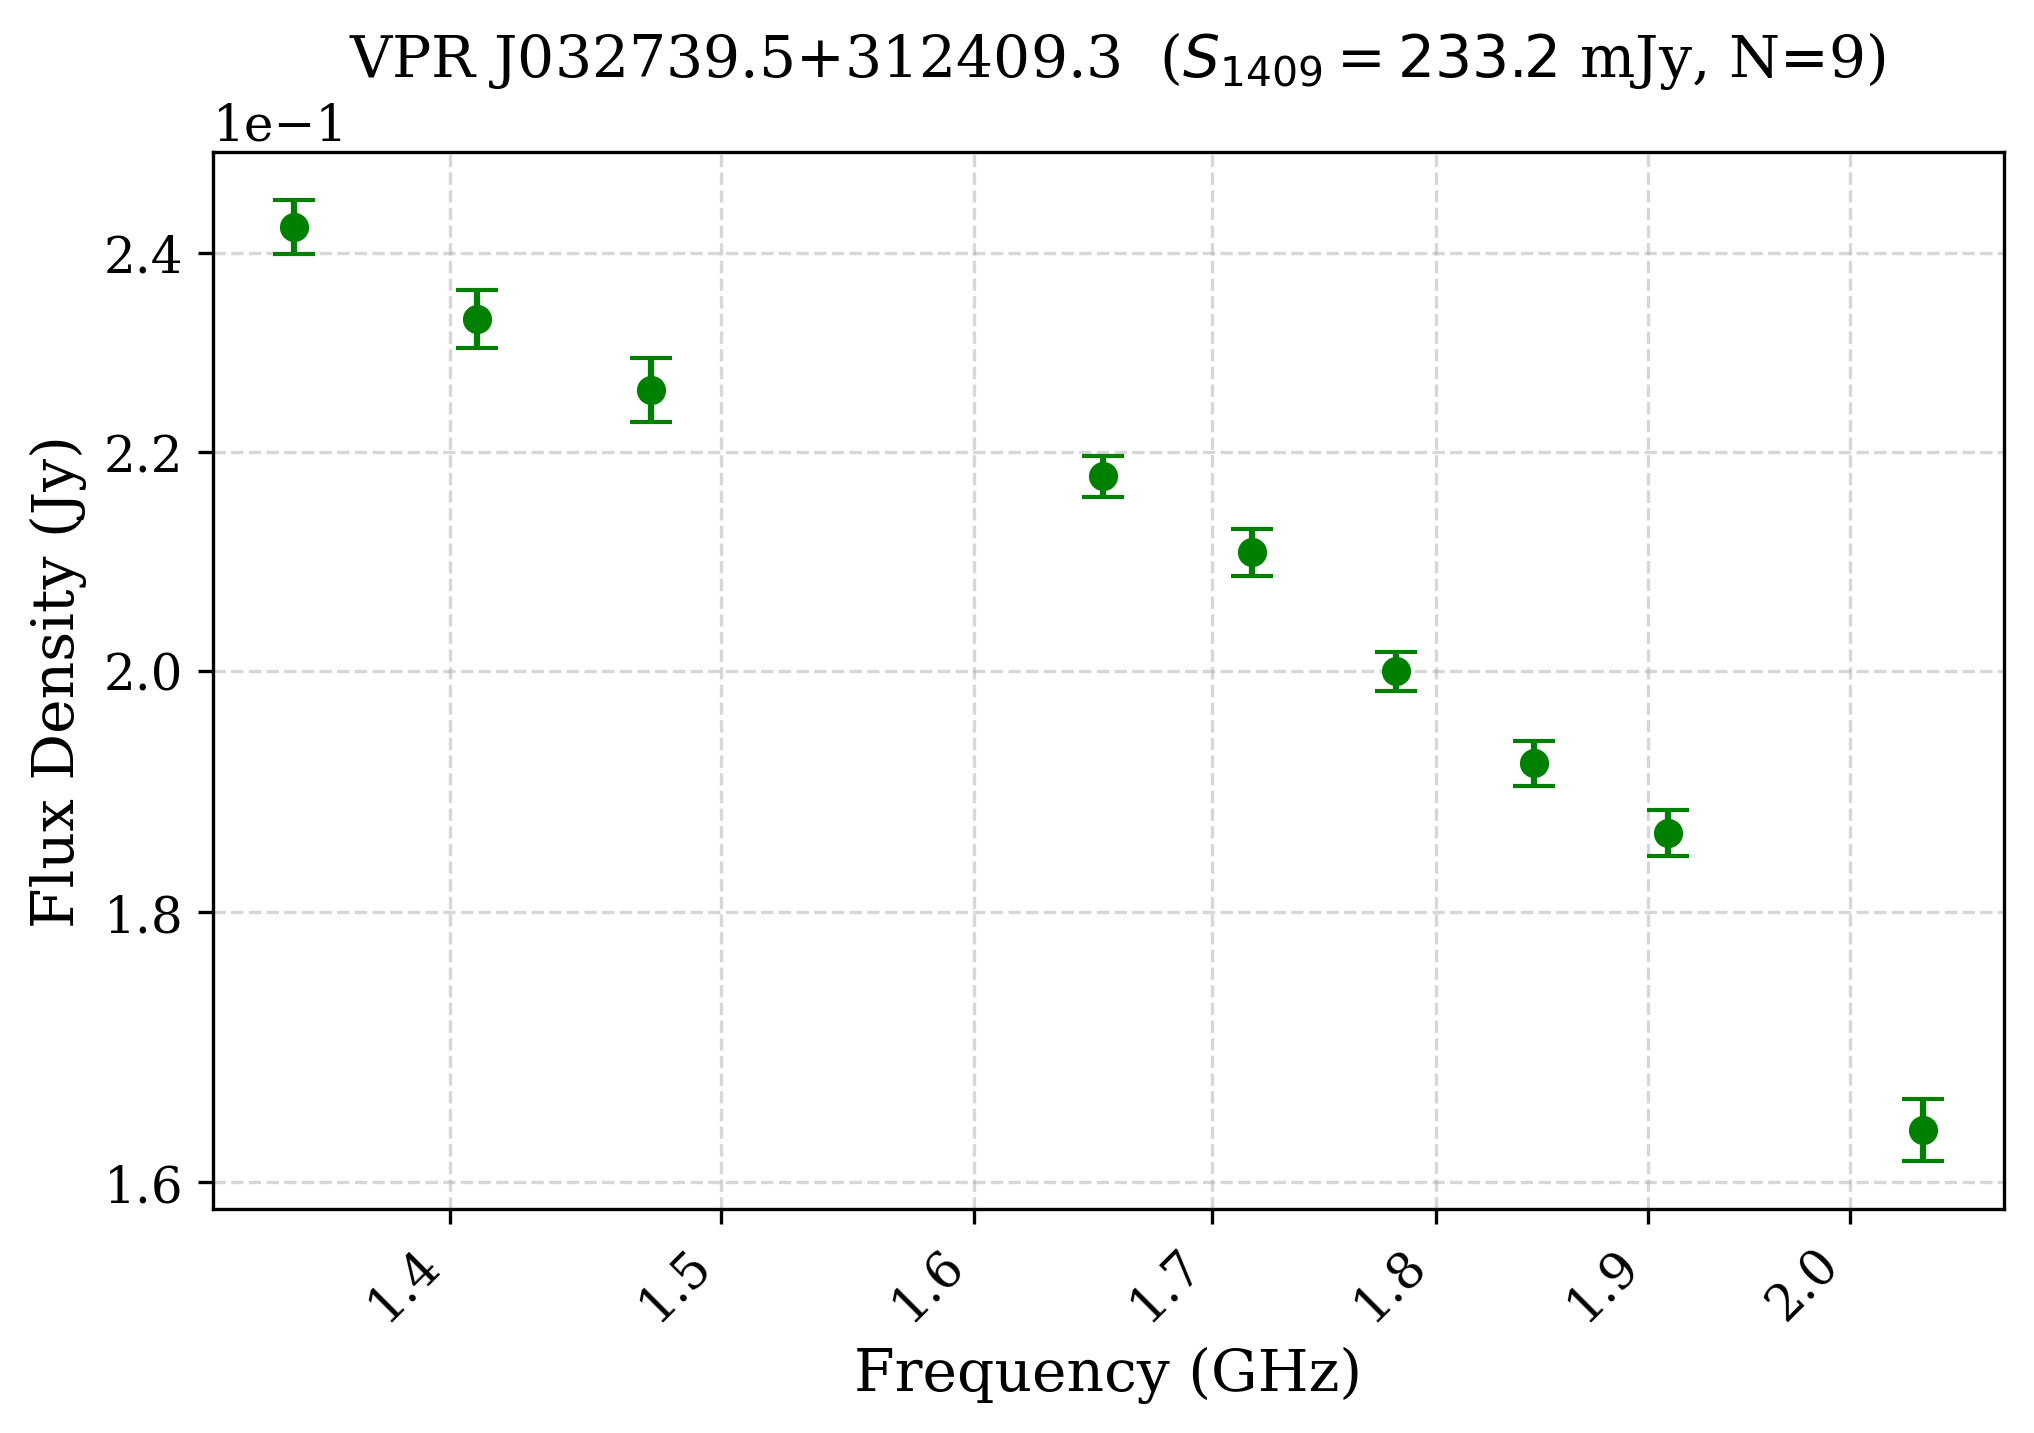

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J032739.5+312409.3_bright_nspw4_nofit.pdf


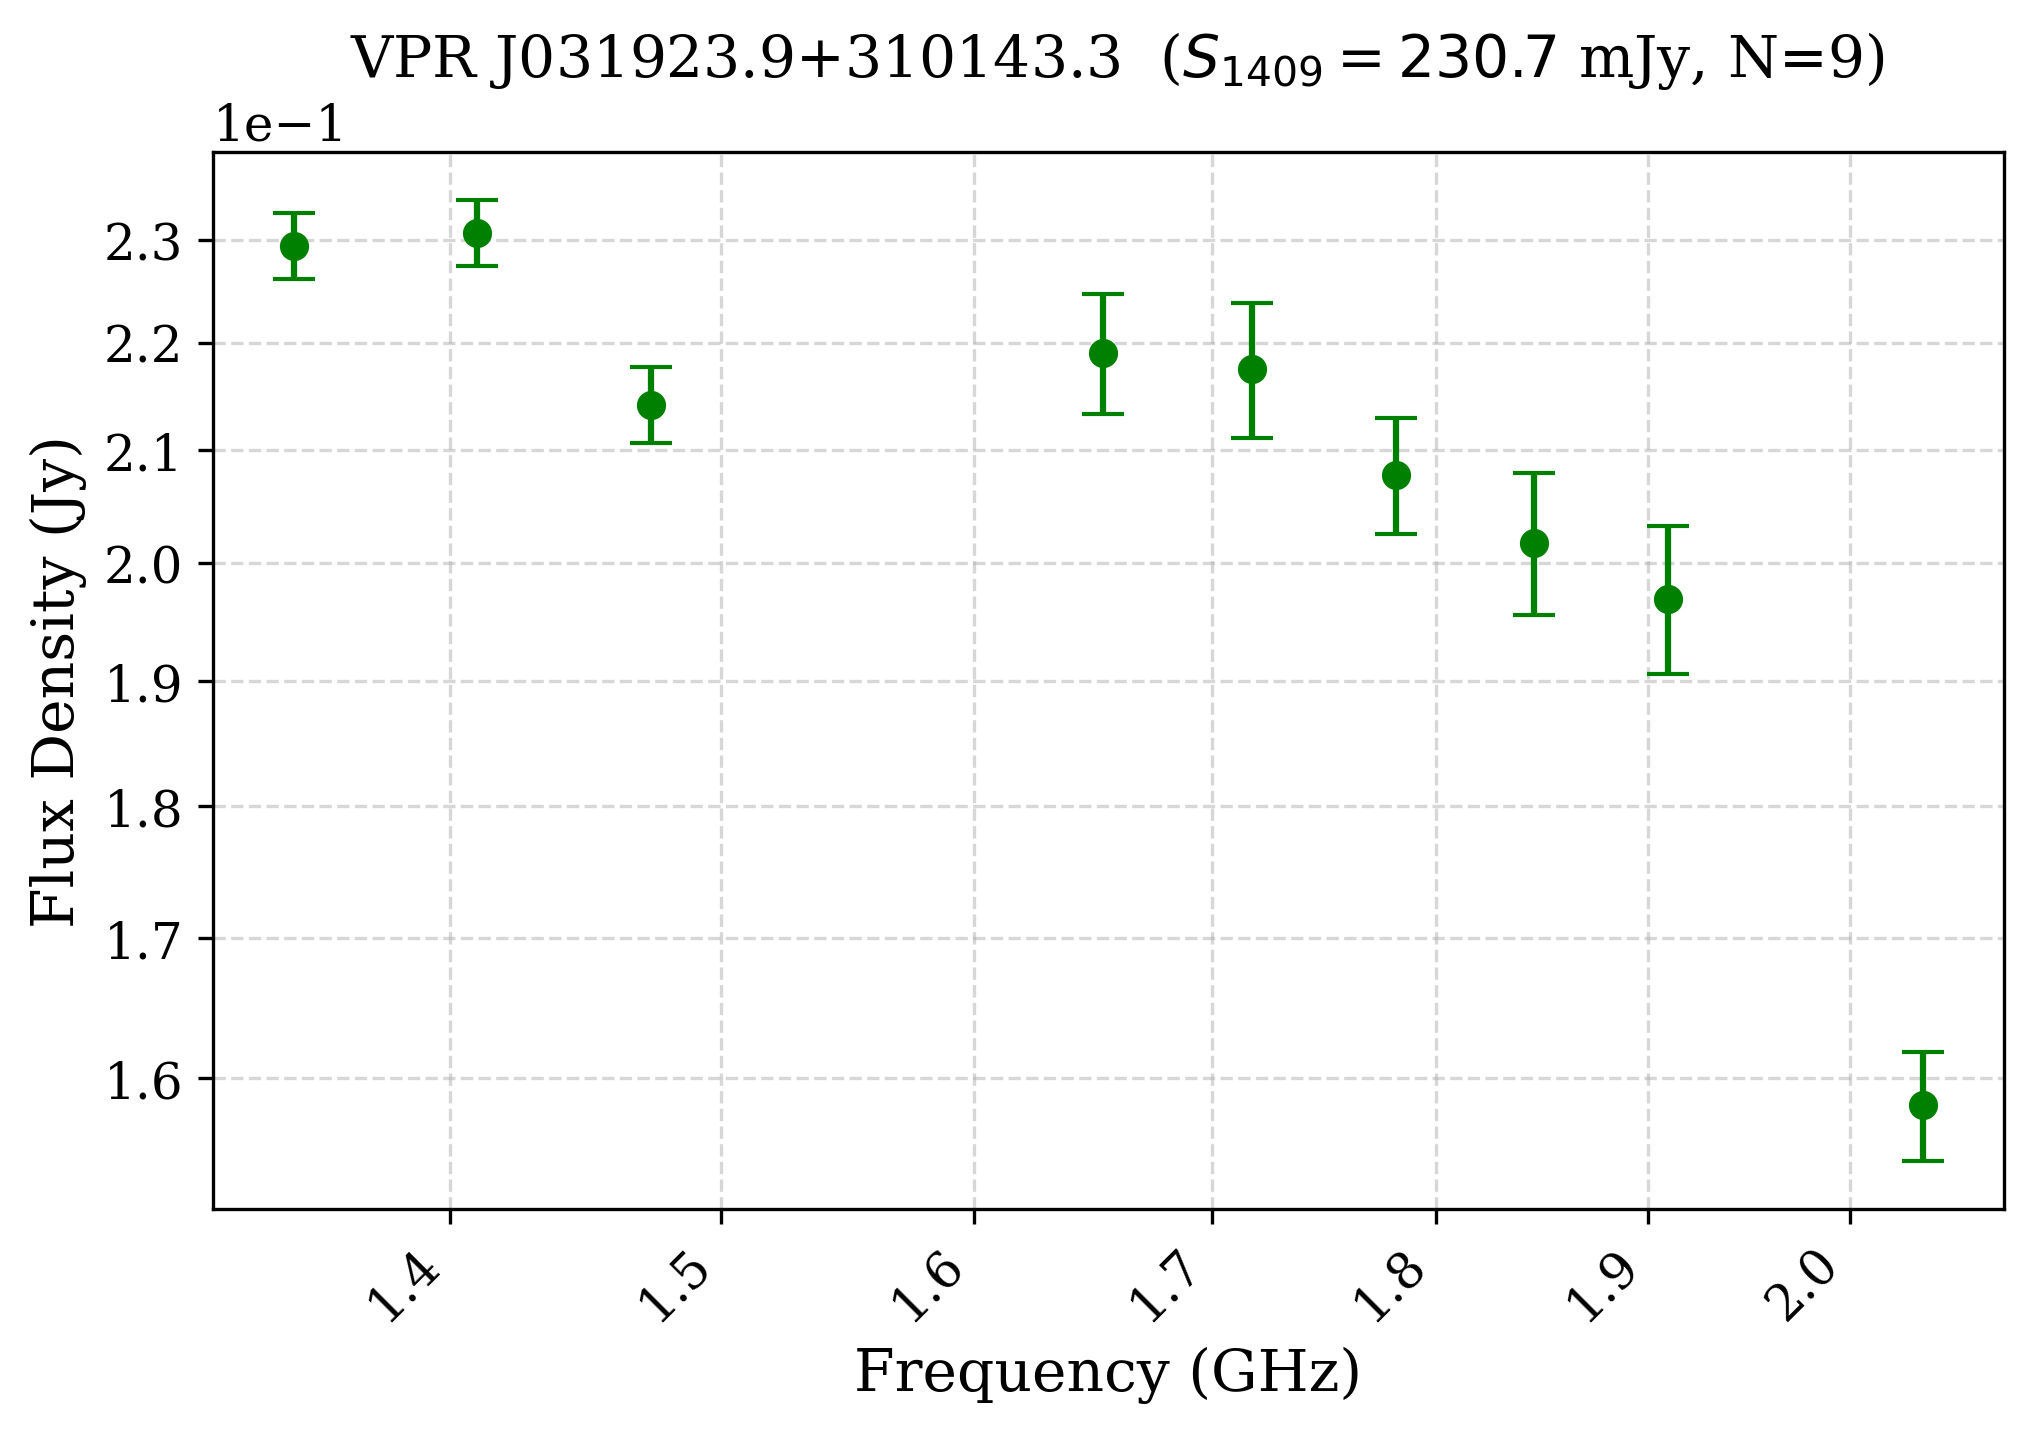

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J031923.9+310143.3_bright_nspw4_nofit.pdf


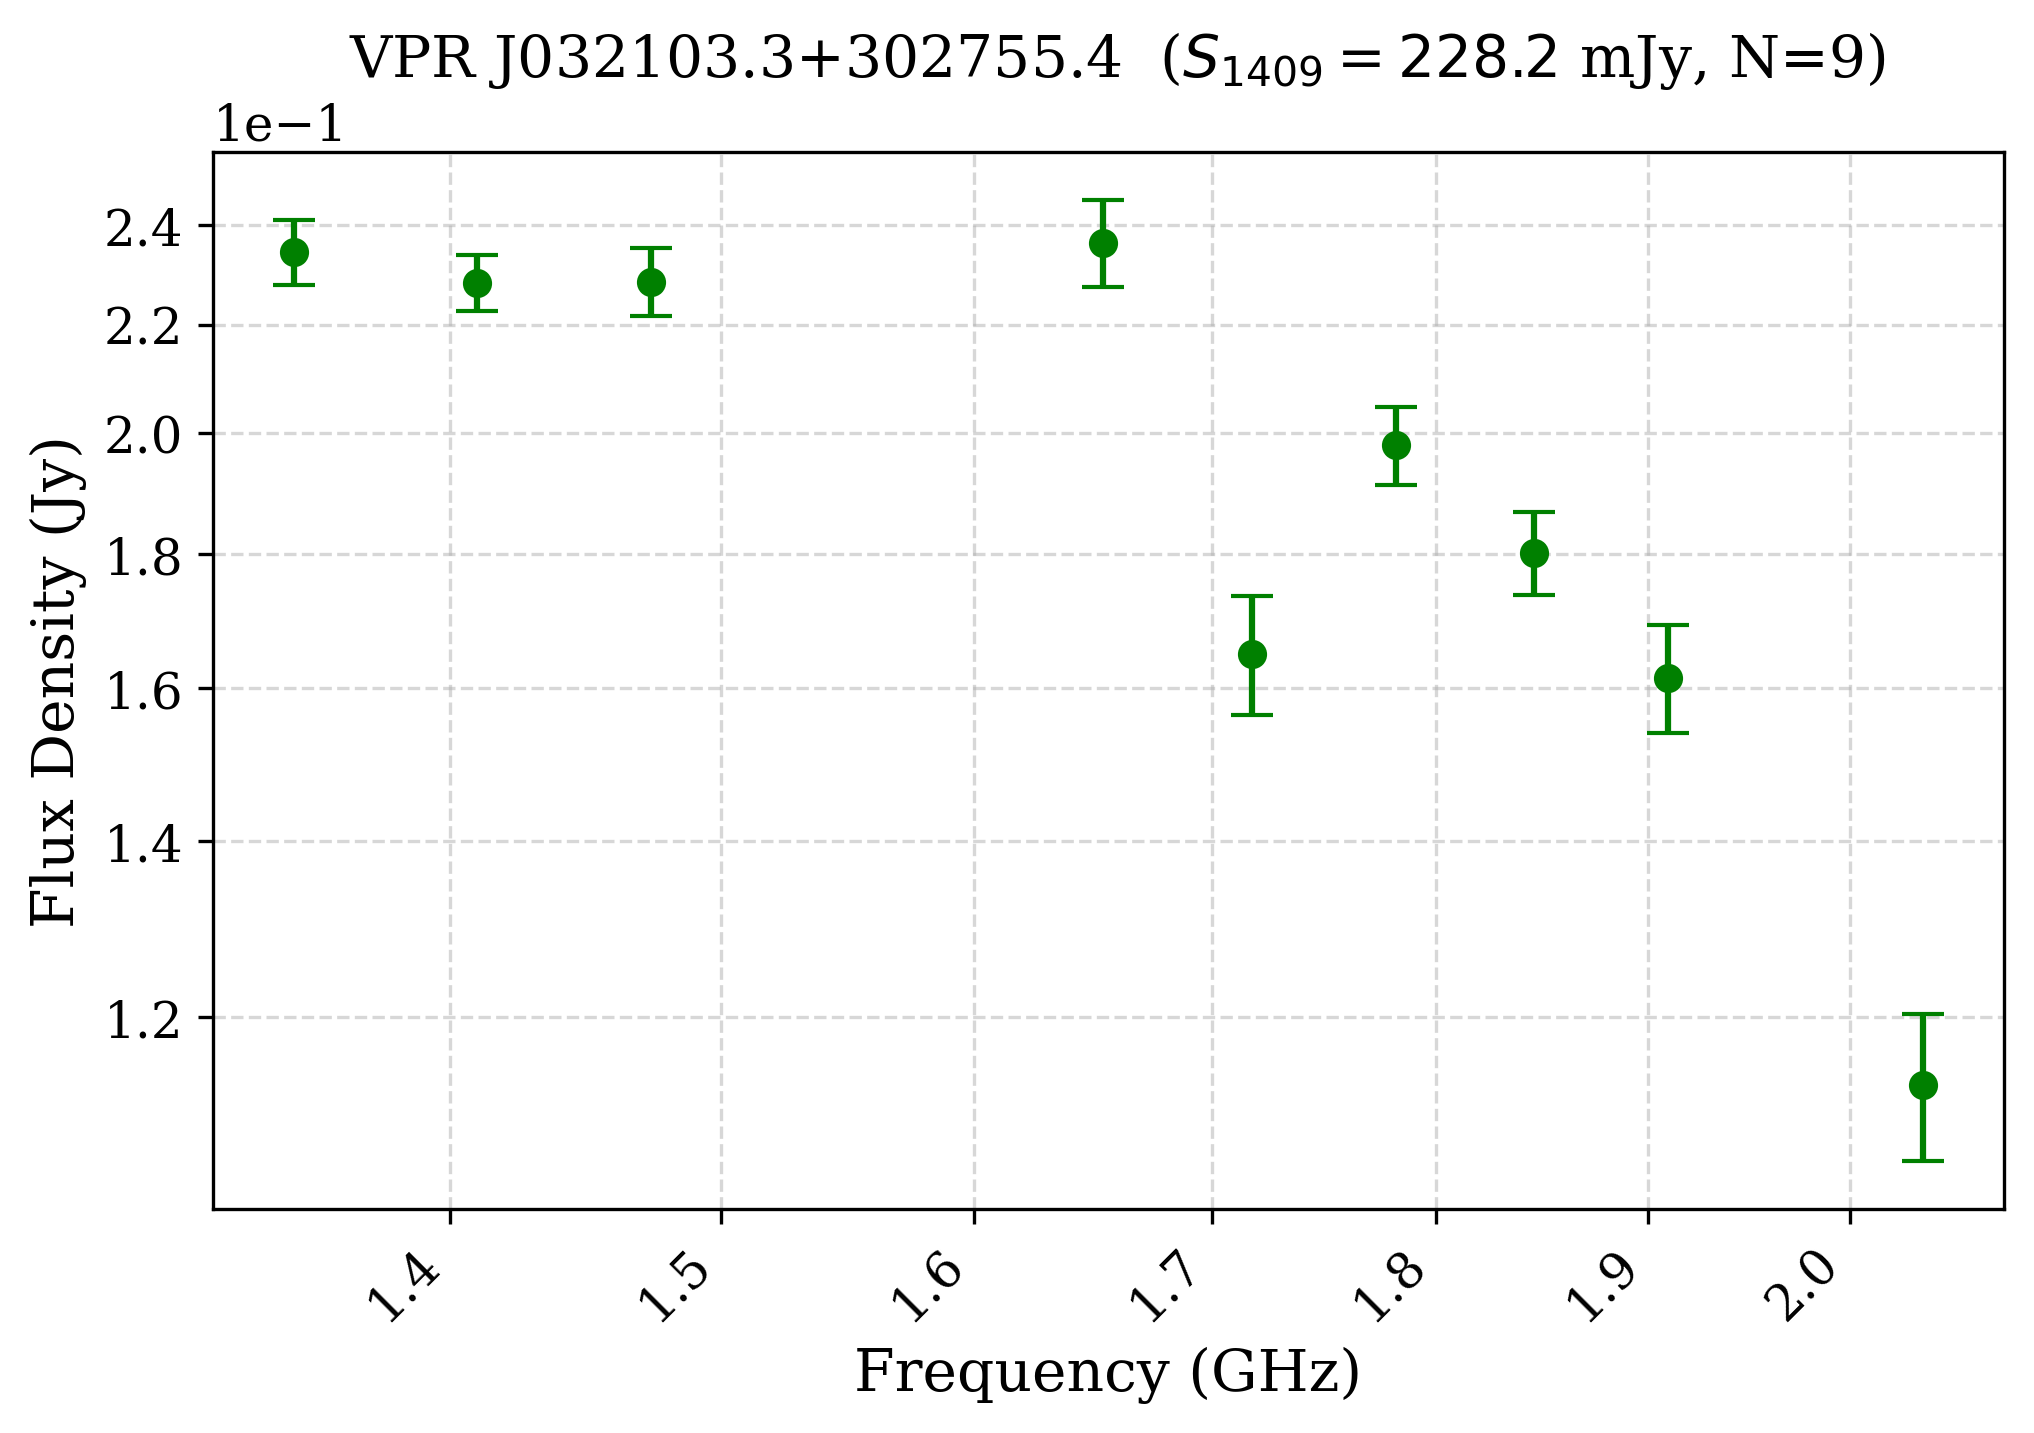

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J032103.3+302755.4_bright_nspw4_nofit.pdf


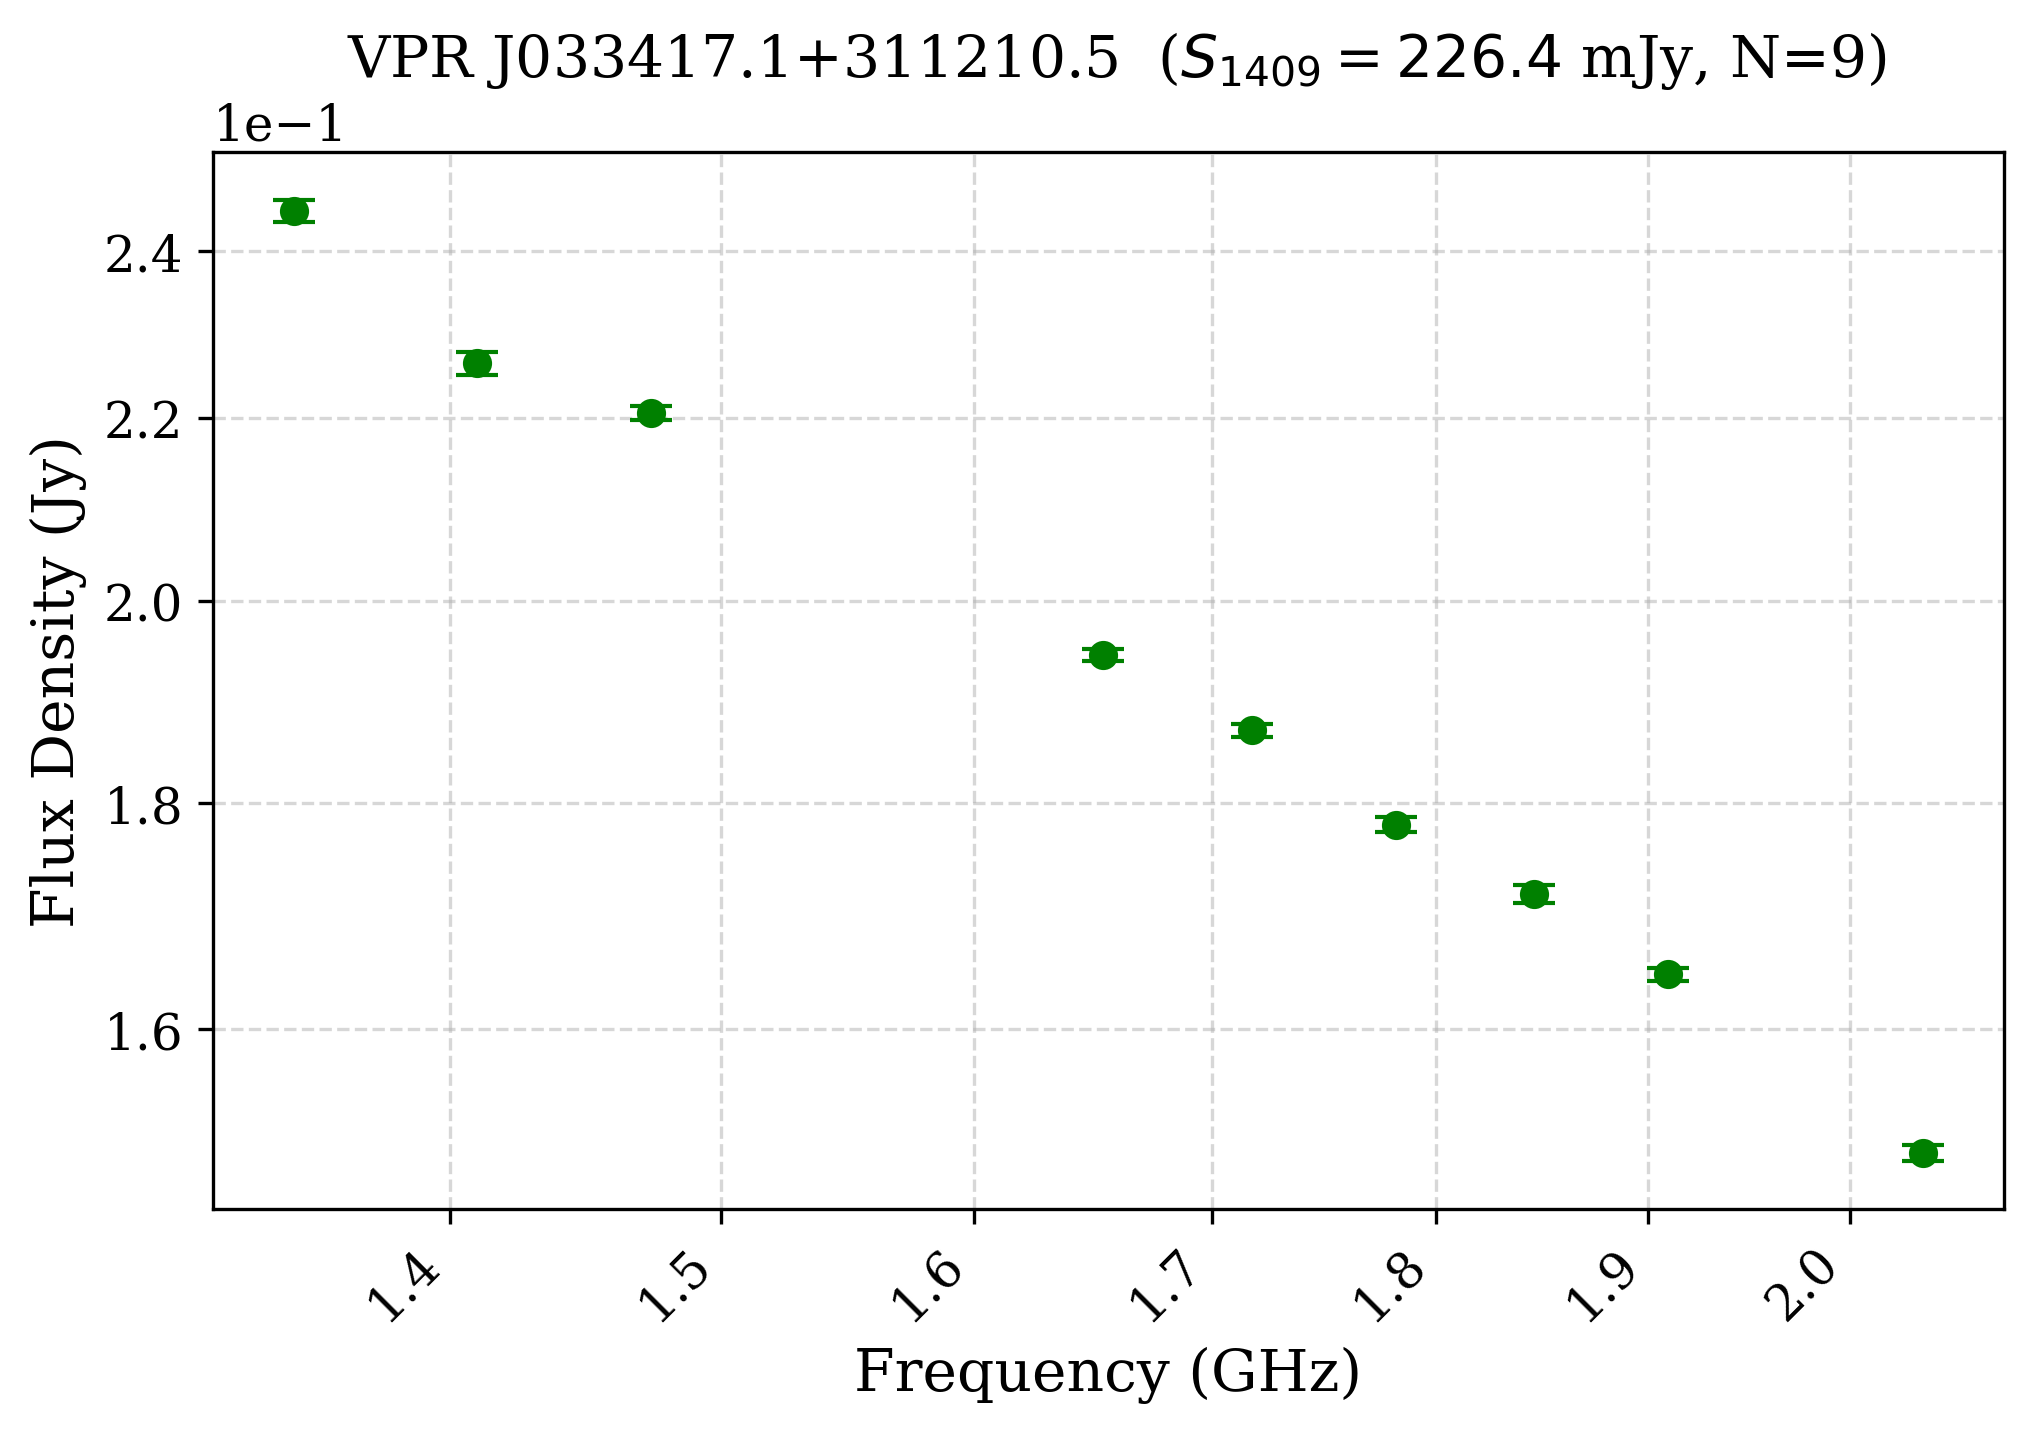

✅ Saved: ../paper1/figs/brightest_spectra_nspw4_no_fit/VPR_J033417.1+311210.5_bright_nspw4_nofit.pdf


In [24]:
# ======================================
# Brightest N sources by SPW16,
# requiring >= 4 SPWs available
# NO chi-square filtering
# NO fitting (just data + error bars)
# ======================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, LogLocator

OUTDIR = "../paper1/figs/brightest_spectra_nspw4_no_fit"
os.makedirs(OUTDIR, exist_ok=True)

N_BRIGHT = 20
FLUX_COL = "Total_S_SPW16"
MIN_SPW  = 4

# ---- precompute n_spw per source using extract_spectrum ----
rows = []
for _, row in df.iterrows():
    if ("Source_ID" not in row.index) or (FLUX_COL not in row.index):
        continue
    if not (np.isfinite(row[FLUX_COL]) and row[FLUX_COL] > 0):
        continue

    freqs_MHz, fluxes_mJy, errors_mJy = extract_spectrum(row)

    freqs_MHz  = np.asarray(freqs_MHz)
    fluxes_mJy = np.asarray(fluxes_mJy)
    errors_mJy = np.asarray(errors_mJy)

    good = (
        np.isfinite(freqs_MHz) &
        np.isfinite(fluxes_mJy) &
        np.isfinite(errors_mJy) &
        (errors_mJy > 0)
    )
    n_spw = int(np.sum(good))

    if n_spw >= MIN_SPW:
        rows.append((row["Source_ID"], float(row[FLUX_COL]), n_spw))

if len(rows) == 0:
    raise ValueError(f"No sources found with {FLUX_COL}>0 and n_spw >= {MIN_SPW}")

rank_df = pd.DataFrame(rows, columns=["Source_ID", FLUX_COL, "n_spw"])

# If duplicates in Source_ID, keep the brightest entry
rank_df = rank_df.sort_values(FLUX_COL, ascending=False).drop_duplicates("Source_ID", keep="first")

# Brightest candidates (still requiring n_spw>=MIN_SPW)
bright = rank_df.head(N_BRIGHT).reset_index(drop=True)

print(f"Candidates with n_spw >= {MIN_SPW}: {len(rank_df)}")
print(f"Plotting top {len(bright)} by {FLUX_COL} (NO FIT)")

for i, srow in bright.iterrows():
    source_id = srow["Source_ID"]
    S16_mJy   = float(srow[FLUX_COL])
    n_spw_rank = int(srow["n_spw"])

    # get the corresponding row from df (use brightest row if duplicates)
    match = df[df["Source_ID"] == source_id].copy()
    if match.empty:
        continue

    match = match[np.isfinite(match[FLUX_COL])]
    if match.empty:
        continue

    row = match.sort_values(FLUX_COL, ascending=False).iloc[0]

    freqs_MHz, fluxes_mJy, errors_mJy = extract_spectrum(row)

    freqs_MHz  = np.asarray(freqs_MHz)
    fluxes_mJy = np.asarray(fluxes_mJy)
    errors_mJy = np.asarray(errors_mJy)

    good = (
        np.isfinite(freqs_MHz) &
        np.isfinite(fluxes_mJy) &
        np.isfinite(errors_mJy) &
        (errors_mJy > 0)
    )
    freqs_MHz, fluxes_mJy, errors_mJy = freqs_MHz[good], fluxes_mJy[good], errors_mJy[good]
    n_spw = len(freqs_MHz)

    if n_spw < MIN_SPW:
        continue

    # ---- units for plotting ----
    freqs_GHz = freqs_MHz / 1000.0
    fluxes_Jy = fluxes_mJy / 1000.0
    errors_Jy = errors_mJy / 1000.0

    # ---- plot ----
    fig, ax = plt.subplots(figsize=(7, 5))

    ax.errorbar(
        freqs_GHz, fluxes_Jy,
        yerr=errors_Jy,
        fmt='o', color='green', ecolor='green',
        capsize=5, markersize=6
    )

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("Flux Density (Jy)")

    ax.xaxis.set_major_locator(LogLocator(base=10.0, subs='auto'))
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(axis='x', style='plain')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    ax.yaxis.set_major_locator(LogLocator(base=10.0, subs='auto'))
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.get_major_formatter().set_scientific(True)
    ax.yaxis.get_major_formatter().set_powerlimits((0, 0))

    ax.grid(True, which='both', ls='--', alpha=0.5)

    ax.set_title(
        rf" {source_id}  "
        rf"($S_{{1409}}={S16_mJy:.1f}$ mJy, N={n_spw})"
    )

    outpath = os.path.join(
        OUTDIR,
        f"{str(source_id).replace(' ', '_')}_bright_nspw{MIN_SPW}_nofit.pdf"
    )
    plt.tight_layout()
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Saved: {outpath}")


Source: VPR J033457.1+304925.3
  N_SPW      = 9
  alpha      = -0.687 ± 0.029
  chi2_red   = 0.712


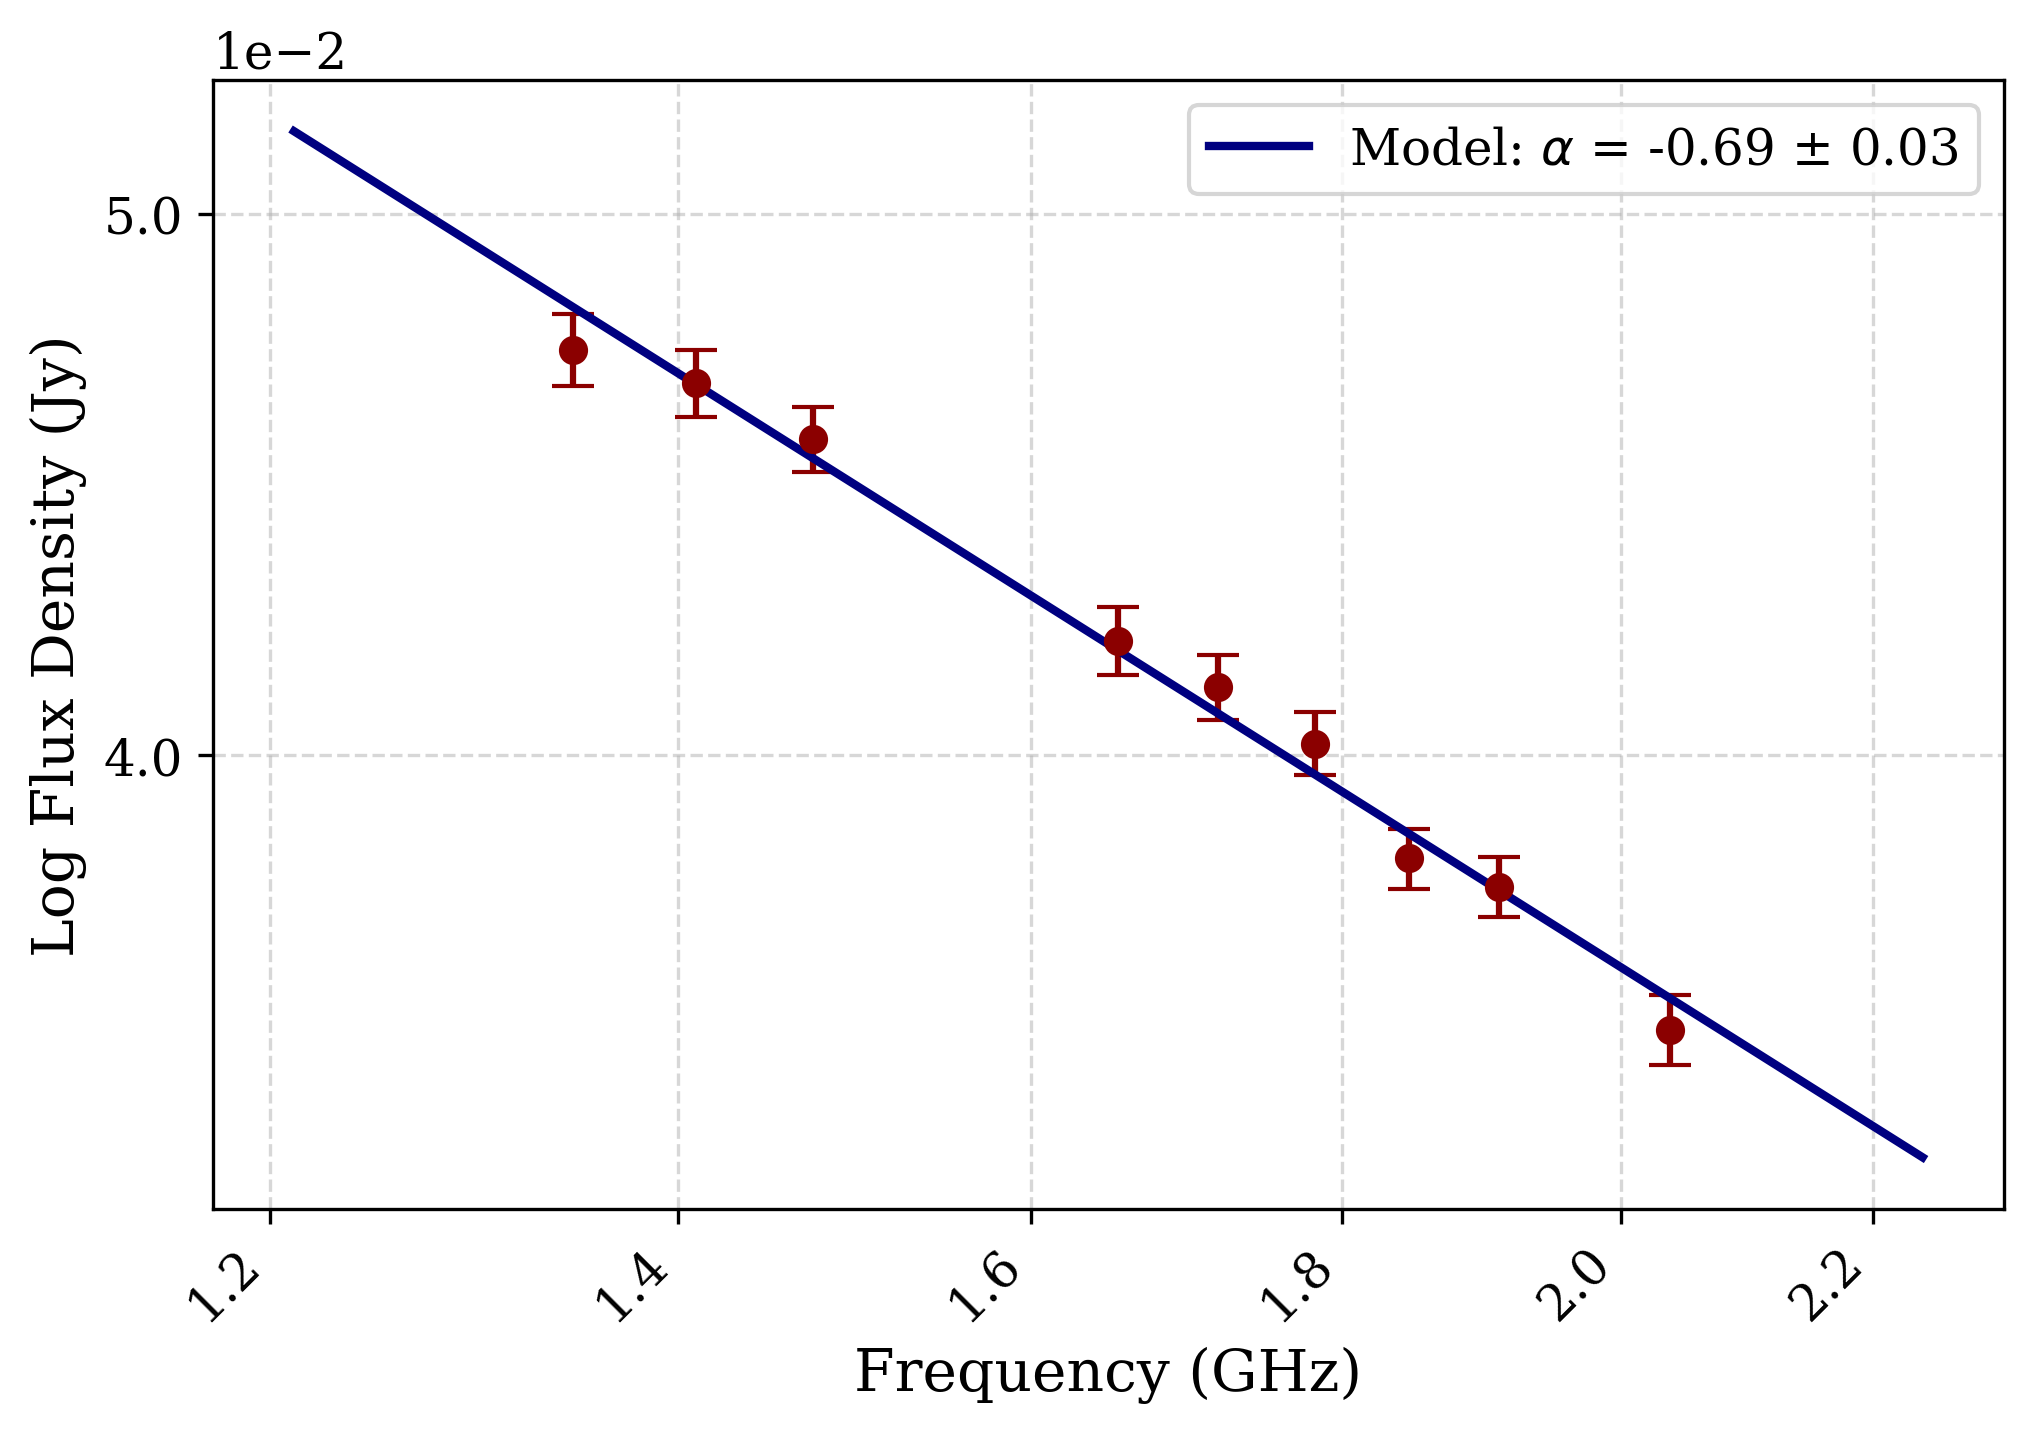

In [15]:
# ======================================
# PLOT SPECTRUM FOR ONE SPECIFIC SOURCE
# Styled like the example figure
# ======================================

from matplotlib.ticker import ScalarFormatter, LogLocator

source_id = "VPR J033457.1+304925.3"

# get the row from the big table (no filters)
row = df[df["Source_ID"] == source_id]

if row.empty:
    print(f"⚠️ Source {source_id} not found in df.")
else:
    row = row.iloc[0]

    # extract spectrum (MHz, mJy)
    freqs_MHz, fluxes_mJy, errors_mJy = extract_spectrum(row)

    if len(freqs_MHz) < 2:
        print(f"⚠️ Source {source_id}: not enough valid SPWs to plot.")
    else:
        # --- fit lmfit power-law: S(nu) = A * (nu/NU0)^alpha (nu in MHz) ---
        params = pl_model.make_params(
            A=np.median(fluxes_mJy),
            alpha=-0.7
        )

        fit_result = pl_model.fit(
            fluxes_mJy,
            params,
            nu=freqs_MHz,
            weights=1.0 / errors_mJy
        )

        A_fit     = fit_result.params["A"].value
        alpha_fit = fit_result.params["alpha"].value
        e_alpha   = fit_result.params["alpha"].stderr
        chi2_red  = fit_result.redchi
        n_spw     = len(freqs_MHz)

        print(f"Source: {source_id}")
        print(f"  N_SPW      = {n_spw}")
        print(f"  alpha      = {alpha_fit:.3f} ± {e_alpha:.3f}")
        print(f"  chi2_red   = {chi2_red:.3f}")

        # ---------- convert units for plotting ----------
        # x: MHz -> GHz
        freqs_GHz = freqs_MHz / 1000.0

        # y: mJy -> Jy
        fluxes_Jy = fluxes_mJy / 1000.0
        errors_Jy = errors_mJy / 1000.0

        # model curve in same units
        nu_model_MHz = np.linspace(freqs_MHz.min()*0.9, freqs_MHz.max()*1.1, 200)
        flux_model_mJy = power_law(nu_model_MHz, A_fit, alpha_fit)
        nu_model_GHz   = nu_model_MHz / 1000.0
        flux_model_Jy  = flux_model_mJy / 1000.0

        # -------- PLOT (log–log) in the requested style --------
        fig, ax = plt.subplots(figsize=(7, 5))

        ax.errorbar(
            freqs_GHz,
            fluxes_Jy,
            yerr=errors_Jy,
            fmt='o',
            color='darkred',
            ecolor='darkred',
            capsize=5,
            markersize=6
        )

        ax.plot(
            nu_model_GHz,
            flux_model_Jy,
            color='navy',
            linewidth=2,
            label=rf'Model: $\alpha$ = {alpha_fit:.2f} ± {e_alpha:.2f}'
        )

        # === Log–log scale ===
        ax.set_xscale('log')
        ax.set_yscale('log')

        # === X-axis formatting (GHz) ===
        ax.set_xlabel('Frequency (GHz)')
        ax.xaxis.set_major_locator(LogLocator(base=10.0, subs='auto'))
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.ticklabel_format(axis='x', style='plain')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        # === Y-axis formatting (Jy) ===
        ax.set_ylabel('Log Flux Density (Jy)')
        ax.yaxis.set_major_locator(LogLocator(base=10.0, subs='auto'))
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.get_major_formatter().set_scientific(True)
        ax.yaxis.get_major_formatter().set_powerlimits((0, 0))

        ax.legend()
        ax.grid(True, which='both', ls='--', alpha=0.5)
        plt.savefig('../paper1/figs/spectral_fit.pdf', dpi=300, bbox_inches='tight')
        plt.tight_layout()
        
        plt.show()


# Alpha to big table

In [16]:
# ======================================
# MERGE LMFIT α INTO BIG TABLE AS:
#     alpha
#     E_alpha
# ======================================

import pandas as pd

# ------------------------------
# Paths
# ------------------------------
BIG_TABLE_PATH   = "../paper1/csv/combined_sources_all_spw.csv"
ALPHA_TABLE_PATH = "../paper1/csv/good_alpha_lmfit.csv"   # your saved file
OUTPUT_PATH      = "../paper1/csv/combined_sources_with_alpha.csv"

# ------------------------------
# Load tables
# ------------------------------
df_big = pd.read_csv(BIG_TABLE_PATH)
df_alpha = pd.read_csv(ALPHA_TABLE_PATH)

print("Big table shape:   ", df_big.shape)
print("Alpha table shape: ", df_alpha.shape)

# ------------------------------
# Keep only α columns and rename
# ------------------------------
alpha_small = df_alpha[
    ["Source_ID", "alpha_lmfit", "E_alpha_lmfit"]
].drop_duplicates(subset=["Source_ID"])

alpha_small = alpha_small.rename(columns={
    "alpha_lmfit": "alpha",
    "E_alpha_lmfit": "E_alpha"
})

print("Alpha-small shape:", alpha_small.shape)

# ------------------------------
# Merge
# ------------------------------
df_merged = df_big.merge(alpha_small, on="Source_ID", how="left")

print("Merged table shape:", df_merged.shape)

# ------------------------------
# Save output
# ------------------------------
df_merged.to_csv(OUTPUT_PATH, index=False)

print(f"✅ Saved updated table with α to:\n    {OUTPUT_PATH}")


Big table shape:    (1410, 50)
Alpha table shape:  (275, 4)
Alpha-small shape: (275, 3)
Merged table shape: (1410, 52)
✅ Saved updated table with α to:
    ../paper1/csv/combined_sources_with_alpha.csv
